✅ Flowchart generated. Files saved in Flow_Chart folder:
 - Flow_Chart\flowchart_neurology.png
 - Flow_Chart\flowchart_neurology.pdf
 - Flow_Chart\flowchart_neurology.svg
 - Flow_Chart\flowchart_neurology.tiff
 - Flow_Chart\flowchart_neurology.dot


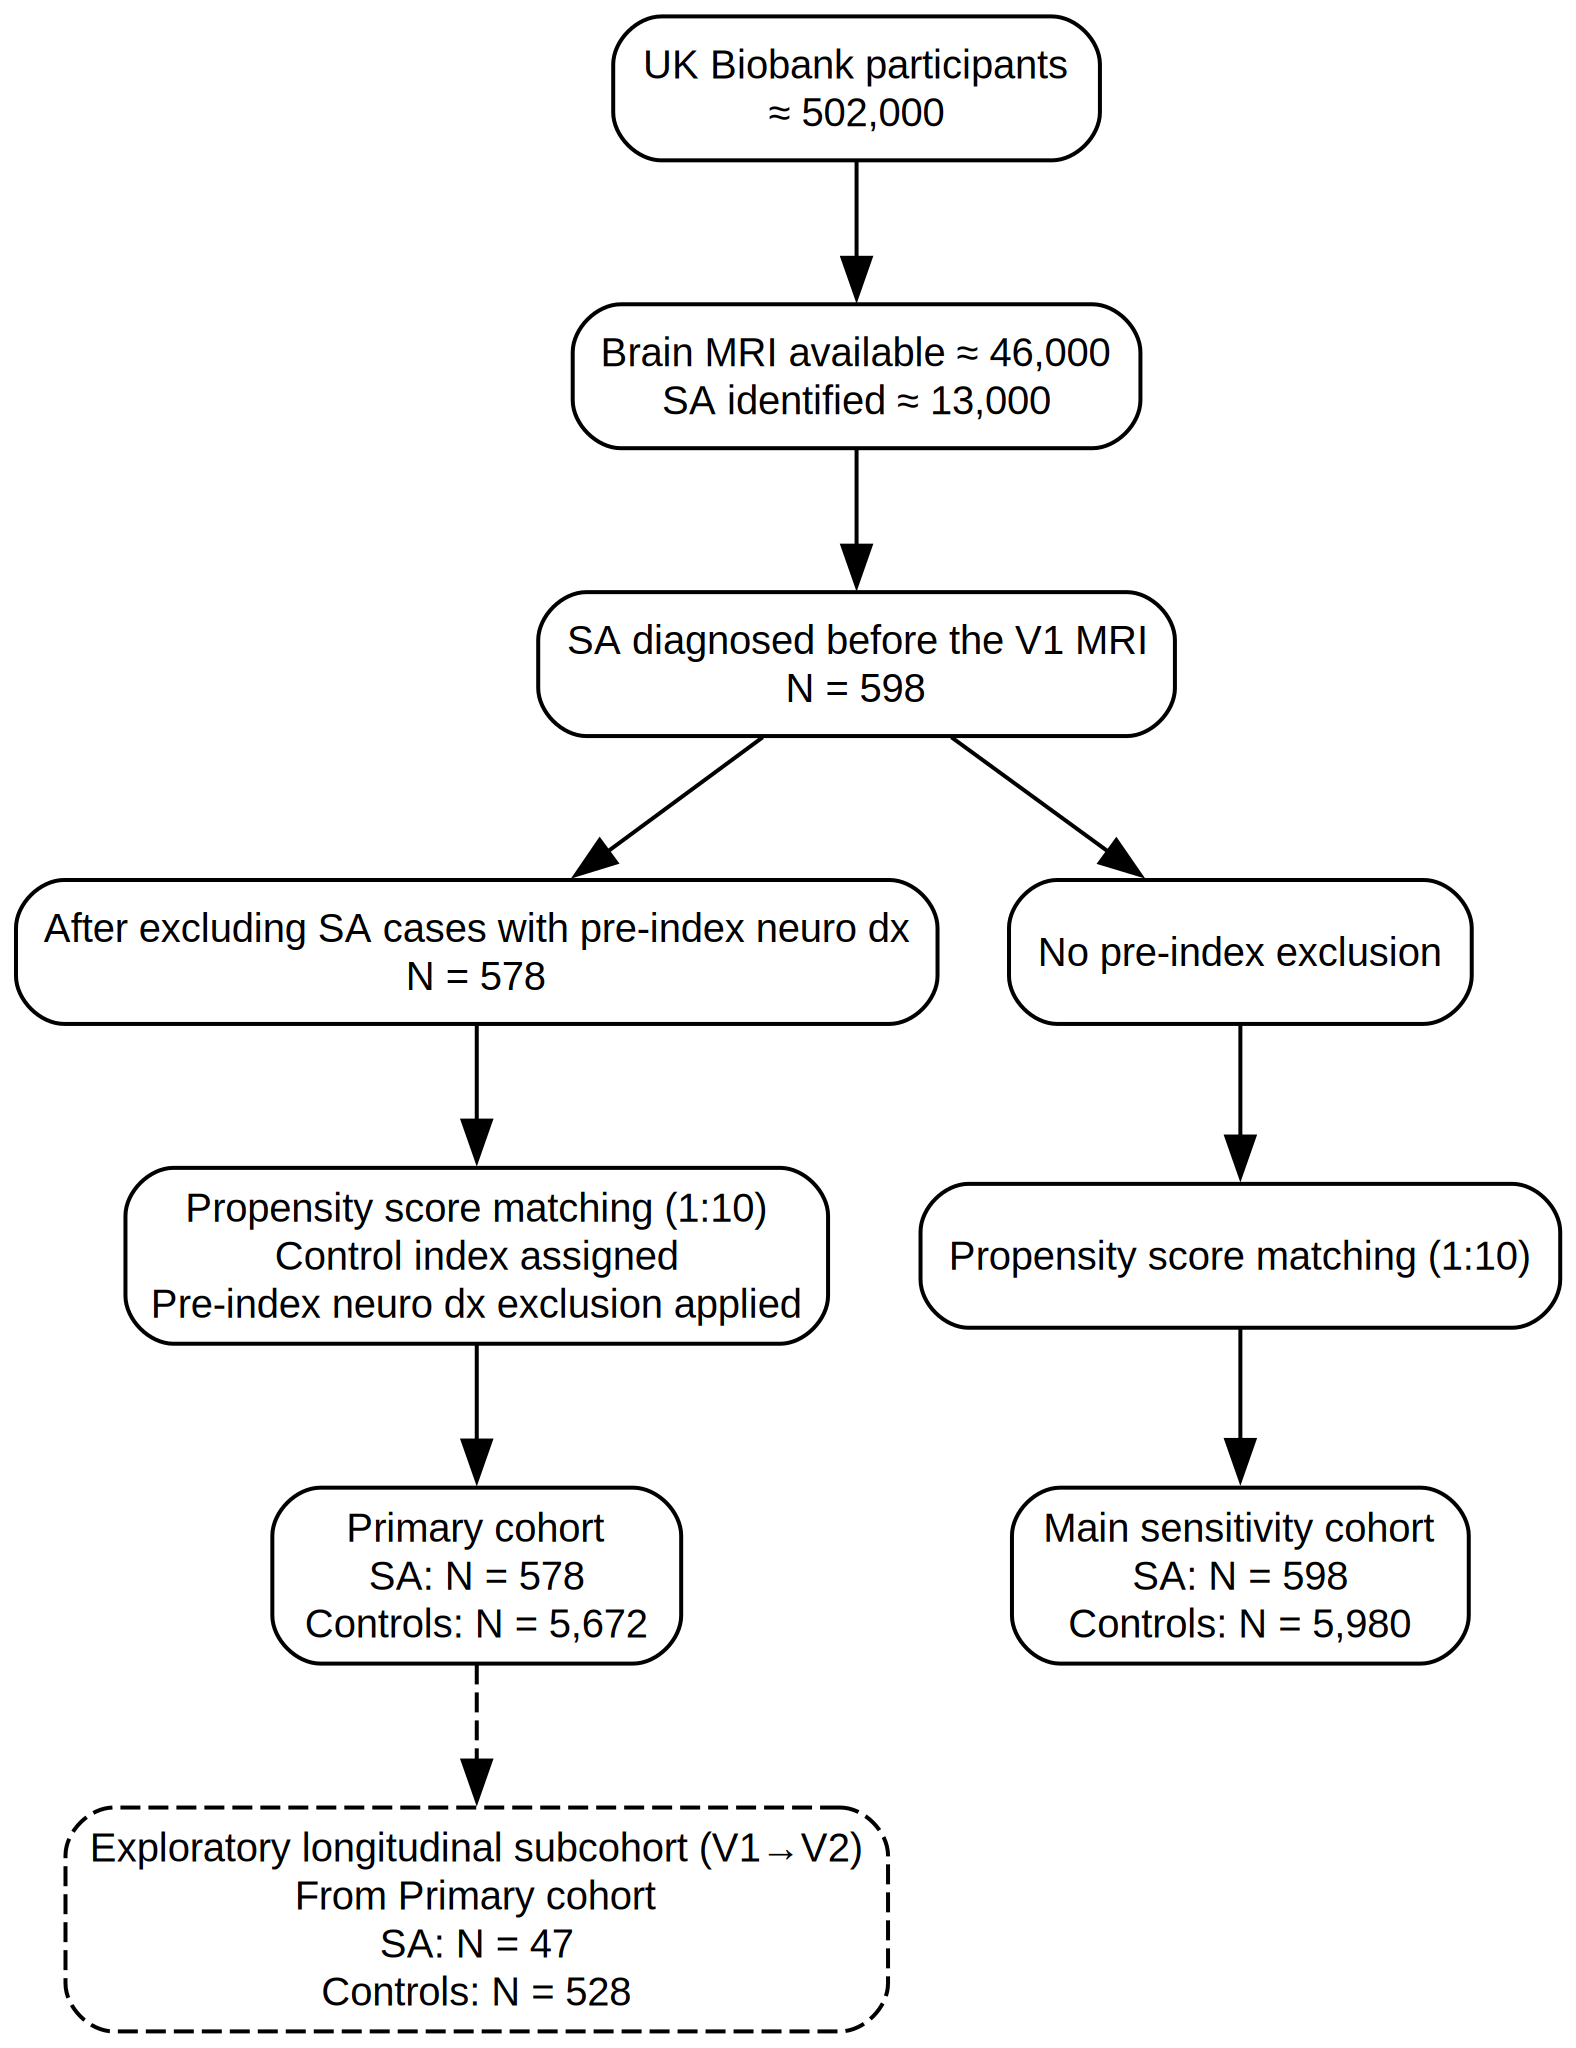

In [1]:
# Graphviz Flowchart for submission (Option 1: inline display + file export)
# If not installed, run:  !pip install graphviz
# (Optional for LZW compression of TIFF:  !pip install pillow)

import os
from datetime import datetime
from graphviz import Digraph

# Optional: Pillow for LZW-compressed TIFF post-processing
try:
    from PIL import Image
except Exception:
    Image = None  # If Pillow is not available, TIFF is still exported (without LZW)

# ------------------------------------------------------
# 1. Output directory
# ------------------------------------------------------
outdir = "Flow_Chart"
os.makedirs(outdir, exist_ok=True)

# Auto-generate filenames with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
basename = "flowchart_neurology"

# ------------------------------------------------------
# 2. Initialize graph
# ------------------------------------------------------
# Note: 'dpi' controls raster resolution for PNG/TIFF outputs.
dot = Digraph("Study_Flowchart", format="png")
dot.attr(rankdir="TB", size="8,10", dpi="600")   # TB = top-to-bottom layout; 600 dpi for high-res raster

# Global font settings (sans-serif fonts, e.g., Arial)
dot.attr("graph", fontname="Arial")
dot.attr("node", shape="rectangle", style="rounded",
         fontsize="10", fontname="Arial", color="black", fillcolor="white")
dot.attr("edge", fontname="Arial", fontsize="9")


# ------------------------------------------------------
# 3. Define nodes
# ------------------------------------------------------
dot.node("A", "UK Biobank participants\n ≈ 502,000")
# dot.node("B", "I2 brain MRI (WMH IDPs) available\n≈ 61,000")
# dot.node("C", "SA identified (Self-report / Hospital)\n≈ 13,000")

dot.node("BC", "Brain MRI available ≈ 46,000\nSA identified ≈ 13,000")

dot.node("D", "SA diagnosed before the V1 MRI\nN = 598")

# Branches
dot.node("E1", "After excluding SA cases with pre-index neuro dx\nN = 578")
dot.node("E2", "No pre-index exclusion")

# Matching steps
dot.node("F1", "Propensity score matching (1:10)\nControl index assigned\nPre-index neuro dx exclusion applied")
dot.node("F2", "Propensity score matching (1:10)")

# Final cohorts
dot.node("G1", "Primary cohort\nSA: N = 578\nControls: N = 5,672")
dot.node("G2", "Main sensitivity cohort\nSA: N = 598\nControls: N = 5,980")

# Align F1 and F2 horizontally
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node("F1")
    s.node("F2")

# Align G1 and G2 horizontally
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node("G1")
    s.node("G2")

# Exploratory longitudinal subcohort (derived from Primary cohort only)
dot.node("H1", "Exploratory longitudinal subcohort (V1→V2)\nFrom Primary cohort\nSA: N = 47\nControls: N = 528",
         style="rounded,dashed")


# ------------------------------------------------------
# 4. Define edges
# ------------------------------------------------------
# Branches from A
dot.edge("A", "BC")
# dot.edge("A", "C")

# Intersection: D = B ∩ C
dot.edge("BC", "D")
# dot.edge("C", "D")

# Continue paths
# dot.edge("D", "E1", xlabel ="Primary path", labeldistance = "2.5")
# dot.edge("D", "E2", label ="Main sensitivity path", labeldistance="2.5")
dot.edge("D", "E1")
dot.edge("D", "E2")

dot.edge("E1", "F1")
dot.edge("F1", "G1")

dot.edge("E2", "F2")
dot.edge("F2", "G2")

# Dashed edge to show derivation
dot.edge("G1", "H1", style="dashed")


# #Invisible node for alignment (optional)
# dot.node("AlignLeft", "", style="invis", width="0", height="0")

# ------------------------------------------------------
# 5. Save outputs (PNG, PDF, SVG, DOT, and high-res TIFF)
# ------------------------------------------------------
# Base paths
base_path = os.path.join(outdir, basename)
png_path = base_path + ".png"
pdf_path = base_path + ".pdf"
svg_path = base_path + ".svg"
tif_path = base_path + ".tiff"
dot_path = base_path + ".dot"

# Render outputs
dot.render(filename=base_path, format="png", cleanup=True)
dot.render(filename=base_path, format="pdf", cleanup=True)
dot.render(filename=base_path, format="svg", cleanup=True)
dot.render(filename=base_path, format="tiff", cleanup=True)

# Save DOT source once
with open(dot_path, "w", encoding="utf-8") as f:
    f.write(dot.source)

# Optional TIFF LZW compression
if Image is not None and os.path.exists(tif_path):
    try:
        im = Image.open(tif_path)
        if im.mode in ("P", "L"):
            im = im.convert("RGB")
        im.save(tif_path, format="TIFF", compression="tiff_lzw")
    except Exception as e:
        print(f"[Warning] Pillow LZW compression failed: {e}")

print("✅ Flowchart generated. Files saved in Flow_Chart folder:")
print(" -", png_path)
print(" -", pdf_path)
print(" -", svg_path)
print(" -", tif_path)
print(" -", dot_path)


# ------------------------------------------------------
# 6. Display inline in Jupyter
# ------------------------------------------------------
dot  


In [2]:
# Removal of Participants Who Withdrew Consent
"""
Publication-Ready Description
-----------------------------
Objective
    Remove UK Biobank participants who have withdrawn consent from a single
    analysis dataset and report post-removal sample sizes by treatment arm.

Inputs
    1) data20250415.csv
       - Contains at minimum:
           • A participant identifier column (auto-detected; see below)
           • A treatment assignment column named exactly: treatment_var
             (e.g., 'Study' vs 'Control' or 1 vs 0)
    2) w48286_20250818.csv
       - Headerless CSV; the FIRST column lists participant IDs who withdrew consent.

Outputs
    • data.csv                             (cleaned analysis dataset)
    • Console report (publication-grade English):
        - N removed in total
        - Post-removal sample sizes by treatment_var

ID Handling
    • The participant ID column is detected heuristically from common names:
      ['Participant_ID', 'participant_id', 'eid', 'EID', 'ID', 'id'].
      If none are present, the first column is used.
    • All IDs are compared as strings to avoid leading-zero mismatches.

Notes
    • This script performs a *strict* row-wise removal: any row whose ID appears
      in the withdrawal list is dropped. No cluster or matched-set logic is applied.
    • The script prints both pre- and post-removal counts by treatment_var.

Usage
    python remove_withdrawals_simple.py
"""

from pathlib import Path
from typing import Dict, Set
import pandas as pd

# -----------------------
# Configuration
# -----------------------
DATA_IN = "data20250415.csv"
WITHDRAWN_FN = "w48286_20250818.csv"   # headerless; first column are IDs
DATA_OUT = "data.csv"

# -----------------------
# Utilities
# -----------------------
def detect_id_col(df: pd.DataFrame) -> str:
    """
    Detect the participant ID column from common names.
    Fallback: use the first column if none of the common names are present.
    """
    candidates = ["Participant_ID", "participant_id", "eid", "EID", "ID", "id"]
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[0]

def load_withdrawn_ids(path: str | Path) -> Set[str]:
    """
    Load withdrawn IDs from a headerless CSV where the FIRST column contains IDs.
    Return as a set of strings (NaN and empty values discarded).
    """
    wd = pd.read_csv(path, header=None)
    if wd.empty:
        return set()
    col0 = wd.columns[0]
    return set(
        wd[col0]
        .astype(str)
        .str.strip()
        .replace({"nan": ""})
        .dropna()
        .loc[lambda s: s.ne("")]
        .unique()
        .tolist()
    )

def summarize_by_treatment(df: pd.DataFrame, title: str) -> Dict[str, int]:
    """
    Print and return counts by treatment_var.
    """
    print(f"\n=== {title} ===")
    if "treatment_var" not in df.columns:
        raise KeyError("Required column 'treatment_var' not found in the dataset.")
    counts = df["treatment_var"].value_counts(dropna=False).to_dict()
    total = len(df)
    # Pretty print
    print(f"Total sample size: {total}")
    for k, v in counts.items():
        print(f"  treatment_var = {k!r}: n = {v}")
    # Return a flattened dict for optional downstream use
    out = {"total": total}
    out.update({f"treatment_{k}": int(v) for k, v in counts.items()})
    return out

# -----------------------
# Main
# -----------------------
if __name__ == "__main__":
    # Existence checks
    for p in [DATA_IN, WITHDRAWN_FN]:
        if not Path(p).exists():
            raise FileNotFoundError(f"Required input not found: {p}")

    # Load main dataset
    df = pd.read_csv(DATA_IN)
    if df.empty:
        raise ValueError("Input dataset is empty: data20250415.csv")

    # Detect ID column and normalize to string for safe comparison
    id_col = detect_id_col(df)
    df[id_col] = df[id_col].astype(str).str.strip()

    # Sanity: ensure treatment_var is present
    if "treatment_var" not in df.columns:
        raise KeyError(
            "The dataset must contain a 'treatment_var' column "
            "(e.g., 'Study' vs 'Control' or 1 vs 0)."
        )

    # Load withdrawal list
    withdrawn_ids = load_withdrawn_ids(WITHDRAWN_FN)
    print(f"Loaded withdrawal list: {len(withdrawn_ids)} unique IDs.")

    # Pre-removal report
    summarize_by_treatment(df, "Pre-removal sample size by treatment_var")

    # Remove withdrawn IDs
    before_n = len(df)
    mask_keep = ~df[id_col].isin(withdrawn_ids)
    removed_n = int((~mask_keep).sum())
    df_clean = df.loc[mask_keep].copy()

    # Post-removal report
    summarize_by_treatment(df_clean, "Post-removal sample size by treatment_var")

    # High-level removal statement (publication-ready)
    print("\n--- Publication-Grade Summary ---")
    print(f"Participants removed due to withdrawn consent: n = {removed_n} "
          f"(from N = {before_n} to N = {len(df_clean)}).")
    print("Post-removal counts are reported above by 'treatment_var'.")

    # Save cleaned dataset
    df_clean.to_csv(DATA_OUT, index=False, encoding="utf-8-sig")
    print(f"\n✅ Cleaned dataset saved to: {DATA_OUT}")


C:\Users\M328449\AppData\Local\Temp\ipykernel_11008\3628346309.py:112: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_IN)


Loaded withdrawal list: 590 unique IDs.

=== Pre-removal sample size by treatment_var ===
Total sample size: 46173
  treatment_var = 0: n = 45559
  treatment_var = 1: n = 614

=== Post-removal sample size by treatment_var ===
Total sample size: 46173
  treatment_var = 0: n = 45559
  treatment_var = 1: n = 614

--- Publication-Grade Summary ---
Participants removed due to withdrawn consent: n = 0 (from N = 46173 to N = 46173).
Post-removal counts are reported above by 'treatment_var'.

✅ Cleaned dataset saved to: data.csv


In [97]:
#Cleaning & Final Dataset Preparation
"""
UK Biobank Cleaning & Final Dataset Preparation (Submission-Ready)
-----------------------------------------------------------------
- Reads:  data.csv
- Writes: data_processed.csv (final analysis dataset)
          Process/Derived_Variables_UKB.docx / .csv
          Process/eMethod_DataProcessing.docx
          Process/Sample_Flow.txt

Pipeline
1) Normalize column names (spaces & all special characters -> underscores).
2) Derive variables (overwrite if present):
   - Age_at_Instance_2
   - Smoking_Ever
   - Alcohol_intake_frequency_ordinal
3) Impute missing values:
   - Continuous -> median (Age_at_Instance_2, Alcohol_intake_frequency_ordinal)
   - Categorical/Binary -> mode (Smoking_Ever)
4) Add Group labels from treatment_var (Study/Control, overwrite if present).
5) Exclude participants with missing WMH outcome
   ('Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2').
6) Save final dataset and generate Word documentation via python-docx.
"""

from pathlib import Path
from textwrap import dedent
import pandas as pd
import numpy as np
import re

# --- Word generation (python-docx) ---
# pip install python-docx
try:
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.oxml.ns import qn
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.enum.table import WD_TABLE_ALIGNMENT
except Exception as e:
    raise SystemExit(
        "python-docx is required for Word outputs. "
        "Install with: pip install python-docx\n"
        f"Import error: {e}"
    )

# =========================
# Configuration
# =========================
INPUT_FILE   = "data.csv"
OUTPUT_FINAL = "data_processed.csv"
PROCESS_DIR  = Path("Process")
PROCESS_DIR.mkdir(parents=True, exist_ok=True)

# Raw WMH outcome column name (as it appears in the original CSV, BEFORE cleaning).
WMH_COL_RAW = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"

# NEW: APOE calls file (after column-name cleaning we will merge it)
APOE_FILE = "APOE_calls.csv"
APOE_KEEP_COLS = ["IID", "e4_count", "e2_count", "APOE_genotype", "APOE_e4_carrier", "APOE_e2_carrier"]

# SA diagnosis date source column (as it appears in the original CSV, BEFORE cleaning).
SA_DATE_RAW = "Date_G47_first_reported_sleep_disorders"


# =========================
# Helpers: data processing
# =========================
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize all column names to snake_case with underscores."""
    cols = (
        df.columns
          .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
          .str.replace(r"_{2,}", "_", regex=True)
          .str.strip("_")
    )
    out = df.copy()
    out.columns = cols
    return out

def derive_variables(df: pd.DataFrame) -> pd.DataFrame:
    """Create/overwrite Age_at_Instance_2, Smoking_Ever, Alcohol_intake_frequency_ordinal."""
    out = df.copy()

    col_i2_date  = "Date_of_attending_assessment_centre_Instance_2"  # UKB Field 53 (I2)
    col_yob      = "Year_of_birth"                                   # UKB Field 34
    col_smoke_i2 = "Smoking_status_Instance_2"                        # UKB Field 20160 (I2)
    col_alc_i2   = "Alcohol_intake_frequency_Instance_2"             # UKB Field 1558  (I2)

    # Age_at_Instance_2 = year(Date I2) - Year of birth
    if col_i2_date in out.columns and col_yob in out.columns:
        out[col_i2_date] = pd.to_datetime(out[col_i2_date], errors="coerce")
        out["Age_at_Instance_2"] = out[col_i2_date].dt.year - out[col_yob]
    else:
        out["Age_at_Instance_2"] = np.nan

    # Smoking_Ever from coded Smoking_status_Instance_2
    # Codes: -3=Prefer not to answer (missing), 0=Never, 1=Previous, 2=Current
    if col_smoke_i2 in out.columns:
        s = out[col_smoke_i2].replace(-3, np.nan)
        out["Smoking_Ever"] = s.apply(
            lambda v: 1 if pd.notna(v) and v in [1, 2]
            else (0 if pd.notna(v) and v == 0 else np.nan)
        )
    else:
        out["Smoking_Ever"] = np.nan

    # Alcohol_intake_frequency_ordinal (ordinal mapping; -3 -> missing)
    freq_map = {6:0, 5:1, 4:2, 3:3, 2:4, 1:5}
    if col_alc_i2 in out.columns:
        a = out[col_alc_i2].replace(-3, np.nan)
        out["Alcohol_intake_frequency_ordinal"] = a.map(freq_map)
    else:
        out["Alcohol_intake_frequency_ordinal"] = np.nan

    return out

def merge_apoe_calls(df_main: pd.DataFrame,
                     apoe_path: str,
                     keep_cols: list[str]) -> tuple[pd.DataFrame, dict]:
    """
    Merge APOE_calls.csv into the main dataframe (LEFT JOIN).
    - Main key: Participant_ID  (main file)
    - APOE key: IID             (APOE file)
    - Keep only the five requested APOE columns.
    - All keys coerced to string for safe join.

    Returns:
        df_merged, stats_dict
    """
    stats = {"apoe_rows": 0, "apoe_unique_iid": 0, "merged_on": "Participant_ID ← IID",
             "matched_n": 0, "unmatched_in_main": 0}

    apoe = pd.read_csv(apoe_path)
    # Clean APOE column names to be consistent with main cleaning
    apoe.columns = (
        apoe.columns
            .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
            .str.replace(r"_{2,}", "_", regex=True)
            .str.strip("_")
    )

    # Ensure required columns exist
    missing = [c for c in keep_cols if c not in apoe.columns]
    if missing:
        raise KeyError(f"APOE file missing columns: {missing}. Present={list(apoe.columns)}")

    apoe = apoe[keep_cols].copy()

    # Key alignment: main uses Participant_ID; APOE uses IID
    apoe["IID"] = apoe["IID"].astype(str)
    out = df_main.copy()
    if "Participant_ID" not in out.columns:
        raise KeyError("Main dataframe lacks 'Participant_ID' needed for APOE merge.")
    out["Participant_ID"] = out["Participant_ID"].astype(str)

    # Handle duplicated IID in APOE (keep first; log)
    apoe_dedup = apoe.drop_duplicates(subset=["IID"], keep="first")
    stats["apoe_rows"] = len(apoe)
    stats["apoe_unique_iid"] = apoe_dedup["IID"].nunique()
    if len(apoe_dedup) < len(apoe):
        print(f"[APOE] Duplicated IID detected: {len(apoe) - len(apoe_dedup)} rows removed (keeping first).")

    # Left join
    out = out.merge(apoe_dedup.rename(columns={"IID": "Participant_ID"}),
                    on="Participant_ID", how="left")

    # Merge stats
    matched_mask = out[["e4_count","e2_count","APOE_genotype","APOE_e4_carrier","APOE_e2_carrier"]].notna().any(axis=1)
    stats["matched_n"] = int(matched_mask.sum())
    stats["unmatched_in_main"] = int(len(out) - stats["matched_n"])

    # Write a small report
    rep = (
        f"APOE merge report\n"
        f"- Source file: {apoe_path}\n"
        f"- Join: Participant_ID (main) ← IID (APOE)\n"
        f"- APOE rows: {stats['apoe_rows']}; unique IID: {stats['apoe_unique_iid']}\n"
        f"- Main rows: {len(df_main)}\n"
        f"- Matched in main: {stats['matched_n']}\n"
        f"- Unmatched in main (APOE NA): {stats['unmatched_in_main']}\n"
        f"- Kept columns: {keep_cols[1:]}\n"
    )
    (PROCESS_DIR / "APOE_Merge_Report.txt").write_text(rep, encoding="utf-8")
    print(rep.strip())
    return out, stats


def derive_has_degree(df: pd.DataFrame) -> pd.DataFrame:
    """
    Derive binary has_degree from UK Biobank Qualifications (Data-Coding 100305, multi-select).

    Logic:
        - The qualifications field is stored as a multi-select string
          (e.g. "1", "2|3|5", "1|2|3", "-7", "-3").
        - Coding 100305:
              1  = College or University degree
              2  = A levels/AS levels or equivalent
              3  = O levels/GCSEs or equivalent
              4  = CSEs or equivalent
              5  = NVQ/HND/HNC or equivalent
              6  = Other professional qualifications
             -7  = None of the above
             -3  = Prefer not to answer

        - has_degree:
              1 if ANY code == 1
              0 if NO code == 1 AND at least one code in {2,3,4,5,6,-7}
              NaN if only -3, empty, or uninformative

    If no qualifications-like column is found, has_degree is set to NaN.
    """
    out = df.copy()

    # Try to locate the qualifications column (adjust if your export uses a fixed name)
    cand_cols = [c for c in out.columns if c.lower().startswith("qualifications")]
    if not cand_cols:
        out["has_degree"] = np.nan
        return out

    col = cand_cols[0]
    s = out[col]

    def _parse_has_degree(val):
        if pd.isna(val):
            return np.nan

        text = str(val).strip()
        if text == "":
            return np.nan

        # Split on common delimiters for multi-select encoding
        parts = re.split(r"[|,; ]+", text)
        parts = [p for p in parts if p]

        if not parts:
            return np.nan

        # Normalize tokens to integer-like strings (e.g. "1.0" -> "1")
        norm = []
        for p in parts:
            try:
                norm.append(str(int(float(p))))
            except ValueError:
                # Ignore non-numeric garbage
                continue

        if not norm:
            return np.nan

        # Any code 1 -> has degree
        if "1" in norm:
            return 1

        # No code 1, but at least one valid non-degree code -> no degree
        if any(x in {"2", "3", "4", "5", "6", "-7"} for x in norm):
            return 0

        # Only -3 (prefer not to answer) -> missing
        if all(x == "-3" for x in norm):
            return np.nan

        # Fallback: treat remaining ambiguous patterns as missing
        return np.nan

    out["has_degree"] = s.map(_parse_has_degree)
    return out






def derive_sa_flags_and_groups(df: pd.DataFrame):
    """
    Derive SA-related flags:
      - treatment_var: 1 if any ICD-10 contains 'G473' OR any self-report (20002) code == 1123; else 0
      - group        : 'Study' if treatment_var==1, else 'Control'
      - SA_ascertain_group:
            Control                      -> 'No_SA'
            Study & has_main             -> 'Hospital_Primary'
            Study & ~has_main & has_sec  -> 'Hospital_Secondary'
            Study & ~has_any             -> 'Self_Report_Only'
      - hospitalization_exposure: 1 if Diagnoses_ICD10 non-empty, else 0

    Returns:
        df_out, self_report_only_count, self_report_only_prop
    """
    out = df.copy()

    # --- ICD-10 source columns (after name cleaning) ---
    col_any_icd  = "Diagnoses_ICD10"            # pipe-separated ICD-10 codes (string)
    col_main_icd = "Diagnoses_main_ICD10"       # primary diagnosis ICD-10 (string)
    col_sec_icd  = "Diagnoses_secondary_ICD10"  # secondary diagnosis ICD-10 (string)

    # --- 1) Identify self-report SA columns (UKB Field 20002, long-form names) ---
    # Example: Non_cancer_illness_code_self_reported_Instance_0_Array_0 ... _Array_33 (Instance 0–2)
    import re
    pattern_long = re.compile(
        r"^Non_cancer_illness_code_self_reported_Instance_[0-2]_Array_([0-9]|[1-2][0-9]|3[0-3])$"
    )
    self_report_cols = [c for c in out.columns if pattern_long.match(c)]
    print(f"[SR detect] Found {len(self_report_cols)} long-name 20002 columns. "
          f"Examples: {self_report_cols[:6]}")

    # --- 2) Flag rows with self-reported SA (code 1123) robustly (numeric compare) ---
    if self_report_cols:
        block = out[self_report_cols]
        block_num = block.apply(pd.to_numeric, errors="coerce")  # "1123", "1123.0", 1123 -> 1123
        sr_has_1123 = block_num.eq(1123).any(axis=1)
        print(f"[SR detect] Rows with self-reported 1123 = {int(sr_has_1123.sum())}")
    else:
        sr_has_1123 = pd.Series(False, index=out.index)
        print("[SR detect] No 20002 columns detected; self-reported SA cannot be identified.")

    # --- 3) Flags for ICD-10 SA (G473) from any/main/secondary lists ---
    s_any  = out.get(col_any_icd,  pd.Series("", index=out.index)).fillna("").astype(str)
    s_main = out.get(col_main_icd, pd.Series("", index=out.index)).fillna("").astype(str)
    s_sec  = out.get(col_sec_icd,  pd.Series("", index=out.index)).fillna("").astype(str)

    has_any  = s_any.str.contains("G473", regex=False)
    has_main = s_main.str.contains("G473", regex=False)
    has_sec  = s_sec.str.contains("G473", regex=False)

    # --- 4) treatment_var & group ---
    out["treatment_var"] = np.where(has_any | sr_has_1123, 1, 0)
    out["group"] = np.where(out["treatment_var"].eq(1), "Study", "Control")

    # --- 5) SA ascertainment group ---
    out["SA_ascertain_group"] = pd.NA
    out.loc[out["group"] == "Control", "SA_ascertain_group"] = "No_SA"
    out.loc[(out["group"] == "Study") & has_main,
            "SA_ascertain_group"] = "Hospital_Primary"
    out.loc[(out["group"] == "Study") & has_any & (~has_main),
            "SA_ascertain_group"] = "Hospital_Secondary"
    out.loc[(out["group"] == "Study") & (~has_any),
            "SA_ascertain_group"] = "Self_Report_Only"

    # --- 6) hospitalization_exposure: Diagnoses_ICD10 non-empty -> 1, else 0
    non_empty_any_icd = s_any.str.strip().ne("")
    out["hospitalization_exposure"] = np.where(non_empty_any_icd, 1, 0)

    # --- 7) Console stats ---
    study_mask = out["group"].eq("Study")
    sro_mask   = out["SA_ascertain_group"].eq("Self_Report_Only")
    self_report_only_count = int((study_mask & sro_mask).sum())
    study_n = int(study_mask.sum())
    self_report_only_prop  = (self_report_only_count / study_n) if study_n > 0 else float("nan")

    n_hp  = int((out["SA_ascertain_group"] == "Hospital_Primary").sum())
    n_hs  = int((out["SA_ascertain_group"] == "Hospital_Secondary").sum())
    n_sro = int((out["SA_ascertain_group"] == "Self_Report_Only").sum())
    print(f"[SA ascertainment] Hospital_Primary={n_hp}, Hospital_Secondary={n_hs}, Self_Report_Only={n_sro}")
    print(f"[SA ascertainment] Self_Report_Only count = {self_report_only_count} "
          f"({self_report_only_prop:.3f} of Study)")

    return out, self_report_only_count, self_report_only_prop



def compute_cmc_variables(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build CMC components (0/1), raw score (0–7), and categorical score (0/1/2),
    using diagnosis dates prior to the MRI date at Instance 2.

    Assumptions:
      - df already contains the MRI reference date column:
        "Date_of_attending_assessment_centre_Instance_2"
      - disease diagnosis columns follow the "Date_XXX_first_reported_..." naming
      - column names have been cleaned to snake_case already
    """
    out = df.copy()

    # MRI date column
    mri_col = "Date_of_attending_assessment_centre_Instance_2"
    if mri_col in out.columns:
        out[mri_col] = pd.to_datetime(out[mri_col], errors="coerce")

    # List all diagnosis-date columns we may use (exists-or-ignore)
    date_cols = [
        # MRI date (included for uniform datetime handling)
        mri_col,

        # Hypertension (I10–I15)
        "Date_I10_first_reported_essential_primary_hypertension",
        "Date_I11_first_reported_hypertensive_heart_disease",
        "Date_I12_first_reported_hypertensive_renal_disease",
        "Date_I13_first_reported_hypertensive_heart_and_renal_disease",
        "Date_I15_first_reported_secondary_hypertension",

        # Hyperlipidemia (E78)
        "Date_E78_first_reported_disorders_of_lipoprotein_metabolism_and_other_lipidaemias",

        # Arrhythmia (I47 + I48 + I49)
        "Date_I47_first_reported_paroxysmal_tachycardia",
        "Date_I48_first_reported_atrial_fibrillation_and_flutter",
        "Date_I49_first_reported_other_cardiac_arrhythmias",

        # CAD (I20–I25)
        "Date_I20_first_reported_angina_pectoris",
        "Date_I21_first_reported_acute_myocardial_infarction",
        "Date_I22_first_reported_subsequent_myocardial_infarction",
        "Date_I23_first_reported_complications_following_acute_myocardial_infarction",
        "Date_I24_first_reported_other_acute_ischaemic_heart_diseases",
        "Date_I25_first_reported_chronic_ischaemic_heart_disease",

        # Heart failure (I50)
        "Date_I50_first_reported_heart_failure",

        # Diabetes (E10–E14)
        "Date_E10_first_reported_type1_insulin_dependent_diabetes_mellitus",
        "Date_E11_first_reported_type2_non_insulin_dependent_diabetes_mellitus",
        "Date_E12_first_reported_malnutrition_related_diabetes_mellitus",
        "Date_E13_first_reported_other_specified_diabetes_mellitus",
        "Date_E14_first_reported_unspecified_diabetes_mellitus",

        # Stroke (I60–I64 only)
        "Date_I60_first_reported_subarachnoid_haemorrhage",
        "Date_I61_first_reported_intracerebral_haemorrhage",
        "Date_I62_first_reported_other_nontraumatic_intracranial_haemorrhage",
        "Date_I63_first_reported_cerebral_infarction",
        "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction",
    ]
    for c in date_cols:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce")

    def diagnosed_before_mri(row, candidate_cols, mri_col_name):
        """
        Return 1 if any candidate diagnosis date exists and is <= MRI date; else 0.
        If MRI date is missing, return 0 (conservative).
        """
        mri_date = row.get(mri_col_name, pd.NaT)
        if pd.isna(mri_date):
            return 0
        for cc in candidate_cols:
            if cc in row.index:
                d = row[cc]
                if (not pd.isna(d)) and (d <= mri_date):
                    return 1
        return 0

    # Component definitions
    htn_cols = [
        "Date_I10_first_reported_essential_primary_hypertension",
        "Date_I11_first_reported_hypertensive_heart_disease",
        "Date_I12_first_reported_hypertensive_renal_disease",
        "Date_I13_first_reported_hypertensive_heart_and_renal_disease",
        "Date_I15_first_reported_secondary_hypertension",
    ]
    lipid_cols = ["Date_E78_first_reported_disorders_of_lipoprotein_metabolism_and_other_lipidaemias"]
    arrhythmia_cols = [
        "Date_I47_first_reported_paroxysmal_tachycardia",
        "Date_I48_first_reported_atrial_fibrillation_and_flutter",
        "Date_I49_first_reported_other_cardiac_arrhythmias",
    ]
    cad_cols = [
        "Date_I20_first_reported_angina_pectoris",
        "Date_I21_first_reported_acute_myocardial_infarction",
        "Date_I22_first_reported_subsequent_myocardial_infarction",
        "Date_I23_first_reported_complications_following_acute_myocardial_infarction",
        "Date_I24_first_reported_other_acute_ischaemic_heart_diseases",
        "Date_I25_first_reported_chronic_ischaemic_heart_disease",
    ]
    hf_cols = ["Date_I50_first_reported_heart_failure"]
    dm_cols = [
        "Date_E10_first_reported_type1_insulin_dependent_diabetes_mellitus",
        "Date_E11_first_reported_type2_non_insulin_dependent_diabetes_mellitus",
        "Date_E12_first_reported_malnutrition_related_diabetes_mellitus",
        "Date_E13_first_reported_other_specified_diabetes_mellitus",
        "Date_E14_first_reported_unspecified_diabetes_mellitus",
    ]
    stroke_cols = [
        "Date_I60_first_reported_subarachnoid_haemorrhage",
        "Date_I61_first_reported_intracerebral_haemorrhage",
        "Date_I62_first_reported_other_nontraumatic_intracranial_haemorrhage",
        "Date_I63_first_reported_cerebral_infarction",
        "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction",
    ]

    # Compute components (0/1)
    out["CMC_hypertension"]   = out.apply(lambda r: diagnosed_before_mri(r, htn_cols,       mri_col), axis=1)
    out["CMC_hyperlipidemia"] = out.apply(lambda r: diagnosed_before_mri(r, lipid_cols,     mri_col), axis=1)
    out["CMC_arrhythmia"]     = out.apply(lambda r: diagnosed_before_mri(r, arrhythmia_cols, mri_col), axis=1)
    out["CMC_CAD"]            = out.apply(lambda r: diagnosed_before_mri(r, cad_cols,       mri_col), axis=1)
    out["CMC_heart_failure"]  = out.apply(lambda r: diagnosed_before_mri(r, hf_cols,        mri_col), axis=1)
    out["CMC_diabetes"]       = out.apply(lambda r: diagnosed_before_mri(r, dm_cols,        mri_col), axis=1)
    out["CMC_stroke"]         = out.apply(lambda r: diagnosed_before_mri(r, stroke_cols,    mri_col), axis=1)

    # Sum as raw score (0–7)
    cmc_components = [
        "CMC_hypertension","CMC_hyperlipidemia","CMC_arrhythmia",
        "CMC_CAD","CMC_heart_failure","CMC_diabetes","CMC_stroke",
    ]
    out["CMC_score_raw"] = out[cmc_components].sum(axis=1)

    # Categorical score: 0/1/2 (2 = ≥2 comorbidities)
    def _categorize_cmc(score):
        if pd.isna(score):
            return np.nan
        if score == 0:
            return 0
        elif score == 1:
            return 1
        else:
            return 2
    out["CMC_score_cat"] = out["CMC_score_raw"].apply(_categorize_cmc)

    return out

def add_sa_years_and_exclude_negatives(df: pd.DataFrame, sa_col_name: str):
    """
    Create 'Years_since_sleep_disorder' in years using a specific SA diagnosis date column:
        Years = (MRI_date - SA_diagnosis_date) / 365.25
      MRI_date: 'Date_of_attending_assessment_centre_Instance_2'
      SA_date : sa_col_name  (e.g., 'Date_G47_first_reported_sleep_disorders')

    Exclusion rule:
      - EXCLUDE only Study (treatment_var == 1) if Years < 0
      - Controls kept; if Years < 0 in controls, set Years = NaN.
    """
    out = df.copy()
    mri_col = "Date_of_attending_assessment_centre_Instance_2"

    # Ensure datetime dtype
    if mri_col in out.columns:
        out[mri_col] = pd.to_datetime(out[mri_col], errors="coerce")
    if sa_col_name in out.columns:
        out[sa_col_name] = pd.to_datetime(out[sa_col_name], errors="coerce")
    else:
        out["Years_since_sleep_disorder"] = np.nan
        print(f"[SA years] SA date column '{sa_col_name}' not present; Years_since_sleep_disorder set to all-NaN.")
        return out, 0, 0

    # Compute years only where both dates exist
    both = (~out[mri_col].isna()) & (~out[sa_col_name].isna())
    out["Years_since_sleep_disorder"] = np.nan
    if both.any():
        delta_days = (out.loc[both, mri_col] - out.loc[both, sa_col_name]).dt.days
        out.loc[both, "Years_since_sleep_disorder"] = delta_days / 365.25

    # Negative-year handling
    neg_mask     = out["Years_since_sleep_disorder"] < 0
    study_mask   = (out.get("treatment_var", pd.Series(dtype=float)) == 1)
    control_mask = (out.get("treatment_var", pd.Series(dtype=float)) == 0)

    exclude_mask = study_mask & neg_mask
    excl_sa_negative_st = int(exclude_mask.sum())
    neg_controls_kept   = int((control_mask & neg_mask).sum())

    out.loc[control_mask & neg_mask, "Years_since_sleep_disorder"] = np.nan
    out = out[~exclude_mask]

    return out, excl_sa_negative_st, neg_controls_kept



def impute_missing(df: pd.DataFrame):
    """
    Perform imputation and generate a detailed before/after missingness report.

    Returns:
        df_imputed: DataFrame after imputation
        imputation_df: DataFrame containing the imputation summary table
                       (before/after missing counts, percentages, strategy, fill value, etc.)

    Rules:
        • Continuous variables → median imputation
          (Age_at_Instance_2, Alcohol_intake_frequency_ordinal)
        • Categorical/Binary/Count variables → mode imputation
          (Smoking_Ever, has_degree, e4_count)
          - e4_count is coerced to numeric (0/1/2), then imputed by mode, kept as integer (Int64)
    """
    df_imputed = df.copy()

    # Define variables by strategy
    CONTINUOUS_MEDIAN = ["Age_at_Instance_2", "Alcohol_intake_frequency_ordinal"]
    CATEGORICAL_MODE  = ["Smoking_Ever", "has_degree", "e4_count"]  # << added e4_count

    rows = []  # rows for the imputation report

    def _miss_stat(series: pd.Series, total_n: int):
        n = int(series.isna().sum())
        pct = (n / total_n * 100.0) if total_n > 0 else 0.0
        return n, round(pct, 2)

    total_n = len(df_imputed)

    # 1) Continuous variables → median imputation
    for col in CONTINUOUS_MEDIAN:
        if col in df_imputed.columns:
            n_before, pct_before = _miss_stat(df_imputed[col], total_n)
            if df_imputed[col].notna().any():
                fill_value = float(df_imputed[col].median())
                df_imputed[col] = df_imputed[col].fillna(fill_value)
            else:
                fill_value = 0.0
                df_imputed[col] = df_imputed[col].fillna(fill_value)
            n_after, pct_after = _miss_stat(df_imputed[col], total_n)

            rows.append({
                "Variable": col,
                "Type": "Continuous",
                "Strategy": "Median",
                "Fill_value": fill_value,
                "Missing_n_before": n_before,
                "Missing_%_before": pct_before,
                "Imputed_n": n_before - n_after,
                "Missing_n_after": n_after,
                "Missing_%_after": pct_after,
            })

    # 2) Categorical/Binary/Count variables → mode imputation
    for col in CATEGORICAL_MODE:
        if col in df_imputed.columns:
            series = df_imputed[col]

            # Special handling for e4_count: coerce to numeric and keep Int64
            if col == "e4_count":
                series = pd.to_numeric(series, errors="coerce")  # coerce non-numeric → NaN
                df_imputed[col] = series  # update coerced numeric back before stats

            n_before, pct_before = _miss_stat(df_imputed[col], total_n)

            if df_imputed[col].notna().any():
                mode_series = df_imputed[col].mode(dropna=True)
                fill_value = mode_series.iloc[0] if not mode_series.empty else 0
            else:
                fill_value = 0  # all missing → fallback to 0

            df_imputed[col] = df_imputed[col].fillna(fill_value)

            # Keep e4_count as integer dtype if possible
            if col == "e4_count":
                try:
                    df_imputed[col] = df_imputed[col].astype("Int64")
                    # ensure the reported fill_value is int for consistency
                    fill_value = int(fill_value)
                except Exception:
                    pass

            n_after, pct_after = _miss_stat(df_imputed[col], total_n)

            rows.append({
                "Variable": col,
                "Type": "Categorical/Binary/Count" if col == "e4_count" else "Categorical/Binary",
                "Strategy": "Mode",
                "Fill_value": fill_value,
                "Missing_n_before": n_before,
                "Missing_%_before": pct_before,
                "Imputed_n": n_before - n_after,
                "Missing_n_after": n_after,
                "Missing_%_after": pct_after,
            })

    imputation_df = pd.DataFrame(rows, columns=[
        "Variable","Type","Strategy","Fill_value",
        "Missing_n_before","Missing_%_before",
        "Imputed_n","Missing_n_after","Missing_%_after"
    ])
    return df_imputed, imputation_df



def compute_sample_flow(df: pd.DataFrame, wmh_col_clean: str) -> dict:
    """Return sample counts and filtered df after excluding WMH-missing."""
    orig_total   = len(df)
    orig_study   = int((df.get("treatment_var", pd.Series(dtype=int)) == 1).sum())
    orig_control = int((df.get("treatment_var", pd.Series(dtype=int)) == 0).sum())

    filtered_df  = df[~df[wmh_col_clean].isna()]
    final_total  = len(filtered_df)
    final_study  = int((filtered_df.get("treatment_var", pd.Series(dtype=int)) == 1).sum())
    final_control= int((filtered_df.get("treatment_var", pd.Series(dtype=int)) == 0).sum())
    excl_total   = orig_total - final_total

    return {
        "orig_total": orig_total, "orig_study": orig_study, "orig_control": orig_control,
        "excl_total": excl_total,
        "final_total": final_total, "final_study": final_study, "final_control": final_control,
        "filtered_df": filtered_df
    }

def _group_counts(df: pd.DataFrame):
    """Return total, Study, Control counts based on treatment_var."""
    total   = len(df)
    study   = int((df.get("treatment_var", pd.Series(dtype=int)) == 1).sum())
    control = int((df.get("treatment_var", pd.Series(dtype=int)) == 0).sum())
    return total, study, control

# =========================
# Helpers: Word documents
# =========================
def _doc_apply_default_style(doc: Document):
    """Set a clean, journal-friendly default font/size."""
    style = doc.styles["Normal"]
    style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(11)

def export_variable_table_word_and_csv(process_dir: Path):
    """Create Derived_Variables_UKB.docx and CSV copy (now includes SA duration)."""
    rows = [
        [
            "Age_at_Instance_2",
            "Date of attending assessment centre | 53 | Instance 2; Year of birth | 34 | —",
            "Age at I2 = year(Date of attending assessment centre at Instance 2) - Year of birth.",
            "Median imputation."
        ],
        [
            "Smoking_Ever",
            "Smoking status | 20160 | Instance 2",
            "Codes: -3=Prefer not to answer (missing), 0=Never, 1=Previous, 2=Current. Smoking_Ever = 1 if code ∈ {1,2}, else 0.",
            "Mode imputation."
        ],
        [
            "Alcohol_intake_frequency_ordinal",
            "Alcohol intake frequency | 1558 | Instance 2",
            "Ordinal mapping: 6→0 (Never), 5→1, 4→2, 3→3, 2→4, 1→5; -3 treated as missing.",
            "Median imputation."
        ],
        # --- If you already added CMC rows, keep them; otherwise you can add later ---
        [
            "Years_since_sleep_disorder",
            "Date_G47_first_reported_sleep_disorders and Date of attending assessment centre | 53 | Instance 2",
            ("Years since sleep disorder diagnosis at I2 MRI: "
            "Years = (Date_of_attending_assessment_centre_Instance_2 - Date_G47_first_reported_sleep_disorders) / 365.25. "
            "Participants with negative values (<0) were excluded."),
            "No imputation (derived from dates; NaN when either date is missing)."
        ],

        [
            "has_degree",
            "Qualifications (coding 100305) | Instance 0",
            "Binary indicator for tertiary education: 1 if code = 1 (College/University degree); "
            "0 if code ∈ {2,3,4,5,6,-7}; -3 (prefer not to answer) treated as missing.",
            "Mode imputation."
        ],
    ]
    df_tbl = pd.DataFrame(rows, columns=[
        "Derived variable", "UKB source (name | Field ID | Instance)",
        "Definition / Rule", "Missing-data handling"
    ])
    df_tbl.to_csv(process_dir / "Derived_Variables_UKB.csv", index=False, encoding="utf-8")

    doc = Document()
    _doc_apply_default_style(doc)
    h = doc.add_heading("Derived Variables (UK Biobank)", level=1)
    h.alignment = WD_ALIGN_PARAGRAPH.LEFT

    legend = ("Legend. All derived variables were constructed from UK Biobank source fields. "
              "Missing values were imputed using the median for continuous variables and the mode for categorical variables. "
              "Date-derived variables (e.g., Years_since_sleep_disorder) were not imputed; "
              "participants with negative duration were excluded.")
    p = doc.add_paragraph(legend)
    p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    table = doc.add_table(rows=1, cols=len(df_tbl.columns))
    table.alignment = WD_TABLE_ALIGNMENT.LEFT
    hdr = table.rows[0].cells
    for i, col in enumerate(df_tbl.columns):
        hdr[i].text = col

    for r in rows:
        row = table.add_row().cells
        for i, val in enumerate(r):
            row[i].text = str(val)

    out_path = process_dir / "Derived_Variables_UKB.docx"
    doc.save(out_path)


def export_emethod_word(process_dir: Path, flow_summary: str, wmh_raw_name: str, imputation_df: pd.DataFrame):
    """Create eMethod_DataProcessing.docx describing the data cleaning + imputation appendix + CMC definition."""
    doc = Document()
    _doc_apply_default_style(doc)
    doc.add_heading("eMethod: Data Processing and Cleaning", level=1)

    txt = dedent(f"""
    We prepared the analysis dataset from a wide-format UK Biobank (UKB) extract as follows.

    1) Column-name normalization and Outcome completeness screen
       All column names were converted to snake_case by replacing spaces and special characters with underscores.
        Before any derivations or exclusions, participants with missing WMH outcome (“Total volume of white matter hyperintensities from T1 and T2-FLAIR images, Instance 2”) were removed to ensure a consistent analytic cohort. The number excluded at this early step was recorded.  

    2) Derived variables
       • Age_at_Instance_2 was calculated as the year of the Instance 2 assessment date (UKB Field 53) minus Year of birth (Field 34).
       • Smoking_Ever was defined from Smoking status at Instance 2 (Field 20160). Codes -3=Prefer not to answer were treated as missing; 0=Never; 1=Previous; 2=Current. Ever smokers (1 or 2) were coded as 1; never smokers as 0.
       • Alcohol_intake_frequency_ordinal was derived from Alcohol intake frequency (Field 1558) at Instance 2 using an ordinal mapping (6→0 [Never], 5→1, 4→2, 3→3, 2→4, 1→5). Code -3 was treated as missing.
       • CMC (comorbidity count) variables were constructed using first-reported diagnosis dates prior to the MRI date at Instance 2
         (Date_of_attending_assessment_centre_Instance_2). Seven components (0/1 each) were included:
           Hypertension (I10–I15), Hyperlipidemia (E78), Arrhythmia (I47/I48/I49), Coronary artery disease (I20–I25),
           Heart failure (I50), Diabetes (E10–E14), and Stroke (I60–I64).
         Raw CMC score (0–7) equals the sum of components; CMC category was 0 (none), 1 (single), or 2 (≥2).
        • Years_since_sleep_disorder was computed as
            (Date_of_attending_assessment_centre_Instance_2 - Sleep_Disorder_Diagnosis_Date) / 365.25 years.
            Participants with negative values (<0) were excluded; the number excluded is reported in the sample flow.
        • has_degree was derived from Qualifications (coding 100305): code 1 → 1; codes {2,3,4,5,6,-7} → 0; code -3 treated as missing.



    3) Missing data
       Continuous variables (Age_at_Instance_2, Alcohol_intake_frequency_ordinal) were imputed using the cohort median.
       Categorical/Binary variables (Smoking_Ever, has_degree) and the count variable e4_count (0/1/2) were imputed using the mode.
       For e4_count, values were coerced to numeric prior to imputation and kept as integer (Int64) after imputation.
       When a variable was entirely missing, a fallback of 0 was used.

    4) Group definition
       A Group column was added as Study for participants with treatment_var=1 and Control for treatment_var=0.

    5) Outcome completeness exclusion
       Participants with missing WMH outcome were excluded. The WMH outcome field used for exclusion was:
       “{wmh_raw_name}”. The same column was matched after column-name normalization.

    6) Final dataset
       The processed dataset (data_processed.csv) includes only participants with complete WMH outcomes and the derived covariates described above.

    Sample flow summary
    {flow_summary}
    """).strip()

    for para in txt.split("\n\n"):
        p = doc.add_paragraph(para)
        p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # --- Appendix: Imputation summary (unchanged logic) ---
    doc.add_heading("Appendix: Missingness and Imputation Summary", level=2)
    if imputation_df is not None and not imputation_df.empty:
        imputation_csv = process_dir / "Imputation_Report.csv"
        imputation_df.to_csv(imputation_csv, index=False, encoding="utf-8-sig")

        cols = list(imputation_df.columns)
        table = doc.add_table(rows=1, cols=len(cols))
        table.alignment = WD_TABLE_ALIGNMENT.LEFT

        hdr = table.rows[0].cells
        for i, c in enumerate(cols):
            hdr[i].text = str(c)

        for _, r in imputation_df.iterrows():
            row = table.add_row().cells
            for i, c in enumerate(cols):
                val = r[c]
                row[i].text = str(val) if len(str(val)) <= 50 else str(val)[:47] + "..."
    else:
        doc.add_paragraph("No imputation summary available.")

    out_path = process_dir / "eMethod_DataProcessing.docx"
    doc.save(out_path)



# =========================
# Main
# =========================
def main():
    # 1) Load
    df = pd.read_csv(INPUT_FILE)

    # 2) Normalize column names
    df = clean_column_names(df)

        # --- Fix: Fill missing Genetic_ethnic_grouping as Non-White (0) ---
    # This field in UKB typically uses code 1 = White / Caucasian.
    # According to project rule, any missing value should be treated as 0 (Non-White).
    if "Genetic_ethnic_grouping" in df.columns:
        df["Genetic_ethnic_grouping"] = (
            df["Genetic_ethnic_grouping"]
            .replace("", np.nan)
            .fillna(0)
            .astype(int)
        )
        print("[Fix] Filled missing Genetic_ethnic_grouping as 0 (Non-White). "
              f"Unique values now: {df['Genetic_ethnic_grouping'].unique().tolist()}")
    else:
        print("[Warning] Column 'Genetic_ethnic_grouping' not found; skip ethnicity fix.")

    # 2.0) Merge APOE calls (after column-name cleaning; before any filtering)
    try:
        df, apoe_stats = merge_apoe_calls(df, APOE_FILE, APOE_KEEP_COLS)
        print(f"[APOE] Merge OK: matched={apoe_stats['matched_n']}, "
              f"unmatched_in_main={apoe_stats['unmatched_in_main']}")
    except FileNotFoundError:
        print(f"[APOE] WARNING: File not found: {APOE_FILE}. Skipping APOE merge.")
    except Exception as e:
        print(f"[APOE] WARNING: Merge failed: {e}. Skipping APOE merge.")


    # 2.1) Early WMH completeness filter (APPLY FIRST)
    wmh_col_clean = (
        pd.Index([WMH_COL_RAW])
          .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
          .str.replace(r"_{2,}", "_", regex=True)
          .str.strip("_")
          .tolist()[0]
    )
    if wmh_col_clean not in df.columns:
        raise KeyError(
            f"WMH column '{WMH_COL_RAW}' not found after cleaning (expected '{wmh_col_clean}')."
        )
    n0_total = len(df)
    df = df[~df[wmh_col_clean].isna()].copy()
    excl_wmh_early = n0_total - len(df)

    # 2.2) SA flags and groups (now on WMH-complete cohort)
    df, sro_count, sro_prop = derive_sa_flags_and_groups(df)
    pre_total, pre_study, pre_control = _group_counts(df)
    print(f"[Counts | After SA flags (WMH-complete)] Study={pre_study}, Control={pre_control}, Total={pre_total}")

    # Compute the cleaned SA date column name from raw
    sa_col_clean = (
        pd.Index([SA_DATE_RAW])
        .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
        .str.replace(r"_{2,}", "_", regex=True)
        .str.strip("_")
        .tolist()[0]
    )

    if sa_col_clean not in df.columns:
        print(f"[SA date] WARNING: '{SA_DATE_RAW}' not found after cleaning (expected '{sa_col_clean}'). "
            "Years_since_sleep_disorder will be NaN unless an alternative is supplied.")


    # 3) Derived variables
    df = derive_variables(df)
    df = derive_has_degree(df)
    df = compute_cmc_variables(df)

    # 3.3) SA years + exclude negatives (Study only)
    orig_total_pre   = len(df)
    orig_study_pre   = int((df.get("treatment_var", pd.Series(dtype=int)) == 1).sum())
    orig_control_pre = int((df.get("treatment_var", pd.Series(dtype=int)) == 0).sum())
    df, excl_sa_negative_st, neg_controls_kept = add_sa_years_and_exclude_negatives(df, sa_col_clean)
    post_sa_total, post_sa_study, post_sa_control = _group_counts(df)
    print(f"[Counts | After SA-negative exclusion] Study={post_sa_study}, Control={post_sa_control}, Total={post_sa_total}")

    # 4) Impute missing values
    df, imputation_df = impute_missing(df)

    # 5) Save final dataset (already WMH-filtered at step 2.1)
    df.to_csv(OUTPUT_FINAL, index=False, encoding="utf-8")

    # 6) Sample flow log
    flow_summary = dedent(f"""
    Early exclusion for WMH missing (applied before any SA/derivations): {excl_wmh_early}
    Counts after SA flags (on WMH-complete cohort): total={pre_total}, Study={pre_study}, Control={pre_control}
    Self-Report-Only within Study: {sro_count} ({sro_prop:.3f})
    Excluded negative SA duration in Study (Years_since_sleep_disorder < 0): {excl_sa_negative_st}
    Controls with negative SA duration kept (Years set to NaN): {neg_controls_kept}
    Final (WMH-complete + SA-negative exclusion): total={post_sa_total}, Study={post_sa_study}, Control={post_sa_control}
    """).strip()
    (PROCESS_DIR / "Sample_Flow.txt").write_text(flow_summary, encoding="utf-8")

    # 7) Documentation (Word + CSV)
    export_variable_table_word_and_csv(PROCESS_DIR)
    export_emethod_word(PROCESS_DIR, flow_summary, WMH_COL_RAW, imputation_df)

    # 8) Done
    print(f"[DONE] Final dataset saved: {OUTPUT_FINAL}")
    print("       Documentation saved in: Process/")


if __name__ == "__main__":
    main()


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\1731210757.py:858: DtypeWarning: Columns (24,25,33,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


[Fix] Filled missing Genetic_ethnic_grouping as 0 (Non-White). Unique values now: [1, 0]
APOE merge report
- Source file: APOE_calls.csv
- Join: Participant_ID (main) ← IID (APOE)
- APOE rows: 487409; unique IID: 487409
- Main rows: 501931
- Matched in main: 486740
- Unmatched in main (APOE NA): 15191
- Kept columns: ['e4_count', 'e2_count', 'APOE_genotype', 'APOE_e4_carrier', 'APOE_e2_carrier']
[APOE] Merge OK: matched=486740, unmatched_in_main=15191
[SR detect] Found 102 long-name 20002 columns. Examples: ['Non_cancer_illness_code_self_reported_Instance_0_Array_0', 'Non_cancer_illness_code_self_reported_Instance_0_Array_1', 'Non_cancer_illness_code_self_reported_Instance_0_Array_2', 'Non_cancer_illness_code_self_reported_Instance_0_Array_3', 'Non_cancer_illness_code_self_reported_Instance_0_Array_4', 'Non_cancer_illness_code_self_reported_Instance_0_Array_5']
[SR detect] Rows with self-reported 1123 = 377
[SA ascertainment] Hospital_Primary=329, Hospital_Secondary=558, Self_Report_On

In [98]:
# Matching and ATO Weighting Pipeline 
"""
UK Biobank Propensity Score Matching and ATO Weighting Pipeline
=======================================================================================
This script implements a reproducible pipeline for propensity score (PS)–based cohort
construction and overlap weighting, designed for publication-quality epidemiologic
analyses of UK Biobank neuroimaging data.

Workflow
--------
1. Neuro Exclusion (Primary Cohort)
   • Exclude Study participants with any recorded neurologic disease prior to the
     sleep apnea (SA) index date.
   • Control participants are not excluded at this stage.

2. Propensity Score Estimation
   • Logistic regression using prespecified baseline covariates:
     age at MRI, sex, baseline BMI, Townsend deprivation index, genetic ethnic
     grouping, smoking status, and alcohol intake frequency.
   • Continuous covariates are median-imputed; categorical covariates are mode-imputed
     and label-encoded.
   • Primary engine: scikit-learn (lbfgs); fallback: NumPy IRLS.

3. 1:10 Nearest-Neighbor Matching (PS logit scale)
   • Matching performed without replacement and without caliper.
   • Primary cohort: post-matching risk-set pruning removes controls with any
     neurologic disease preceding the assigned SA index date.
   • Sensitivity cohort: same matching procedure but without pruning.

4. Balance Diagnostics
   • Standardized mean differences (SMDs) calculated for each covariate before and
     after matching.
   • Results exported as CSV for transparency and reproducibility.

5. Supplementary eMethod (Word Document)
   • Generates a publication-ready description of the study population, covariates,
     PS estimation, matching algorithm, and balance assessment.

6. ATO (Average Treatment effect in the Overlap population) Weighting
   • Primary ATO: MRI-anchored symmetric neuro exclusion at Instance 2, followed by
     PS estimation and overlap weights.
   • Sensitivity ATO: pseudo-index construction stratified by PS quantiles, symmetric
     neuro exclusion, PS re-estimation, and overlap weights.
   • Outputs include weighted balance diagnostics and effective sample size.

Outputs
-------
• Primary and sensitivity matched cohorts (CSV)
• Balance diagnostics before and after matching
• Neurology-style eMethod (Word, publication-ready)
• ATO cohorts (primary and sensitivity) with weights and diagnostics

Dependencies
------------
• pandas, numpy, python-docx
• scikit-learn (preferred; automatic fallback to NumPy IRLS if unavailable)
"""

from pathlib import Path
from textwrap import dedent
import pandas as pd
import numpy as np

# sklearn logistic regression (preferred)
USE_SKLEARN = True
try:
    from sklearn.linear_model import LogisticRegression
except Exception:
    USE_SKLEARN = False

# Word export
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import qn


# =========================
# Configuration
# =========================
INPUT_FILE = "data_processed.csv"

PRIMARY_INPUT_AFTER_NEURO = "data_processed_exclude_neuro.csv"
PRIMARY_OUT     = "primary_cohort.csv"
SENSITIVITY_OUT = "sensitivity_cohort.csv"

MATCH_DIR         = Path("Matching")
MATCH_DIR.mkdir(exist_ok=True)
MATCH_DIR_PRIMARY = MATCH_DIR / "Primary"
MATCH_DIR_SENS    = MATCH_DIR / "Sensitivity"
for p in [MATCH_DIR_PRIMARY, MATCH_DIR_SENS]:
    p.mkdir(parents=True, exist_ok=True)

# ID & core fields
COL_ID_CANDIDATES = ["Participant_ID", "eid"]  # fallback: first column
COL_TREAT         = "treatment_var"            # 1=Study, 0=Control

# ---- Canonical names used INSIDE code ----
# We'll automatically map real CSV columns (with or without trailing underscore) to these canonical names.
COL_SA_DATE_CANON = "Date_G47_first_reported_sleep_disorders"  # canonical
NEURO_DATE_COLS_CANON = [
    "Date_I63_first_reported_cerebral_infarction",
    "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction",
    "Date_G45_first_reported_transient_cerebral_ischaemic_attacks_and_related_syndromes",
    "Date_G35_first_reported_multiple_sclerosis",
    "Date_I67_first_reported_other_cerebrovascular_diseases",
]

# Prespecified covariates (use-if-present; others skipped with a warning)
BASE_COVARIATES = [
    "Sex",
    "Age_at_Instance_2",
    "Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0",
    "Genetic_ethnic_grouping",
    "Smoking_Ever",
    "Alcohol_intake_frequency_ordinal",
]

# Matching parameters
RATIO = 10
WITH_REPLACEMENT = False


# =========================
# Column aliasing (handles trailing underscores removed by your CSV)
# =========================
# Map from our canonical name -> list of acceptable variants in the CSV (priority order)
COLUMN_ALIASES = {
    # SA index date
    COL_SA_DATE_CANON: [
        "Date_G47_first_reported_sleep_disorders",          # preferred
        "Date_G47_first_reported_sleep_disorders"           # without trailing underscore
    ],
    # Neuro dates
    "Date_I63_first_reported_cerebral_infarction": [
        "Date_I63_first_reported_cerebral_infarction",
        "Date_I63_first_reported_cerebral_infarction"
    ],
    "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction": [
        "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction",
        "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction"
    ],
    "Date_G45_first_reported_transient_cerebral_ischaemic_attacks_and_related_syndromes": [
        "Date_G45_first_reported_transient_cerebral_ischaemic_attacks_and_related_syndromes",
        "Date_G45_first_reported_transient_cerebral_ischaemic_attacks_and_related_syndromes"
    ],
    "Date_G35_first_reported_multiple_sclerosis": [
        "Date_G35_first_reported_multiple_sclerosis",
        "Date_G35_first_reported_multiple_sclerosis"
    ],
    "Date_I67_first_reported_other_cerebrovascular_diseases": [
        "Date_I67_first_reported_other_cerebrovascular_diseases",
        "Date_I67_first_reported_other_cerebrovascular_diseases"
    ],
}

def apply_column_aliases(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure that the DataFrame has our canonical column names by renaming
    any existing variant (with/without trailing underscore) to the canonical.
    """
    df = df.copy()
    current = set(df.columns)
    rename_map = {}
    for canon, variants in COLUMN_ALIASES.items():
        for v in variants:
            if v in current:
                rename_map[v] = canon
                break
    if rename_map:
        df = df.rename(columns=rename_map)
    return df


# =========================
# Utilities
# =========================
def pick_id_column(df: pd.DataFrame) -> str:
    for c in COL_ID_CANDIDATES:
        if c in df.columns:
            return c
    return df.columns[0]

def ensure_datetime(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce")
    return out

def ps_logit(p: np.ndarray) -> np.ndarray:
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return np.log(p / (1 - p))

def fill_and_encode_inplace(df: pd.DataFrame, cols: list) -> tuple[pd.DataFrame, list]:
    """
    Prepare covariates for logistic regression:
      - numeric: median imputation
      - non-numeric: mode imputation -> categorical codes
    Returns (prepared_df, actually_used_covs)
    """
    used = []
    out = df.copy()
    for col in cols:
        if col not in out.columns:
            print(f"[WARN] Missing covariate dropped: {col}")
            continue
        s = out[col]
        if pd.api.types.is_numeric_dtype(s):
            out[col] = s.fillna(s.median()) if s.notna().any() else s.fillna(0)
        else:
            if s.isna().all():
                out[col] = "Unknown"
            else:
                mode_val = s.mode(dropna=True)
                mode_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
                out[col] = s.fillna(mode_val)
            out[col] = out[col].astype("category").cat.codes
        used.append(col)
    return out, used

def smd_numeric(x: pd.Series, g: pd.Series) -> float:
    """Standardized mean difference for numeric variable by binary group g (1=Study, 0=Control)."""
    x1 = x[g == 1].astype(float)
    x0 = x[g == 0].astype(float)
    if len(x1) < 2 or len(x0) < 2:
        return np.nan
    m1, m0 = x1.mean(), x0.mean()
    s1, s0 = x1.std(ddof=1), x0.std(ddof=1)
    sp = np.sqrt(((len(x1)-1)*s1**2 + (len(x0)-1)*s0**2) / max(len(x1)+len(x0)-2, 1))
    return float((m1 - m0) / sp) if sp > 0 else np.nan

def balance_table(df: pd.DataFrame, covs: list, treat_col: str, label: str) -> pd.DataFrame:
    rows = []
    for c in covs:
        if c not in df.columns:
            continue
        s = df[c]
        if not pd.api.types.is_numeric_dtype(s):
            s = s.astype("category").cat.codes
        smd = smd_numeric(s, df[treat_col])
        rows.append({"label": label, "covariate": c, "SMD": smd})
    return pd.DataFrame(rows)

def write_text(path: Path, text: str):
    path.write_text(text.strip() + "\n", encoding="utf-8")

# Fallback: tiny NumPy IRLS logistic regression (only used if sklearn unavailable)
def _irls_logistic_predict_proba(X: np.ndarray, y: np.ndarray, max_iter: int = 1000, tol: float = 1e-6) -> np.ndarray:
    X = np.c_[np.ones((X.shape[0], 1)), X]  # add intercept
    beta = np.zeros(X.shape[1])
    for _ in range(max_iter):
        z = X @ beta
        p = 1.0 / (1.0 + np.exp(-np.clip(z, -50, 50)))
        W = p * (1 - p) + 1e-8
        z_tilde = z + (y - p) / W
        XT_W = X.T * W
        H = XT_W @ X
        g = XT_W @ z_tilde
        try:
            beta_new = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            beta_new = np.linalg.pinv(H) @ g
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new
    p_final = 1.0 / (1.0 + np.exp(-np.clip(X @ beta, -50, 50)))
    return np.clip(p_final, 1e-9, 1-1e-9)


# =========================
# Step 1: Neuro exclusion (Study only -> primary input)
# =========================
def neuro_exclusion_study_only(input_file: str, output_file: str):
    df = pd.read_csv(input_file)
    # --- apply alias mapping so we can use canonical names below ---
    df = apply_column_aliases(df)

    need_cols = [COL_TREAT, COL_SA_DATE_CANON, *NEURO_DATE_COLS_CANON]
    miss = [c for c in need_cols if c not in df.columns]
    if miss:
        raise KeyError(f"Missing required columns for neuro exclusion (after aliasing): {miss}")

    df = ensure_datetime(df, [COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON)
    study_mask = df[COL_TREAT] == 1
    lt_matrix = pd.DataFrame({c: df[c].lt(df[COL_SA_DATE_CANON]) for c in NEURO_DATE_COLS_CANON})
    exclude_mask = study_mask & lt_matrix.any(axis=1)

    kept = df[~exclude_mask].copy()
    excluded = df[exclude_mask].copy()
    kept.to_csv(output_file, index=False)

    summ = dedent(f"""
    ===== Neuro Exclusion (Study only; ANY neuro date < SA index_date) =====
    Input : {input_file}
    Output: {output_file}

    Original: total={len(df)}, Study={(df[COL_TREAT]==1).sum()}, Control={(df[COL_TREAT]==0).sum()}
    Excluded: total={len(excluded)}, Study={(excluded[COL_TREAT]==1).sum()}, Control={(excluded[COL_TREAT]==0).sum()}
    Final   : total={len(kept)}, Study={(kept[COL_TREAT]==1).sum()}, Control={(kept[COL_TREAT]==0).sum()}

    Note: Column aliasing enabled (with/without trailing underscores).
    """).strip()
    write_text(MATCH_DIR / "Neuro_Exclusion_Summary.txt", summ)
    print(summ)


# =========================
# Step 2A: Propensity score estimation
# =========================
def estimate_propensity(df_in: pd.DataFrame, covariates: list) -> tuple[pd.DataFrame, list, str]:
    """
    Preferred: sklearn LogisticRegression(lbfgs, max_iter=1000).
    Fallback : pure-NumPy IRLS with identical input/output interface.
    Returns: (df_with_ps, used_covariates, engine_str)
    """
    if COL_TREAT not in df_in.columns:
        raise KeyError(f"'{COL_TREAT}' not found.")

    df = df_in.copy()
    # also ensure aliasing here in case user modified columns between steps
    df = apply_column_aliases(df)

    df[COL_TREAT] = pd.to_numeric(df[COL_TREAT], errors="coerce")
    df = df.dropna(subset=[COL_TREAT])

    df, used_covs = fill_and_encode_inplace(df, covariates)
    if not used_covs:
        raise ValueError("No usable covariates for propensity estimation.")

    X = df[used_covs].to_numpy()
    y = df[COL_TREAT].astype(int).to_numpy()

    if USE_SKLEARN:
        model = LogisticRegression(max_iter=1000, solver="lbfgs")
        model.fit(X, y)
        df["propensity_score"] = np.clip(model.predict_proba(X)[:, 1], 1e-9, 1-1e-9)
        engine = "sklearn-LogisticRegression (lbfgs)"
    else:
        df["propensity_score"] = _irls_logistic_predict_proba(X, y, max_iter=1000, tol=1e-6)
        engine = "NumPy-IRLS (fallback)"

    return df, used_covs, engine


# =========================
# Step 2B: Matching (Primary with pruning; Sensitivity without)
# =========================
def match_primary(df_ps: pd.DataFrame, ratio: int, out_csv: str, diag_dir: Path):
    # Ensure aliasing (for dates) before referencing canonical column names
    df_ps = apply_column_aliases(df_ps)
    id_col = pick_id_column(df_ps)

    need = [id_col, COL_TREAT, "propensity_score", COL_SA_DATE_CANON, "hospitalization_exposure"] + NEURO_DATE_COLS_CANON
    miss = [c for c in need if c not in df_ps.columns]
    if miss:
        raise KeyError(f"Missing required columns for primary matching (after aliasing): {miss}")

    df = ensure_datetime(df_ps, [COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON).copy()
    df["_orig_index_"] = np.arange(len(df))

    # ensure exposure is numeric/binary
    df["hospitalization_exposure"] = pd.to_numeric(df["hospitalization_exposure"], errors="coerce").fillna(0).astype(int)

    df["_logit_ps"] = ps_logit(df["propensity_score"].to_numpy())
    treated  = df[df[COL_TREAT] == 1].copy().sort_values("_logit_ps").reset_index(drop=True)
    controls = df[df[COL_TREAT] == 0].copy().sort_values("_logit_ps").reset_index(drop=True)
    controls["_available"] = True

    matched_rows, treated_used = [], []
    drop_no_avail = 0
    drop_no_same_exp = 0

    def pick_k_neighbors_same_exposure(trow, controls_df, k):
        # exact-match pool: same hospitalization_exposure AND still available
        pool = controls_df[(controls_df["_available"]) &
                           (controls_df["hospitalization_exposure"] == trow["hospitalization_exposure"])]
        if pool.empty:
            return [], True  # no same-exposure controls
        diffs = np.abs(pool["_logit_ps"].values - trow["_logit_ps"])
        order = np.argsort(diffs)
        ordered = pool.iloc[order]
        return ordered.index[:min(k, len(ordered))].tolist(), False

    for _, t in treated.iterrows():
        if not controls["_available"].any():
            drop_no_avail += 1
            continue
        idxs, no_same = pick_k_neighbors_same_exposure(t, controls, ratio)
        if len(idxs) == 0:
            if no_same:
                drop_no_same_exp += 1
            else:
                drop_no_avail += 1
            continue
        treated_used.append(t[id_col])
        for ci in idxs:
            crow = controls.loc[ci].copy()
            if not WITH_REPLACEMENT:
                controls.at[ci, "_available"] = False
            row = crow.to_dict()
            row["match_id_orig"] = t[id_col]
            matched_rows.append(row)

    matched_treated_df = df[(df[COL_TREAT]==1) & (df[id_col].isin(treated_used))].copy()
    matched_treated_df["group"] = "Study"
    matched_treated_df["match_id_orig"] = matched_treated_df[id_col].values
    matched_treated_df["index_date"] = matched_treated_df[COL_SA_DATE_CANON]

    matched_controls_df = pd.DataFrame(matched_rows)
    if matched_controls_df.empty:
        raise ValueError("No controls matched in primary stream.")
    matched_controls_df["group"] = "Control"
    study_idx_map = matched_treated_df.set_index("match_id_orig")[COL_SA_DATE_CANON].to_dict()
    matched_controls_df["index_date"] = matched_controls_df["match_id_orig"].map(study_idx_map)

    matched_all = pd.concat([matched_treated_df, matched_controls_df], ignore_index=True)

    # Risk-set pruning on controls: drop if ANY neuro date < index_date
    control_mask = (matched_all["group"] == "Control")
    lt_matrix = pd.DataFrame({
        c: matched_all.loc[control_mask, c].lt(matched_all.loc[control_mask, "index_date"])
        for c in NEURO_DATE_COLS_CANON
    })
    control_bad = lt_matrix.any(axis=1)
    bad_idx = matched_all.loc[control_mask].index[control_bad.values]
    n_ctrl_dropped = len(bad_idx)

    matched_all_pruned = matched_all.drop(index=bad_idx).copy()

    # Remove SA cases without remaining controls
    post_counts = (matched_all_pruned[matched_all_pruned["group"]=="Control"]
                   .groupby("match_id_orig")[id_col].count())
    studies_no_ctrl = (matched_all_pruned[matched_all_pruned["group"]=="Study"]
                       .loc[lambda d: ~d["match_id_orig"].isin(post_counts.index), ["match_id_orig"]])
    n_study_dropped = len(studies_no_ctrl)
    if n_study_dropped > 0:
        matched_all_pruned = matched_all_pruned[
            ~matched_all_pruned["match_id_orig"].isin(studies_no_ctrl["match_id_orig"])
        ].copy()

    # Recode match_id
    study_order = (matched_all_pruned[matched_all_pruned["group"]=="Study"]
                   .sort_values("_orig_index_")["match_id_orig"].drop_duplicates().tolist())
    id_map = {orig_id: i for i, orig_id in enumerate(study_order)}
    matched_all_pruned["match_id"] = matched_all_pruned["match_id_orig"].map(id_map).astype(int)

    # Sort & save
    matched_all_pruned["group"] = pd.Categorical(matched_all_pruned["group"],
                                                 categories=["Control","Study"], ordered=True)
    matched_all_pruned = matched_all_pruned.sort_values(by=["group", "match_id", id_col]).reset_index(drop=True)
    matched_all_pruned = matched_all_pruned.drop(
        columns=[c for c in ["_available","_logit_ps","_orig_index_","match_id_orig"] if c in matched_all_pruned.columns]
    )
    matched_all_pruned.to_csv(out_csv, index=False, encoding="utf-8-sig")

    # Diagnostics
    n_study_after = (matched_all_pruned["group"]=="Study").sum()
    n_ctrl_after  = (matched_all_pruned["group"]=="Control").sum()
    avg_ctrls     = (n_ctrl_after / n_study_after) if n_study_after else 0.0

    bal_before = balance_table(df_ps.assign(treatment_var=df_ps[COL_TREAT].astype(int)),
                                BASE_COVARIATES, "treatment_var", "before")
    bal_after  = balance_table(matched_all_pruned.assign(treatment_var=(matched_all_pruned["group"]=="Study").astype(int)),
                               BASE_COVARIATES, "treatment_var", "after")
    pd.concat([bal_before, bal_after], ignore_index=True)\
      .to_csv(diag_dir / "Balance_Before_After.csv", index=False, encoding="utf-8")

    summ = dedent(f"""
    ===== Primary Matching (1:{RATIO}, exact-match on hospitalization_exposure, no caliper, no replacement) =====
    Unmatched SA (no controls available): {drop_no_avail}
    Unmatched SA (no same-exposure controls): {drop_no_same_exp}
    Risk-set pruning:
      Controls dropped (ANY neuro < index_date) : {n_ctrl_dropped}
      Studies dropped (no controls left)        : {n_study_dropped}

    Final matched sizes:
      Study (after)   : {n_study_after}
      Control (after) : {n_ctrl_after}
      Avg controls per Study: {avg_ctrls:.2f} (target={RATIO})

    Note: Column aliasing enabled; exposure exact-matching enforced.
    """).strip()
    write_text(diag_dir / "PSM_Summary.txt", summ)
    print(summ)


def match_sensitivity(df_ps: pd.DataFrame, ratio: int, out_csv: str, diag_dir: Path):
    df_ps = apply_column_aliases(df_ps)
    id_col = pick_id_column(df_ps)

    need = [id_col, COL_TREAT, "propensity_score", COL_SA_DATE_CANON, "hospitalization_exposure"]
    miss = [c for c in need if c not in df_ps.columns]
    if miss:
        raise KeyError(f"Missing required columns for sensitivity matching (after aliasing): {miss}")

    df = ensure_datetime(df_ps, [COL_SA_DATE_CANON]).copy()
    df["hospitalization_exposure"] = pd.to_numeric(df["hospitalization_exposure"], errors="coerce").fillna(0).astype(int)

    treated = df[df[COL_TREAT] == 1].reset_index(drop=True)
    control = df[df[COL_TREAT] == 0].reset_index(drop=True)

    t_scores = ps_logit(treated["propensity_score"].to_numpy())
    c_scores = ps_logit(control["propensity_score"].to_numpy())

    matched_flags = np.zeros(len(control), dtype=bool)
    match_results, drop_no_avail, drop_no_same_exp = [], 0, 0

    for i, ps in enumerate(t_scores):
        # available controls, SAME exposure only
        same_exp_mask = (control["hospitalization_exposure"].values == treated.loc[i, "hospitalization_exposure"])
        avail = np.where((~matched_flags) & same_exp_mask)[0]
        if avail.size == 0:
            # no same-exposure controls left
            drop_no_same_exp += 1
            continue
        diffs = np.abs(c_scores[avail] - ps)
        k = min(ratio, len(avail))
        best = avail[np.argpartition(diffs, k-1)[:k]]
        matched_flags[best] = True
        match_results.append((i, best.tolist()))

    # Assemble
    matched_controls = []
    for t_idx, c_idxs in match_results:
        for c_idx in c_idxs:
            r = control.iloc[c_idx].copy()
            r["match_id_tmp"] = t_idx
            matched_controls.append(r)
    matched_controls = pd.DataFrame(matched_controls)

    matched_treated_ids = [t_idx for t_idx, _ in match_results]
    treated_sub = treated.loc[matched_treated_ids].copy()
    treated_sub["old_idx"] = treated_sub.index

    id_map = {old: new for new, old in enumerate(matched_treated_ids)}
    treated_sub["match_id"] = treated_sub["old_idx"].map(id_map)
    if not matched_controls.empty:
        matched_controls["match_id"] = matched_controls["match_id_tmp"].map(id_map)

    treated_sub["group"] = "Study"
    if not matched_controls.empty:
        matched_controls["group"] = "Control"

    # index_date propagation
    study_index_map = treated_sub.set_index("match_id")[COL_SA_DATE_CANON].to_dict()
    treated_sub["index_date"] = treated_sub[COL_SA_DATE_CANON]
    if not matched_controls.empty:
        matched_controls["index_date"] = matched_controls["match_id"].map(study_index_map)

    matched_all = pd.concat([treated_sub, matched_controls], ignore_index=True)

    # Cleanup & sort
    for tmp in ["match_id_tmp", "old_idx"]:
        if tmp in matched_all.columns:
            matched_all = matched_all.drop(columns=[tmp])

    matched_all["group"] = pd.Categorical(matched_all["group"], categories=["Control","Study"], ordered=True)
    matched_all = matched_all.sort_values(by=["group","match_id", id_col]).reset_index(drop=True)

    matched_all.to_csv(out_csv, index=False, encoding="utf-8-sig")

    # Diagnostics
    n_study = (matched_all["group"]=="Study").sum()
    n_ctrl  = (matched_all["group"]=="Control").sum()
    matched_counts = [len(c_idxs) for _, c_idxs in match_results]
    dist_text = ""
    if matched_counts:
        vc = pd.Series(matched_counts).value_counts().sort_index()
        dist_text = "\n".join([f"  {k} controls: {v}" for k, v in vc.items()])

    bal_before = balance_table(df_ps, BASE_COVARIATES, COL_TREAT, "before")
    bal_after  = balance_table(matched_all.assign(treatment_var=(matched_all["group"]=="Study").astype(int)),
                               BASE_COVARIATES, "treatment_var", "after")
    pd.concat([bal_before, bal_after], ignore_index=True)\
      .to_csv(diag_dir / "Balance_Before_After.csv", index=False, encoding="utf-8")

    summ = dedent(f"""
    ===== Sensitivity Matching (1:{RATIO}, exact-match on hospitalization_exposure, no caliper, no replacement, no pruning) =====
    SA with no same-exposure controls: {drop_no_same_exp}
    Final matched sizes:
      Study   : {n_study}
      Control : {n_ctrl}
    """).strip()
    write_text(diag_dir / "PSM_Summary.txt", summ)
    print(summ)



# =========================
# eMethod (Neurology-style Word)
# =========================
def _doc_style(doc: Document):
    style = doc.styles["Normal"]
    style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(11)

def export_emethod_matching(primary_used_covs: list, sens_used_covs: list, engine_primary: str, engine_sens: str):
    doc = Document()
    _doc_style(doc)
    doc.add_heading("Supplementary eMethod: Propensity Score Estimation and Matching", level=1)

    # Study population
    doc.add_heading("Study population", level=2)
    para = ("UK Biobank imaging participants with usable T1- and T2-FLAIR MRI at Instance 2 were included. "
            "Participants with missing WMH outcomes were excluded upstream. The primary cohort additionally "
            "excluded Study participants with any neurologic diagnosis recorded prior to the sleep apnea (SA) "
            "index date; the sensitivity cohort applied no such exclusion.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Variables
    doc.add_heading("Variables", level=2)
    para = ("Prespecified covariates were age at MRI, sex, baseline BMI (Instance 0), Townsend deprivation index, "
            "genetic ethnic grouping (binary), smoking (ever vs never), and alcohol intake frequency (ordinal). "
            "Missing data were handled by median imputation for continuous covariates and mode imputation with "
            "label encoding for categorical covariates.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Propensity score estimation
    doc.add_heading("Propensity score estimation", level=2)
    para = (f"Propensity scores were estimated via logistic regression separately for the two cohorts. "
            f"For the primary cohort, the engine was {engine_primary}; covariates actually used: "
            f"{', '.join(primary_used_covs) if primary_used_covs else 'None'}. "
            f"For the sensitivity cohort, the engine was {engine_sens}; covariates actually used: "
            f"{', '.join(sens_used_covs) if sens_used_covs else 'None'}. "
            f"Column aliasing was implemented to harmonize date-field names with/without trailing underscores.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Matching procedure
    doc.add_heading("Matching procedure", level=2)
    para = (f"Each SA case was matched to up to {RATIO} controls using nearest-neighbor matching on the logit of the "
            "propensity score, without replacement and without a caliper.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Sensitivity analysis
    doc.add_heading("Sensitivity analysis", level=2)
    para = ("In the primary cohort, post-matching risk-set pruning excluded controls with any neurologic diagnosis "
            "preceding the matched SA index date; SA cases without remaining controls were removed. "
            "The sensitivity cohort conducted the same matching without pruning.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Balance assessment
    doc.add_heading("Balance assessment", level=2)
    para = ("Covariate balance was evaluated using standardized mean differences (SMDs) before and after matching. "
            "Diagnostics are provided in the Matching directory.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    out_path = MATCH_DIR / "eMethod_Matching.docx"
    doc.save(out_path)
    print(f"[OK] Neurology-style eMethod saved: {out_path}")


# =========================
# Main
# =========================
def main():
    # Step 1: Neuro exclusion -> primary input
    neuro_exclusion_study_only(INPUT_FILE, PRIMARY_INPUT_AFTER_NEURO)

    # Step 2: Primary stream
    df_primary_base = pd.read_csv(PRIMARY_INPUT_AFTER_NEURO)
    df_primary_base = apply_column_aliases(df_primary_base)
    df_primary_ps, primary_used_covs, engine_primary = estimate_propensity(df_primary_base, BASE_COVARIATES)
    match_primary(df_primary_ps, RATIO, PRIMARY_OUT, MATCH_DIR_PRIMARY)

    # Step 2: Sensitivity stream
    df_sens_base = pd.read_csv(INPUT_FILE)
    df_sens_base = apply_column_aliases(df_sens_base)
    df_sens_ps, sens_used_covs, engine_sens = estimate_propensity(df_sens_base, BASE_COVARIATES)
    match_sensitivity(df_sens_ps, RATIO, SENSITIVITY_OUT, MATCH_DIR_SENS)

    # eMethod (Neurology style)
    export_emethod_matching(primary_used_covs, sens_used_covs, engine_primary, engine_sens)

    print("\n[DONE] Outputs:")
    print(f"  • {PRIMARY_INPUT_AFTER_NEURO}")
    print(f"  • {PRIMARY_OUT}")
    print(f"  • {SENSITIVITY_OUT}")
    print(f"  • Matching diagnostics under: {MATCH_DIR}/")
    if not USE_SKLEARN:
        print("  [Note] sklearn not available in this environment; used NumPy IRLS fallback for PS.")

if __name__ == "__main__":
    main()

# =========================
# ATO (Overlap Weighting) cohorts
# =========================

# --- New outputs & dirs ---
ATO_DIR = Path("ATO")
ATO_DIR_SYM = ATO_DIR / "SymmetricExclusion"
ATO_DIR_NOEX = ATO_DIR / "NoExclusion"
for p in [ATO_DIR, ATO_DIR_SYM, ATO_DIR_NOEX]:
    p.mkdir(parents=True, exist_ok=True)

ATO_SYM_OUT    = "ato_sensitivity_sym.csv"
ATO_NOEX_OUT   = "ato_sensitivity_noexclusion.csv"

# --- Add a canonical I2 MRI date column & aliases (best-effort guesses; extend if needed) ---
COL_I2_DATE_CANON = "Date_of_attending_assessment_centre_Instance_2"
COLUMN_ALIASES[COL_I2_DATE_CANON] = [
    "Date_of_attending_assessment_centre_Instance_2",
    "Date_of_attending_assessment_centre_instance_2",
    "Date_of_attending_assessment_centre_Instance_2_",
    "Date_of_attending_assessment_centre_instance_2_",
]

def detect_i2_date_column(df: pd.DataFrame) -> str | None:
    """
    Heuristic: try to find an I2 date column if aliases failed.
    Looks for case-insensitive tokens around 'Instance_2' and any of {'MRI','Imaging','assessment','centre','center','date'}.
    """
    cand = []
    toks_any = ("mri", "imaging", "assessment", "centre", "center", "date")
    for c in df.columns:
        low = c.lower()
        if "instance_2" in low and any(t in low for t in toks_any):
            cand.append(c)
    if not cand:
        for c in df.columns:
            low = c.lower()
            if "instance 2" in low and any(t in low for t in toks_any):
                cand.append(c)
    return cand[0] if cand else None

def ensure_i2_date_present(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure df has COL_I2_DATE_CANON (rename or detect)."""
    df2 = apply_column_aliases(df)
    if COL_I2_DATE_CANON not in df2.columns:
        guess = detect_i2_date_column(df2)
        if guess is None:
            raise KeyError(
                f"Could not find I2 MRI date column. "
                f"Add an alias for '{COL_I2_DATE_CANON}' to COLUMN_ALIASES or ensure a suitable column exists."
            )
        df2 = df2.rename(columns={guess: COL_I2_DATE_CANON})
    return ensure_datetime(df2, [COL_I2_DATE_CANON])

# ---------- Weighted balance diagnostics ----------
def wmean(x: np.ndarray, w: np.ndarray) -> float:
    w = np.asarray(w, float)
    x = np.asarray(x, float)
    s = w.sum()
    return float((w * x).sum() / s) if s > 0 else np.nan

def wvar(x: np.ndarray, w: np.ndarray) -> float:
    mu = wmean(x, w)
    s = w.sum()
    if s <= 0:
        return np.nan
    return float((w * (x - mu) ** 2).sum() / s)

def wstd(x: np.ndarray, w: np.ndarray) -> float:
    v = wvar(x, w)
    return float(np.sqrt(v)) if v >= 0 else np.nan

def weighted_smd(x: pd.Series, treat: pd.Series, w: pd.Series) -> float:
    """Weighted SMD using pooled weighted SD."""
    x = x.copy()
    if not pd.api.types.is_numeric_dtype(x):
        x = x.astype("category").cat.codes
    g1 = (treat == 1).values
    g0 = (treat == 0).values
    w = w.values.astype(float)
    xv = x.values.astype(float)

    mu1 = wmean(xv[g1], w[g1]); mu0 = wmean(xv[g0], w[g0])
    s1  = wstd(xv[g1], w[g1]);  s0  = wstd(xv[g0], w[g0])
    denom = np.sqrt((s1**2 + s0**2) / 2.0) if np.isfinite(s1) and np.isfinite(s0) else np.nan
    if denom is None or not np.isfinite(denom) or denom == 0:
        return np.nan
    return float((mu1 - mu0) / denom)

def weighted_balance_table(df: pd.DataFrame, covs: list, treat_col: str, wcol: str, label: str) -> pd.DataFrame:
    rows = []
    for c in covs:
        if c not in df.columns:
            continue
        smd = weighted_smd(df[c], df[treat_col], df[wcol])
        rows.append({"label": label, "covariate": c, "Weighted_SMD": smd})
    return pd.DataFrame(rows)

def effective_sample_size(w: np.ndarray) -> float:
    w = np.asarray(w, float)
    num = (w.sum()) ** 2
    den = (w ** 2).sum()
    return float(num / den) if den > 0 else np.nan

# ---------- ATO weights ----------
def add_ato_weights(df: pd.DataFrame, ps_col: str = "propensity_score", treat_col: str = COL_TREAT,
                    normalize: bool = True, add_group_norm: bool = True) -> pd.DataFrame:
    out = df.copy()
    if ps_col not in out.columns:
        raise KeyError(f"Propensity score column '{ps_col}' not found.")
    if treat_col not in out.columns:
        raise KeyError(f"Treatment column '{treat_col}' not found.")
    p = np.clip(out[ps_col].astype(float).values, 1e-6, 1 - 1e-6)
    z = out[treat_col].astype(int).values
    w = np.where(z == 1, 1.0 - p, p)  # ATO weights
    out["ato_weight"] = w

    if normalize:
        out["ato_weight_norm"] = out["ato_weight"] * (len(out) / out["ato_weight"].sum())

    if add_group_norm:
        out["ato_weight_gnorm"] = out["ato_weight"]
        for g in [0, 1]:
            mask = (out[treat_col] == g)
            s = out.loc[mask, "ato_weight"].sum()
            if s > 0:
                out.loc[mask, "ato_weight_gnorm"] = out.loc[mask, "ato_weight"] * (mask.sum() / s)
    return out

# ---------- ATO 1: MRI-anchored symmetric exclusion ----------
def build_ato_sensitivity_sym(input_csv: str, covariates: list) -> pd.DataFrame:
    df = pd.read_csv(input_csv)
    df = ensure_i2_date_present(df)
    df = apply_column_aliases(df)
    need_cols = [COL_TREAT, COL_I2_DATE_CANON] + NEURO_DATE_COLS_CANON
    miss = [c for c in need_cols if c not in df.columns]
    if miss:
        raise KeyError(f"[ATO-Sym] Missing required columns: {miss}")

    df = ensure_datetime(df, [COL_I2_DATE_CANON, COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON)

    # Exclude ANY neuro date < I2 date (both Study and Control)
    neuro_before_i2 = pd.DataFrame({c: df[c].le(df[COL_I2_DATE_CANON]) for c in NEURO_DATE_COLS_CANON})
    df = df.loc[~neuro_before_i2.any(axis=1)].copy()

    df_ps, used_covs, engine = estimate_propensity(df, covariates)
    df_ps = add_ato_weights(df_ps, ps_col="propensity_score", treat_col=COL_TREAT,
                            normalize=True, add_group_norm=True)

    diag = ATO_DIR_SYM
    wbal = weighted_balance_table(df_ps, used_covs, COL_TREAT, "ato_weight_norm", "ATO_sensitivity_sym")
    wbal.to_csv(diag / "Weighted_Balance.csv", index=False, encoding="utf-8-sig")

    ess_all  = effective_sample_size(df_ps["ato_weight_norm"].values)
    ess_treat = effective_sample_size(df_ps.loc[df_ps[COL_TREAT]==1, "ato_weight_norm"].values)
    ess_ctrl  = effective_sample_size(df_ps.loc[df_ps[COL_TREAT]==0, "ato_weight_norm"].values)

    summ = dedent(f"""
    ===== ATO Sensitivity (MRI-anchored symmetric neuro exclusion at I2) =====
    Input : {input_csv}
    Rows after exclusion: {len(df_ps)}

    Propensity engine: {engine}
    Covariates used  : {', '.join(used_covs) if used_covs else 'None'}

    Effective Sample Size (normalized weights):
      ESS (all)   : {ess_all:.1f}
      ESS (Study) : {ess_treat:.1f}
      ESS (Control): {ess_ctrl:.1f}
    """).strip()
    write_text(diag / "ATO_Summary.txt", summ)
    print(summ)

    out_cols_first = [pick_id_column(df_ps), COL_TREAT, "propensity_score",
                      "ato_weight", "ato_weight_norm", "ato_weight_gnorm"]
    out_cols = out_cols_first + [c for c in df_ps.columns if c not in out_cols_first]
    df_ps[out_cols].to_csv(ATO_SYM_OUT, index=False, encoding="utf-8-sig")
    return df_ps

# ---------- ATO 2: No exclusion ----------
def build_ato_sensitivity_noex(input_csv: str, covariates: list) -> pd.DataFrame:
    df = pd.read_csv(input_csv)
    df = ensure_i2_date_present(df)
    df = apply_column_aliases(df)
    df = ensure_datetime(df, [COL_I2_DATE_CANON, COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON)

    
    df_ps, used_covs, engine = estimate_propensity(df, covariates)
    df_ps = add_ato_weights(df_ps, ps_col="propensity_score", treat_col=COL_TREAT,
                            normalize=True, add_group_norm=True)

    diag = ATO_DIR_NOEX
    wbal = weighted_balance_table(df_ps, used_covs, COL_TREAT, "ato_weight_norm", "ATO_sensitivity_noex")
    wbal.to_csv(diag / "Weighted_Balance.csv", index=False, encoding="utf-8-sig")

    ess_all  = effective_sample_size(df_ps["ato_weight_norm"].values)
    ess_treat = effective_sample_size(df_ps.loc[df_ps[COL_TREAT]==1, "ato_weight_norm"].values)
    ess_ctrl  = effective_sample_size(df_ps.loc[df_ps[COL_TREAT]==0, "ato_weight_norm"].values)

    summ = dedent(f"""
    ===== ATO Sensitivity (No neuro exclusion) =====
    Input : {input_csv}
    Rows after exclusion: {len(df_ps)} (no exclusion applied)

    Propensity engine: {engine}
    Covariates used  : {', '.join(used_covs) if used_covs else 'None'}

    Effective Sample Size (normalized weights):
      ESS (all)   : {ess_all:.1f}
      ESS (Study) : {ess_treat:.1f}
      ESS (Control): {ess_ctrl:.1f}
    """).strip()
    write_text(diag / "ATO_Summary.txt", summ)
    print(summ)

    out_cols_first = [pick_id_column(df_ps), COL_TREAT, "propensity_score",
                      "ato_weight", "ato_weight_norm", "ato_weight_gnorm"]
    out_cols = out_cols_first + [c for c in df_ps.columns if c not in out_cols_first]
    df_ps[out_cols].to_csv(ATO_NOEX_OUT, index=False, encoding="utf-8-sig")
    return df_ps

# ---------- Convenient entrypoint ----------
def main_ato():
    """
    Build two ATO sensitivity cohorts:
      - Symmetric exclusion at I2
      - No exclusion
    """
    df_sym = build_ato_sensitivity_sym(INPUT_FILE, BASE_COVARIATES)
    df_noex = build_ato_sensitivity_noex(INPUT_FILE, BASE_COVARIATES)

    print("\n[DONE] ATO outputs (sensitivity cohorts):")
    print(f"  • {ATO_SYM_OUT}    (diagnostics in {ATO_DIR_SYM}/)")
    print(f"  • {ATO_NOEX_OUT}   (diagnostics in {ATO_DIR_NOEX}/)")
    if not USE_SKLEARN:
        print("  [Note] sklearn not available; NumPy IRLS fallback was used where needed.")


# Optionally run ATO when this file is executed directly
if __name__ == "__main__":
    
    main_ato()


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\965059016.py:277: DtypeWarning: Columns (24,25,33,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


===== Neuro Exclusion (Study only; ANY neuro date < SA index_date) =====
Input : data_processed.csv
Output: data_processed_exclude_neuro.csv

Original: total=60962, Study=880, Control=60082
Excluded: total=25, Study=25, Control=0
Final   : total=60937, Study=855, Control=60082

Note: Column aliasing enabled (with/without trailing underscores).


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\965059016.py:664: DtypeWarning: Columns (24,25,33,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_primary_base = pd.read_csv(PRIMARY_INPUT_AFTER_NEURO)


===== Primary Matching (1:10, exact-match on hospitalization_exposure, no caliper, no replacement) =====
Unmatched SA (no controls available): 0
Unmatched SA (no same-exposure controls): 0
Risk-set pruning:
  Controls dropped (ANY neuro < index_date) : 174
  Studies dropped (no controls left)        : 0

Final matched sizes:
  Study (after)   : 855
  Control (after) : 8376
  Avg controls per Study: 9.80 (target=10)

Note: Column aliasing enabled; exposure exact-matching enforced.


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\965059016.py:670: DtypeWarning: Columns (24,25,33,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sens_base = pd.read_csv(INPUT_FILE)


===== Sensitivity Matching (1:10, exact-match on hospitalization_exposure, no caliper, no replacement, no pruning) =====
SA with no same-exposure controls: 0
Final matched sizes:
  Study   : 880
  Control : 8800
[OK] Neurology-style eMethod saved: Matching\eMethod_Matching.docx

[DONE] Outputs:
  • data_processed_exclude_neuro.csv
  • primary_cohort.csv
  • sensitivity_cohort.csv
  • Matching diagnostics under: Matching/


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\965059016.py:820: DtypeWarning: Columns (24,25,33,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv)


===== ATO Sensitivity (MRI-anchored symmetric neuro exclusion at I2) =====
Input : data_processed.csv
Rows after exclusion: 59162

Propensity engine: sklearn-LogisticRegression (lbfgs)
Covariates used  : Sex, Age_at_Instance_2, Townsend_deprivation_index_at_recruitment, Body_mass_index_BMI_Instance_0, Genetic_ethnic_grouping, Smoking_Ever, Alcohol_intake_frequency_ordinal

Effective Sample Size (normalized weights):
  ESS (all)   : 3180.5
  ESS (Study) : 828.5
  ESS (Control): 19735.5


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\965059016.py:870: DtypeWarning: Columns (24,25,33,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv)


===== ATO Sensitivity (No neuro exclusion) =====
Input : data_processed.csv
Rows after exclusion: 60962 (no exclusion applied)

Propensity engine: sklearn-LogisticRegression (lbfgs)
Covariates used  : Sex, Age_at_Instance_2, Townsend_deprivation_index_at_recruitment, Body_mass_index_BMI_Instance_0, Genetic_ethnic_grouping, Smoking_Ever, Alcohol_intake_frequency_ordinal

Effective Sample Size (normalized weights):
  ESS (all)   : 3360.5
  ESS (Study) : 876.2
  ESS (Control): 20365.2

[DONE] ATO outputs (sensitivity cohorts):
  • ato_sensitivity_sym.csv    (diagnostics in ATO\SymmetricExclusion/)
  • ato_sensitivity_noexclusion.csv   (diagnostics in ATO\NoExclusion/)


In [99]:
# WMH Transformation Diagnostics 
"""
WMH Transformation Diagnostics (publication-ready, robust to missing statsmodels)
================================================================================
This script evaluates whether head-size–normalized WMH outcomes should be modeled
on the raw scale or on the log1p scale. It:

  • Loads two matched cohorts:
      - primary_cohort.csv
      - sensitivity_cohort.csv
  • Computes head-size–normalized outcomes: raw × volumetric scaling factor (T1)
  • Fits OLS models (raw vs log1p) with prespecified covariates
  • Runs diagnostics: Breusch–Pagan (heteroscedasticity), Jarque–Bera (normality), AIC
  • Exports histograms, QQ plots, residual–vs–fitted plots (both PNG and PDF)
  • Writes a publication-grade summary CSV and a Word eMethod

Robustness:
  - If statsmodels imports successfully, it is used.
  - If not, the script falls back to pure NumPy OLS and approximate p-values
    (Wilson–Hilferty for χ²), and implements QQ plots without SciPy.

Outputs
-------
  • Diagnostics/wmh_transform_diagnostics_summary.csv
  • Diagnostics/figures/*_hist.(png|pdf), *_qq_raw.(png|pdf), *_qq_log.(png|pdf), *_rvf.(png|pdf)
  • Diagnostics/eMethod_WMH_Transform_Diagnostics.docx

Dependencies: pandas, numpy, matplotlib, patsy, python-docx
(Optional)   : statsmodels  (if available, used for exact tests/QQ plots)
"""

import re
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try statsmodels; if not available or broken, use fallback
HAVE_SM = True
try:
    import statsmodels.api as sm
    from statsmodels.stats.diagnostic import het_breuschpagan
    from statsmodels.stats.stattools import jarque_bera
except Exception:
    HAVE_SM = False

from patsy import dmatrices

# Word export
from docx import Document
from docx.shared import Pt, Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import qn


# =========================
# File sets (two cohorts)
# =========================
FILE_SETS = {
    "Primary": "primary_cohort.csv",
    "Sensitivity": "sensitivity_cohort.csv",
}

# =========================
# Output folders
# =========================
DIAG_DIR = Path("Diagnostics")
FIG_DIR = DIAG_DIR / "figures"
DIAG_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# Column names (robust resolution; we DO NOT mutate your column names)
# =========================
SCALE_FIELD_EXPECTED = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"

OUTCOME_DEFS = {
    # new_col : (raw_WMH_col_in_input, pretty_label)
    "HSNorm_Deep_WMH": (
        "Total_volume_of_deep_white_matter_hyperintensities_Instance_2",
        "Head-size Normalized Deep WMH"
    ),
    "HSNorm_PeriVentricular_WMH": (
        "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2",
        "Head-size Normalized Periventricular WMH"
    ),
    "HSNorm_Total_WMH_T1_T2": (
        "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2",
        "Head-size Normalized Total WMH"
    ),
}

# Prespecified covariates (only those present will be used)
BASE_ADJUST_VARS = [
    "Sex",
    "Age_at_Instance_2",
    "Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0",
    "Genetic_ethnic_grouping",
    "Smoking_Ever",
    "Alcohol_intake_frequency_ordinal",
]

CATEGORICAL_VARS_ALL = {"Sex", "Genetic_ethnic_grouping", "Smoking_Ever", "group"}
GROUP_COL = "group"  # expected: "Control"/"Study"


# =========================
# Helpers: robust column resolution
# =========================
def normalize_name(name: str) -> str:
    """Lowercase; replace non-alnum with '_'; strip underscores."""
    return re.sub(r"[^0-9a-zA-Z]+", "_", name).strip("_").lower()

def resolve_column(df: pd.DataFrame, desired: str) -> str:
    """
    Return the actual column name in df corresponding to `desired`,
    allowing for case/spacing/underscore differences. Raises KeyError if not found.
    """
    if desired in df.columns:
        return desired
    norm_map = {normalize_name(c): c for c in df.columns}
    key = normalize_name(desired)
    if key in norm_map:
        return norm_map[key]
    # Relaxed endswith match
    candidates = [c for k, c in norm_map.items() if k.endswith(key)]
    if len(candidates) == 1:
        return candidates[0]
    raise KeyError(f"Column not found (wanted='{desired}'). Sample columns: {list(df.columns)[:10]} ...")


# =========================
# Modeling utilities (statsmodels OR NumPy fallback)
# =========================
def build_formula(outcome: str, present_adjust_vars: list, categorical_vars: set, group_var: str = GROUP_COL) -> str:
    """OLS formula: outcome ~ C(group) + covariates (categoricals wrapped in C())."""
    terms = [f"C({group_var})"]
    for v in present_adjust_vars:
        if v == group_var:
            continue
        terms.append(f"C({v})" if v in categorical_vars else v)
    return f"{outcome} ~ " + " + ".join(terms)

def fit_ols_sm(formula: str, data: pd.DataFrame):
    """OLS via statsmodels; returns (model, y_df, X_df)."""
    y, X = dmatrices(formula, data, return_type='dataframe', NA_action='drop')
    model = sm.OLS(y, X).fit()
    return model, y, X

# --- Fallback math helpers (no SciPy) ---
def _norm_ppf(p: np.ndarray) -> np.ndarray:
    """
    Acklam's approximation for the inverse standard normal CDF (ppf).
    Valid for p in (0,1). Vectorized.
    """
    p = np.asarray(p, dtype=float)
    # Coefficients
    a = [-3.969683028665376e+01,  2.209460984245205e+02,
         -2.759285104469687e+02,  1.383577518672690e+02,
         -3.066479806614716e+01,  2.506628277459239e+00]
    b = [-5.447609879822406e+01,  1.615858368580409e+02,
         -1.556989798598866e+02,  6.680131188771972e+01,
         -1.328068155288572e+01]
    c = [-7.784894002430293e-03, -3.223964580411365e-01,
         -2.400758277161838e+00, -2.549732539343734e+00,
          4.374664141464968e+00,  2.938163982698783e+00]
    d = [7.784695709041462e-03,  3.224671290700398e-01,
         2.445134137142996e+00,  3.754408661907416e+00]

    plow = 0.02425
    phigh = 1 - plow
    q = np.zeros_like(p)
    # lower region
    mask = p < plow
    if mask.any():
        pp = p[mask]
        ql = np.sqrt(-2*np.log(pp))
        q[mask] = (((((c[0]*ql + c[1])*ql + c[2])*ql + c[3])*ql + c[4])*ql + c[5]) / \
                   ((((d[0]*ql + d[1])*ql + d[2])*ql + d[3])*ql + 1)
    # central
    mask = (p >= plow) & (p <= phigh)
    if mask.any():
        pp = p[mask] - 0.5
        r = pp*pp
        q[mask] = (((((a[0]*r + a[1])*r + a[2])*r + a[3])*r + a[4])*r + a[5])*pp / \
                   (((((b[0]*r + b[1])*r + b[2])*r + b[3])*r + b[4])*r + 1)
    # upper
    mask = p > phigh
    if mask.any():
        pp = 1 - p[mask]
        ql = np.sqrt(-2*np.log(pp))
        q[mask] = -(((((c[0]*ql + c[1])*ql + c[2])*ql + c[3])*ql + c[4])*ql + c[5]) / \
                    ((((d[0]*ql + d[1])*ql + d[2])*ql + d[3])*ql + 1)
    return q

def _chi2_sf_wh(x: float, df: int) -> float:
    """
    Wilson–Hilferty approximation of χ² survival function P[Chi2_df >= x].
    Accurate enough for reporting in fallback mode.
    """
    if x < 0 or df <= 0:
        return float("nan")
    z = ((x/df)**(1/3) - (1 - 2/(9*df))) / math.sqrt(2/(9*df))
    # standard normal SF
    return 0.5 * math.erfc(z / math.sqrt(2))

def fit_ols_np(formula: str, data: pd.DataFrame):
    """
    OLS via NumPy with patsy matrices; returns a lightweight model-like dict.
    Provides fields: resid, fittedvalues, params, aic, model_exog, nobs, k_params
    """
    y, X = dmatrices(formula, data, return_type='dataframe', NA_action='drop')
    yv = y.values.ravel()
    Xv = X.values
    # Solve (X'X)β = X'y
    XtX = Xv.T @ Xv
    Xty = Xv.T @ yv
    try:
        beta = np.linalg.solve(XtX, Xty)
    except np.linalg.LinAlgError:
        beta = np.linalg.pinv(XtX) @ Xty
    fitted = Xv @ beta
    resid = yv - fitted
    n = yv.size
    k = Xv.shape[1]
    rss = float(np.dot(resid, resid))
    # Gaussian AIC up to an additive constant: n*ln(RSS/n) + 2k
    aic = n * math.log(rss / max(n, 1)) + 2 * k

    # Store what we need
    model = {
        "resid": resid,
        "fittedvalues": fitted,
        "params": beta,
        "aic": aic,
        "model_exog": Xv,  # for BP
        "nobs": n,
        "k_params": k,
        "y_df": y,
        "X_df": X,
    }
    return model

def bp_lm_np(model) -> float:
    """
    Breusch–Pagan LM statistic using auxiliary regression of squared residuals on exog.
    Returns LM = n * R^2. DoF approx = k - 1 (excluding intercept).
    """
    u2 = model["resid"]**2
    Z = model["model_exog"]  # includes intercept
    # OLS of u2 ~ Z
    beta = np.linalg.pinv(Z) @ u2
    u2_hat = Z @ beta
    # R^2
    ss_tot = float(((u2 - u2.mean())**2).sum())
    ss_res = float(((u2 - u2_hat)**2).sum())
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0
    LM = model["nobs"] * r2
    dof = max(model["k_params"] - 1, 1)
    p = _chi2_sf_wh(LM, dof)
    return LM, p

def jb_np(model) -> tuple[float, float, float, float]:
    """
    Jarque–Bera statistic and approximated p-value (χ²_2), along with skew/kurtosis.
    """
    r = model["resid"]
    n = r.size
    if n == 0:
        return float("nan"), float("nan"), float("nan"), float("nan")
    m = r.mean()
    s2 = np.mean((r - m)**2)
    if s2 <= 0:
        return float("nan"), float("nan"), float("nan"), float("nan")
    s = np.mean(((r - m)/math.sqrt(s2))**3)
    k = np.mean(((r - m)/math.sqrt(s2))**4)
    JB = n/6 * (s**2 + (k - 3)**2 / 4)
    p = _chi2_sf_wh(JB, 2)
    return JB, p, s, k

def qqplot_fallback(resid: np.ndarray, title: str, out_base: Path):
    """
    Normal QQ plot without SciPy/statsmodels:
      - theoretical quantiles via Acklam ppf
      - sample residuals sorted
    """
    r = np.asarray(resid, dtype=float)
    r = r[np.isfinite(r)]
    if r.size < 3:
        return
    r_sorted = np.sort(r)
    n = r_sorted.size
    probs = (np.arange(1, n+1) - 0.5) / n
    theo = _norm_ppf(probs)

    fig = plt.figure(figsize=(5.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(theo, r_sorted, s=8)
    # 45-degree fit line
    xline = np.linspace(theo.min(), theo.max(), 100)
    # Fit slope/intercept by least squares
    A = np.c_[theo, np.ones_like(theo)]
    b = np.linalg.lstsq(A, r_sorted, rcond=None)[0]
    ax.plot(xline, b[0]*xline + b[1], linestyle="--", color="gray")
    ax.set_title(title)
    ax.set_xlabel("Theoretical quantiles (N(0,1))")
    ax.set_ylabel("Sample residual quantiles")
    fig.tight_layout()
    # Save PNG+PDF
    fig.savefig(out_base.with_suffix(".png"), dpi=300, bbox_inches="tight")
    fig.savefig(out_base.with_suffix(".pdf"), bbox_inches="tight")
    plt.close(fig)


# =========================
# Plot saving helper (PNG + PDF)
# =========================
def _save_fig_both(fig: plt.Figure, base_path: Path):
    fig.savefig(base_path.with_suffix(".png"), dpi=300, bbox_inches="tight")
    fig.savefig(base_path.with_suffix(".pdf"), bbox_inches="tight")


# =========================
# Main analysis
# =========================
all_rows = []

for label, csv_path in FILE_SETS.items():
    print(f"\n=== Dataset: {label} ===")
    df = pd.read_csv(csv_path)

    # group checks
    if GROUP_COL not in df.columns or df[GROUP_COL].dropna().nunique() < 2:
        print("  [Skip] Invalid group column.")
        continue
    df[GROUP_COL] = pd.Categorical(df[GROUP_COL], categories=["Control", "Study"], ordered=False)

    # resolve scaling factor
    try:
        scale_col = resolve_column(df, SCALE_FIELD_EXPECTED)
    except KeyError as e:
        print(f"  [Skip] Scaling factor missing: {e}")
        continue
    scale = pd.to_numeric(df[scale_col], errors="coerce")

    # derive outcomes and log1p
    for new_out, (raw_expected, pretty) in OUTCOME_DEFS.items():
        try:
            raw_col = resolve_column(df, raw_expected)
        except KeyError as e:
            print(f"  [Skip] Outcome missing: {e}")
            continue
        df[new_out] = pd.to_numeric(df[raw_col], errors="coerce") * scale
        df[f"log_{new_out}"] = np.log1p(df[new_out])

    # covariates present
    present_adjust = [v for v in BASE_ADJUST_VARS if v in df.columns]
    categorical_vars = {v for v in present_adjust if v in CATEGORICAL_VARS_ALL} | {"group"}

    # gentle imputation
    df_model = df.copy()
    for v in present_adjust:
        if pd.api.types.is_numeric_dtype(df_model[v]):
            df_model[v] = pd.to_numeric(df_model[v], errors="coerce")
            df_model[v] = df_model[v].fillna(df_model[v].median())
        else:
            mode_val = df_model[v].mode(dropna=True)
            mode_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
            df_model[v] = df_model[v].fillna(mode_val)

    # run per-outcome diagnostics
    for new_out, (_, pretty) in OUTCOME_DEFS.items():
        raw_var = new_out
        log_var = f"log_{new_out}"
        if raw_var not in df_model.columns or log_var not in df_model.columns:
            continue

        # build formulas
        f_raw = build_formula(raw_var, present_adjust, categorical_vars, group_var=GROUP_COL)
        f_log = build_formula(log_var, present_adjust, categorical_vars, group_var=GROUP_COL)

        if HAVE_SM:
            # statsmodels path
            m_raw, y_raw, X_raw = fit_ols_sm(f_raw, df_model)
            m_log, y_log, X_log = fit_ols_sm(f_log, df_model)
            # BP & JB via statsmodels
            lm, lmp, fval, fp = het_breuschpagan(m_raw.resid, m_raw.model.exog)
            bp_lmp_raw = float(lmp)
            lm, lmp, fval, fp = het_breuschpagan(m_log.resid, m_log.model.exog)
            bp_lmp_log = float(lmp)
            jb_stat, jb_p_raw, _, _ = jarque_bera(m_raw.resid)
            jb_stat, jb_p_log, _, _ = jarque_bera(m_log.resid)
            aic_raw = float(m_raw.aic)
            aic_log = float(m_log.aic)
            # y series
            y_raw_vals = y_raw.iloc[:, 0].values
            y_log_vals = y_log.iloc[:, 0].values
        else:
            # NumPy fallback
            m_raw = fit_ols_np(f_raw, df_model)
            m_log = fit_ols_np(f_log, df_model)
            # BP (LM + approx p)
            LM_raw, bp_p_raw = bp_lm_np(m_raw)
            LM_log, bp_p_log  = bp_lm_np(m_log)
            bp_lmp_raw, bp_lmp_log = float(bp_p_raw), float(bp_p_log)
            # JB (stat + approx p); also get skew/kurt if needed
            jb_stat, jb_p_raw, _, _ = jb_np(m_raw)
            jb_stat, jb_p_log,  _, _ = jb_np(m_log)
            aic_raw = float(m_raw["aic"])
            aic_log = float(m_log["aic"])
            y_raw_vals = m_raw["y_df"].iloc[:, 0].values
            y_log_vals = m_log["y_df"].iloc[:, 0].values

        # distribution descriptors (on the modeling sample)
        def _desc(yv):
            yv = pd.Series(yv).dropna()
            return {
                "prop_zeros": float((yv == 0).mean()) if len(yv) else np.nan,
                "skew": float(yv.skew()) if len(yv) else np.nan,
                "kurt": float(yv.kurtosis()) if len(yv) else np.nan,
            }
        desc_raw = _desc(y_raw_vals)
        desc_log = _desc(y_log_vals)

        # record row
        row = {
            "Dataset": label,
            "Outcome": pretty,
            "n_raw": int(len(y_raw_vals)),
            "n_log": int(len(y_log_vals)),
            "Raw_prop_zeros": desc_raw["prop_zeros"],
            "Raw_skew": desc_raw["skew"],
            "Raw_kurt_excess": desc_raw["kurt"],
            "Log_skew": desc_log["skew"],
            "Log_kurt_excess": desc_log["kurt"],
            "BP_p_raw": bp_lmp_raw,
            "BP_p_log": bp_lmp_log,
            "JB_p_raw": float(jb_p_raw),
            "JB_p_log": float(jb_p_log),
            "AIC_raw": aic_raw,
            "AIC_log": aic_log,
            "Improved_BP": float(bp_lmp_log > bp_lmp_raw),
            "Improved_JB": float(jb_p_log > jb_p_raw),
            "Improved_AIC": float(aic_log < aic_raw - 2),
        }
        all_rows.append(row)

        # plots (PNG + PDF)
        save_prefix = FIG_DIR / f"{label}_{raw_var}"
        title_prefix = f"{label} — {pretty}"

        # 1) Histograms
        fig = plt.figure(figsize=(10, 4))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.hist(y_raw_vals, bins=40)
        ax1.set_title(f"{title_prefix} — Raw")
        ax1.set_xlabel("Outcome"); ax1.set_ylabel("Count")
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.hist(y_log_vals, bins=40)
        ax2.set_title(f"{title_prefix} — log1p")
        ax2.set_xlabel("log1p(Outcome)")
        fig.tight_layout()
        _save_fig_both(fig, save_prefix.with_name(save_prefix.name + "_hist"))
        plt.close(fig)

        # 2) QQ plots
        if HAVE_SM:
            fig_raw = sm.qqplot(m_raw.resid, line='45')
            fig_raw.suptitle(f"{title_prefix} — QQ (Raw)")
            _save_fig_both(fig_raw, save_prefix.with_name(save_prefix.name + "_qq_raw"))
            plt.close(fig_raw)

            fig_log = sm.qqplot(m_log.resid, line='45')
            fig_log.suptitle(f"{title_prefix} — QQ (log1p)")
            _save_fig_both(fig_log, save_prefix.with_name(save_prefix.name + "_qq_log"))
            plt.close(fig_log)
        else:
            qqplot_fallback(m_raw["resid"], f"{title_prefix} — QQ (Raw)",
                            save_prefix.with_name(save_prefix.name + "_qq_raw"))
            qqplot_fallback(m_log["resid"], f"{title_prefix} — QQ (log1p)",
                            save_prefix.with_name(save_prefix.name + "_qq_log"))

        # 3) Residual vs Fitted
        if HAVE_SM:
            r_raw = m_raw.resid
            f_raw = m_raw.fittedvalues
            r_log = m_log.resid
            f_log = m_log.fittedvalues
        else:
            r_raw = m_raw["resid"]
            f_raw = m_raw["fittedvalues"]
            r_log = m_log["resid"]
            f_log = m_log["fittedvalues"]

        fig = plt.figure(figsize=(10, 4))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.scatter(f_raw, r_raw, s=8)
        ax1.axhline(0, color='gray', linestyle='--')
        ax1.set_title(f"{title_prefix} — Residual vs Fitted (Raw)")
        ax1.set_xlabel("Fitted"); ax1.set_ylabel("Residuals")
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.scatter(f_log, r_log, s=8)
        ax2.axhline(0, color='gray', linestyle='--')
        ax2.set_title(f"{title_prefix} — Residual vs Fitted (log1p)")
        ax2.set_xlabel("Fitted"); ax2.set_ylabel("Residuals")
        fig.tight_layout()
        _save_fig_both(fig, save_prefix.with_name(save_prefix.name + "_rvf"))
        plt.close(fig)

# Export summary CSV
diag_df = pd.DataFrame(all_rows)
summary_csv = DIAG_DIR / "wmh_transform_diagnostics_summary.csv"
diag_df.to_csv(summary_csv, index=False, encoding="utf-8-sig")
print(f"\nSaved summary: {summary_csv}")
print(f"Figures saved under: {FIG_DIR}  (each as .png and .pdf)")

# Console view with overall recommendation
if not diag_df.empty:
    view = diag_df[[
        "Dataset", "Outcome",
        "Raw_prop_zeros", "Raw_skew", "Raw_kurt_excess",
        "Log_skew", "Log_kurt_excess",
        "BP_p_raw", "BP_p_log", "JB_p_raw", "JB_p_log",
        "AIC_raw", "AIC_log",
        "Improved_BP", "Improved_JB", "Improved_AIC"
    ]].copy()
    view["Recommend_log1p"] = (view[["Improved_BP", "Improved_JB", "Improved_AIC"]].sum(axis=1) >= 2)
    print("\n=== Diagnostic summary (key fields) ===")
    print(view.to_string(index=False))


# =========================
# Word report (Methods + results + figure thumbnails)
# =========================
def word_style(doc: Document):
    style = doc.styles["Normal"]
    style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(11)

def add_picture(doc: Document, path: Path, caption: str):
    if path.exists():
        doc.add_picture(str(path), width=Inches(5.8))
        p = doc.add_paragraph(caption)
        p.alignment = WD_ALIGN_PARAGRAPH.CENTER

def build_word_report(diag_df: pd.DataFrame):
    doc = Document()
    word_style(doc)
    doc.add_heading("Supplementary eMethod: WMH Transformation Diagnostics", level=1)

    # Methods
    doc.add_heading("Objective", level=2)
    doc.add_paragraph(
        "We assessed whether head-size–normalized white matter hyperintensity (WMH) volumes "
        "should be modeled on the raw scale or on the log1p scale for regression analyses."
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    doc.add_heading("Datasets", level=2)
    doc.add_paragraph(
        "Two analytic cohorts were evaluated: (i) the primary matched cohort "
        "(`primary_cohort.csv`), and (ii) the sensitivity matched cohort "
        "(`sensitivity_cohort.csv`)."
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    doc.add_heading("Outcomes", level=2)
    doc.add_paragraph(
        "For each cohort, we computed head-size–normalized outcomes as the raw WMH volume "
        "multiplied by the volumetric scaling factor from T1 (registration to standard space). "
        "Outcomes considered: total WMH (T1+T2 FLAIR), periventricular WMH, and deep WMH. "
        "For each, a log1p-transformed variant was created."
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    doc.add_heading("Modeling and diagnostics", level=2)
    sm_note = ("Exact BP/JB p-values and QQ plots were computed using statsmodels."
               if HAVE_SM else
               "OLS and test statistics were computed via NumPy; p-values were approximated "
               "using Wilson–Hilferty for χ² and QQ plots were generated without SciPy. "
               "This approximation is suitable for diagnostic purposes.")
    doc.add_paragraph(
        "Ordinary least squares (OLS) models were fit using prespecified covariates "
        "(age at MRI, sex, baseline BMI, Townsend deprivation index, genetic ethnic grouping, "
        "smoking ever, and alcohol intake frequency). Categorical covariates were entered as "
        "indicator variables. Missing data were handled by median imputation for continuous "
        "covariates and mode imputation for categorical covariates. For each outcome, raw and "
        "log1p models were compared using Breusch–Pagan (heteroscedasticity), Jarque–Bera "
        "(normality of residuals), and AIC. " + sm_note
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    doc.add_heading("Decision rule", level=2)
    doc.add_paragraph(
        "As a heuristic, we recommend the log1p transformation if at least two of the three "
        "indicators improved (higher BP p-value, higher JB p-value, and lower AIC by ≥2)."
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Results table
    doc.add_heading("Summary results", level=2)
    if not diag_df.empty:
        cols = [
            "Dataset", "Outcome",
            "Raw_prop_zeros", "Raw_skew", "Raw_kurt_excess",
            "Log_skew", "Log_kurt_excess",
            "BP_p_raw", "BP_p_log", "JB_p_raw", "JB_p_log",
            "AIC_raw", "AIC_log", "Improved_BP", "Improved_JB", "Improved_AIC"
        ]
        tbl = doc.add_table(rows=1, cols=len(cols))
        hdr = tbl.rows[0].cells
        for j, c in enumerate(cols):
            hdr[j].text = c
        for _, r in diag_df[cols].iterrows():
            row_cells = tbl.add_row().cells
            for j, c in enumerate(cols):
                row_cells[j].text = str(r[c])
        doc.add_paragraph(
            "Note: 'Improved_*' flags indicate better fit on log1p vs raw."
        ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Figure thumbnails (embed PNG; PDFs are saved alongside)
    doc.add_heading("Figure thumbnails", level=2)
    for label, _ in FILE_SETS.items():
        for new_out, (_, pretty) in OUTCOME_DEFS.items():
            base = FIG_DIR / f"{label}_{new_out}"
            add_picture(doc, base.with_name(base.name + "_hist.png"),
                        f"{label} — {pretty}: Histograms (raw vs log1p)")
            add_picture(doc, base.with_name(base.name + "_qq_raw.png"),
                        f"{label} — {pretty}: QQ plot (raw residuals)")
            add_picture(doc, base.with_name(base.name + "_qq_log.png"),
                        f"{label} — {pretty}: QQ plot (log1p residuals)")
            add_picture(doc, base.with_name(base.name + "_rvf.png"),
                        f"{label} — {pretty}: Residual vs Fitted (raw vs log1p)")

    out_doc = DIAG_DIR / "eMethod_WMH_Transform_Diagnostics.docx"
    doc.save(out_doc)
    print(f"Saved Word report: {out_doc}")

# Build Word report
build_word_report(diag_df)



=== Dataset: Primary ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\812806688.py:333: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)



=== Dataset: Sensitivity ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\812806688.py:333: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)



Saved summary: Diagnostics\wmh_transform_diagnostics_summary.csv
Figures saved under: Diagnostics\figures  (each as .png and .pdf)

=== Diagnostic summary (key fields) ===
    Dataset                                  Outcome  Raw_prop_zeros  Raw_skew  Raw_kurt_excess  Log_skew  Log_kurt_excess     BP_p_raw     BP_p_log  JB_p_raw     JB_p_log       AIC_raw      AIC_log  Improved_BP  Improved_JB  Improved_AIC  Recommend_log1p
    Primary            Head-size Normalized Deep WMH        0.000108  7.782640       106.071481  0.002498         0.584397 1.131001e-06 3.803439e-04       0.0 2.888544e-30 178436.594648 30829.659960          1.0          1.0           1.0             True
    Primary Head-size Normalized Periventricular WMH        0.000000  2.961961        12.645865 -0.055927         0.023317 3.223738e-74 7.333602e-05       0.0 1.167663e-05 187981.496120 22941.305013          1.0          1.0           1.0             True
    Primary           Head-size Normalized Total WMH       

In [117]:
# Main + Sensitiviy PSM Cohort WMH pipeline
"""
WMH pipeline
- Head-size normalized log1p OLS
- Forest plots (single + overlay)
- Table 1 (p-values) CSV + Word (three-line table)
- Supplement SMD tables + Love plot
- Manuscript OLS table (Primary & Sensitivity together) CSV + Word (three-line)
- Figure legends (TXT + Word)

"""

import os, re
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.multitest import multipletests
from datetime import datetime
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.shared import Pt

# optional deps
try:
    import scipy.stats as st
except Exception:
    st = None

try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
except Exception:
    Document = None

# ---------------- CONFIG ----------------
CLUSTER_VAR = "match_id"
GROUP_BASELINE = ["Control", "Study"]

MAIN_OUT_DIR = "Main_Outcome"
os.makedirs(MAIN_OUT_DIR, exist_ok=True)

file_sets = {
    "Primary 1:10 (NoNeuro)":       "primary_cohort.csv",
    "Sensitivity 1:10 (WithNeuro)": "sensitivity_cohort.csv"
}

SHORT = {
    "Log_HSNorm_Total_WMH_T1_T2":     "Total WMH",
    "Log_HSNorm_PeriVentricular_WMH": "Periventricular WMH",
    "Log_HSNorm_Deep_WMH":            "Deep WMH",
}

# plot order (and table order)
PLOT_ORDER = ["Total WMH", "Periventricular WMH", "Deep WMH"]

# covariates
BASE_ADJ = [
    "Sex",
    "Age_at_Instance_2",
    "Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0",
    "Genetic_ethnic_grouping",
    "Smoking_Ever",
    "Alcohol_intake_frequency_ordinal",
]
CATEGORICAL = {"Sex", "Smoking_Ever", "Genetic_ethnic_grouping"}

CATEGORICAL.update({"CMC_score_cat"})

# threshold for gatekeeping
PRIMARY_P_ALPHA = 0.05

# Table 1 settings
TABLE1_USE_PVALUE = True      # show p-values
TABLE1_INCLUDE_SMD = False    # add an SMD column in Table 1 (usually False; SMD in supplement)

# Word export appearance
THREELINE_TABLES = True       # export Word tables as three-line tables
RIGHT_ALIGN_NUMERIC = True    # right-align numeric columns

# labels shown on figures (tables keep the full names)
DISPLAY_LABEL = {
    "Total WMH":            "Total WMH",
    "Periventricular WMH":  "PWMH",
    "Deep WMH":             "DWMH",
}
# global style
mpl.rcParams.update({
    "font.family": "Arial",
    "figure.dpi": 120, "savefig.dpi": 600,
    "font.size": 12, "axes.labelsize": 12,
    "xtick.labelsize": 11, "ytick.labelsize": 11,
    "figure.autolayout": True
})

# --- High-quality TIFF export defaults ---
SAVEFIG_DPI = 600
PNG_KW  = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW  = {"bbox_inches": "tight"}
SVG_KW  = {"bbox_inches": "tight"}
TIFF_KW = {
    "dpi": SAVEFIG_DPI,
    "bbox_inches": "tight",
    "facecolor": "white",
    "format": "tiff",
    # Pillow compression (will be ignored if backend not Pillow)
    "pil_kwargs": {"compression": "tiff_lzw"}
}
# ---- PLOT STYLE TOGGLES ----
SHOW_X_GRID = False            # TOGGLE: draw vertical dotted grid on x-axis (Neurology style: False)
STRIP_TOP_RIGHT_SPINES = True  # TOGGLE: remove top/right panel spines for a cleaner look

# ---------------- UTILITIES ----------------
def build_formula(outcome, adjust_vars, categorical_vars, group_var="group"):
    terms = [f"C({group_var})"]
    for v in adjust_vars:
        if v == group_var:
            continue
        terms.append(f"C({v})" if v in categorical_vars else v)
    return f"{outcome} ~ " + " + ".join(terms)

def find_group_term(params_index, group_var="group", target_level="Study"):
    cands = [p for p in params_index if p.startswith(f"C({group_var})[T.")]
    if not cands: return None
    for p in cands:
        if p.endswith(f"[T.{target_level}]"): return p
    return cands[0]

def fit_with_cluster(formula, data, cluster_var):
    """return: model, SE_info, y_used, X_used, n_clusters, n_obs"""
    y, X = dmatrices(formula, data, return_type="dataframe", NA_action="drop")
    n_obs = len(y)
    base = sm.OLS(y, X).fit(cov_type="HC3")
    if cluster_var not in data.columns:
        return base, "HC3 (no cluster var)", y, X, 0, n_obs
    groups = data.loc[y.index, cluster_var]
    if groups.notna().sum() == 0:
        return base, "HC3 (all cluster NaN)", y, X, 0, n_obs
    if groups.isna().any():
        m = groups.notna(); y, X, groups = y.loc[m], X.loc[m], groups.loc[m]; n_obs = len(y)
    n_clusters = int(groups.nunique())
    if n_clusters > 1:
        mod = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": groups.to_numpy()})
        used = f"cluster (groups={cluster_var}, n_clusters={n_clusters}, n={n_obs})"
        return mod, used, y, X, n_clusters, n_obs
    return base, "HC3 (<=1 cluster)", y, X, n_clusters, n_obs

def count_group_n(df_like):
    if "Participant_ID" in df_like.columns:
        n_c = int(df_like[df_like["group"]=="Control"]["Participant_ID"].nunique())
        n_s = int(df_like[df_like["group"]=="Study"]["Participant_ID"].nunique())
    else:
        n_c = int((df_like["group"]=="Control").sum())
        n_s = int((df_like["group"]=="Study").sum())
    return n_c, n_s, n_c + n_s

# ---------------- PLOTTING ----------------
def plot_single_forest(res_log: pd.DataFrame, label: str, outdir: str):
    """Horizontal forest plot, compact layout, legend omitted (single cohort)."""
    if res_log is None or res_log.empty:
        return

    # keep your order logic
    order_map = {v: i for i, v in enumerate(PLOT_ORDER)}
    dfp = res_log.sort_values(by="Outcome", key=lambda s: s.map(order_map)).copy()

    # --- NEW: ensure numeric + valid CI and pre-compute xlim that includes 0 ---
    for col in ["% Change", "% CI Lower", "% CI Upper"]:
        dfp[col] = pd.to_numeric(dfp[col], errors="coerce")

    # fix accidental swapped CI (rare but defensive)
    bad = dfp["% CI Lower"] > dfp["% CI Upper"]
    if bad.any():
        lo = dfp.loc[bad, "% CI Upper"].values
        hi = dfp.loc[bad, "% CI Lower"].values
        dfp.loc[bad, "% CI Lower"] = lo
        dfp.loc[bad, "% CI Upper"] = hi

    # compute axis limits from CI and FORCE include 0
    xmin = float(np.nanmin(dfp["% CI Lower"]))
    xmax = float(np.nanmax(dfp["% CI Upper"]))
    xmin = min(xmin, 0.0)
    xmax = max(xmax, 0.0)
    # add 8% padding; also guard degenerate range
    span = xmax - xmin
    if not np.isfinite(span) or span <= 0:
        span = 1.0
    pad = 0.08 * span

    fig = plt.figure(figsize=(6.8, 3.8))
    ax = plt.gca()
    y = np.arange(len(dfp))[::-1]
    pad_y = 0.45

    # build symmetric xerr safely (non-negative widths; NaN -> 0)
    lo = (dfp["% Change"] - dfp["% CI Lower"]).astype(float).to_numpy()
    hi = (dfp["% CI Upper"] - dfp["% Change"]).astype(float).to_numpy()
    lo = np.where(np.isfinite(lo) & (lo >= 0), lo, 0.0)
    hi = np.where(np.isfinite(hi) & (hi >= 0), hi, 0.0)

    ax.errorbar(
        dfp["% Change"], y,
        xerr=[lo, hi],
        fmt='o', ms=5.5, mfc="#1f3b4d", mec="#1f3b4d",
        ecolor="#1f3b4d", elinewidth=1.6, capsize=4,
        linestyle="none", color="#1f3b4d"
    )

    ax.axvline(0, color='grey', linestyle='--', linewidth=1)  # zero reference line
    ax.set_yticks(y, [DISPLAY_LABEL.get(v, v) for v in dfp["Outcome"]])
    ax.set_ylim(y.min()-pad_y, y.max()+pad_y)
    ax.set_xlabel("% change (Study - Control)")

    # --- NEW: apply the xlim after plotting so it always shows 0 ---
    ax.set_xlim(xmin - pad, xmax + pad)

    if SHOW_X_GRID:
        ax.grid(axis='x', linestyle=':', linewidth=0.7, alpha=0.8)
    else:
        ax.grid(False)
    if STRIP_TOP_RIGHT_SPINES:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    safe = re.sub(r"[^0-9a-zA-Z]+", "_", label).strip("_")
    base = os.path.join(outdir, f"{safe}_LOG1P_pct_CI")
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".svg", **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)


def plot_overlay_forest(res_primary: pd.DataFrame,
                        res_sensitivity: pd.DataFrame,
                        outdir: str,
                        basename: str):
    """Overlay: Primary vs Sensitivity. Legend outside (right-centered), no box."""
    if res_primary is None or res_primary.empty or res_sensitivity is None or res_sensitivity.empty:
        return

    order_map = {v: i for i, v in enumerate(PLOT_ORDER)}
    L = res_primary.sort_values("Outcome", key=lambda s: s.map(order_map)).reset_index(drop=True).copy()
    R = res_sensitivity.sort_values("Outcome", key=lambda s: s.map(order_map)).reset_index(drop=True).copy()

    if not L["Outcome"].equals(R["Outcome"]):
        common = pd.Index(L["Outcome"]).intersection(R["Outcome"])
        L = L[L["Outcome"].isin(common)].sort_values("Outcome", key=lambda s: s.map(order_map))
        R = R[R["Outcome"].isin(common)].sort_values("Outcome", key=lambda s: s.map(order_map))

    # --- NEW: force include 0 in combined xlim ---
    for df in (L, R):
        for col in ["% Change", "% CI Lower", "% CI Upper"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    xmin = float(np.nanmin([L["% CI Lower"].min(), R["% CI Lower"].min()]))
    xmax = float(np.nanmax([L["% CI Upper"].max(), R["% CI Upper"].max()]))
    xmin = min(xmin, 0.0)
    xmax = max(xmax, 0.0)
    span = xmax - xmin
    if not np.isfinite(span) or span <= 0:
        span = 1.0
    pad_x = 0.07 * span
    xmin -= pad_x
    xmax += pad_x

    c_primary, c_sens = "#1f3b4d", "#6e6e6e"
    m_primary, m_sens = "o", "s"
    lw, cap, jitter, pad_y = 1.6, 4, 0.12, 0.45

    fig, ax = plt.subplots(figsize=(6.9, 3.8))
    y = np.arange(len(L))[::-1]

    # build xerr safely
    L_lo = (L["% Change"] - L["% CI Lower"]).astype(float).to_numpy()
    L_hi = (L["% CI Upper"] - L["% Change"]).astype(float).to_numpy()
    L_lo = np.where(np.isfinite(L_lo) & (L_lo >= 0), L_lo, 0.0)
    L_hi = np.where(np.isfinite(L_hi) & (L_hi >= 0), L_hi, 0.0)

    R_lo = (R["% Change"] - R["% CI Lower"]).astype(float).to_numpy()
    R_hi = (R["% CI Upper"] - R["% Change"]).astype(float).to_numpy()
    R_lo = np.where(np.isfinite(R_lo) & (R_lo >= 0), R_lo, 0.0)
    R_hi = np.where(np.isfinite(R_hi) & (R_hi >= 0), R_hi, 0.0)

    # Primary
    ax.errorbar(
        L["% Change"], y + jitter,
        xerr=[L_lo, L_hi],
        fmt=m_primary, ms=5.5, mfc=c_primary, mec=c_primary,
        ecolor=c_primary, elinewidth=lw, capsize=cap,
        linestyle="none", label="Primary PSM cohort"
    )
    # Sensitivity
    ax.errorbar(
        R["% Change"], y - jitter,
        xerr=[R_lo, R_hi],
        fmt=m_sens, ms=5.2, mfc="white", mec=c_sens,
        ecolor=c_sens, elinewidth=lw, capsize=cap,
        linestyle="none", label="PSM-sensitivity cohort"
    )

    ax.axvline(0, color="grey", linestyle="--", linewidth=1)
    ax.set_yticks(y, [DISPLAY_LABEL.get(v, v) for v in L["Outcome"]])
    ax.set_ylim(y.min() - pad_y, y.max() + pad_y)
    ax.set_xlabel("% change (SA - Control)")
    ax.set_xlim(xmin, xmax)  # <-- ensure 0 is visible

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(
        frameon=False, loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        handlelength=1.8, fontsize=9,
        labelspacing=0.6,
        markerscale=0.9
    )

    plt.subplots_adjust(right=0.78)

    safe = re.sub(r"[^0-9a-zA-Z]+", "_", basename).strip("_")
    base = os.path.join(outdir, safe)
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".svg", **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)


# ---------------- Table 1 helpers ----------------
def _as_num(s): return pd.to_numeric(s, errors="coerce")
def _format_mean_sd(x): x=_as_num(x); return f"{x.mean():.2f} ({x.std(ddof=1):.2f})"
def _format_median_iqr(x):
    x=_as_num(x); q1,q3=x.quantile([0.25,0.75]); return f"{x.median():.2f} [{q1:.2f}, {q3:.2f}]"
def _is_true_series(s, true=("yes","true","ever","y","1")):
    if pd.api.types.is_numeric_dtype(s): return s.astype(float)==1.0
    ss=s.astype(str).str.strip().str.lower(); return ss.isin(true)
def _is_female_series(s):
    if pd.api.types.is_numeric_dtype(s): return s.astype(float)==0.0
    ss=s.astype(str).str.strip().str.lower(); return ss.str.startswith("f")|(ss=="female")
def _is_white_series(s):
    if pd.api.types.is_numeric_dtype(s): return s.astype(float)==1.0
    ss=s.astype(str).str.strip().str.lower()
    return ss.str.contains("white")|ss.str.contains("british")|ss.str.contains("cauc")
def _pct(b): b=b.fillna(False); return 100.0*b.mean()
def _smd_cont(x1,x0):
    x1=_as_num(x1); x0=_as_num(x0); m1,m0=x1.mean(),x0.mean(); s1,s0=x1.std(ddof=1),x0.std(ddof=1)
    sp=np.sqrt((s1**2+s0**2)/2.0); return (m1-m0)/sp if sp>0 else np.nan
def _smd_binary(b1,b0):
    p1,p0=b1.mean(),b0.mean(); p=(p1+p0)/2.0; denom=np.sqrt(p*(1-p)); return (p1-p0)/denom if denom>0 else np.nan
def _p_ttest_welch(x1,x0):
    if st is None: return np.nan
    x1=_as_num(x1).dropna(); x0=_as_num(x0).dropna()
    if len(x1)<2 or len(x0)<2: return np.nan
    return float(st.ttest_ind(x1,x0,equal_var=False).pvalue)
def _p_mannwhitney(x1,x0):
    if st is None: return np.nan
    x1=_as_num(x1).dropna(); x0=_as_num(x0).dropna()
    if len(x1)<1 or len(x0)<1: return np.nan
    try: return float(st.mannwhitneyu(x1,x0,alternative="two-sided").pvalue)
    except Exception: return np.nan
def _p_cat_2x2(b1,b0):
    if st is None: return np.nan
    a=int(b1.sum()); b=int((~b1).sum()); c=int(b0.sum()); d=int((~b0).sum())
    table=np.array([[a,b],[c,d]],dtype=float)
    try:
        chi2,p_chi,_,exp = st.chi2_contingency(table, correction=False)
        if (exp<5).any():
            _,p = st.fisher_exact(table, alternative="two-sided"); return float(p)
        return float(p_chi)
    except Exception:
        return np.nan

def make_table1(dmod: pd.DataFrame, analysis_label: str, id_col="Participant_ID") -> pd.DataFrame:
    dfb = dmod.copy()
    g1 = dfb["group"] == "Study"
    g0 = dfb["group"] == "Control"

    if id_col in dfb.columns:
        n1 = dfb.loc[g1, id_col].nunique()
        n0 = dfb.loc[g0, id_col].nunique()
    else:
        n1 = int(g1.sum())
        n0 = int(g0.sum())

    rows = []

    def add(name, s_val, c_val, p=None, smd=None):
        row = {"Characteristic": name, "Study": s_val, "Control": c_val}
        if TABLE1_USE_PVALUE:
            row["p_value"] = p
        if TABLE1_INCLUDE_SMD:
            row["SMD"] = smd
        rows.append(row)

    # ---- Formatters (1 decimal place throughout) ----
    def _as_num(s): 
        return pd.to_numeric(s, errors="coerce")

    def _format_mean_sd(x):
        x = _as_num(x)
        return f"{x.mean():.1f} ({x.std(ddof=1):.1f})"

    def _format_median_iqr(x):
        x = _as_num(x)
        q1, q3 = x.quantile([0.25, 0.75])
        return f"{x.median():.1f} [{q1:.1f}, {q3:.1f}]"

    def _pct(b):
        b = b.fillna(False)
        return 100.0 * b.mean()

    # ---- Variables ----
    if "Age_at_Instance_2" in dfb.columns:
        s = dfb.loc[g1, "Age_at_Instance_2"]
        c = dfb.loc[g0, "Age_at_Instance_2"]
        add("Age at Instance 2, mean (SD), y",
            _format_mean_sd(s), _format_mean_sd(c),
            p=_p_ttest_welch(s, c),
            smd=round(_smd_cont(s, c), 3))

    if "Sex" in dfb.columns:
        sF = _is_female_series(dfb.loc[g1, "Sex"])
        cF = _is_female_series(dfb.loc[g0, "Sex"])
        add("Female sex, %",
            f"{_pct(sF):.1f}", f"{_pct(cF):.1f}",
            p=_p_cat_2x2(sF.astype(bool), cF.astype(bool)),
            smd=round(_smd_binary(sF.astype(float), cF.astype(float)), 3))

    if "Body_mass_index_BMI_Instance_0" in dfb.columns:
        s = dfb.loc[g1, "Body_mass_index_BMI_Instance_0"]
        c = dfb.loc[g0, "Body_mass_index_BMI_Instance_0"]
        add("BMI at Instance 0, mean (SD), kg/m²",
            _format_mean_sd(s), _format_mean_sd(c),
            p=_p_ttest_welch(s, c),
            smd=round(_smd_cont(s, c), 3))

    if "Genetic_ethnic_grouping" in dfb.columns:
        sW = _is_white_series(dfb.loc[g1, "Genetic_ethnic_grouping"])
        cW = _is_white_series(dfb.loc[g0, "Genetic_ethnic_grouping"])
        add("Genetic ethnic grouping, White %",
            f"{_pct(sW):.1f}", f"{_pct(cW):.1f}",
            p=_p_cat_2x2(sW.astype(bool), cW.astype(bool)),
            smd=round(_smd_binary(sW.astype(float), cW.astype(float)), 3))

    if "Townsend_deprivation_index_at_recruitment" in dfb.columns:
        s = dfb.loc[g1, "Townsend_deprivation_index_at_recruitment"]
        c = dfb.loc[g0, "Townsend_deprivation_index_at_recruitment"]
        add("Townsend deprivation index, mean (SD)",
            _format_mean_sd(s), _format_mean_sd(c),
            p=_p_ttest_welch(s, c),
            smd=round(_smd_cont(s, c), 3))

    if "Smoking_Ever" in dfb.columns:
        sE = _is_true_series(dfb.loc[g1, "Smoking_Ever"])
        cE = _is_true_series(dfb.loc[g0, "Smoking_Ever"])
        add("Smoking, ever, %",
            f"{_pct(sE):.1f}", f"{_pct(cE):.1f}",
            p=_p_cat_2x2(sE.astype(bool), cE.astype(bool)),
            smd=round(_smd_binary(sE.astype(float), cE.astype(float)), 3))

    if "Alcohol_intake_frequency_ordinal" in dfb.columns:
        s = dfb.loc[g1, "Alcohol_intake_frequency_ordinal"]
        c = dfb.loc[g0, "Alcohol_intake_frequency_ordinal"]
        add("Alcohol intake frequency, median [IQR]",
            _format_median_iqr(s), _format_median_iqr(c),
            p=_p_mannwhitney(s, c),
            smd=round(_smd_cont(_as_num(s), _as_num(c)), 3))
        

    # ---- CMC (comorbidity count): show only ≥1, n (%) WITHOUT p-value/SMD ----
    _cmc_candidates = ["CMC_score_raw", "CMC_score_cat", "CMC", "Comorbidity_count"]
    _cmc_found = [c for c in _cmc_candidates if c in dfb.columns]

    if _cmc_found:
        cmc_col = _cmc_found[0]
        cmc_s = pd.to_numeric(dfb.loc[g1, cmc_col], errors="coerce")
        cmc_c = pd.to_numeric(dfb.loc[g0, cmc_col], errors="coerce")

        car_s = cmc_s >= 1
        car_c = cmc_c >= 1

        n_s = int(car_s.sum(skipna=True))
        n_c = int(car_c.sum(skipna=True))

        den_s = int(cmc_s.notna().sum())
        den_c = int(cmc_c.notna().sum())

        pct_s = (100.0 * n_s / den_s) if den_s > 0 else float("nan")
        pct_c = (100.0 * n_c / den_c) if den_c > 0 else float("nan")

        add("CMC ≥1, n (%)",
            f"{n_s} ({pct_s:.1f}%)",
            f"{n_c} ({pct_c:.1f}%)",
            p=None)

    # ---- APOE ε4: show only carrier (≥1), n (%) WITHOUT p-value/SMD ----
    _apoe_count_candidates = [
        "APOE_e4_count", "APOE_e4count", "e4_count", "APOE_e4",
        "APOE_e4_cnt", "APOE_e4_num"
    ]
    _apoe_carrier_candidates = ["APOE_e4_carrier", "APOE_e4_any", "APOE_e4_has"]

    _ap_cnt = [c for c in _apoe_count_candidates if c in dfb.columns]
    _ap_car = [c for c in _apoe_carrier_candidates if c in dfb.columns]

    if _ap_cnt or _ap_car:
        if _ap_cnt:
            ap_col = _ap_cnt[0]
            ap_s = pd.to_numeric(dfb.loc[g1, ap_col], errors="coerce")
            ap_c = pd.to_numeric(dfb.loc[g0, ap_col], errors="coerce")
            car_s = ap_s >= 1
            car_c = ap_c >= 1
            den_s = int(ap_s.notna().sum())
            den_c = int(ap_c.notna().sum())
        else:
            ap_col = _ap_car[0]
            # accept 1/0, True/False, or strings "1"/"0"
            ap_s_raw = dfb.loc[g1, ap_col]
            ap_c_raw = dfb.loc[g0, ap_col]
            # normalize to boolean with NaN respected
            def _to_bool(s):
                if pd.api.types.is_bool_dtype(s):
                    return s
                s2 = pd.to_numeric(s, errors="coerce")
                if s2.notna().any():
                    return s2 == 1
                ss = s.astype(str).str.strip().str.lower()
                return ss.isin(["1", "true", "yes", "y"])
            car_s = _to_bool(ap_s_raw)
            car_c = _to_bool(ap_c_raw)
            den_s = int(pd.notna(ap_s_raw).sum())
            den_c = int(pd.notna(ap_c_raw).sum())

        n_s = int(pd.Series(car_s).sum(skipna=True))
        n_c = int(pd.Series(car_c).sum(skipna=True))

        pct_s = (100.0 * n_s / den_s) if den_s > 0 else float("nan")
        pct_c = (100.0 * n_c / den_c) if den_c > 0 else float("nan")

        add("APOE ε4 carrier (≥1), n (%)",
            f"{n_s} ({pct_s:.1f}%)",
            f"{n_c} ({pct_c:.1f}%)",
            p=None)
            # ---- Has Degree: show only Yes n (%) WITHOUT p-value/SMD ----
    _degree_candidates = [
        "Has_Degree", "has_degree", "degree", "Qualifications_has_degree"
    ]
    _degree_found = [c for c in _degree_candidates if c in dfb.columns]

    if _degree_found:
        deg_col = _degree_found[0]
        deg_s = dfb.loc[g1, deg_col]
        deg_c = dfb.loc[g0, deg_col]

        # Normalize to boolean (1/0, True/False, string)
        def _to_bool(s):
            if pd.api.types.is_bool_dtype(s):
                return s
            s2 = pd.to_numeric(s, errors="coerce")
            if s2.notna().any():
                return s2 == 1
            ss = s.astype(str).str.strip().str.lower()
            return ss.isin(["1", "true", "yes", "y"])

        car_s = _to_bool(deg_s)
        car_c = _to_bool(deg_c)

        n_s = int(pd.Series(car_s).sum(skipna=True))
        n_c = int(pd.Series(car_c).sum(skipna=True))
        den_s = int(pd.notna(deg_s).sum())
        den_c = int(pd.notna(deg_c).sum())

        pct_s = (100.0 * n_s / den_s) if den_s > 0 else float("nan")
        pct_c = (100.0 * n_c / den_c) if den_c > 0 else float("nan")

        add("Has degree, n (%)",
            f"{n_s} ({pct_s:.1f}%)",
            f"{n_c} ({pct_c:.1f}%)",
            p=None)




    # ---- Build Table ----
    tbl = pd.DataFrame(rows)
    top = {"Characteristic": "Sample size (unique participants), n",
           "Study": n1, "Control": n0}
    if TABLE1_USE_PVALUE:
        top["p_value"] = np.nan
    if TABLE1_INCLUDE_SMD:
        top["SMD"] = np.nan
    tbl = pd.concat([pd.DataFrame([top]), tbl], ignore_index=True)
    tbl.insert(0, "Analysis", analysis_label)

    return tbl


# ---------------- WORD helpers (three-line tables) ----------------
def _set_cell_border(cell, **kwargs):
    """
    Set cell borders: _set_cell_border(cell, top={"val":"single","sz":8,"color":"000000"}, ...)
    """
    tc = cell._tc
    tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.find(qn('w:tcBorders'))
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders')
        tcPr.append(tcBorders)
    for edge in ('left', 'right', 'top', 'bottom', 'insideH', 'insideV'):
        if edge in kwargs:
            edge_data = kwargs.get(edge)
            tag = OxmlElement(f'w:{edge}')
            for key in ["val","sz","color","space"]:
                if key in edge_data:
                    tag.set(qn(f'w:{key}'), str(edge_data[key]))
            tcBorders.append(tag)

def apply_three_line_table(table, header_row_idx=0):
    """
    Convert a Word table to classic 'three-line' format:
    - top border on the header row (table top)
    - bottom border on the header row (header underline)
    - bottom border on the last row (table bottom)
    - remove vertical borders
    """
    for row in table.rows:
        for cell in row.cells:
            _set_cell_border(cell, left={"val":"nil"}, right={"val":"nil"}, top={"val":"nil"}, bottom={"val":"nil"})

    for cell in table.rows[header_row_idx].cells:
        _set_cell_border(cell, top={"val":"single","sz":8,"color":"000000"})

    for cell in table.rows[header_row_idx].cells:
        _set_cell_border(cell, bottom={"val":"single","sz":8,"color":"000000"})

    for cell in table.rows[-1].cells:
        _set_cell_border(cell, bottom={"val":"single","sz":8,"color":"000000"})

def set_table_font(table, font_name="Times New Roman", font_size=10):
    """Apply uniform font and size to all table content (Neurology style)."""
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.name = font_name
                    run._element.rPr.rFonts.set(qn('w:eastAsia'), font_name)
                    run.font.size = Pt(font_size)

def _right_align_numeric(table, numeric_col_idx):
    if not RIGHT_ALIGN_NUMERIC: return
    for row in table.rows[1:]:
        for j in numeric_col_idx:
            if j < len(row.cells):
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

# ---------------- Word exporters ----------------
def export_table1_word(table_df: pd.DataFrame, analysis_label: str, outdir: str, timestamp: str):
    if Document is None:
        print("python-docx not available: Word export skipped."); return None
    doc = Document()
    title = doc.add_paragraph()
    r = title.add_run(f"Table 1. Baseline characteristics — {analysis_label}")
    r.bold = True; title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    cols = ["Characteristic","Study","Control"]
    if TABLE1_USE_PVALUE: cols.append("p_value")
    if TABLE1_INCLUDE_SMD: cols.append("SMD")

    t = doc.add_table(rows=1, cols=len(cols))
    hdr = t.rows[0].cells
    for i,c in enumerate(cols): hdr[i].text = c

    for _, row in table_df[["Characteristic","Study","Control"] + (["p_value"] if TABLE1_USE_PVALUE else []) + (["SMD"] if TABLE1_INCLUDE_SMD else [])].iterrows():
        cells = t.add_row().cells
        for j,c in enumerate(cols):
            val = row[c] if c in row else ""
            if c in ("p_value","SMD") and isinstance(val,float) and not np.isnan(val):
                cells[j].text = f"{val:.3g}"
            else:
                cells[j].text = "" if pd.isna(val) else str(val)

    num_idx = [1,2] + ([3] if TABLE1_USE_PVALUE else []) + ([4] if TABLE1_INCLUDE_SMD else [])
    _right_align_numeric(t, num_idx)

    if THREELINE_TABLES:
        apply_three_line_table(t, header_row_idx=0)

    legend = doc.add_paragraph()
    legend.add_run(
        "Legend: Values are mean (SD), median [IQR], or n (%). "
        "p-values from Welch’s t test (continuous), Mann–Whitney U for the ordinal alcohol-frequency variable, "
        "and χ² or Fisher’s exact test for categorical variables, as appropriate. "
        "Groups are Study (sleep apnea) and Control at Instance 2."
    ).italic = True

    safe = re.sub(r"[^0-9a-zA-Z]+","_", analysis_label).strip("_")
    path = os.path.join(outdir, f"{safe}_Table1_Baseline.docx")
    doc.save(path)
    return path

def export_smd_word(df_combined: pd.DataFrame, outdir: str, timestamp: str):
    if Document is None:
        print("python-docx not available: SMD Word export skipped."); return None
    doc = Document()
    title = doc.add_paragraph()
    r = title.add_run("Supplementary Table S1. Covariate balance after matching (SMD)")
    r.bold = True; title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    cols = ["Characteristic","SMD (Primary)","|SMD| (Primary)","SMD (Sensitivity)","|SMD| (Sensitivity)"]
    t = doc.add_table(rows=1, cols=len(cols)); hdr = t.rows[0].cells
    for i,c in enumerate(cols): hdr[i].text = c

    for _, row in df_combined.iterrows():
        cells = t.add_row().cells
        for j,c in enumerate(cols):
            val = row.get(c, "")
            cells[j].text = f"{val:.3f}" if (isinstance(val,float) and not np.isnan(val)) else ("" if pd.isna(val) else str(val))

    _right_align_numeric(t, [1,2,3,4])
    if THREELINE_TABLES:
        apply_three_line_table(t, header_row_idx=0)

    foot = doc.add_paragraph()
    foot.add_run(
        "Legend: Standardized mean differences (SMD) summarize post-matching covariate balance. "
        "Values <0.10 indicate acceptable balance. Continuous SMDs use pooled SD; "
        "binary SMDs use Cohen’s h. Alcohol intake frequency is treated as an ordinal continuous variable."
    ).italic = True

    path = os.path.join(outdir, f"Supplement_SMD_Balance.docx")
    doc.save(path)
    return path

# -------- OLS results table (manuscript, adjusted) --------
def _fmt_pct_ci(pct, lo, hi):
    if any(pd.isna(x) for x in [pct, lo, hi]): return "—"
    return f"{pct:.1f}% ({lo:.1f}, {hi:.1f})"
def _fmt_p(p):  return "—" if pd.isna(p) else ("<0.001" if p < 1e-3 else f"{p:.3f}")
def _fmt_q(q):  return "—" if pd.isna(q) else ("<0.001" if q < 1e-3 else f"{q:.3f}")
def _fmt_logci(beta, lo, hi):
    """Format raw log1p coefficient and CI as: β (lo, hi)."""
    if any(pd.isna(x) for x in [beta, lo, hi]):
        return "—"
    return f"{beta:.3f} ({lo:.3f}, {hi:.3f})"

def make_ols_results_table(res_primary: pd.DataFrame,
                           res_sens: pd.DataFrame,
                           meta_primary: pd.DataFrame|None,
                           meta_sens: pd.DataFrame|None) -> pd.DataFrame:
    order_map = {v:i for i,v in enumerate(PLOT_ORDER)}
    rp = res_primary.sort_values("Outcome", key=lambda s: s.map(order_map))
    rs = res_sens.sort_values("Outcome", key=lambda s: s.map(order_map))

    def _get_ns(meta_df):
        try:
            m=meta_df.iloc[0]; return int(m["N_study(used)"]), int(m["N_control(used)"])
        except Exception: return (np.nan, np.nan)

    n_sp,n_cp=_get_ns(meta_primary); n_ss,n_cs=_get_ns(meta_sens)
    rows=[]
    for oc in PLOT_ORDER:
        r1=rp[rp["Outcome"]==oc]; r2=rs[rs["Outcome"]==oc]
        if r1.empty or r2.empty: 
            continue
        r1=r1.iloc[0]; r2=r2.iloc[0]
        rows.append({
            "Outcome": oc,
            "Primary %Δ (95% CI)": _fmt_pct_ci(r1["% Change"], r1["% CI Lower"], r1["% CI Upper"]),
            "Primary log1p β (95% CI)": _fmt_logci(r1["Log β"], r1["Log CI Lower"], r1["Log CI Upper"]),
            "Primary p": _fmt_p(r1["p_value"]),
            "Primary q": _fmt_q(r1.get("q_value", np.nan)),

            "Sensitivity %Δ (95% CI)": _fmt_pct_ci(r2["% Change"], r2["% CI Lower"], r2["% CI Upper"]),
            "Sensitivity log1p β (95% CI)": _fmt_logci(r2["Log β"], r2["Log CI Lower"], r2["Log CI Upper"]),
            "Sensitivity p": _fmt_p(r2["p_value"]),
            "Sensitivity q": _fmt_q(r2.get("q_value", np.nan)),
        })
    df=pd.DataFrame(rows)
    df.attrs["N_primary"]=(n_sp,n_cp)
    df.attrs["N_sensitivity"]=(n_ss,n_cs)
    return df

def export_ols_table_word(df: pd.DataFrame, outdir: str, timestamp: str):
    """
    Export OLS results to a Word table in vertical format (first column = Analytic cohort).
    Adjusted model version.
    """
    if Document is None:
        print("python-docx not available: OLS Word export skipped.")
        return None

    (nsp, ncp) = df.attrs.get("N_primary", (np.nan, np.nan))
    (nss, ncs) = df.attrs.get("N_sensitivity", (np.nan, np.nan))

    doc = Document()
    title = doc.add_paragraph()
    run = title.add_run("Table 2. Adjusted differences in WMH (linear models)")
    run.bold = True
    title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    cols = ["Analytic cohort", "Outcome", "%Δ (95% CI)", "log1p β (95% CI)", "p", "q"]
    t = doc.add_table(rows=1, cols=len(cols))
    hdr = t.rows[0].cells
    for i, c in enumerate(cols):
        hdr[i].text = c

    for _, row in df.iterrows():
        cells = t.add_row().cells
        cells[0].text = "Primary PSM cohort"
        cells[1].text = row["Outcome"]
        cells[2].text = row["Primary %Δ (95% CI)"]
        cells[3].text = row["Primary log1p β (95% CI)"]
        cells[4].text = row["Primary p"]
        cells[5].text = row["Primary q"]

    for _, row in df.iterrows():
        cells = t.add_row().cells
        cells[0].text = "PSM–sensitivity cohort"
        cells[1].text = row["Outcome"]
        cells[2].text = row["Sensitivity %Δ (95% CI)"]
        cells[3].text = row["Sensitivity log1p β (95% CI)"]
        cells[4].text = row["Sensitivity p"]
        cells[5].text = row["Sensitivity q"]

    _right_align_numeric(t, [2, 3, 4, 5])

    if THREELINE_TABLES:
        apply_three_line_table(t, header_row_idx=0)
    set_table_font(t, font_name="Times New Roman", font_size=10)

    leg = doc.add_paragraph()
    leg.add_run(
        "Values are adjusted between-group differences in log1p WMH expressed as percent change "
        "(Study vs Control) with 95% confidence intervals; the raw log1p coefficient and its 95% CI "
        "are provided for reference. p values are from the coefficient of the Study indicator. "
        "q values are Benjamini–Hochberg FDR–adjusted within the secondary outcome family "
        "(Periventricular, Deep); Total is the primary endpoint and not FDR-adjusted. "
        "Models adjusted for age at Instance 2, sex, BMI at Instance 0, smoking (ever), alcohol-intake "
        "frequency (ordinal), Townsend deprivation index, and genetic ethnic grouping; cluster-robust "
        "standard errors by matched set (match_id). Gatekeeping: secondary outcomes are interpreted "
        "only if Total WMH is significant at α=0.05."
    ).italic = True

    ninfo = doc.add_paragraph()
    ninfo.add_run(
        f"N (Study / Control): Primary = {nsp} / {ncp}; Sensitivity = {nss} / {ncs}."
    ).italic = True

    path = os.path.join(outdir, f"OLS_Results_Manuscript_Table.docx")
    doc.save(path)
    print(f"OLS results Word table saved: {path}")
    return path

# -------- NEW: Unadjusted OLS results Word table --------
def export_unadjusted_table_word(df: pd.DataFrame, outdir: str, timestamp: str):
    """
    Export UNADJUSTED OLS results (only C(group)) to a Word table,
    mirroring the adjusted table's layout and three-line styling.
    """
    if Document is None:
        print("python-docx not available: Unadjusted Word export skipped.")
        return None

    (nsp, ncp) = df.attrs.get("N_primary", (np.nan, np.nan))
    (nss, ncs) = df.attrs.get("N_sensitivity", (np.nan, np.nan))

    doc = Document()
    title = doc.add_paragraph()
    run = title.add_run("Supplementary Table U1. Unadjusted differences in WMH (linear models)")
    run.bold = True
    title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    cols = ["Analytic cohort", "Outcome", "%Δ (95% CI)", "log1p β (95% CI)", "p", "q"]
    t = doc.add_table(rows=1, cols=len(cols))
    hdr = t.rows[0].cells
    for i, c in enumerate(cols):
        hdr[i].text = c

    for _, row in df.iterrows():
        cells = t.add_row().cells
        cells[0].text = "Primary PSM cohort"
        cells[1].text = row["Outcome"]
        cells[2].text = row["Primary %Δ (95% CI)"]
        cells[3].text = row["Primary log1p β (95% CI)"]
        cells[4].text = row["Primary p"]
        cells[5].text = row["Primary q"]

    for _, row in df.iterrows():
        cells = t.add_row().cells
        cells[0].text = "PSM–sensitivity cohort"
        cells[1].text = row["Outcome"]
        cells[2].text = row["Sensitivity %Δ (95% CI)"]
        cells[3].text = row["Sensitivity log1p β (95% CI)"]
        cells[4].text = row["Sensitivity p"]
        cells[5].text = row["Sensitivity q"]

    _right_align_numeric(t, [2, 3, 4, 5])

    if THREELINE_TABLES:
        apply_three_line_table(t, header_row_idx=0)
    set_table_font(t, font_name="Times New Roman", font_size=10)

    # Legend tailored for unadjusted models
    leg = doc.add_paragraph()
    leg.add_run(
        "Values are UNADJUSTED between-group differences in log1p WMH expressed as percent change "
        "(Study vs Control) with 95% confidence intervals; the raw log1p coefficient and its 95% CI "
        "are provided for reference. p values are from the coefficient of the Study indicator. "
        "q values are Benjamini–Hochberg FDR–adjusted within the secondary outcome family "
        "(Periventricular, Deep); Total is the primary endpoint and not FDR-adjusted. "
        "Models include only the group indicator with cluster-robust standard errors by matched set (match_id)."
    ).italic = True

    ninfo = doc.add_paragraph()
    ninfo.add_run(
        f"N (Study / Control): Primary = {nsp} / {ncp}; Sensitivity = {nss} / {ncs}."
    ).italic = True

    path = os.path.join(outdir, f"UNADJ_Results_Manuscript_Table.docx")
    doc.save(path)
    print(f"Unadjusted results Word table saved: {path}")
    return path

# ---------------- MAIN ----------------
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
all_log, all_meta, all_tbl1 = [], [], []
res_by_label, meta_by_label, smd_by_label = {}, {}, {}

# NEW containers for UNADJUSTED results
res_unadj_by_label, meta_unadj_by_label = {}, {}

for label, file in file_sets.items():
    print(f"\n=== {label} (log1p main analysis) ===")
    df = pd.read_csv(file)
    df.columns = df.columns.str.replace(r"[^0-9a-zA-Z]+","_", regex=True)

    if "group" not in df.columns or df["group"].dropna().nunique()<2:
        print("Skipping: invalid 'group'."); continue
    df["group"]=pd.Categorical(df["group"], categories=GROUP_BASELINE, ordered=False)

    sc="Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
    if sc not in df.columns:
        print("Skipping: missing scaling factor."); continue
    scale=pd.to_numeric(df[sc], errors="coerce")

    # head-size normalized WMH + log1p
    df["HSNorm_Deep_WMH"]            = pd.to_numeric(df["Total_volume_of_deep_white_matter_hyperintensities_Instance_2"], errors="coerce") * scale
    df["HSNorm_PeriVentricular_WMH"] = pd.to_numeric(df["Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"], errors="coerce") * scale
    df["HSNorm_Total_WMH_T1_T2"]     = pd.to_numeric(df["Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"], errors="coerce") * scale
    df["Log_HSNorm_Deep_WMH"]            = np.log1p(df["HSNorm_Deep_WMH"])
    df["Log_HSNorm_PeriVentricular_WMH"] = np.log1p(df["HSNorm_PeriVentricular_WMH"])
    df["Log_HSNorm_Total_WMH_T1_T2"]     = np.log1p(df["HSNorm_Total_WMH_T1_T2"])

    present_adj=[v for v in BASE_ADJ if v in df.columns]
    categorical_in=set([v for v in present_adj if v in CATEGORICAL])

    # impute covariates
    dmod=df.copy()
    for v in present_adj:
        if pd.api.types.is_numeric_dtype(dmod[v]):
            dmod[v]=pd.to_numeric(dmod[v], errors="coerce").fillna(dmod[v].median())
        else:
            mode_vals=dmod[v].mode(dropna=True)
            dmod[v]=dmod[v].fillna(mode_vals.iloc[0] if not mode_vals.empty else dmod[v])
    dmod=dmod.dropna(subset=["group"])

    outcomes=[
        "Log_HSNorm_Total_WMH_T1_T2",
        "Log_HSNorm_PeriVentricular_WMH",
        "Log_HSNorm_Deep_WMH"
    ]

    # -------- Adjusted models --------
    rows, meta = [], []
    for oc in outcomes:
        if oc not in dmod.columns: print(f"Missing {oc}; skip."); continue
        fml = build_formula(oc, present_adj, categorical_in)
        model, seinfo, y_used, X_used, n_clu, n_obs = fit_with_cluster(fml, dmod, CLUSTER_VAR)
        ols_plain = sm.OLS(y_used, X_used).fit()
        try: bp_p = float(het_breuschpagan(ols_plain.resid, ols_plain.model.exog)[1])
        except Exception: bp_p = np.nan
        used_df = dmod.loc[y_used.index]
        n_ctrl, n_study, n_tot = count_group_n(used_df)
        key = find_group_term(model.params.index, "group", "Study")
        if key is None: print("Group contrast not found; skip."); continue
        beta=float(model.params[key]); ci_l,ci_u=[float(x) for x in model.conf_int().loc[key]]
        pval=float(model.pvalues[key]); pct, pct_l, pct_u = 100*(np.exp(beta)-1), 100*(np.exp(ci_l)-1), 100*(np.exp(ci_u)-1)
        rows.append({"Analysis":label,"Outcome":SHORT[oc],"% Change":pct,"% CI Lower":pct_l,"% CI Upper":pct_u,
                     "Log β":beta,"Log CI Lower":ci_l,"Log CI Upper":ci_u,"p_value":pval,"SE_type":seinfo})
        meta.append({"Analysis":label,"Outcome":SHORT[oc],"Model formula":fml,"SE_type":seinfo,"BP_p":bp_p,
                     "N_total(used)":n_tot,"N_control(used)":n_ctrl,"N_study(used)":n_study,
                     "n_clusters":n_clu,"n_obs":n_obs,"Covariates_used":", ".join(present_adj),
                     "Back-transform":"%Δ = (e^β - 1) × 100%"})

    res=pd.DataFrame(rows); meta_df=pd.DataFrame(meta)

    # ---------- FDR + gatekeeping (adjusted) ----------
    if not res.empty:
        p_total = res.loc[res["Outcome"]=="Total WMH","p_value"]
        total_sig = (len(p_total)>0) and (float(p_total.iloc[0]) < PRIMARY_P_ALPHA)

        mask_sec = res["Outcome"].isin(["Periventricular WMH","Deep WMH"])
        if mask_sec.any():
            rej, qvals, _, _ = multipletests(res.loc[mask_sec,"p_value"].values, method="fdr_bh", alpha=0.05)
            res.loc[mask_sec,"q_value"]=qvals; res.loc[mask_sec,"sig_FDR(q≤0.05)"]=rej

        res.loc[res["Outcome"]=="Total WMH",["q_value","sig_FDR(q≤0.05)"]]=np.nan
        res["gatekeep_total_sig"]=total_sig
        res["secondary_interpretable"]=np.where(res["Outcome"].isin(["Periventricular WMH","Deep WMH"]), bool(total_sig), np.nan)

    # cache (adjusted)
    res_by_label[label]=res.copy(); meta_by_label[label]=meta_df.copy()

    if not res.empty:
        order_map={v:i for i,v in enumerate(PLOT_ORDER)}
        print(res.sort_values("Outcome", key=lambda s: s.map(order_map)).round(6).to_string(index=False))
        safe=re.sub(r"[^0-9a-zA-Z]+","_", label).strip("_")
        res.to_csv(os.path.join(MAIN_OUT_DIR, f"{safe}_LOG1P_results_gatekept.csv"), index=False, encoding="utf-8-sig")
        meta_df.to_csv(os.path.join(MAIN_OUT_DIR, f"{safe}_LOG1P_metadata.csv"), index=False, encoding="utf-8-sig")
        plot_single_forest(res, label, MAIN_OUT_DIR)

    # --- NEW: Unadjusted models (only C(group)) ---
    rows_u, meta_u = [], []
    for oc in outcomes:
        if oc not in dmod.columns: print(f"Missing {oc}; skip (unadjusted)."); continue
        fml_u = build_formula(oc, [], set())  # only C(group)
        model_u, seinfo_u, y_u, X_u, n_clu_u, n_obs_u = fit_with_cluster(fml_u, dmod, CLUSTER_VAR)
        ols_plain_u = sm.OLS(y_u, X_u).fit()
        try: bp_p_u = float(het_breuschpagan(ols_plain_u.resid, ols_plain_u.model.exog)[1])
        except Exception: bp_p_u = np.nan
        used_u = dmod.loc[y_u.index]
        n_ctrl_u, n_study_u, n_tot_u = count_group_n(used_u)
        key_u = find_group_term(model_u.params.index, "group", "Study")
        if key_u is None: print("Group contrast not found (unadjusted); skip."); continue
        beta_u=float(model_u.params[key_u]); ci_lu,ci_uu=[float(x) for x in model_u.conf_int().loc[key_u]]
        pval_u=float(model_u.pvalues[key_u]); pct_u, pct_lu, pct_uu = 100*(np.exp(beta_u)-1), 100*(np.exp(ci_lu)-1), 100*(np.exp(ci_uu)-1)
        rows_u.append({"Analysis":label,"Outcome":SHORT[oc],"% Change":pct_u,"% CI Lower":pct_lu,"% CI Upper":pct_uu,
                       "Log β":beta_u,"Log CI Lower":ci_lu,"Log CI Upper":ci_uu,"p_value":pval_u,"SE_type":seinfo_u})
        meta_u.append({"Analysis":label,"Outcome":SHORT[oc],"Model formula":fml_u,"SE_type":seinfo_u,"BP_p":bp_p_u,
                       "N_total(used)":n_tot_u,"N_control(used)":n_ctrl_u,"N_study(used)":n_study_u,
                       "n_clusters":n_clu_u,"n_obs":n_obs_u,"Covariates_used":"(none; unadjusted)",
                       "Back-transform":"%Δ = (e^β - 1) × 100%"} )

    res_u = pd.DataFrame(rows_u); meta_u_df = pd.DataFrame(meta_u)

    # FDR for unadjusted (secondary outcomes only); no gatekeeping flag needed for export
    if not res_u.empty:
        mask_sec_u = res_u["Outcome"].isin(["Periventricular WMH","Deep WMH"])
        if mask_sec_u.any():
            rej_u, qvals_u, _, _ = multipletests(res_u.loc[mask_sec_u,"p_value"].values, method="fdr_bh", alpha=0.05)
            res_u.loc[mask_sec_u,"q_value"]=qvals_u; res_u.loc[mask_sec_u,"sig_FDR(q≤0.05)"]=rej_u
        res_u.loc[res_u["Outcome"]=="Total WMH",["q_value","sig_FDR(q≤0.05)"]]=np.nan

        # cache + CSV
        res_unadj_by_label[label] = res_u.copy()
        meta_unadj_by_label[label] = meta_u_df.copy()
        safe = re.sub(r"[^0-9a-zA-Z]+","_", label).strip("_")
        res_u.to_csv(os.path.join(MAIN_OUT_DIR, f"{safe}_UNADJ_results.csv"), index=False, encoding="utf-8-sig")
        meta_u_df.to_csv(os.path.join(MAIN_OUT_DIR, f"{safe}_UNADJ_metadata.csv"), index=False, encoding="utf-8-sig")
        print(f"Unadjusted results saved for {label}.")

    # --- Table 1 ---
    try:
        tbl1 = make_table1(dmod, label, id_col="Participant_ID")
        safe=re.sub(r"[^0-9a-zA-Z]+","_", label).strip("_")
        csv_path=os.path.join(MAIN_OUT_DIR, f"{safe}_Table1_Baseline.csv")
        tbl1.to_csv(csv_path, index=False, encoding="utf-8-sig"); print(f"Table 1 CSV saved: {csv_path}")
        docx_path = export_table1_word(tbl1, label, MAIN_OUT_DIR, timestamp)
        if docx_path: print(f"Table 1 Word saved: {docx_path}")
        elif Document is None: print("Install 'python-docx' for Word export:  pip install python-docx")
        all_tbl1.append(tbl1)
    except Exception as e:
        print(f"Table 1 failed for {label}: {e}")

    # --- SMD for supplement ---
    try:
        smd_tbl = pd.DataFrame({
            "Characteristic":[
                "Age at Instance 2, y",
                "Female sex",
                "BMI at Instance 0, kg/m²",
                "Genetic ethnic grouping, White",
                "Townsend deprivation index",
                "Smoking, ever",
                "Alcohol intake frequency (ordinal)"
            ],
            "SMD":[
                _smd_cont(dmod.loc[dmod["group"]=="Study","Age_at_Instance_2"],
                          dmod.loc[dmod["group"]=="Control","Age_at_Instance_2"]) if "Age_at_Instance_2" in dmod.columns else np.nan,
                _smd_binary(_is_female_series(dmod.loc[dmod["group"]=="Study","Sex"]).astype(float),
                            _is_female_series(dmod.loc[dmod["group"]=="Control","Sex"]).astype(float)) if "Sex" in dmod.columns else np.nan,
                _smd_cont(dmod.loc[dmod["group"]=="Study","Body_mass_index_BMI_Instance_0"],
                          dmod.loc[dmod["group"]=="Control","Body_mass_index_BMI_Instance_0"]) if "Body_mass_index_BMI_Instance_0" in dmod.columns else np.nan,
                _smd_binary(_is_white_series(dmod.loc[dmod["group"]=="Study","Genetic_ethnic_grouping"]).astype(float),
                            _is_white_series(dmod.loc[dmod["group"]=="Control","Genetic_ethnic_grouping"]).astype(float)) if "Genetic_ethnic_grouping" in dmod.columns else np.nan,
                _smd_cont(dmod.loc[dmod["group"]=="Study","Townsend_deprivation_index_at_recruitment"],
                          dmod.loc[dmod["group"]=="Control","Townsend_deprivation_index_at_recruitment"]) if "Townsend_deprivation_index_at_recruitment" in dmod.columns else np.nan,
                _smd_binary(_is_true_series(dmod.loc[dmod["group"]=="Study","Smoking_Ever"]).astype(float),
                            _is_true_series(dmod.loc[dmod["group"]=="Control","Smoking_Ever"]).astype(float)) if "Smoking_Ever" in dmod.columns else np.nan,
                _smd_cont(_as_num(dmod.loc[dmod["group"]=="Study","Alcohol_intake_frequency_ordinal"]),
                          _as_num(dmod.loc[dmod["group"]=="Control","Alcohol_intake_frequency_ordinal"])) if "Alcohol_intake_frequency_ordinal" in dmod.columns else np.nan
            ]
        })
        smd_tbl["|SMD|"]=smd_tbl["SMD"].abs()
        safe=re.sub(r"[^0-9a-zA-Z]+","_", label).strip("_")
        smd_csv=os.path.join(MAIN_OUT_DIR, f"{safe}_SMD.csv")
        smd_tbl.to_csv(smd_csv, index=False, encoding="utf-8-sig"); print(f"SMD table saved: {smd_csv}")
        smd_by_label[label]=smd_tbl.rename(columns={"SMD":"SMD","|SMD|":"|SMD|"})
    except Exception as e:
        print(f"SMD computation failed for {label}: {e}")

    all_log.append(res); all_meta.append(meta_df)

# Overlay forest figure
LEFT_KEY="Primary 1:10 (NoNeuro)"; RIGHT_KEY="Sensitivity 1:10 (WithNeuro)"
if LEFT_KEY in res_by_label and RIGHT_KEY in res_by_label and \
   (not res_by_label[LEFT_KEY].empty) and (not res_by_label[RIGHT_KEY].empty):
    plot_overlay_forest(
        res_primary=res_by_label[LEFT_KEY],
        res_sensitivity=res_by_label[RIGHT_KEY],
        outdir=MAIN_OUT_DIR,
        basename=f"Overlay_Forest_Primary_vs_Sensitivity"
    )
    print("Overlay figure saved (Primary vs Sensitivity).")
else:
    print("Overlay figure not created: missing one of the cohorts.")

# SMD supplement (combined table + Love plot)
def combine_smd_tables(tbl_primary: pd.DataFrame, tbl_sens: pd.DataFrame) -> pd.DataFrame:
    p = tbl_primary.set_index("Characteristic")[["SMD","|SMD|"]].rename(
        columns={"SMD":"SMD (Primary)","|SMD|":"|SMD| (Primary)"})
    s = tbl_sens.set_index("Characteristic")[["SMD","|SMD|"]].rename(
        columns={"SMD":"SMD (Sensitivity)","|SMD|":"|SMD| (Sensitivity)"})
    combo = p.join(s, how="outer").reset_index()
    combo["Balanced Primary (<0.1)"] = combo["|SMD| (Primary)"] < 0.1
    combo["Balanced Sensitivity (<0.1)"] = combo["|SMD| (Sensitivity)"] < 0.1
    order = ["Age at Instance 2, y","Female sex","BMI at Instance 0, kg/m²",
             "Genetic ethnic grouping, White","Townsend deprivation index",
             "Smoking, ever","Alcohol intake frequency (ordinal)"]
    combo = combo.sort_values("Characteristic", key=lambda s: s.map({v:i for i,v in enumerate(order)}))
    return combo

def plot_love_overlay(tbl_primary: pd.DataFrame, tbl_sens: pd.DataFrame, outdir: str, basename: str):
    order=["Age at Instance 2, y","Female sex","BMI at Instance 0, kg/m²",
           "Genetic ethnic grouping, White","Townsend deprivation index",
           "Smoking, ever","Alcohol intake frequency (ordinal)"]
    p=tbl_primary.set_index("Characteristic").reindex(order)
    s=tbl_sens.set_index("Characteristic").reindex(order)
    y=np.arange(len(order))[::-1]; jitter=0.10; pad_y=0.45
    fig=plt.figure(figsize=(6.8,3.6)); ax=plt.gca()
    ax.errorbar(p["|SMD|"], y+jitter, fmt="o", ms=5.5, mfc="#1f3b4d", mec="#1f3b4d",
                linestyle="none", color="#1f3b4d", label="Primary")
    ax.errorbar(s["|SMD|"], y-jitter, fmt="s", ms=5.2, mfc="white", mec="#6e6e6e",
                linestyle="none", color="#6e6e6e", label="Sensitivity")
    ax.axvline(0.1, color="grey", linestyle="--", linewidth=1)
    ax.axvline(0.2, color="grey", linestyle=":",  linewidth=1)
    ax.set_yticks(y, order); ax.set_xlabel("|SMD|")
    xmax=np.nanmax([p["|SMD|"], s["|SMD|"]]); ax.set_xlim(left=0, right=float(xmax)*1.2+0.02)
    ax.set_ylim(y.min()-pad_y, y.max()+pad_y); ax.grid(axis="x", linestyle=":", linewidth=0.7, alpha=0.8)
    leg=ax.legend(frameon=False, loc="upper right", handlelength=1.6)
    for attr in ("legendHandles","legend_handles"):
        if hasattr(leg,attr):
            try:
                for lh in getattr(leg,attr):
                    if hasattr(lh,"set_linewidth"): lh.set_linewidth(1.6)
            except Exception: pass; break
    plt.tight_layout(); safe=re.sub(r"[^0-9a-zA-Z]+","_", basename).strip("_"); base=os.path.join(outdir, safe)
    plt.savefig(base+".png", dpi=600); plt.savefig(base+".pdf"); plt.savefig(base+".svg"); plt.close(fig)

if LEFT_KEY in smd_by_label and RIGHT_KEY in smd_by_label:
    smd_combo = combine_smd_tables(smd_by_label[LEFT_KEY], smd_by_label[RIGHT_KEY])
    combo_csv = os.path.join(MAIN_OUT_DIR, f"Supplement_SMD_Balance.csv")
    smd_combo.to_csv(combo_csv, index=False, encoding="utf-8-sig"); print(f"Supplementary SMD CSV saved: {combo_csv}")
    if Document is not None:
        path_docx = export_smd_word(smd_combo, MAIN_OUT_DIR, timestamp)
        print(f"Supplementary SMD Word saved: {path_docx}")
    else:
        print("Install 'python-docx' for SMD Word:  pip install python-docx")
    plot_love_overlay(smd_by_label[LEFT_KEY], smd_by_label[RIGHT_KEY],
                      outdir=MAIN_OUT_DIR,
                      basename=f"Love_Plot_Primary_vs_Sensitivity")
    print("Love plot (overlay) saved.")
else:
    print("SMD supplement not created: missing SMD tables.")

# Figure legends
figure_legends = f"""Figure X. Adjusted differences in WMH (overlay forest plot)
Primary (deep blue, filled circles) and Sensitivity (dark gray, open squares) cohorts are overlaid in a single panel without connecting lines. Points show adjusted between-group differences in log1p-transformed WMH volumes expressed as percent change (Study vs Control); error bars indicate 95% CIs. Models adjusted for age at Instance 2, sex, BMI at Instance 0, smoking (ever), alcohol-intake frequency (ordinal), Townsend deprivation index, and genetic ethnic grouping; cluster-robust standard errors by matched set (match_id). Total WMH is the primary endpoint; Periventricular and Deep WMH are secondary endpoints with BH-FDR applied within the secondary family. The Sensitivity cohort repeats matching without pre-index or index-date exclusions.

Figure Y-1. Primary cohort forest plot
Single-cohort version of Figure X for the primary cohort (excluding pre-index neurological/cerebrovascular diagnoses; index-date assignment and risk-set pruning applied in controls).

Figure Y-2. Sensitivity cohort forest plot
Single-cohort version of Figure X for the sensitivity cohort (no pre-index or index-date exclusions)."""
leg_txt=os.path.join(MAIN_OUT_DIR, f"Figure_legends.txt")
with open(leg_txt,"w",encoding="utf-8") as f: f.write(figure_legends)
print(f"Figure legends (TXT) saved: {leg_txt}")
if Document is not None:
    doc=Document(); p=doc.add_paragraph(); r=p.add_run("Figure Legends"); r.bold=True
    for block in figure_legends.strip().split("\n\n"): doc.add_paragraph(block)
    leg_docx=os.path.join(MAIN_OUT_DIR, f"Figure_legends.docx")
    doc.save(leg_docx); print(f"Figure legends (Word) saved: {leg_docx}")
else:
    print("Install 'python-docx' for Word legends:  pip install python-docx")

# OLS manuscript table (Primary & Sensitivity together; with q) -- ADJUSTED
if LEFT_KEY in res_by_label and RIGHT_KEY in res_by_label and \
   (not res_by_label[LEFT_KEY].empty) and (not res_by_label[RIGHT_KEY].empty):
    ols_tbl = make_ols_results_table(
        res_by_label[LEFT_KEY], res_by_label[RIGHT_KEY],
        meta_by_label.get(LEFT_KEY), meta_by_label.get(RIGHT_KEY)
    )
    csv_ols = os.path.join(MAIN_OUT_DIR, f"OLS_Results_Manuscript_Table.csv")
    ols_tbl.to_csv(csv_ols, index=False, encoding="utf-8-sig"); print(f"OLS results table CSV saved: {csv_ols}")
    if Document is not None:
        docx_ols = export_ols_table_word(ols_tbl, MAIN_OUT_DIR, timestamp)
        print(f"OLS results table Word saved: {docx_ols}")
    else:
        print("Install 'python-docx' for OLS Word export:  pip install python-docx")
else:
    print("OLS results table not created: missing one of the cohorts.")

# NEW: Unadjusted manuscript-like table (Primary & Sensitivity together)
if LEFT_KEY in res_unadj_by_label and RIGHT_KEY in res_unadj_by_label and \
   (not res_unadj_by_label[LEFT_KEY].empty) and (not res_unadj_by_label[RIGHT_KEY].empty):
    unadj_tbl = make_ols_results_table(
        res_unadj_by_label[LEFT_KEY], res_unadj_by_label[RIGHT_KEY],
        meta_unadj_by_label.get(LEFT_KEY), meta_unadj_by_label.get(RIGHT_KEY)
    )
    csv_unadj = os.path.join(MAIN_OUT_DIR, f"UNADJ_Results_Manuscript_Table.csv")
    unadj_tbl.to_csv(csv_unadj, index=False, encoding="utf-8-sig")
    print(f"Unadjusted results table CSV saved: {csv_unadj}")
    if Document is not None:
        docx_unadj = export_unadjusted_table_word(unadj_tbl, MAIN_OUT_DIR, timestamp)
        print(f"Unadjusted results table Word saved: {docx_unadj}")
    else:
        print("Install 'python-docx' for unadjusted Word export:  pip install python-docx")
else:
    print("Unadjusted results table not created: missing one of the cohorts or results.")

# combine CSV exports for record
final_log  = pd.concat(all_log,  ignore_index=True) if all_log  else pd.DataFrame()
final_meta = pd.concat(all_meta, ignore_index=True) if all_meta else pd.DataFrame()
if not final_log.empty:
    final_log.to_csv(os.path.join(MAIN_OUT_DIR, f"Main_all_LOG1P_results_gatekept.csv"),
                     index=False, encoding="utf-8-sig")
if not final_meta.empty:
    final_meta.to_csv(os.path.join(MAIN_OUT_DIR, f"Main_all_LOG1P_metadata.csv"),
                      index=False, encoding="utf-8-sig")
if all_tbl1:
    all_tbl1_df = pd.concat(all_tbl1, ignore_index=True)
    all_tbl1_df.to_csv(os.path.join(MAIN_OUT_DIR, f"All_Table1_Baseline.csv"),
                       index=False, encoding="utf-8-sig")

    # Export combined Word Table 1 (Primary + Sensitivity with block format)
    if Document is not None:
        doc = Document()
        r = doc.add_paragraph().add_run("Table 1. Baseline characteristics — Primary PSM and PSM–Sensitivity cohort")
        r.bold = True
        doc.paragraphs[-1].alignment = WD_ALIGN_PARAGRAPH.LEFT

        cols = ["Characteristic", "SA", "Control"]
        if TABLE1_USE_PVALUE: cols.append("p_value")

        t = doc.add_table(rows=1, cols=len(cols))
        hdr = t.rows[0].cells
        for i, c in enumerate(cols):
            hdr[i].text = c

        for cohort in ["Primary 1:10 (NoNeuro)", "Sensitivity 1:10 (WithNeuro)"]:
            sub = all_tbl1_df[all_tbl1_df["Analysis"] == cohort]

            row = t.add_row().cells
            row[0].text = "Primary PSM cohort" if "Primary" in cohort else "PSM–sensitivity cohort"
            for j in range(1, len(cols)):
                row[j].text = ""

            for _, r0 in sub.iterrows():
                cells = t.add_row().cells
                cells[0].text = str(r0["Characteristic"])
                cells[1].text = str(r0["Study"])
                cells[2].text = str(r0["Control"])
                if TABLE1_USE_PVALUE:
                    val = r0.get("p_value", "")
                    if isinstance(val, float) and not np.isnan(val):
                        cells[3].text = "<0.001" if val < 0.001 else f"{val:.3f}"
                    else:
                        cells[3].text = str(val) if val not in (None, np.nan) else ""

        num_idx = [1, 2] + ([3] if TABLE1_USE_PVALUE else [])
        _right_align_numeric(t, num_idx)

        if THREELINE_TABLES:
            apply_three_line_table(t, header_row_idx=0)
        set_table_font(t, font_name="Times New Roman", font_size=10)

        legend = doc.add_paragraph()
        legend.add_run(
            "Legend: Values are mean (SD), median [IQR], or n (%). "
            "p-values from Welch’s t test (continuous), Mann–Whitney U (alcohol intake), "
            "and χ² or Fisher’s exact test (categorical). "
            "SA = sleep apnea; Control = matched controls."
        ).italic = True

        doc.save(os.path.join(MAIN_OUT_DIR, f"Table1_Baseline_Primary_Sensitivity.docx"))
        print("Combined Table 1 Word (block format) saved.")

print(f'\nAll outputs saved in "{MAIN_OUT_DIR}/" (timestamp={timestamp}).')
print("Tables exported as three-line tables in Word. Figures saved as PNG/PDF/SVG.")


# ================== CMC-adjusted sensitivity analysis (+CMC adjustment explicitly labeled) ==================
# Goal:
#   Conduct a sensitivity analysis in both cohorts by adding CMC (comorbidity count)
#   as an additional covariate to the main fully adjusted models.
#   This block generates eFigures (with “+CMC adjustment” label) and eTables (CSV + Word),
#   in the same format as the main analysis.

SUPP_DIR = os.path.join(MAIN_OUT_DIR, "eSupp_CMC")
os.makedirs(SUPP_DIR, exist_ok=True)

res_cmc_by_label, meta_cmc_by_label = {}, {}

def _choose_cmc_var(df):
    """Choose which CMC variable to use (prefer categorical)."""
    if "CMC_score_cat" in df.columns:
        return "CMC_score_cat", True
    if "CMC_score_raw" in df.columns:
        return "CMC_score_raw", False
    return None, None

def _attach_cmc_and_impute(dmod0: pd.DataFrame, base_adj: list, categorical_set: set):
    """
    Add the chosen CMC variable to the adjustment set and perform imputation:
      - numeric → median
      - categorical → mode
    """
    dmod = dmod0.copy()
    cmc_var, is_cat = _choose_cmc_var(dmod)
    if cmc_var is None:
        return dmod, base_adj, categorical_set, None

    adj_vars = base_adj + [cmc_var]
    cat_vars = set(categorical_set)
    if is_cat:
        cat_vars.add(cmc_var)

    for v in adj_vars:
        if pd.api.types.is_numeric_dtype(dmod[v]):
            dmod[v] = pd.to_numeric(dmod[v], errors="coerce").fillna(dmod[v].median())
        else:
            mode_vals = dmod[v].mode(dropna=True)
            dmod[v] = dmod[v].fillna(mode_vals.iloc[0] if not mode_vals.empty else dmod[v])

    return dmod, adj_vars, cat_vars, cmc_var

# Iterate through both cohorts
for label, file in file_sets.items():
    print(f"\n=== {label} (CMC-adjusted sensitivity analysis) ===")
    if label not in res_by_label:
        print("Skipping CMC sensitivity: main analysis results not found for this cohort.")
        continue

    df0 = pd.read_csv(file)
    df0.columns = df0.columns.str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
    if "group" not in df0.columns or df0["group"].dropna().nunique() < 2:
        print("Skipping: invalid or missing 'group' variable.")
        continue
    df0["group"] = pd.Categorical(df0["group"], categories=GROUP_BASELINE, ordered=False)

    # Ensure log-transformed outcomes exist
    need_build = not all(c in df0.columns for c in [
        "Log_HSNorm_Total_WMH_T1_T2",
        "Log_HSNorm_PeriVentricular_WMH",
        "Log_HSNorm_Deep_WMH"
    ])
    if need_build:
        sc = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
        if sc not in df0.columns:
            print("Skipping: missing head-size scaling factor.")
            continue
        scale = pd.to_numeric(df0[sc], errors="coerce")
        df0["HSNorm_Deep_WMH"] = pd.to_numeric(df0["Total_volume_of_deep_white_matter_hyperintensities_Instance_2"], errors="coerce") * scale
        df0["HSNorm_PeriVentricular_WMH"] = pd.to_numeric(df0["Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"], errors="coerce") * scale
        df0["HSNorm_Total_WMH_T1_T2"] = pd.to_numeric(df0["Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"], errors="coerce") * scale
        df0["Log_HSNorm_Deep_WMH"] = np.log1p(df0["HSNorm_Deep_WMH"])
        df0["Log_HSNorm_PeriVentricular_WMH"] = np.log1p(df0["HSNorm_PeriVentricular_WMH"])
        df0["Log_HSNorm_Total_WMH_T1_T2"] = np.log1p(df0["HSNorm_Total_WMH_T1_T2"])

    # Prepare covariates
    present_adj = [v for v in BASE_ADJ if v in df0.columns]
    categorical_in = set([v for v in present_adj if v in CATEGORICAL])

    # Impute base covariates first
    dmod_base = df0.copy()
    for v in present_adj:
        if pd.api.types.is_numeric_dtype(dmod_base[v]):
            dmod_base[v] = pd.to_numeric(dmod_base[v], errors="coerce").fillna(dmod_base[v].median())
        else:
            mode_vals = dmod_base[v].mode(dropna=True)
            dmod_base[v] = dmod_base[v].fillna(mode_vals.iloc[0] if not mode_vals.empty else dmod_base[v])

    # Add and impute CMC
    dmod, adj_vars, cat_vars, cmc_used = _attach_cmc_and_impute(dmod_base, present_adj, categorical_in)
    if cmc_used is None:
        print("Skipping: no CMC variable found.")
        continue
    dmod = dmod.dropna(subset=["group"])

    outcomes = [
        "Log_HSNorm_Total_WMH_T1_T2",
        "Log_HSNorm_PeriVentricular_WMH",
        "Log_HSNorm_Deep_WMH"
    ]

    rows, meta = [], []
    for oc in outcomes:
        if oc not in dmod.columns:
            print(f"Outcome {oc} missing; skipped.")
            continue

        fml = build_formula(oc, adj_vars, cat_vars)
        model, seinfo, y_used, X_used, n_clu, n_obs = fit_with_cluster(fml, dmod, CLUSTER_VAR)

        ols_plain = sm.OLS(y_used, X_used).fit()
        try:
            bp_p = float(het_breuschpagan(ols_plain.resid, ols_plain.model.exog)[1])
        except Exception:
            bp_p = np.nan

        used_df = dmod.loc[y_used.index]
        n_ctrl, n_study, n_tot = count_group_n(used_df)

        key = find_group_term(model.params.index, "group", "Study")
        if key is None:
            print("Group contrast not found; skipped.")
            continue

        beta = float(model.params[key])
        ci_l, ci_u = [float(x) for x in model.conf_int().loc[key]]
        pval = float(model.pvalues[key])
        pct, pct_l, pct_u = 100*(np.exp(beta)-1), 100*(np.exp(ci_l)-1), 100*(np.exp(ci_u)-1)

        rows.append({
            "Analysis": label,
            "Outcome": SHORT[oc],
            "% Change": pct, "% CI Lower": pct_l, "% CI Upper": pct_u,
            "Log β": beta, "Log CI Lower": ci_l, "Log CI Upper": ci_u,
            "p_value": pval, "SE_type": seinfo
        })
        meta.append({
            "Analysis": label, "Outcome": SHORT[oc],
            "Model formula": fml, "SE_type": seinfo, "BP_p": bp_p,
            "N_total(used)": n_tot, "N_control(used)": n_ctrl, "N_study(used)": n_study,
            "n_clusters": n_clu, "n_obs": n_obs,
            "Covariates_used": ", ".join(adj_vars),
            "CMC_var": cmc_used,
            "Back-transform": "%Δ = (e^β − 1) × 100%"
        })

    res_cmc = pd.DataFrame(rows)
    meta_cmc = pd.DataFrame(meta)

    # FDR + gatekeeping (same as main analysis)
    if not res_cmc.empty:
        p_total = res_cmc.loc[res_cmc["Outcome"] == "Total WMH", "p_value"]
        total_sig = (len(p_total) > 0) and (float(p_total.iloc[0]) < PRIMARY_P_ALPHA)

        mask_sec = res_cmc["Outcome"].isin(["Periventricular WMH", "Deep WMH"])
        if mask_sec.any():
            rej, qvals, _, _ = multipletests(res_cmc.loc[mask_sec, "p_value"].values,
                                             method="fdr_bh", alpha=0.05)
            res_cmc.loc[mask_sec, "q_value"] = qvals
            res_cmc.loc[mask_sec, "sig_FDR(q≤0.05)"] = rej

        res_cmc.loc[res_cmc["Outcome"] == "Total WMH", ["q_value", "sig_FDR(q≤0.05)"]] = np.nan
        res_cmc["gatekeep_total_sig"] = total_sig
        res_cmc["secondary_interpretable"] = np.where(
            res_cmc["Outcome"].isin(["Periventricular WMH", "Deep WMH"]),
            bool(total_sig), np.nan
        )

    res_cmc_by_label[label] = res_cmc.copy()
    meta_cmc_by_label[label] = meta_cmc.copy()
    safe = re.sub(r"[^0-9a-zA-Z]+", "_", label).strip("_")

    res_cmc.to_csv(os.path.join(SUPP_DIR, f"{safe}_CMCadj_results.csv"), index=False, encoding="utf-8-sig")
    meta_cmc.to_csv(os.path.join(SUPP_DIR, f"{safe}_CMCadj_metadata.csv"), index=False, encoding="utf-8-sig")

    # Single-cohort eFigure (explicitly labeled as “+CMC adjustment”)
    if not res_cmc.empty:
        plot_single_forest(res_cmc, f"eFigure (+CMC adjustment) — {label}", SUPP_DIR)

# Overlay eFigure (Primary vs Sensitivity)
if (LEFT_KEY in res_cmc_by_label and RIGHT_KEY in res_cmc_by_label and
    not res_cmc_by_label[LEFT_KEY].empty and not res_cmc_by_label[RIGHT_KEY].empty):
    plot_overlay_forest(
        res_primary=res_cmc_by_label[LEFT_KEY],
        res_sensitivity=res_cmc_by_label[RIGHT_KEY],
        outdir=SUPP_DIR,
        basename="eFigure_CMCadj_Overlay_Primary_vs_Sensitivity (+CMC adjustment)"
    )
    print("Overlay eFigure (+CMC adjustment) saved.")
else:
    print("Overlay eFigure (+CMC adjustment) not created: one or both cohorts missing.")

# eTable: merged results (both cohorts)
if (LEFT_KEY in res_cmc_by_label and RIGHT_KEY in res_cmc_by_label and
    not res_cmc_by_label[LEFT_KEY].empty and not res_cmc_by_label[RIGHT_KEY].empty):
    etbl = make_ols_results_table(
        res_cmc_by_label[LEFT_KEY], res_cmc_by_label[RIGHT_KEY],
        meta_cmc_by_label.get(LEFT_KEY), meta_cmc_by_label.get(RIGHT_KEY)
    )
    etbl_csv = os.path.join(SUPP_DIR, "eTable_CMCadj_Results.csv")
    etbl.to_csv(etbl_csv, index=False, encoding="utf-8-sig")
    print(f"eTable (+CMC adjustment) CSV saved: {etbl_csv}")

    if Document is not None:
        path_docx = export_ols_table_word(etbl, SUPP_DIR, timestamp)
        if path_docx:
            new_path = os.path.join(SUPP_DIR, "eTable_CMCadj_Results.docx")
            try:
                os.replace(path_docx, new_path)
            except Exception:
                pass
            print(f"eTable (+CMC adjustment) Word saved: {new_path}")
    else:
        print("Install 'python-docx' to enable Word export.")
else:
    print("eTable (+CMC adjustment) not created: one or both cohorts missing.")
# ================== END CMC-adjusted sensitivity analysis ==================




=== Primary 1:10 (NoNeuro) (log1p main analysis) ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3770354349.py:943: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


              Analysis             Outcome  % Change  % CI Lower  % CI Upper    Log β  Log CI Lower  Log CI Upper  p_value                                           SE_type  q_value sig_FDR(q≤0.05)  gatekeep_total_sig  secondary_interpretable
Primary 1:10 (NoNeuro)           Total WMH 11.393078    4.803942   18.396481 0.107895      0.046921      0.168869 0.000524 cluster (groups=match_id, n_clusters=855, n=9231)      NaN             NaN                True                      NaN
Primary 1:10 (NoNeuro) Periventricular WMH 10.713402    4.433031   17.371460 0.101775      0.043376      0.160174 0.000636 cluster (groups=match_id, n_clusters=855, n=9229) 0.001272            True                True                      1.0
Primary 1:10 (NoNeuro)            Deep WMH 15.445615    5.499031   26.329976 0.143629      0.053532      0.233727 0.001781 cluster (groups=match_id, n_clusters=855, n=9229) 0.001781            True                True                      1.0
Unadjusted results saved for

C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3770354349.py:943: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


                    Analysis             Outcome  % Change  % CI Lower  % CI Upper    Log β  Log CI Lower  Log CI Upper  p_value                                           SE_type  q_value sig_FDR(q≤0.05)  gatekeep_total_sig  secondary_interpretable
Sensitivity 1:10 (WithNeuro)           Total WMH 11.727645    5.160297   18.705129 0.110894      0.050316      0.171472 0.000333 cluster (groups=match_id, n_clusters=880, n=9680)      NaN             NaN                True                      NaN
Sensitivity 1:10 (WithNeuro) Periventricular WMH 10.629155    4.417512   17.210320 0.101013      0.043227      0.158800 0.000612 cluster (groups=match_id, n_clusters=880, n=9678) 0.000612            True                True                      1.0
Sensitivity 1:10 (WithNeuro)            Deep WMH 17.439751    7.298497   28.539501 0.160755      0.070444      0.251066 0.000485 cluster (groups=match_id, n_clusters=880, n=9678) 0.000612            True                True                      1.0
Unad

C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3770354349.py:1373: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(file)



=== Sensitivity 1:10 (WithNeuro) (CMC-adjusted sensitivity analysis) ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3770354349.py:1373: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(file)


Overlay eFigure (+CMC adjustment) saved.
eTable (+CMC adjustment) CSV saved: Main_Outcome\eSupp_CMC\eTable_CMCadj_Results.csv
OLS results Word table saved: Main_Outcome\eSupp_CMC\OLS_Results_Manuscript_Table.docx
eTable (+CMC adjustment) Word saved: Main_Outcome\eSupp_CMC\eTable_CMCadj_Results.docx


In [155]:
# Cognitive secondary outcomes analysis
# =============================================================================
# Design:
#   - Two cohorts: Primary & Sensitivity (same CSVs as main WMH analysis).
#   - Outcomes (all standardized to SD units):
#       1) Reaction time (RT):
#            Mean_time_to_correctly_identify_matches_Instance_2
#            -> drop NaN
#            -> log transform (natural log)
#            -> z-score
#            -> multiply by -1 (higher = better)
#       2) Trail making test-B (TMT-B):
#            Duration_to_complete_alphanumeric_path_trail_2_Instance_2
#            -> drop NaN and 0
#            -> log transform
#            -> z-score
#            -> multiply by -1 (higher = better)
#       3) Fluid intelligence (FI):
#            Fluid_intelligence_score_Instance_2
#            -> treat -1 as missing (drop)
#            -> z-score
#       4) Digit span (Memory):
#            Maximum_digits_remembered_correctly_Instance_2
#            -> treat -1 as missing (drop)
#            -> z-score
#
#   - For each endpoint, missing (after these rules) are excluded *before* modeling.
#     The script prints N removed / N retained per cohort & endpoint.
#
#   - Covariates (Base model):
#       Sex, Age_at_Instance_2, Townsend_deprivation_index_at_recruitment,
#       Body_mass_index_BMI_Instance_0, Genetic_ethnic_grouping,
#       Smoking_Ever, Alcohol_intake_frequency_ordinal,
#       has_degree, e4_count
#     Categorical: Sex, Genetic_ethnic_grouping, Smoking_Ever, has_degree.
#
#   - WMH covariates (for sensitivity models):
#       Head-size normalized + log1p only (NO z-score):
#         Log_HSNorm_Total_WMH_T1_T2
#         Log_HSNorm_PeriVentricular_WMH
#         Log_HSNorm_Deep_WMH
#
#   - CMC covariate:
#       Prefer CMC_score_cat (categorical), else CMC_score_raw (continuous).
#
#   - Models (per endpoint, per WMH family):
#       Model 1: Base
#       Model 2: Base + corresponding WMH (Total / PWMH / DWMH)
#       Model 3: Base + CMC
#       Model 4: Base + corresponding WMH + CMC
#
#   - Outcomes are standardized cognitive scores, so effect size β is in SD units.
#
#   - Outputs:
#       For each cohort:
#         /Cognitive/<Cohort>/Cognitive_Results.csv
#         /Cognitive/<Cohort>/Cognitive_Results.docx  (publication-ready table)
#         /Cognitive/<Cohort>/Cognitive_Forest_3Panel.png/.pdf/.tiff
#       Root:
#         /Cognitive/Cognitive_Results_AllCohorts_Combined.csv
#         /Cognitive/Cognitive_Results_AllCohorts.xlsx (if xlsxwriter available)
#         /Cognitive/Cognitive_Results_AllCohorts.docx (combined table)
#         /Cognitive/Cognitive_Figure_Legend.docx + .txt
#
#   - Style:
#       Match main WMH analysis:
#         Arial for figures, Times New Roman 10pt for tables,
#         deep blue markers, dashed vertical zero-line,
#         top/right spines removed, 600 dpi, TIFF LZW.
# =============================================================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.multitest import multipletests
from datetime import datetime

# Optional Word export
try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
    from docx.shared import Pt
except Exception:
    Document = None

# ======================== CONFIG ========================

ROOT_DIR = "Cognitive"
os.makedirs(ROOT_DIR, exist_ok=True)

COHORT_FILES = {
    "Primary PSM cohort":       "primary_cohort.csv",
    "PSM–sensitivity cohort":   "sensitivity_cohort.csv",
}

GROUP_COL = "group"
CLUSTER_VAR = "match_id"
GROUP_LEVELS = ["Control", "Study"]

SCALE_COL = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
RAW_TOT = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"
RAW_PV  = "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"
RAW_DW  = "Total_volume_of_deep_white_matter_hyperintensities_Instance_2"

# Cognitive raw variables
RT_COL   = "Mean_time_to_correctly_identify_matches_Instance_2"
TM_COL   = "Duration_to_complete_alphanumeric_path_trail_2_Instance_2"
FI_COL   = "Fluid_intelligence_score_Instance_2"
MEM_COL  = "Maximum_digits_remembered_correctly_Instance_2"

# Labels
COG_ENDPOINTS = [
    ("RT_z",   "Reaction time"),
    ("TM_z",   "Trail making test-B"),
    ("FI_z",   "Fluid intelligence"),
    ("MEM_z",  "Digit span"),
]

WMH_PANELS = [
    ("Log_HSNorm_Total_WMH_T1_T2",     "Total WMH",          "A"),
    ("Log_HSNorm_PeriVentricular_WMH", "PWMH",               "B"),
    ("Log_HSNorm_Deep_WMH",            "DWMH",               "C"),
]

MODEL_SPECS = [
    ("Model 1 (Base)",              1),
    ("Model 2 (+WMH)",              2),
    ("Model 3 (+CMC)",              3),
    ("Model 4 (+WMH+CMC)",          4),
]

# Base covariates
BASE_COVARIATES = [
    "Sex",
    "Age_at_Instance_2",
    "Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0",
    "Genetic_ethnic_grouping",
    "Smoking_Ever",
    "Alcohol_intake_frequency_ordinal",
    "has_degree",
    "e4_count",
]
CATEGORICAL_VARS = {
    "Sex",
    "Genetic_ethnic_grouping",
    "Smoking_Ever",
    "has_degree",
}

# Export style
SAVEFIG_DPI = 600
PNG_KW  = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW  = {"bbox_inches": "tight"}
TIFF_KW = {
    "dpi": SAVEFIG_DPI,
    "bbox_inches": "tight",
    "facecolor": "white",
    "format": "tiff",
    "pil_kwargs": {"compression": "tiff_lzw"},
}

plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "savefig.dpi": SAVEFIG_DPI,
})

# ======================== HELPERS ========================

def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize column names to underscores."""
    df = df.copy()
    df.columns = df.columns.str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
    return df

def ensure_group(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure group column exists and is a categorical with fixed levels."""
    if GROUP_COL not in df.columns:
        raise ValueError("Missing 'group' column.")
    df[GROUP_COL] = pd.Categorical(df[GROUP_COL], GROUP_LEVELS)
    return df

def build_wmh_covariates(df: pd.DataFrame) -> pd.DataFrame:
    """Create head-size normalized log1p WMH covariates (no z-score)."""
    df = df.copy()
    if SCALE_COL not in df.columns:
        raise ValueError("Missing scaling factor column for WMH.")
    scale = pd.to_numeric(df[SCALE_COL], errors="coerce")

    df["HSNorm_Total_WMH_T1_T2"] = pd.to_numeric(df[RAW_TOT], errors="coerce") * scale
    df["HSNorm_PeriVentricular_WMH"] = pd.to_numeric(df[RAW_PV], errors="coerce") * scale
    df["HSNorm_Deep_WMH"] = pd.to_numeric(df[RAW_DW], errors="coerce") * scale

    df["Log_HSNorm_Total_WMH_T1_T2"] = np.log1p(df["HSNorm_Total_WMH_T1_T2"])
    df["Log_HSNorm_PeriVentricular_WMH"] = np.log1p(df["HSNorm_PeriVentricular_WMH"])
    df["Log_HSNorm_Deep_WMH"] = np.log1p(df["HSNorm_Deep_WMH"])

    return df

def choose_cmc(df: pd.DataFrame):
    """Prefer categorical CMC, else continuous; return (varname, is_categorical)."""
    if "CMC_score_cat" in df.columns:
        return "CMC_score_cat", True
    if "CMC_score_raw" in df.columns:
        return "CMC_score_raw", False
    return None, None

def impute_covariates(df: pd.DataFrame,
                      covariates: list,
                      categoricals: set) -> pd.DataFrame:
    """Simple median/mode imputation for covariates only (not outcomes)."""
    df = df.copy()
    for v in covariates:
        if v not in df.columns:
            continue
        if v in categoricals:
            mode_vals = df[v].mode(dropna=True)
            if not mode_vals.empty:
                df[v] = df[v].fillna(mode_vals.iloc[0])
        else:
            df[v] = pd.to_numeric(df[v], errors="coerce")
            df[v] = df[v].fillna(df[v].median())
    return df

def standardize(series: pd.Series) -> pd.Series:
    """Z-score with ddof=1; returns NaN vector if sd==0."""
    s = pd.to_numeric(series, errors="coerce")
    mu = s.mean()
    sd = s.std(ddof=1)
    return (s - mu) / sd if sd > 0 else pd.Series(np.nan, index=s.index)

def prepare_cognitive_scores(df: pd.DataFrame,
                             cohort_label: str) -> pd.DataFrame:
    """Create cleaned & z-scored cognitive endpoints; print N removed/retained."""
    df = df.copy()

    # Reaction time
    rt = pd.to_numeric(df[RT_COL], errors="coerce")
    n_total = rt.notna().sum()
    rt_z = standardize(np.log(rt))
    rt_z = -rt_z   # higher = better
    n_used = rt_z.notna().sum()
    print(f"[{cohort_label}] RT: removed {n_total - n_used}, retained {n_used}")
    df["RT_z"] = rt_z

    # Trail making test-B
    tm = pd.to_numeric(df[TM_COL], errors="coerce")
    invalid = tm.isna() | (tm == 0)
    n_total = (~tm.isna()).sum()
    tm_clean = tm.mask(invalid)
    tm_z = standardize(np.log(tm_clean))
    tm_z = -tm_z
    n_used = tm_z.notna().sum()
    print(f"[{cohort_label}] TMT-B: removed {n_total - n_used} (incl. zeros), retained {n_used}")
    df["TM_z"] = tm_z

    # Fluid intelligence
    fi = pd.to_numeric(df[FI_COL], errors="coerce")
    invalid = fi.isna() | (fi == -1)
    n_total = (~fi.isna()).sum()
    fi_clean = fi.mask(invalid)
    fi_z = standardize(fi_clean)
    n_used = fi_z.notna().sum()
    print(f"[{cohort_label}] FI: removed {n_total - n_used} (incl. -1), retained {n_used}")
    df["FI_z"] = fi_z

    # Digit span
    mem = pd.to_numeric(df[MEM_COL], errors="coerce")
    invalid = mem.isna() | (mem == -1)
    n_total = (~mem.isna()).sum()
    mem_clean = mem.mask(invalid)
    mem_z = standardize(mem_clean)
    n_used = mem_z.notna().sum()
    print(f"[{cohort_label}] Digit span: removed {n_total - n_used} (incl. -1), retained {n_used}")
    df["MEM_z"] = mem_z

    return df

def build_formula(outcome, covariates, categoricals, group_var="group"):
    """Construct Patsy formula with categorical expansion for specified vars."""
    terms = [f"C({group_var})"]
    for v in covariates:
        if v == group_var:
            continue
        if v in categoricals:
            terms.append(f"C({v})")
        else:
            terms.append(v)
    return f"{outcome} ~ " + " + ".join(terms)

def find_group_coef(params_index, group_var="group", level="Study"):
    """Find the coefficient name for Study vs Control (may vary by backend)."""
    prefix = f"C({group_var})[T."
    for name in params_index:
        if name.startswith(prefix) and name.endswith(f"{level}]"):
            return name
    # fallback: first group contrast if naming differs
    for name in params_index:
        if name.startswith(prefix):
            return name
    return None

def fit_cluster_ols(formula, data, cluster_var):
    """Fit OLS with cluster-robust SE by cluster_var where available; else HC3."""
    y, X = dmatrices(formula, data, return_type="dataframe", NA_action="drop")
    if y.empty:
        return None, None, 0, 0
    if cluster_var not in data.columns:
        model = sm.OLS(y, X).fit(cov_type="HC3")
        return model, "HC3 (no cluster var)", 0, len(y)
    groups = data.loc[y.index, cluster_var]
    if groups.notna().sum() < 2 or groups.nunique() < 2:
        model = sm.OLS(y, X).fit(cov_type="HC3")
        return model, "HC3 (<=1 cluster)", int(groups.nunique()), len(y)
    ok = groups.notna()
    y2, X2, g2 = y.loc[ok], X.loc[ok], groups.loc[ok]
    model = sm.OLS(y2, X2).fit(cov_type="cluster", cov_kwds={"groups": g2})
    return model, f"cluster (n_clusters={g2.nunique()})", int(g2.nunique()), len(y2)

def fit_cluster_logit(formula, data, cluster_var):
    """
    Fit logistic regression (Binomial GLM) with robust covariance.

    Outcome in `formula` must be 0/1.

    Returns
    -------
    res : GLMResults
        Fitted model with robust covariance.
    se_info : str
        Description of SE type.
    n_clusters : int
        Number of clusters used (0 if none).
    n_obs : int
        Number of observations used.
    """
    # Build design matrices
    y, X = dmatrices(formula, data, return_type="dataframe", NA_action="drop")
    if y.empty:
        return None, None, 0, 0

    n_obs = int(y.shape[0])

    # Default: HC3 robust SE
    def _fit_hc3():
        model = sm.GLM(y, X, family=sm.families.Binomial())
        try:
            res = model.fit(cov_type="HC3")
        except TypeError:
            # older statsmodels without cov_type in fit
            res = model.fit()
        return res, "HC3 (no/insufficient clusters)", 0

    # If we have a cluster var, try cluster-robust
    if cluster_var in data.columns:
        groups = data.loc[y.index, cluster_var]

        if groups.notna().sum() >= 2 and groups.nunique() >= 2:
            model = sm.GLM(y, X, family=sm.families.Binomial())
            try:
                res = model.fit(
                    cov_type="cluster",
                    cov_kwds={"groups": groups}
                )
                se_info = f"cluster (n_clusters={groups.nunique()})"
                n_clusters = int(groups.nunique())
                return res, se_info, n_clusters, n_obs
            except TypeError:
                # if this statsmodels doesn't support cov_type here, fall back
                pass

        # if too few clusters or cov_type not supported → HC3 fallback
        res, se_info, n_clusters = _fit_hc3()
        return res, se_info, n_clusters, n_obs

    # No cluster var → HC3
    res, se_info, n_clusters = _fit_hc3()
    return res, se_info, n_clusters, n_obs



# ========= Word table helpers =========

def _set_cell_border(cell, **kwargs):
    """Apply thin borders selectively to a table cell (used for three-line style)."""
    tc = cell._tc
    tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.find(qn('w:tcBorders'))
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders')
        tcPr.append(tcBorders)
    for edge in ('left','right','top','bottom','insideH','insideV'):
        if edge in kwargs:
            edge_data = kwargs.get(edge)
            tag = OxmlElement(f'w:{edge}')
            for key in ("val","sz","color","space"):
                if key in edge_data:
                    tag.set(qn(f"w:{key}"), str(edge_data[key]))
            tcBorders.append(tag)

def _apply_three_line_table(table, header_row_idx=0):
    """Make a three-line academic table: header top+bottom lines, final bottom line."""
    # clear all
    for row in table.rows:
        for cell in row.cells:
            _set_cell_border(cell,
                             left={"val":"nil"}, right={"val":"nil"},
                             top={"val":"nil"}, bottom={"val":"nil"})
    # header top+bottom
    for cell in table.rows[header_row_idx].cells:
        _set_cell_border(cell,
                         top={"val":"single","sz":8,"color":"000000"},
                         bottom={"val":"single","sz":8,"color":"000000"})
    # bottom line
    for cell in table.rows[-1].cells:
        _set_cell_border(cell,
                         bottom={"val":"single","sz":8,"color":"000000"})

def _right_align_numeric(table, idx_list):
    """Right-align numeric-looking columns by index list (0-based)."""
    for row in table.rows[1:]:
        for j in idx_list:
            if j < len(row.cells):
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

def export_cog_table_word(df_all: pd.DataFrame,
                          out_path: str,
                          title: str,
                          legend: str):
    """
    Word table (no vertical merges), columns:
      Analytic Cohort | Outcome | N | Models | β (95% CI) | p

    Row layout per (Cohort, Outcome):
      - Model 1 (Base)
      - Model 2 (+CMC)                      <-- source = "Model 3 (+CMC)"
      - Model 3 (+Total WMH)                <-- source = "Model 2 (+WMH)" w/ WMH_family=Total WMH
      - Model 3 (+PWMH)                     <-- source = "Model 2 (+WMH)" w/ WMH_family=PWMH
      - Model 3 (+DWMH)                     <-- source = "Model 2 (+WMH)" w/ WMH_family=DWMH
      - Model 4 (+Total WMH + CMC)          <-- source = "Model 4 (+WMH+CMC)" per family
      - Model 4 (+PWMH + CMC)
      - Model 4 (+DWMH + CMC)

    Notes
    -----
    - Expects df_all columns: Cohort, WMH_family, Endpoint, N, Model, Beta, CI_lower, CI_upper, p
    - N 已是 "SA/Control" 形式（脚本前面已生成）
    - 不输出 q
    """
    if Document is None or df_all.empty:
        return None

    needed = {"Cohort","WMH_family","Endpoint","N","Model",
              "Beta","CI_lower","CI_upper","p"}
    miss = [c for c in needed if c not in df_all.columns]
    if miss:
        raise ValueError(f"Missing columns for export: {miss}")

    # 规范顺序
    df = df_all.copy()
    wmh_order = ["Total WMH", "PWMH", "DWMH"]

    # 小工具：按条件取一行，取不到则返回 None
    def _get_row(cohort, endpoint, model, wmh=None):
        q = (df["Cohort"]==cohort) & (df["Endpoint"]==endpoint) & (df["Model"]==model)
        if wmh is not None:
            q &= (df["WMH_family"]==wmh)
        sub = df[q]
        if sub.empty:
            return None
        return sub.iloc[0]

    def _fmt_beta_ci(beta, lo, hi):
        if any(pd.isna([beta, lo, hi])):
            return "—"
        return f"{beta:.3f} ({lo:.3f}, {hi:.3f})"

    def _fmt_p(pv):
        if pd.isna(pv): return "—"
        pv = float(pv)
        return "<0.001" if pv < 1e-3 else f"{pv:.3f}"

    # 文档与表头
    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    p = doc.add_paragraph(); r = p.add_run(title); r.bold = True

    headers = ["Analytic Cohort", "Outcome", "N",
               "Models", "β (95% CI)", "p"]
    tbl = doc.add_table(rows=1, cols=len(headers))
    for j,h in enumerate(headers):
        tbl.rows[0].cells[j].text = h

    # 以 (Cohort, Endpoint) 为块输出
    for (cohort, endpoint), blk in df.groupby(["Cohort","Endpoint"], sort=False):
        # 这个 endpoint 的 N（任意行的 N 都相同）
        n_str = str(blk["N"].dropna().iloc[0]) if not blk["N"].dropna().empty else ""

        # ---- Model 1 (Base)
        r1 = _get_row(cohort, endpoint, "Model 1 (Base)")
        row = tbl.add_row().cells
        row[0].text = str(cohort)
        row[1].text = str(endpoint)
        row[2].text = n_str
        row[3].text = "Model 1 (Base)"
        if r1 is not None:
            row[4].text = _fmt_beta_ci(r1["Beta"], r1["CI_lower"], r1["CI_upper"])
            row[5].text = _fmt_p(r1["p"])
        else:
            row[4].text = "—"; row[5].text = "—"

        # ---- Model 2 (+CMC)  ← 源自你结果里的 “Model 3 (+CMC)”
        r2 = _get_row(cohort, endpoint, "Model 3 (+CMC)")
        row = tbl.add_row().cells
        row[0].text = str(cohort)
        row[1].text = str(endpoint)
        row[2].text = n_str
        row[3].text = "Model 2 (+CMC)"
        if r2 is not None:
            row[4].text = _fmt_beta_ci(r2["Beta"], r2["CI_lower"], r2["CI_upper"])
            row[5].text = _fmt_p(r2["p"])
        else:
            row[4].text = "—"; row[5].text = "—"

        # ---- Model 3：分别 + 三种 WMH（来自 “Model 2 (+WMH)”）
        for fam in wmh_order:
            r3 = _get_row(cohort, endpoint, "Model 2 (+WMH)", fam)
            row = tbl.add_row().cells
            row[0].text = str(cohort)
            row[1].text = str(endpoint)
            row[2].text = n_str
            row[3].text = f"Model 3 (+{fam})"
            if r3 is not None:
                row[4].text = _fmt_beta_ci(r3["Beta"], r3["CI_lower"], r3["CI_upper"])
                row[5].text = _fmt_p(r3["p"])
            else:
                row[4].text = "—"; row[5].text = "—"

        # ---- Model 4：分别 + 三种 WMH + CMC（来自 “Model 4 (+WMH+CMC)”）
        for fam in wmh_order:
            r4 = _get_row(cohort, endpoint, "Model 4 (+WMH+CMC)", fam)
            row = tbl.add_row().cells
            row[0].text = str(cohort)
            row[1].text = str(endpoint)
            row[2].text = n_str
            row[3].text = f"Model 4 (+{fam} + CMC)"
            if r4 is not None:
                row[4].text = _fmt_beta_ci(r4["Beta"], r4["CI_lower"], r4["CI_upper"])
                row[5].text = _fmt_p(r4["p"])
            else:
                row[4].text = "—"; row[5].text = "—"

    # 右对齐数值列
    _right_align_numeric(tbl, [2,4,5])
    # 三线样式（表头上下 + 全表底线）
    _apply_three_line_table(tbl, header_row_idx=0)

    # 备注
    leg = doc.add_paragraph()
    leg.add_run(legend).italic = True

    doc.save(out_path)
    return out_path




def analyze_tmtb_noncompletion(df: pd.DataFrame,
                               cohort_label: str,
                               subdir: str,
                               cmc_var: str,
                               cmc_is_cat: bool):
    """
    For a given cohort dataframe, run logistic models for TMT-B non-completion.

    Outcome:
        TMTB_noncomp = 1 if Duration_to_complete_alphanumeric_path_trail_2 == 0
                       0 if > 0
        Rows with missing TMT-B duration are excluded.

    Models per WMH family:
        Model 1 (Base)              : group + base covariates
        Model 2 (+WMH)              : Model 1 + that WMH family
        Model 3 (+CMC)              : Model 1 + CMC
        Model 4 (+WMH+CMC)          : Model 1 + that WMH family + CMC

    Effect:
        Study vs Control association with non-completion:
        log(OR), OR, 95% CI, p-value.
    """
    if TM_COL not in df.columns:
        print(f"[{cohort_label}] TMT-B column missing; skip non-completion analysis.")
        return None

    d = df.copy()
    tm_raw = pd.to_numeric(d[TM_COL], errors="coerce")

    # Define binary outcome: 1 = not completed (0 sec), 0 = completed (>0)
    d["TMTB_noncomp"] = np.where(tm_raw == 0, 1,
                          np.where(tm_raw > 0, 0, np.nan))

    # Keep rows with defined outcome and group
    d = d[~d["TMTB_noncomp"].isna()]
    d = d.dropna(subset=[GROUP_COL])
    if d.empty:
        print(f"[{cohort_label}] No TMT-B non-completion data.")
        return None

    rows = []

    for wmh_var, wmh_label, _tag in WMH_PANELS:
        if wmh_var not in d.columns:
            print(f"[{cohort_label}] Missing {wmh_var}; skip {wmh_label} in TMT-B non-completion.")
            continue

        for model_label, model_id in MODEL_SPECS:
            # Start from base covariates
            covs = [v for v in BASE_COVARIATES if v in d.columns]
            cats = set(CATEGORICAL_VARS) & set(covs)

            # +WMH terms for models 2 & 4
            if model_id in (2, 4):
                covs = covs + [wmh_var]

            # +CMC terms for models 3 & 4
            if model_id in (3, 4) and cmc_var is not None:
                covs = covs + [cmc_var]
                if cmc_is_cat:
                    cats.add(cmc_var)

            # Impute covariates (outcome and group are not imputed here)
            d_model = impute_covariates(d, covs, cats)

            # Build logistic formula
            formula = build_formula("TMTB_noncomp", covs, cats)

            # Fit clustered logistic
            res, se_info, n_clu, n_obs = fit_cluster_logit(formula, d_model, CLUSTER_VAR)
            if res is None:
                continue

            # Extract Study vs Control effect
            coef_name = find_group_coef(res.params.index, GROUP_COL, "Study")
            if coef_name is None or coef_name not in res.params.index:
                continue

            beta = float(res.params[coef_name])  # log(OR)
            ci_l, ci_u = [float(x) for x in res.conf_int().loc[coef_name]]
            pval = float(res.pvalues[coef_name])

            rows.append({
                "Cohort": cohort_label,
                "WMH_family": wmh_label,
                "Model": model_label,
                "log_OR": beta,
                "log_OR_CI_lower": ci_l,
                "log_OR_CI_upper": ci_u,
                "OR": np.exp(beta),
                "OR_CI_lower": np.exp(ci_l),
                "OR_CI_upper": np.exp(ci_u),
                "p": pval,
                "SE_type": se_info,
                "n_obs": n_obs,
                "n_clusters": n_clu,
            })

    res_df = pd.DataFrame(rows)
    if res_df.empty:
        print(f"[{cohort_label}] No TMT-B non-completion logistic results.")
        return None

    out_path = os.path.join(subdir, "TMTB_NonCompletion_Logistic_Results.csv")
    res_df.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"[{cohort_label}] TMT-B non-completion logistic results saved: {out_path}")

    return res_df

# ========= Forest plot (3 panels; A/B/C) =========

def plot_cog_three_panel(df: pd.DataFrame,
                         cohort_label: str,
                         outdir: str):
    """
    Three-panel forest plot for cognitive outcomes by WMH family.

    Panels:
        A = Total WMH
        B = PWMH
        C = DWMH

    Endpoint display order (top → bottom), restricted to those present:
        Reaction time, Trail making test-B, Fluid intelligence, Digit span

    Legend is placed at the bottom center.
    Panel letters are fixed at the top-left corner of each subplot.
    """
    if df.empty:
        return

    # Restrict to the selected cohort
    df = df[df["Cohort"] == cohort_label].copy()
    if df.empty:
        return

    # Full desired endpoint order (labels)
    endpoint_order_full = [label for _, label in COG_ENDPOINTS]

    # Keep only endpoints that actually appear in the results for this cohort
    endpoint_order = [
        ep for ep in endpoint_order_full
        if (df["Endpoint"] == ep).any()
    ]
    if not endpoint_order:
        return

    model_order = [m for m, _ in MODEL_SPECS]
    wmh_order = [fam for _, fam, _ in WMH_PANELS]
    panel_tag = {fam: tag for _, fam, tag in WMH_PANELS}

    # --------- Build vertical positions (y) ----------
    # Each endpoint forms a block of len(model_order) rows, with a small gap between blocks.
    n_models = len(model_order)
    gap = 1.0  # vertical gap between endpoint blocks

    n_blocks = len(endpoint_order)
    rows_per_block = n_models
    total_rows = n_blocks * rows_per_block + (n_blocks - 1) * gap

    y_map = {}      # (endpoint, model) -> y
    tick_pos = {}   # endpoint -> y center

    current = total_rows
    for ep_label in endpoint_order:
        ys = []
        for model_label in model_order:
            current -= 1.0
            y_map[(ep_label, model_label)] = current
            ys.append(current)
        tick_pos[ep_label] = float(np.mean(ys))
        current -= gap

    # --------- X-axis limits (from all CIs) ----------
    xmin = float(df["CI_lower"].min())
    xmax = float(df["CI_upper"].max())
    xmin = min(xmin, 0.0)
    xmax = max(xmax, 0.0)
    span = xmax - xmin if xmax > xmin else 0.2
    pad = 0.12 * span
    xmin -= pad
    xmax += pad

    # Markers for models
    markers = {
        "Model 1 (Base)": "o",
        "Model 2 (+WMH)": "s",
        "Model 3 (+CMC)": "^",
        "Model 4 (+WMH+CMC)": "D",
    }

    fig, axes = plt.subplots(1, 3, figsize=(11, 4.0), sharey=True)

    # --------- Draw each panel ----------
    for ax, fam in zip(axes, wmh_order):
        sub = df[df["WMH_family"] == fam].copy()
        if sub.empty:
            ax.axis("off")
            continue

        # Draw in fixed endpoint/model order to guarantee alignment
        for ep_label in endpoint_order:
            for model_label in model_order:
                row = sub[
                    (sub["Endpoint"] == ep_label) &
                    (sub["Model"] == model_label)
                ]
                if row.empty:
                    continue

                r = row.iloc[0]
                beta = r["Beta"]
                lo = r["CI_lower"]
                hi = r["CI_upper"]
                y = y_map[(ep_label, model_label)]
                m = markers[model_label]

                ax.errorbar(
                    beta, y,
                    xerr=[[beta - lo], [hi - beta]],
                    fmt=m,
                    mfc="#1f3b4d",
                    mec="#1f3b4d",
                    ecolor="#1f3b4d",
                    elinewidth=1.6,
                    capsize=4,
                    markersize=5.8,
                    linestyle="none",
                    zorder=3,
                )

        # Zero line
        ax.axvline(0, color="#9e9e9e", linestyle="--", linewidth=1.0)

        # Axes style
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0, total_rows + 0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(False)

        # WMH family title (respecting global rcParams sizes)
        ax.set_title(fam, pad=8)

        # Panel letter (A/B/C) at top-left (axes coordinates)
        tag = panel_tag.get(fam, "")
        ax.text(
            0.02, 0.98,
            tag,
            transform=ax.transAxes,
            fontsize=12,
            fontweight="bold",
            va="top",
            ha="left",
        )

    # --------- Y-axis ticks & labels ----------
    # Only on the leftmost panel; positions match block centers.
    axes[0].set_yticks([tick_pos[ep] for ep in endpoint_order])
    axes[0].set_yticklabels(endpoint_order)
    axes[0].set_ylabel("Cognitive endpoints", labelpad=8)

    # Hide y tick labels on other panels, but keep shared scale
    for ax in axes[1:]:
        ax.tick_params(axis="y", labelleft=False)

    # --------- Global X label & Legend (bottom) ----------
    try:
        fig.supxlabel("β (SD units)  Study vs Control", y=0.10)
    except Exception:
        fig.text(
            0.5, 0.10,
            "β (SD units)  Study vs Control",
            ha="center",
        )

    handles = [
        plt.Line2D(
            [0], [0],
            marker=markers[m],
            linestyle="none",
            markerfacecolor="#1f3b4d",
            markeredgecolor="#1f3b4d",
            markersize=6,
            label=m,
        )
        for m in model_order
    ]

    fig.legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.03),
        ncol=4,
        frameon=False,
    )

    # Layout: leave space for left labels and bottom legend
    plt.subplots_adjust(
        left=0.18,
        right=0.98,
        top=0.82,
        bottom=0.22,
        wspace=0.22,
    )

    # Save figure
    safe = re.sub(r"[^0-9a-zA-Z]+", "_", cohort_label).strip("_")
    base = os.path.join(outdir, f"{safe}_Cognitive_Forest_3Panel")
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)

def plot_cog_four_panel_by_endpoint(df: pd.DataFrame,
                                    cohort_label: str,
                                    outdir: str):
    """
    Four-panel forest plot by cognitive endpoint, single cohort.

    For each endpoint (one panel):
        Y-axis rows (top -> bottom):
            Base          : Model 1 (Base)
            Base + CMC    : Model 3 (+CMC)
            Total WMH     : Model 2 (+WMH) and Model 4 (+WMH+CMC) for Total WMH
            PWMH          : Model 2 (+WMH) and Model 4 (+WMH+CMC) for PWMH
            DWMH          : Model 2 (+WMH) and Model 4 (+WMH+CMC) for DWMH
    """

    if df.empty:
        return

    # Restrict to this cohort
    df = df[df["Cohort"] == cohort_label].copy()
    if df.empty:
        return

    # Endpoint order (labels from config)
    endpoint_order = [label for _, label in COG_ENDPOINTS]
    endpoint_order = [ep for ep in endpoint_order if (df["Endpoint"] == ep).any()]
    if not endpoint_order:
        return

    # WMH families
    wmh_order = [fam for _, fam, _ in WMH_PANELS]

    # X-axis limits across all models for this cohort
    xmin = float(df["CI_lower"].min())
    xmax = float(df["CI_upper"].max())
    xmin = min(xmin, 0.0)
    xmax = max(xmax, 0.0)
    span = xmax - xmin if xmax > xmin else 0.2
    pad = 0.12 * span
    xmin -= pad
    xmax += pad

    # Marker shapes by underlying model label
    markers = {
        "Model 1 (Base)": "o",
        "Model 3 (+CMC)": "^",  # displayed as Model 2 (Base + CMC)
        "Model 2 (+WMH)": "s",  # displayed as Model 3 (Base + WMH)
        "Model 4 (+WMH+CMC)": "D",
    }

    # Vertical offsets for WMH rows so two models don't overlap
    offsets = {
        "Model 1 (Base)": 0.0,
        "Model 3 (+CMC)": 0.0,
        "Model 2 (+WMH)": +0.10,
        "Model 4 (+WMH+CMC)": -0.10,
    }

    # Fixed row layout
    row_labels = ["Base", "Base + CMC", "Total WMH", "PWMH", "DWMH"]
    y_positions = {
        "Base": 5.0,
        "Base + CMC": 4.0,
        "Total WMH": 3.0,
        "PWMH": 2.0,
        "DWMH": 1.0,
    }

    # Figure and axes (2x2 panels)
    fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True)
    axes = axes.flatten()
    panel_letters = ["A", "B", "C", "D"]

    for ax, ep_label, panel_letter in zip(axes, endpoint_order, panel_letters):
        sub_ep = df[df["Endpoint"] == ep_label].copy()
        if sub_ep.empty:
            ax.axis("off")
            continue

        # ----- Base row: Model 1 (Base) -----
        m1 = sub_ep[sub_ep["Model"] == "Model 1 (Base)"]
        if not m1.empty:
            r = m1.iloc[0]
            beta, lo, hi = r["Beta"], r["CI_lower"], r["CI_upper"]
            y = y_positions["Base"] + offsets["Model 1 (Base)"]
            ax.errorbar(
                beta, y,
                xerr=[[beta - lo], [hi - beta]],
                fmt=markers["Model 1 (Base)"],
                mfc="#1f3b4d", mec="#1f3b4d",
                ecolor="#1f3b4d",
                elinewidth=1.5, capsize=4,
                markersize=5.5, linestyle="none", zorder=3,
            )

        # ----- Base + CMC row: underlying "Model 3 (+CMC)" -----
        m3 = sub_ep[sub_ep["Model"] == "Model 3 (+CMC)"]
        if not m3.empty:
            r = m3.iloc[0]
            beta, lo, hi = r["Beta"], r["CI_lower"], r["CI_upper"]
            y = y_positions["Base + CMC"] + offsets["Model 3 (+CMC)"]
            ax.errorbar(
                beta, y,
                xerr=[[beta - lo], [hi - beta]],
                fmt=markers["Model 3 (+CMC)"],
                mfc="#1f3b4d", mec="#1f3b4d",
                ecolor="#1f3b4d",
                elinewidth=1.5, capsize=4,
                markersize=5.5, linestyle="none", zorder=3,
            )


        # ----- WMH rows: underlying Model 2 (+WMH) and Model 4 (+WMH+CMC) -----
        for wmh_label in wmh_order:
            base_y = y_positions[wmh_label]

            # +WMH
            m2 = sub_ep[
                (sub_ep["WMH_family"] == wmh_label) &
                (sub_ep["Model"] == "Model 2 (+WMH)")
            ]
            if not m2.empty:
                r = m2.iloc[0]
                beta, lo, hi = r["Beta"], r["CI_lower"], r["CI_upper"]
                y = base_y + offsets["Model 2 (+WMH)"]
                ax.errorbar(
                    beta, y,
                    xerr=[[beta - lo], [hi - beta]],
                    fmt=markers["Model 2 (+WMH)"],
                    mfc="#1f3b4d", mec="#1f3b4d",
                    ecolor="#1f3b4d",
                    elinewidth=1.5, capsize=4,
                    markersize=5.5, linestyle="none", zorder=3,
                )

            # +WMH+CMC
            m4 = sub_ep[
                (sub_ep["WMH_family"] == wmh_label) &
                (sub_ep["Model"] == "Model 4 (+WMH+CMC)")
            ]
            if not m4.empty:
                r = m4.iloc[0]
                beta, lo, hi = r["Beta"], r["CI_lower"], r["CI_upper"]
                y = base_y + offsets["Model 4 (+WMH+CMC)"]
                ax.errorbar(
                    beta, y,
                    xerr=[[beta - lo], [hi - beta]],
                    fmt=markers["Model 4 (+WMH+CMC)"],
                    mfc="#1f3b4d", mec="#1f3b4d",
                    ecolor="#1f3b4d",
                    elinewidth=1.5, capsize=4,
                    markersize=5.5, linestyle="none", zorder=3,
                )

        # Zero line
        ax.axvline(0, color="#9e9e9e", linestyle="--", linewidth=1.0, zorder=1)

        # Y-axis labels
        ax.set_yticks([y_positions[lbl] for lbl in row_labels])
        ax.set_yticklabels(row_labels)

        # Axes style
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.5, 5.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(False)

        # Panel title and letter
        ax.set_title(ep_label, pad=6, fontweight="bold")
        ax.text(
            -0.15, 0.99,
            panel_letter,
            transform=ax.transAxes,
            fontsize=14,
            fontweight="bold",
            va="top",
            ha="right",
            clip_on=False,
        )

    # Hide unused axes if <4 endpoints
    if len(endpoint_order) < 4:
        for j in range(len(endpoint_order), 4):
            axes[j].axis("off")

    # Bottom x-label
    try:
        fig.supxlabel("β (SD units)  SA vs Control", y= -0.045)
    except Exception:
        fig.text(0.5, -0.045, "β (SD units)  SA vs Control", ha="center")

    # Legend mapping (display only)
    display_label_map = {
        "Model 1 (Base)": "Model 1 (Base)",
        "Model 3 (+CMC)": "Model 2 (Base + CMC)",
        "Model 2 (+WMH)": "Model 3 (Base + WMH)",
        "Model 4 (+WMH+CMC)": "Model 4 (Base + WMH + CMC)",
    }

    legend_order = [
        "Model 1 (Base)",
        "Model 3 (+CMC)",
        "Model 2 (+WMH)",
        "Model 4 (+WMH+CMC)",
    ]

    handles = []
    for key in legend_order:
        handles.append(
            plt.Line2D(
                [0], [0],
                marker=markers[key],
                linestyle="none",
                markerfacecolor="#1f3b4d",
                markeredgecolor="#1f3b4d",
                markersize=5.5,
                label=display_label_map[key],
            )
        )

    fig.legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.01),
        ncol=4,
        frameon=False,
    )

    plt.subplots_adjust(
        left=0.10,
        right=0.98,
        top=0.90,
        bottom=0.24,
        wspace=0.30,
        hspace=0.30,
    )

    safe = re.sub(r"[^0-9a-zA-Z]+", "_", cohort_label).strip("_")
    base = os.path.join(outdir, f"{safe}_Cognitive_Forest_4Panel_ByEndpoint")
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)


def plot_cog_four_panel_by_endpoint_combined(df: pd.DataFrame,
                                             primary_cohort: str,
                                             sensitivity_cohort: str,
                                             outdir: str):
    """
    Four-panel forest plot by cognitive endpoint, combining
    primary and sensitivity cohorts.

    - One panel per cognitive endpoint.
    - Y-axis rows (top -> bottom):
        Base
        Base + CMC
        Total WMH
        PWMH
        DWMH
    - Primary cohort: deep blue markers.
    - Sensitivity cohort: grey markers.
    - Same marker shapes for the same model.
    - Legend layout:
        Row 1 (blue markers): model definitions.
        Row 2 (colored squares): cohort definitions.
    """

    if df.empty:
        return

    df_primary = df[df["Cohort"] == primary_cohort].copy()
    df_sens = df[df["Cohort"] == sensitivity_cohort].copy()

    if df_primary.empty or df_sens.empty:
        print("[Combined plot] Missing one of the cohorts; skip combined figure.")
        return

    # Endpoint order
    endpoint_order = [label for _, label in COG_ENDPOINTS]
    endpoint_order = [ep for ep in endpoint_order if (df["Endpoint"] == ep).any()]
    if not endpoint_order:
        return

    # WMH families
    wmh_order = [fam for _, fam, _ in WMH_PANELS]

    # X-axis limits across both cohorts
    xmin = float(df["CI_lower"].min())
    xmax = float(df["CI_upper"].max())
    xmin = min(xmin, 0.0)
    xmax = max(xmax, 0.0)
    span = xmax - xmin if xmax > xmin else 0.2
    pad = 0.12 * span
    xmin -= pad
    xmax += pad

    # Colors
    primary_color = "#1f3b4d"
    sens_color = "#b3b3b3"

    # Marker shapes (by underlying model label)
    markers = {
        "Model 1 (Base)": "o",
        "Model 3 (+CMC)": "^",
        "Model 2 (+WMH)": "s",
        "Model 4 (+WMH+CMC)": "D",
    }

    # Vertical offsets to separate +WMH and +WMH+CMC within each WMH row
    offsets = {
        "Model 1 (Base)": 0.0,
        "Model 3 (+CMC)": 0.0,
        "Model 2 (+WMH)": +0.10,
        "Model 4 (+WMH+CMC)": -0.10,
    }

    # Y rows
    row_labels = ["Base", "Base + CMC", "Total WMH", "PWMH", "DWMH"]
    y_positions = {
        "Base": 5.0,
        "Base + CMC": 4.0,
        "Total WMH": 3.0,
        "PWMH": 2.0,
        "DWMH": 1.0,
    }

    def get_row(sub_df, model_label, endpoint_label, wmh_label=None):
        q = (sub_df["Endpoint"] == endpoint_label) & (sub_df["Model"] == model_label)
        if wmh_label is not None:
            q &= (sub_df["WMH_family"] == wmh_label)
        rows = sub_df[q]
        if rows.empty:
            return None
        return rows.iloc[0]

    fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True)
    axes = axes.flatten()
    panel_letters = ["A", "B", "C", "D"]

    for ax, ep_label, panel_letter in zip(axes, endpoint_order, panel_letters):
        sub_p = df_primary[df_primary["Endpoint"] == ep_label].copy()
        sub_s = df_sens[df_sens["Endpoint"] == ep_label].copy()

        if sub_p.empty and sub_s.empty:
            ax.axis("off")
            continue

        # ---- Base (Model 1) ----
        for sub_df, color in ((df_sens, sens_color), (df_primary, primary_color)):
            r = get_row(sub_df, "Model 1 (Base)", ep_label)
            if r is not None:
                beta, lo, hi = r["Beta"], r["CI_lower"], r["CI_upper"]
                y = y_positions["Base"] + offsets["Model 1 (Base)"]
                ax.errorbar(
                    beta, y,
                    xerr=[[beta - lo], [hi - beta]],
                    fmt=markers["Model 1 (Base)"],
                    mfc=color, mec=color,
                    ecolor=color,
                    elinewidth=1.5, capsize=4,
                    markersize=5.5, linestyle="none", zorder=3,
                )

        # ---- Base + CMC (Model 3 (+CMC)) ----
        for sub_df, color in ((df_sens, sens_color), (df_primary, primary_color)):
            r = get_row(sub_df, "Model 3 (+CMC)", ep_label)
            if r is not None:
                beta, lo, hi = r["Beta"], r["CI_lower"], r["CI_upper"]
                y = y_positions["Base + CMC"] + offsets["Model 3 (+CMC)"]
                ax.errorbar(
                    beta, y,
                    xerr=[[beta - lo], [hi - beta]],
                    fmt=markers["Model 3 (+CMC)"],
                    mfc=color, mec=color,
                    ecolor=color,
                    elinewidth=1.5, capsize=4,
                    markersize=5.5, linestyle="none", zorder=3,
                )

        # ---- WMH rows: +WMH & +WMH+CMC ----
        for wmh_label in wmh_order:
            base_y = y_positions[wmh_label]

            # +WMH (Model 2)
            for sub_df, color in ((df_sens, sens_color), (df_primary, primary_color)):
                r = get_row(sub_df, "Model 2 (+WMH)", ep_label, wmh_label)
                if r is not None:
                    beta, lo, hi = r["Beta"], r["CI_lower"], r["CI_upper"]
                    y = base_y + offsets["Model 2 (+WMH)"]
                    ax.errorbar(
                        beta, y,
                        xerr=[[beta - lo], [hi - beta]],
                        fmt=markers["Model 2 (+WMH)"],
                        mfc=color, mec=color,
                        ecolor=color,
                        elinewidth=1.5, capsize=4,
                        markersize=5.5, linestyle="none", zorder=3,
                    )

            # +WMH + CMC (Model 4)
            for sub_df, color in ((df_sens, sens_color), (df_primary, primary_color)):
                r = get_row(sub_df, "Model 4 (+WMH+CMC)", ep_label, wmh_label)
                if r is not None:
                    beta, lo, hi = r["Beta"], r["CI_lower"], r["CI_upper"]
                    y = base_y + offsets["Model 4 (+WMH+CMC)"]
                    ax.errorbar(
                        beta, y,
                        xerr=[[beta - lo], [hi - beta]],
                        fmt=markers["Model 4 (+WMH+CMC)"],
                        mfc=color, mec=color,
                        ecolor=color,
                        elinewidth=1.5, capsize=4,
                        markersize=5.5, linestyle="none", zorder=3,
                    )

        # Axis style
        ax.axvline(0, color="#9e9e9e", linestyle="--", linewidth=1.0, zorder=1)
        ax.set_yticks([y_positions[lbl] for lbl in row_labels])
        ax.set_yticklabels(row_labels)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.5, 5.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(False)

        ax.set_title(ep_label, pad=6, fontweight="bold")
        ax.text(
            -0.15, 0.99,
            panel_letter,
            transform=ax.transAxes,
            fontsize=14,
            fontweight="bold",
            va="top",
            ha="right",
            clip_on=False,
        )

    # Hide unused axes if <4 endpoints
    if len(endpoint_order) < 4:
        for j in range(len(endpoint_order), 4):
            axes[j].axis("off")

    # ----- Global x-label + legends (fixed vertical layout) -----

    plt.subplots_adjust(
        left=0.10,
        right=0.98,
        top=0.90,
        bottom=0.25,
        wspace=0.30,
        hspace=0.30,
    )

    # β label
    fig.text(
        0.5, -0.005,
        "β (SD units)  SA vs Control",
        ha="center",
        va="center",
        fontsize=14
    )

    # First legend: models (blue markers)
    model_handles = [
        plt.Line2D([0], [0], marker=markers["Model 1 (Base)"], linestyle="none",
                   markerfacecolor=primary_color, markeredgecolor=primary_color,
                   markersize=5.5, label="Model 1 (Base)"),
        plt.Line2D([0], [0], marker=markers["Model 3 (+CMC)"], linestyle="none",
                   markerfacecolor=primary_color, markeredgecolor=primary_color,
                   markersize=5.5, label="Model 2 (+ CMC)"),
        plt.Line2D([0], [0], marker=markers["Model 2 (+WMH)"], linestyle="none",
                   markerfacecolor=primary_color, markeredgecolor=primary_color,
                   markersize=5.5, label="Model 3 (+ WMH)"),
        plt.Line2D([0], [0], marker=markers["Model 4 (+WMH+CMC)"], linestyle="none",
                   markerfacecolor=primary_color, markeredgecolor=primary_color,
                   markersize=5.5, label="Model 4 (+ WMH + CMC)"),
    ]
    leg1 = fig.legend(
        handles=model_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.075),
        ncol=4,
        frameon=False,
    )
    fig.add_artist(leg1)

    # Second legend: cohorts (color blocks)
    color_handles = [
        plt.Line2D([0], [0], marker="o", linestyle="none",
                   markerfacecolor=primary_color, markeredgecolor=primary_color,
                   markersize=5.5, label="Primary PSM cohort"),
        plt.Line2D([0], [0], marker="o", linestyle="none",
                   markerfacecolor="#b3b3b3", markeredgecolor="#b3b3b3",
                   markersize=5.5, label="PSM–sensitivity cohort"),
    ]
    fig.legend(
        handles=color_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.11),
        ncol=2,
        frameon=False,
    )

    base = os.path.join(
        outdir,
        "Primary_Sensitivity_Combined_Cognitive_Forest_4Panel_ByEndpoint"
    )
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)



# ======================== MAIN PIPELINE ========================

all_results = []

for cohort_label, fp in COHORT_FILES.items():
    if not os.path.exists(fp):
        print(f"[Warning] File not found: {fp} (skip {cohort_label})")
        continue

    print(f"\n=== {cohort_label} ===")
    subdir = os.path.join(ROOT_DIR, re.sub(r'[^0-9A-Za-z]+', '_', cohort_label).strip("_"))
    os.makedirs(subdir, exist_ok=True)

    df = pd.read_csv(fp)
    df = clean_columns(df)
    df = ensure_group(df)
    df = build_wmh_covariates(df)
    df = prepare_cognitive_scores(df, cohort_label)

    cmc_var, cmc_is_cat = choose_cmc(df)

    # Logistic analysis for TMT-B non-completion (0 sec vs >0 sec)
    analyze_tmtb_noncompletion(df, cohort_label, subdir, cmc_var, cmc_is_cat)

    # Loop over WMH panels & models & endpoints
    rows = []
    for wmh_var, wmh_label, _tag in WMH_PANELS:
        if wmh_var not in df.columns:
            print(f"[{cohort_label}] Missing {wmh_var}; skip {wmh_label} panel.")
            continue

        for ep_col, ep_label in COG_ENDPOINTS:
            # Subset to non-missing endpoint and group
            d = df.copy()
            d = d[~d[ep_col].isna()]
            d = d.dropna(subset=[GROUP_COL])
            if d.empty:
                continue

            # ---------- NEW: N as "SA/Control" (Study/Control) per endpoint ----------
            # Counts are taken *after* endpoint filtering and group availability.
            n_sa = int((d[GROUP_COL] == "Study").sum())
            n_ctrl = int((d[GROUP_COL] == "Control").sum())
            n_str = f"{n_sa}/{n_ctrl}"

            for model_label, model_id in MODEL_SPECS:
                covs = [v for v in BASE_COVARIATES if v in d.columns]
                cats = set(CATEGORICAL_VARS) & set(covs)

                if model_id in (2, 4):
                    covs = covs + [wmh_var]
                if model_id in (3, 4) and cmc_var is not None:
                    covs = covs + [cmc_var]
                    if cmc_is_cat:
                        cats.add(cmc_var)

                d_model = impute_covariates(d, covs, cats)

                formula = build_formula(ep_col, covs, cats)
                model, se_info, n_clu, n_obs = fit_cluster_ols(formula, d_model, CLUSTER_VAR)
                if model is None:
                    continue

                coef_name = find_group_coef(model.params.index, GROUP_COL, "Study")
                if coef_name is None or coef_name not in model.params.index:
                    continue

                beta = float(model.params[coef_name])
                ci_l, ci_u = [float(x) for x in model.conf_int().loc[coef_name]]
                pval = float(model.pvalues[coef_name])

                rows.append({
                    "Cohort": cohort_label,
                    "WMH_family": wmh_label,
                    "Endpoint": ep_label,
                    "Model": model_label,
                    "N": n_str,                 # <-- keep SA/Control here
                    "Beta": beta,
                    "CI_lower": ci_l,
                    "CI_upper": ci_u,
                    "p": pval,
                    "SE_type": se_info,
                    "n_obs": n_obs,
                    "n_clusters": n_clu,
                })

    # ---- Build per-cohort results and apply FDR (PWMH/DWMH only) ----
# After collecting results for one cohort:
    res_df = pd.DataFrame(rows)
    if res_df.empty:
        print(f"[{cohort_label}] No cognitive results.")
        continue

    # ---- Save per-cohort results ----
    res_path = os.path.join(subdir, "Cognitive_Results.csv")
    res_df.to_csv(res_path, index=False, encoding="utf-8-sig")
    print(f"[{cohort_label}] CSV saved: {res_path}")

    # ---- Word table ----
    legend_text = (
        "Legend: β coefficients represent standardized mean differences in cognitive performance "
        "(Study vs Control) in SD units. Reaction time and Trail making test-B were log-transformed "
        "and multiplied by −1 so that higher values indicate better performance. "
        "Fluid intelligence and Digit span were standardized after excluding invalid codes "
        "(-1 for Fluid intelligence and Digit span; 0 for Trail making). "
        "WMH covariates are head-size–normalized and log1p-transformed (no z-score). "
        "CMC covariate uses the categorical comorbidity score when available, otherwise the continuous score. "
        "Models use cluster-robust standard errors by matched set (match_id) where feasible. "
        "N is reported as SA/Control counts after endpoint-specific exclusions."
    )
    word_path = os.path.join(subdir, "Cognitive_Results.docx")
    export_cog_table_word(res_df, word_path,
                        title=f"Table. Cognitive outcomes — {cohort_label}",
                        legend=legend_text)
    print(f"[{cohort_label}] Word table saved: {word_path}")

    # ---- Figures ----
    plot_cog_three_panel(res_df, cohort_label, subdir)
    plot_cog_four_panel_by_endpoint(res_df, cohort_label, subdir)


    all_results.append(res_df)

# ===== Combined outputs =====
if all_results:
    comb = pd.concat(all_results, ignore_index=True)

    comb_csv = os.path.join(ROOT_DIR, "Cognitive_Results_AllCohorts_Combined.csv")
    comb.to_csv(comb_csv, index=False, encoding="utf-8-sig")
    print(f"Combined CSV saved: {comb_csv}")

    # Combined Word
    comb_word = os.path.join(ROOT_DIR, "Cognitive_Results_AllCohorts_Combined.docx")
    export_cog_table_word(
        comb,
        comb_word,
        title="Table. Cognitive outcomes — Primary PSM and PSM–sensitivity cohorts",
        legend=legend_text
    )
    print(f"Combined Word table saved: {comb_word}")

    # Combined Figure
    plot_cog_four_panel_by_endpoint_combined(
        comb,
        primary_cohort="Primary PSM cohort",
        sensitivity_cohort="PSM–sensitivity cohort",
        outdir=ROOT_DIR,
    )
    print("Combined 4-panel cognitive figure saved.")


print("\nCognitive secondary endpoint analysis completed.")


# ===== Cognitive Figure 3 legend (4-panel by endpoint, combined cohorts) =====

cog_fig3_legend = (
    "Figure 3. Association of SA with cognitive outcomes in propensity-matched cohorts after additional adjustment for WMH burden and cardiovascular–metabolic conditions\n\n"
    "Forest plots show adjusted differences in standardized cognitive outcomes (β, SD units; SA vs control) for four cognitive measures in the Primary PSM cohort (dark blue) "
    "and the PSM–sensitivity cohort (light grey). Panels A–D display reaction time, Trail making test-B, fluid intelligence, and digit span, respectively. Within each panel, "
    "rows correspond to the base model (Base), the base model additionally adjusted for cardiovascular and metabolic conditions (Base + CMC), and models including total WMH, "
    "periventricular WMH (PWMH), or deep WMH (DWMH), with and without additional CMC adjustment. Circles, triangles, squares, and diamonds represent Model 1 (Base), "
    "Model 2 (+ CMC), Model 3 (+ WMH), and Model 4 (+ WMH + CMC), respectively. All cognitive outcomes were standardized using z-scores; reaction time and Trail making test-B "
    "were log-transformed before standardization, and all measures were coded so that higher values indicate better cognitive performance. The Base model was adjusted for "
    "age at Instance 2, sex, Townsend deprivation index at recruitment, body mass index at baseline, genetic ethnic grouping, smoking status, alcohol intake frequency, "
    "educational attainment (degree vs no degree), and APOE ε4 allele count. Positive β values therefore indicate better cognitive performance in participants with SA relative "
    "to matched controls. Models including CMC further adjusted for cardiovascular and metabolic conditions, and WMH models additionally included the corresponding WMH measures. "
    "All models used cluster-robust standard errors by matched set."
)

# TXT version
cog_fig3_txt_path = os.path.join(ROOT_DIR, "Cognitive_Figure3_Legend.txt")
with open(cog_fig3_txt_path, "w", encoding="utf-8") as f:
    f.write(cog_fig3_legend)
print(f"Cognitive Figure 3 legend (TXT) saved: {cog_fig3_txt_path}")

# Word version (if python-docx is available)
if Document is not None:
    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    # Title line in bold
    p_title = doc.add_paragraph()
    r_title = p_title.add_run(
        "Figure 3. Association of SA with cognitive outcomes in propensity-matched cohorts after additional adjustment for WMH burden and cardiovascular–metabolic conditions"
    )
    r_title.bold = True

    # Main legend text
    doc.add_paragraph(
        "Forest plots show adjusted differences in standardized cognitive outcomes (β, SD units; SA vs control) for four cognitive measures in the Primary PSM cohort (dark blue) "
        "and the PSM–sensitivity cohort (light grey). Panels A–D display reaction time, Trail making test-B, fluid intelligence, and digit span, respectively. Within each panel, "
        "rows correspond to the base model (Base), the base model additionally adjusted for cardiovascular and metabolic conditions (Base + CMC), and models including total WMH, "
        "periventricular WMH (PWMH), or deep WMH (DWMH), with and without additional CMC adjustment. Circles, triangles, squares, and diamonds represent Model 1 (Base), "
        "Model 2 (+ CMC), Model 3 (+ WMH), and Model 4 (+ CMC + WMH), respectively. All cognitive outcomes were standardized using z-scores; reaction time and Trail making test-B "
        "were log-transformed before standardization, and all measures were coded so that higher values indicate better cognitive performance. The Base model was adjusted for "
        "age at Instance 2, sex, Townsend deprivation index at recruitment, body mass index at baseline, genetic ethnic grouping, smoking status, alcohol intake frequency, "
        "educational attainment (degree vs no degree), and APOE ε4 allele count. Positive β values therefore indicate better cognitive performance in participants with SA relative "
        "to matched controls. Models including CMC further adjusted for cardiovascular and metabolic conditions, and WMH models additionally included the corresponding WMH measures. "
        "All models used cluster-robust standard errors by matched set."
    )

    # Abbreviations line
    doc.add_paragraph(
        "SA = sleep apnea; WMH = white matter hyperintensities; PWMH = periventricular WMH; "
        "DWMH = deep WMH; PSM = propensity score matching; CMC = cardiovascular and metabolic conditions."
    )

    cog_fig3_docx_path = os.path.join(ROOT_DIR, "Cognitive_Figure3_Legend.docx")
    doc.save(cog_fig3_docx_path)
    print(f"Cognitive Figure 3 legend (Word) saved: {cog_fig3_docx_path}")
else:
    print("Cognitive Figure 3 legend (Word) not saved: python-docx not available.")



=== Primary PSM cohort ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\2353028811.py:1428: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp)


[Primary PSM cohort] RT: removed 0, retained 8517
[Primary PSM cohort] TMT-B: removed 249 (incl. zeros), retained 6832
[Primary PSM cohort] FI: removed 0 (incl. -1), retained 8407
[Primary PSM cohort] Digit span: removed 110 (incl. -1), retained 5495
[Primary PSM cohort] TMT-B non-completion logistic results saved: Cognitive\Primary_PSM_cohort\TMTB_NonCompletion_Logistic_Results.csv
[Primary PSM cohort] CSV saved: Cognitive\Primary_PSM_cohort\Cognitive_Results.csv
[Primary PSM cohort] Word table saved: Cognitive\Primary_PSM_cohort\Cognitive_Results.docx

=== PSM–sensitivity cohort ===
[PSM–sensitivity cohort] RT: removed 0, retained 8873
[PSM–sensitivity cohort] TMT-B: removed 286 (incl. zeros), retained 7080
[PSM–sensitivity cohort] FI: removed 0 (incl. -1), retained 8756
[PSM–sensitivity cohort] Digit span: removed 111 (incl. -1), retained 5675


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\2353028811.py:1428: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp)


[PSM–sensitivity cohort] TMT-B non-completion logistic results saved: Cognitive\PSM_sensitivity_cohort\TMTB_NonCompletion_Logistic_Results.csv
[PSM–sensitivity cohort] CSV saved: Cognitive\PSM_sensitivity_cohort\Cognitive_Results.csv
[PSM–sensitivity cohort] Word table saved: Cognitive\PSM_sensitivity_cohort\Cognitive_Results.docx
Combined CSV saved: Cognitive\Cognitive_Results_AllCohorts_Combined.csv
Combined Word table saved: Cognitive\Cognitive_Results_AllCohorts_Combined.docx
Combined 4-panel cognitive figure saved.

Cognitive secondary endpoint analysis completed.
Cognitive Figure 3 legend (TXT) saved: Cognitive\Cognitive_Figure3_Legend.txt
Cognitive Figure 3 legend (Word) saved: Cognitive\Cognitive_Figure3_Legend.docx


In [125]:
# Diagnostics Tables for 5 Cohorts (with ATO weights support)
# Output: eTable 1 (fit + tests), eTable 2 (VIF)
# Format: landscape, three-line table, Times New Roman 10pt
# ============================================================

import os, re
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from pathlib import Path

# ---- diagnostics ----
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

# ---- Word export ----
from docx import Document
from docx.shared import Pt
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.section import WD_ORIENTATION

# ============================================================
# Paths & Settings
# ============================================================

OUT_ROOT = Path("Diagnostics_Summary")
SUPP_DIR = OUT_ROOT / "Supplement"
SUPP_DIR.mkdir(parents=True, exist_ok=True)

COHORTS = {
    "Primary": "primary_cohort.csv",
    "PSM–sensitivity": "sensitivity_cohort.csv",
    "ATO–restricted": "ato_sensitivity_sym.csv",
    "ATO–full": "ato_sensitivity_noexclusion.csv",
    "Fully adjusted": "data_processed.csv"
}

COHORT_ORDER = list(COHORTS.keys())

GROUP_COL = "group"
MATCH_ID  = "match_id"

SCALE_I2 = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
RAW_TOT  = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"
RAW_PV   = "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"
RAW_DEEP = "Total_volume_of_deep_white_matter_hyperintensities_Instance_2"

OUTCOME_BUILD = [
    ("Log_HSNorm_Total_WMH_T1_T2",     RAW_TOT,  "Total WMH"),
    ("Log_HSNorm_PeriVentricular_WMH", RAW_PV,   "PWMH"),
    ("Log_HSNorm_Deep_WMH",            RAW_DEEP, "DWMH"),
]
OUTCOME_ORDER = ["Total WMH","PWMH","DWMH"]

BASE_COVARS = [
    "Sex","Age_at_Instance_2","Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0","Genetic_ethnic_grouping",
    "Smoking_Ever","Alcohol_intake_frequency_ordinal"
]
CATEGORICAL = {"Sex","Genetic_ethnic_grouping","Smoking_Ever"}

# ============================================================
# Helpers
# ============================================================

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=lambda c: re.sub(r"_{2,}", "_",
           re.sub(r"[^0-9a-zA-Z]+","_", str(c))).strip("_"))

def ensure_outcomes(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    if GROUP_COL in d.columns:
        d[GROUP_COL] = pd.Categorical(d[GROUP_COL], ["Control","Study"])
    scale = pd.to_numeric(d.get(SCALE_I2), errors="coerce").fillna(1.0)
    for y, src, _lab in OUTCOME_BUILD:
        v = pd.to_numeric(d.get(src), errors="coerce")
        d[y] = np.log1p(v * scale)
    return d

def build_formula(y_col: str, df: pd.DataFrame) -> str:
    rhs = ["C(group)"]
    for v in BASE_COVARS:
        if v not in df.columns: continue
        rhs.append(f"C({v})" if v in CATEGORICAL else v)
    return f"{y_col} ~ " + " + ".join(rhs)

def fit_cluster_or_hc3(formula: str, data: pd.DataFrame):
    """
    Fit OLS with cluster-robust SE or WLS if weight column is present.
    """
    y, X = dmatrices(formula, data, return_type="dataframe", NA_action="drop")
    weights = data.loc[y.index, "ato_weight"] if "ato_weight" in data.columns else None
    if weights is not None:
        base = sm.WLS(y, X, weights=weights).fit(cov_type="HC3")
    else:
        base = sm.OLS(y, X).fit(cov_type="HC3")

    if MATCH_ID not in data.columns: 
        return base, y, X, 0
    g = data.loc[y.index, MATCH_ID].dropna()
    if g.nunique() <= 1: 
        return base, y, X, int(g.nunique())

    if weights is not None:
        fit = sm.WLS(y.loc[g.index], X.loc[g.index], weights=weights.loc[g.index]).fit(
            cov_type="cluster", cov_kwds={"groups": g})
    else:
        fit = sm.OLS(y.loc[g.index], X.loc[g.index]).fit(
            cov_type="cluster", cov_kwds={"groups": g})
    return fit, y.loc[g.index], X.loc[g.index], int(g.nunique())

def tests_bp_white(fit):
    resid, exog = fit.resid, fit.model.exog
    try: bp_stat, bp_p, _, _ = het_breuschpagan(resid, exog)
    except: bp_stat, bp_p = np.nan, np.nan
    try: wh_stat, wh_p, _, _ = het_white(resid, exog)
    except: wh_stat, wh_p = np.nan, np.nan
    return bp_stat, bp_p, wh_stat, wh_p

def test_jb(fit):
    jb_stat, jb_p, _, _ = jarque_bera(fit.resid)
    return jb_stat, jb_p

def compute_vif_df(X: pd.DataFrame) -> pd.DataFrame:
    cols = [c for c in X.columns if c.lower() != "intercept"]
    Xv = X[cols].copy()
    out=[]
    for i,c in enumerate(Xv.columns):
        try: v = variance_inflation_factor(Xv.values, i)
        except: v = np.nan
        out.append({"Term": c, "VIF": float(v) if np.isfinite(v) else np.nan})
    return pd.DataFrame(out)

def condition_number(X: pd.DataFrame) -> float:
    cols = [c for c in X.columns if c.lower() != "intercept"]
    Xm = X[cols].to_numpy(dtype=float)
    try:
        s = np.linalg.svd(Xm, compute_uv=False)
        s = s[s>0]
        return float((s.max() / s.min())) if s.size>0 else np.nan
    except: return np.nan

# ============================================================
# Word export (three-line, landscape)
# ============================================================

def _apply_normal_style(doc):
    style = doc.styles["Normal"]; style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(10)

def _set_cell_border(cell, **kwargs):
    tc = cell._tc; tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.first_child_found_in("w:tcBorders")
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders'); tcPr.append(tcBorders)
    for edge, attrs in kwargs.items():
        tag = 'w:' + edge
        el = tcBorders.find(qn(tag))
        if el is None:
            el = OxmlElement(tag); tcBorders.append(el)
        for k in ["val","sz","space","color"]:
            if k in attrs: el.set(qn('w:'+k), str(attrs[k]))

def apply_three_line_table(table):
    for row in table.rows:
        for cell in row.cells:
            _set_cell_border(cell, top={"val":"none"}, bottom={"val":"none"},
                             left={"val":"none"}, right={"val":"none"})
    for cell in table.rows[0].cells:
        _set_cell_border(cell, top={"val":"single","sz":"20","color":"000000"},
                               bottom={"val":"single","sz":"15","color":"000000"})
    for cell in table.rows[-1].cells:
        _set_cell_border(cell, bottom={"val":"single","sz":"20","color":"000000"})

def write_docx_three_line(path_docx, title, df, legend_text):
    doc = Document(); _apply_normal_style(doc)
    # landscape
    section = doc.sections[-1]
    new_width, new_height = section.page_height, section.page_width
    section.orientation = WD_ORIENTATION.LANDSCAPE
    section.page_width, section.page_height = new_width, new_height

    p = doc.add_paragraph(); run=p.add_run(title); run.bold=True
    table = doc.add_table(rows=1, cols=len(df.columns))
    for j,c in enumerate(df.columns): 
        header = "Analytic cohort" if c=="Cohort" else str(c)
        table.rows[0].cells[j].text = header
    for _, row in df.iterrows():
        cells = table.add_row().cells
        for j,c in enumerate(df.columns):
            val = row[c]
            if isinstance(val, float) and not np.isnan(val):
                cells[j].text = f"{val:.4g}"
            else:
                cells[j].text = "" if pd.isna(val) else str(val)
    apply_three_line_table(table)
    doc.add_paragraph(legend_text).italic = True
    doc.save(path_docx)

# ============================================================
# Main
# ============================================================

all_fit_rows = []
all_vif_rows = []

for label, fp in COHORTS.items():
    if not os.path.exists(fp):
        print(f"[Skip] {label}: not found")
        continue
    df = ensure_outcomes(clean_cols(pd.read_csv(fp)))

    if GROUP_COL not in df.columns:
        if "treatment_var" in df.columns:
            df[GROUP_COL] = df["treatment_var"].map({0:"Control",1:"Study"})
        elif "SA" in df.columns:
            df[GROUP_COL] = df["SA"].map({0:"Control",1:"Study"})
        else:
            raise ValueError(f"{label}: no group col")

    for v in BASE_COVARS:
        if v not in df.columns: continue
        if pd.api.types.is_numeric_dtype(df[v]):
            df[v] = pd.to_numeric(df[v], errors="coerce")
            if df[v].notna().any():
                df[v] = df[v].fillna(df[v].median())
        else:
            m = df[v].mode(dropna=True)
            if not m.empty: df[v] = df[v].fillna(m.iloc[0])

    for y_col, _src, lab in OUTCOME_BUILD:
        if y_col not in df.columns: continue
        formula = build_formula(y_col, df)
        fit, y, X, n_clusters = fit_cluster_or_hc3(formula, df)

        jb_stat, jb_p = test_jb(fit)
        bp_stat, bp_p, wh_stat, wh_p = tests_bp_white(fit)
        cooks = OLSInfluence(fit).cooks_distance[0]

        # Table 1
        all_fit_rows.append({
            "Cohort": label, "Outcome": lab,
            "N": int(fit.nobs), "Clusters": n_clusters,
            "R^2": float(fit.rsquared), "Adj R^2": float(fit.rsquared_adj),
            "AIC": float(fit.aic), "BIC": float(fit.bic),
            "SE type": fit.cov_type + (f" (clusters={n_clusters})" if fit.cov_type=="cluster" else ""),
            "JB χ²": jb_stat, "JB p": jb_p,
            "BP χ²": bp_stat, "BP p": bp_p,
            "White χ²": wh_stat, "White p": wh_p,
            "κ (condition number)": condition_number(X),
            "Max Cook’s D": float(np.nanmax(cooks))
        })

        # Table 2
        vif_df = compute_vif_df(X)
        if label == "Primary":
            vif_df.insert(0, "Cohort", label)
            vif_df.insert(1, "Outcome", lab)
            vif_df["κ (condition number)"] = np.where(
                vif_df.index==0, condition_number(X), np.nan)
            all_vif_rows.append(vif_df)
        else:
            all_vif_rows.append(pd.DataFrame([{
                "Cohort": label, "Outcome": lab,
                "Term": "Summary", 
                "VIF": vif_df["VIF"].max(),
                "κ (condition number)": condition_number(X)
            }]))

# ============================================================
# Export
# ============================================================

df_fit = pd.DataFrame(all_fit_rows)
df_fit["Outcome"] = pd.Categorical(df_fit["Outcome"], categories=OUTCOME_ORDER, ordered=True)
df_fit["Cohort"] = pd.Categorical(df_fit["Cohort"], categories=COHORT_ORDER, ordered=True)
df_fit = df_fit.sort_values(["Cohort","Outcome"])
write_docx_three_line(
    SUPP_DIR / "eTable_1_ModelFit_AssumptionTests.docx",
    "eTable 1. Model fit and assumption tests across analytic cohorts",
    df_fit,
    ("Reported metrics include N, clusters, R², adjusted R², AIC, BIC, "
     "standard error type, Jarque–Bera normality test, Breusch–Pagan and White heteroscedasticity tests, "
     "condition number κ, and maximum Cook’s distance.")
)

df_vif = pd.concat(all_vif_rows, ignore_index=True)
df_vif["Outcome"] = pd.Categorical(df_vif["Outcome"], categories=OUTCOME_ORDER, ordered=True)
df_vif["Cohort"] = pd.Categorical(df_vif["Cohort"], categories=COHORT_ORDER, ordered=True)
df_vif = df_vif.sort_values(["Cohort","Outcome"])
write_docx_three_line(
    SUPP_DIR / "eTable_2_VIF_and_Kappa.docx",
    "eTable 2. Multicollinearity diagnostics (VIF and condition number κ)",
    df_vif,
    ("For the Primary cohort, VIFs are reported for each covariate; for other cohorts, "
     "only the maximum VIF and condition number κ are shown. Values >5–10 suggest potential collinearity, "
     "and κ>30 indicates serious collinearity.")
)

print("Diagnostics tables saved under", SUPP_DIR.resolve())


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\4145030010.py:216: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = ensure_outcomes(clean_cols(pd.read_csv(fp)))
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\4145030010.py:216: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = ensure_outcomes(clean_cols(pd.read_csv(fp)))
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\4145030010.py:216: DtypeWarning: Columns (23,29,30,38,45,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = ensure_outcomes(clean_cols(pd.read_csv(fp)))
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\4145030010.py:216: DtypeWarning: Columns (29,30,38,45,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = ensure_outcomes(clean_cols(pd.read_csv(fp)))
C:\Users\M328449\AppData\Local\Temp\ipykernel_1

Diagnostics tables saved under C:\Users\M328449\OneDrive - Mayo Clinic\Documents\Python\SA_WMH_Pub\Diagnostics_Summary\Supplement


In [154]:
# Additional Sensitivity Analysis Pipeline
"""
This pipeline performs additional sensitivity analyses of WMH outcomes
using three alternative cohorts:
1. ATO Symmetric exclusion (Instance 2 MRI-anchored neuro exclusion)
2. ATO No exclusion (full sample with ATO weighting, no neuro exclusion)
3. Full-sample adjusted (no weighting, covariate-adjusted regression)

Outputs
-------
- Cohort-specific OLS/WLS results (CSV)
- Forest plots (single cohort + overlay)
- Manuscript-ready Word tables (three-line format)
- Figure legends (TXT + Word)
- Supplementary combined table (3 cohorts together, with q)
"""
import os, re
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from datetime import datetime
from statsmodels.stats.multitest import multipletests

try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
except:
    Document=None

# ---------------- CONFIG ----------------
OUT_DIR = "Additional_Sensitivity_Analysis"
os.makedirs(OUT_DIR, exist_ok=True)

file_sets = {
    "ATO Symmetric exclusion": "ato_sensitivity_sym.csv",
    "ATO No exclusion":        "ato_sensitivity_noexclusion.csv",
    "Full-sample adjusted":    "data_processed.csv"
}

SHORT = {
    "Log_HSNorm_Total_WMH_T1_T2":"Total WMH",
    "Log_HSNorm_PeriVentricular_WMH":"Periventricular WMH",
    "Log_HSNorm_Deep_WMH":"Deep WMH"
}
PLOT_ORDER=["Total WMH","PWMH","DWMH"]

BASE_ADJ=[
    "Sex","Age_at_Instance_2","Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0","Genetic_ethnic_grouping","Smoking_Ever",
    "Alcohol_intake_frequency_ordinal"
]
CATEGORICAL={"Sex","Smoking_Ever","Genetic_ethnic_grouping"}

# === Publication style & multi-format export (match main analysis) ===
# Fonts & sizes consistent with the main analysis
PUB_RC = {
    "font.family": "Arial",
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "savefig.dpi": 600,
    "figure.autolayout": True,
}

# --- High-quality TIFF export defaults ---
SAVEFIG_DPI = 600
PNG_KW  = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW  = {"bbox_inches": "tight"}
SVG_KW  = {"bbox_inches": "tight"}
TIFF_KW = {
    "dpi": SAVEFIG_DPI,
    "bbox_inches": "tight",
    "facecolor": "white",
    "format": "tiff",
    "pil_kwargs": {"compression": "tiff_lzw"}  
}

# -Cohort Name----
alias_to_final = {
    "ATO Symmetric exclusion": "ATO–restricted cohort",
    "ATO No exclusion":        "ATO–full cohort",
    "Full-sample adjusted":    "Regression-adjusted",
    "Primary 1:10 (NoNeuro)":  "Primary 1:10 (NoNeuro)",
    "Sensitivity 1:10 (WithNeuro)": "Sensitivity 1:10 (WithNeuro)",
    # passthroughs (if upstream already standardized)
    "Regression-adjusted":     "Regression-adjusted",
}

# ---------------- UTILITIES ----------------
def build_formula(outcome, adjust_vars, categorical_vars, group_var="group"):
    terms=[f"C({group_var})"]
    for v in adjust_vars:
        if v==group_var: continue
        terms.append(f"C({v})" if v in categorical_vars else v)
    return f"{outcome} ~ " + " + ".join(terms)

def find_group_term(params_index, group_var="group", target_level="Study"):
    cands=[p for p in params_index if p.startswith(f"C({group_var})[T.")]
    for p in cands:
        if p.endswith(f"[T.{target_level}]"): return p
    return None

def fit_hc3(formula, data, weight_col=None):
    """
    Fit OLS (HC3) or WLS (HC3 if weights provided).
    """
    y,X=dmatrices(formula,data,return_type="dataframe",NA_action="drop")
    if weight_col and weight_col in data.columns:
        w = data.loc[y.index, weight_col]
        model=sm.WLS(y,X,weights=w).fit(cov_type="HC3")
    else:
        model=sm.OLS(y,X).fit(cov_type="HC3")
    return model,y,X

def plot_overlay_forest(res_dict, outdir, basename):
    """
    Overlay forest plot across three cohorts with publication-ready styling.

    Changes in this version:
    - Unify display names to the finalized style:
        "ATO–restricted cohort", "ATO–full cohort", "Regression-adjusted"
      (An alias map keeps backward-compatibility for old keys like
       "ATO Symmetric exclusion", "ATO No exclusion", "Full-sample adjusted".)
    - Remove top/right spines; legend on the right center without frame.
    - Apply global PUB_RC for consistent typography.
    """
    if not res_dict:
        return

    # Apply global publication style (Arial, sizes, dpi, etc.)
    plt.rcParams.update(PUB_RC)

    # ---- (1) Normalize incoming keys to the finalized display names ----
    # Backward-compatible alias mapping from OLD -> NEW (display) names
    alias_to_final = {
        "ATO Symmetric exclusion": "ATO–restricted cohort",
        "ATO No exclusion":        "ATO–full cohort",
        "Full-sample adjusted":    "Regression-adjusted",
        # passthroughs if already standardized:
        "ATO–restricted cohort":   "ATO–restricted cohort",
        "ATO–full cohort":         "ATO–full cohort",
        "Regression-adjusted":     "Regression-adjusted",
    }
    # Build a standardized copy so downstream uses only the NEW names
    std_res = {}
    for k, df in res_dict.items():
        std_name = alias_to_final.get(k, k)  # default: passthrough if unknown
        std_res[std_name] = df

    # Finalized order for plotting and legend
    labels_order = ["ATO–restricted cohort", "ATO–full cohort", "Regression-adjusted"]

    # ---- (2) Visual mappings (colors/markers) keyed by NEW names ----
    colors = {
        "ATO–restricted cohort": "#1f3b4d",  # deep blue (primary)
        "ATO–full cohort":       "#6e6e6e",  # neutral gray
        "Regression-adjusted":   "#d95f02"   # accent orange
    }
    markers = {
        "ATO–restricted cohort": "o",
        "ATO–full cohort":       "s",
        "Regression-adjusted":   "^"
    }

    # ---- (3) Figure + axis ----
    fig, ax = plt.subplots(figsize=(7, 4))

    # Map outcomes to positions using your global PLOT_ORDER
    order_map = {v: i for i, v in enumerate(PLOT_ORDER)}
    y = np.arange(len(PLOT_ORDER))[::-1]
    pad_y = 0.45
    jitter = 0.18  # horizontal stacking offset

    # ---- (4) Draw each cohort as a jittered series ----
    for i, lbl in enumerate(labels_order):
        if lbl not in std_res:
            continue
        res = std_res[lbl].sort_values("Outcome", key=lambda s: s.map(order_map))
        # Map raw region names to display labels for y-axis
        region_map = {
            "Total": "Total WMH",
            "Periventricular": "PWMH",
            "Deep": "DWMH"
        }
        res["Outcome"] = res["Outcome"].replace(region_map)
        y_shift = y - jitter * (i - 1)

        ax.errorbar(
            res["% Change"], y_shift,
            xerr=[res["% Change"] - res["% CI Lower"],
                  res["% CI Upper"] - res["% Change"]],
            fmt=markers[lbl], ms=5.0,
            # Fill only the primary series; others hollow for contrast
            mfc=("white" if lbl != "ATO–restricted cohort" else colors[lbl]),
            mec=colors[lbl], ecolor=colors[lbl],
            elinewidth=1.4, capsize=4, label=lbl
        )

    # Reference line at zero
    ax.axvline(0, color="grey", ls="--", lw=1)

    # Y axis: categories and padding
    ax.set_yticks(y, PLOT_ORDER)
    ax.set_ylim(y.min() - pad_y, y.max() + pad_y)

    # X axis label (kept as previously used text)
    ax.set_xlabel("% change (SA - Control)")

    # Cosmetics: remove top/right spines for a modern look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ---- (5) Legend on the right, vertically centered, no frame ----
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ordered = [by_label[l] for l in labels_order if l in by_label]

    ax.legend(
        ordered, labels_order,
        frameon=False,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=8,
        handlelength=1.5
    )

    # Tight layout + safe filename
    plt.tight_layout()
    safe = re.sub(r"[^0-9a-zA-Z]+", "_", basename).strip("_")
    base = os.path.join(outdir, safe)

    # Save high-resolution outputs
    plt.savefig(base + ".png",  **PNG_KW)
    plt.savefig(base + ".pdf",  **PDF_KW)
    plt.savefig(base + ".svg",  **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)   # 新增高品质 TIFF (600 dpi, LZW)
    plt.close(fig)

def export_table1_word(df: pd.DataFrame, analysis_label: str, outdir: str, timestamp: str = None):
    """
    Export a 'Table 1' style baseline table to Word (.docx).

    Parameters
    ----------
    df : pandas.DataFrame
        Aggregated baseline table produced by make_table1(...).
        Typical columns: ["Analysis","Characteristic","Study","Control", ... optionally p_value / SMD]
    analysis_label : str
        Label used in the table title and file name.
    outdir : str
        Output directory.
    timestamp : str, optional
        Timestamp for the file name. If None, a timestamp will be generated.

    Returns
    -------
    str or None
        Path to the generated .docx file, or None if python-docx is unavailable.
    """
    if Document is None:
        print("[Warn] python-docx not available; skipping Word export.")
        return None

    os.makedirs(outdir, exist_ok=True)
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

    safe_label = re.sub(r"[^0-9a-zA-Z]+", "_", analysis_label).strip("_")
    word_path = os.path.join(outdir, f"Table1_Baseline_{safe_label}_{timestamp}.docx")

    doc = Document()

    # Title
    title = doc.add_paragraph()
    run = title.add_run(f"Table Sx. Baseline characteristics — {analysis_label}")
    run.bold = True
    title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    # Table header
    cols = list(df.columns)
    table = doc.add_table(rows=1, cols=len(cols))
    hdr = table.rows[0].cells
    for i, c in enumerate(cols):
        hdr[i].text = str(c)

    # Table rows
    for _, row in df.iterrows():
        cells = table.add_row().cells
        for j, c in enumerate(cols):
            val = row[c] if c in row else ""
            if isinstance(val, (int, float, np.floating)):
                cl = str(c).lower()
                if cl in {"p", "p_value", "p-value"}:
                    cells[j].text = "<0.001" if float(val) < 0.001 else f"{float(val):.3f}"
                elif cl in {"smd"}:
                    cells[j].text = f"{float(val):.3f}"
                else:
                    cells[j].text = f"{float(val):.2f}"
            else:
                cells[j].text = "" if pd.isna(val) else str(val)

    # Right-align numeric columns
    numeric_idx = [j for j, c in enumerate(cols) if pd.api.types.is_numeric_dtype(df[c])]
    for row in table.rows[1:]:
        for j in numeric_idx:
            for p in row.cells[j].paragraphs:
                p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

    # Optional styling hooks (safe if helpers are absent)
    try:
        apply_three_line_table(table, header_row_idx=0)
    except Exception:
        pass
    try:
        set_table_font(table, font_name="Times New Roman", font_size=10)
    except Exception:
        pass

    # Legend
    legend = doc.add_paragraph()
    note = legend.add_run(
        "Legend: Values are mean (SD), median [IQR], or n (%). "
        "p-values from Welch’s t test (continuous), Mann–Whitney U (alcohol intake), "
        "and χ² or Fisher’s exact test (categorical). "
        "Study = sleep apnea; Control = matched controls."
    )
    note.italic = True

    doc.save(word_path)
    return word_path


# ---------------- MAIN ----------------
timestamp=datetime.now().strftime("%Y%m%d-%H%M%S")
res_by_label={}

for label,file in file_sets.items():
    print(f"\n=== {label} ===")
    df=pd.read_csv(file)
    df.columns=df.columns.str.replace(r"[^0-9a-zA-Z]+","_",regex=True)

    if "group" not in df.columns:
        if "treatment_var" in df.columns:
            df["group"]=df["treatment_var"].map({0:"Control",1:"Study"})
        else:
            continue

    scale=pd.to_numeric(df.get("Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"),errors="coerce")
    df["HSNorm_Deep_WMH"]=pd.to_numeric(df.get("Total_volume_of_deep_white_matter_hyperintensities_Instance_2"),errors="coerce")*scale
    df["HSNorm_PeriVentricular_WMH"]=pd.to_numeric(df.get("Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"),errors="coerce")*scale
    df["HSNorm_Total_WMH_T1_T2"]=pd.to_numeric(df.get("Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"),errors="coerce")*scale
    df["Log_HSNorm_Deep_WMH"]=np.log1p(df["HSNorm_Deep_WMH"])
    df["Log_HSNorm_PeriVentricular_WMH"]=np.log1p(df["HSNorm_PeriVentricular_WMH"])
    df["Log_HSNorm_Total_WMH_T1_T2"]=np.log1p(df["HSNorm_Total_WMH_T1_T2"])

    present_adj=[v for v in BASE_ADJ if v in df.columns]
    categorical_in=set([v for v in present_adj if v in CATEGORICAL])

    dmod=df.copy()
    for v in present_adj:
        if pd.api.types.is_numeric_dtype(dmod[v]):
            dmod[v]=pd.to_numeric(dmod[v],errors="coerce").fillna(dmod[v].median())
        else:
            mode=dmod[v].mode(dropna=True)
            dmod[v]=dmod[v].fillna(mode.iloc[0] if not mode.empty else dmod[v])

    outcomes=["Log_HSNorm_Total_WMH_T1_T2","Log_HSNorm_PeriVentricular_WMH","Log_HSNorm_Deep_WMH"]

    rows=[]
    for oc in outcomes:
        if oc not in dmod.columns: continue
        fml=build_formula(oc,BASE_ADJ,categorical_in)

        # Use ATO weights if available
        weight_col=None
        if label in ["ATO Symmetric exclusion","ATO No exclusion"]:
            weight_col="ato_weight_norm"

        model,y,X=fit_hc3(fml,dmod,weight_col=weight_col)
        key=find_group_term(model.params.index,"group","Study")
        if key is None: continue
        beta=float(model.params[key])
        ci_l,ci_u=[float(x) for x in model.conf_int().loc[key]]
        pval=float(model.pvalues[key])
        pct,lo,hi=100*(np.exp(beta)-1),100*(np.exp(ci_l)-1),100*(np.exp(ci_u)-1)
        rows.append({"Outcome":SHORT[oc],"% Change":pct,"% CI Lower":lo,"% CI Upper":hi,"p_value":pval})

    res=pd.DataFrame(rows)
    if not res.empty:
        mask=res["Outcome"].isin(["Periventricular WMH","Deep WMH"])
        if mask.any():
            rej,qv,_,_=multipletests(res.loc[mask,"p_value"],method="fdr_bh")
            res.loc[mask,"q_value"]=qv
        res.loc[res["Outcome"]=="Total WMH",["q_value"]]=np.nan
    new_label = alias_to_final.get(label, label)
    res_by_label[new_label] = res
    plot_single_forest(res,label,OUT_DIR)
    safe=re.sub(r"[^0-9a-zA-Z]+","_",label)
    res.to_csv(os.path.join(OUT_DIR,f"{safe}_Results.csv"),index=False,encoding="utf-8-sig")

# Overlay figure
plot_overlay_forest(res_by_label,OUT_DIR,f"Overlay_Forest_Sensitivity")

# -------- Combine 5 cohorts into one publication-ready table --------
def make_five_cohort_table(all_results: dict, outdir: str) -> pd.DataFrame:
    cohort_order = [
        "Primary 1:10 (NoNeuro)",
        "Sensitivity 1:10 (WithNeuro)",
        "ATO–restricted cohort",
        "ATO–full cohort",
        "Regression-adjusted"
    ]

    outcome_order = ["Total WMH", "Periventricular WMH", "Deep WMH"]

    rows = []
    for outcome in outcome_order:
        for c in cohort_order:
            if c not in all_results or all_results[c].empty:
                continue
            df = all_results[c]

            row = df[df["Outcome"] == outcome]
            if row.empty:
                continue

            r = row.iloc[0]
            rows.append({
                "Outcome": outcome,
                "Cohort": c,
                "%Δ (95% CI)": f"{r['% Change']:.1f}% ({r['% CI Lower']:.1f}, {r['% CI Upper']:.1f})",
                "p": "<0.001" if r["p_value"] < 0.001 else f"{r['p_value']:.3f}",
                "q": "—" if pd.isna(r.get("q_value")) else (
                    "<0.001" if r["q_value"] < 0.001 else f"{r['q_value']:.3f}"
                )
            })

    df_out = pd.DataFrame(rows)

    # ---- 排序 ----
    if not df_out.empty:
        df_out["Outcome"] = pd.Categorical(df_out["Outcome"], categories=outcome_order, ordered=True)
        df_out["Cohort"] = pd.Categorical(df_out["Cohort"], categories=cohort_order, ordered=True)
        df_out = df_out.sort_values(["Outcome", "Cohort"]).reset_index(drop=True)

    # Save CSV
    csv_path = os.path.join(outdir, "Combined_FiveCohort_Table.csv")
    df_out.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[OK] Five-cohort CSV saved: {csv_path}")

    # Save Word
    if Document is not None and not df_out.empty:
        doc = Document()
        title = doc.add_paragraph()
        r = title.add_run("Table Sx. Combined sensitivity analyses of WMH (five cohorts)")
        r.bold = True
        title.alignment = WD_ALIGN_PARAGRAPH.LEFT

        cols = ["Outcome", "Cohort", "%Δ (95% CI)", "p", "q"]
        t = doc.add_table(rows=1, cols=len(cols))
        hdr = t.rows[0].cells
        for i, c in enumerate(cols):
            hdr[i].text = c

        for _, row in df_out.iterrows():
            cells = t.add_row().cells
            for j, c in enumerate(cols):
                cells[j].text = str(row[c])

        # numeric right align
        for row in t.rows[1:]:
            for j in [2, 3, 4]:
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

        apply_three_line_table(t, header_row_idx=0)

        legend = doc.add_paragraph()
        legend.add_run(
            "Legend: Adjusted between-group differences in log1p WMH expressed as percent change "
            "(Study vs Control) with 95% confidence intervals. Cohorts include Primary (main analysis), "
            "Matched Sensitivity (with neuro), ATO Symmetric exclusion, ATO No exclusion, and Regression-adjusted. "
            "Models adjusted for prespecified covariates; cluster-robust or HC3 SEs applied. "
            "FDR (q) is applied only within secondary outcomes (Periventricular, Deep); "
            "Total WMH is primary outcome and not FDR-adjusted."
        ).italic = True

        word_path = os.path.join(outdir, "Combined_FiveCohort_Table.docx")
        doc.save(word_path)
        print(f"[OK] Five-cohort Word saved: {word_path}")

    return df_out


# ---------------- RUN COMBINED 5-COHORT TABLE ----------------
try:
    # === Load already computed Primary & Sensitivity results ===
    primary_file = "Primary_1_10_NoNeuro_LOG1P_results_gatekept.csv"
    sensitivity_file = "Sensitivity_1_10_WithNeuro_LOG1P_results_gatekept.csv"

    if os.path.exists(primary_file):
        df_p = pd.read_csv(primary_file)
        res_by_label["Primary 1:10 (NoNeuro)"] = df_p

    if os.path.exists(sensitivity_file):
        df_s = pd.read_csv(sensitivity_file)
        res_by_label["Sensitivity 1:10 (WithNeuro)"] = df_s

    # Run five-cohort table
    combined5 = make_five_cohort_table(res_by_label, OUT_DIR)
    if not combined5.empty:
        print(combined5.head(10))  
except Exception as e:
    print(f"Five-cohort combined table failed: {e}")

# === Baseline Table Export for Supplementary Sensitivity Cohorts ===
"""
This block generates baseline descriptive tables for the three supplementary
sensitivity cohorts (ATO–restricted, ATO–full, Regression-adjusted).
Output style matches the main Table 1 (three-line table, right-aligned numeric).
Exports: CSV + Word (Table Sx).
"""

SUPP_OUT_DIR = os.path.join(OUT_DIR, "Supplementary_Baseline")
os.makedirs(SUPP_OUT_DIR, exist_ok=True)

supp_file_sets = {
    "ATO–restricted cohort": "ato_sensitivity_sym.csv",
    "ATO–full cohort":       "ato_sensitivity_noexclusion.csv",
    "Regression-adjusted":   "data_processed.csv"
}

all_supp_tbls = []

for label, file in supp_file_sets.items():
    if not os.path.exists(file):
        print(f"[Skip] File not found: {file}")
        continue

    print(f"\n=== Baseline table for {label} ===")
    df = pd.read_csv(file)
    df.columns = df.columns.str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)

    # Ensure group variable
    if "group" not in df.columns:
        if "treatment_var" in df.columns:
            df["group"] = df["treatment_var"].map({0: "Control", 1: "Study"})
        else:
            print(f"[Skip] Missing group variable in {file}")
            continue

    # Impute covariates (same rules as main)
    present_adj = [v for v in BASE_ADJ if v in df.columns]
    dmod = df.copy()
    for v in present_adj:
        if pd.api.types.is_numeric_dtype(dmod[v]):
            dmod[v] = pd.to_numeric(dmod[v], errors="coerce").fillna(dmod[v].median())
        else:
            mode_vals = dmod[v].mode(dropna=True)
            dmod[v] = dmod[v].fillna(mode_vals.iloc[0] if not mode_vals.empty else dmod[v])

    dmod = dmod.dropna(subset=["group"])

    # --- Build Table 1 using the same helper ---
    tbl = make_table1(dmod, analysis_label=label, id_col="Participant_ID")

    # Save CSV
    safe = re.sub(r"[^0-9a-zA-Z]+", "_", label).strip("_")
    csv_path = os.path.join(SUPP_OUT_DIR, f"{safe}_Table1_Baseline.csv")
    tbl.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[OK] Saved CSV: {csv_path}")

    # Save Word
    docx_path = export_table1_word(tbl, analysis_label=label,outdir=SUPP_OUT_DIR)
    if docx_path:
        print(f"[OK] Saved Word: {docx_path}")

    all_supp_tbls.append(tbl)

# --- Combine all three supplementary cohorts into one Word table ---
if all_supp_tbls and Document is not None:
    df_combined = pd.concat(all_supp_tbls, ignore_index=True)

    doc = Document()
    r = doc.add_paragraph().add_run("Table Sx. Baseline characteristics — Supplementary sensitivity cohorts")
    r.bold = True
    doc.paragraphs[-1].alignment = WD_ALIGN_PARAGRAPH.LEFT

    cols = ["Analysis", "Characteristic", "Study", "Control"]
    if TABLE1_USE_PVALUE: cols.append("p_value")
    if TABLE1_INCLUDE_SMD: cols.append("SMD")

    t = doc.add_table(rows=1, cols=len(cols))
    hdr = t.rows[0].cells
    for i, c in enumerate(cols):
        hdr[i].text = c

    for _, row in df_combined[cols].iterrows():
        cells = t.add_row().cells
        for j, c in enumerate(cols):
            val = row[c] if c in row else ""
            if c == "p_value" and isinstance(val, float):
                cells[j].text = "<0.001" if val < 0.001 else f"{val:.3f}"
            else:
                cells[j].text = "" if pd.isna(val) else str(val)

    # Right-align numeric
    num_idx = list(range(2, len(cols)))
    _right_align_numeric(t, num_idx)

    # Apply three-line + font
    if THREELINE_TABLES:
        apply_three_line_table(t)
    set_table_font(t, font_name="Times New Roman", font_size=10)

    legend = doc.add_paragraph()
    legend.add_run(
        "Legend: Values are mean (SD), median [IQR], or n (%). "
        "p-values from Welch’s t test (continuous), Mann–Whitney U (alcohol intake), "
        "and χ² or Fisher’s exact test (categorical). "
        "Study = sleep apnea; Control = matched controls."
    ).italic = True

    combined_docx = os.path.join(SUPP_OUT_DIR, "TableSx_Baseline_Supplementary.docx")
    doc.save(combined_docx)
    print(f"[OK] Combined Word table saved: {combined_docx}")




=== ATO Symmetric exclusion ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3794241081.py:344: DtypeWarning: Columns (23,29,30,38,45,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)



=== ATO No exclusion ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3794241081.py:344: DtypeWarning: Columns (29,30,38,45,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)



=== Full-sample adjusted ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3794241081.py:344: DtypeWarning: Columns (24,25,33,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)


[OK] Five-cohort CSV saved: Additional_Sensitivity_Analysis\Combined_FiveCohort_Table.csv
Five-cohort combined table failed: apply_three_line_table() got an unexpected keyword argument 'header_row_idx'

=== Baseline table for ATO–restricted cohort ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3794241081.py:546: DtypeWarning: Columns (23,29,30,38,45,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


[OK] Saved CSV: Additional_Sensitivity_Analysis\Supplementary_Baseline\ATO_restricted_cohort_Table1_Baseline.csv
[OK] Saved Word: Additional_Sensitivity_Analysis\Supplementary_Baseline\Table1_Baseline_ATO_restricted_cohort_20251112-084154.docx

=== Baseline table for ATO–full cohort ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3794241081.py:546: DtypeWarning: Columns (29,30,38,45,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


[OK] Saved CSV: Additional_Sensitivity_Analysis\Supplementary_Baseline\ATO_full_cohort_Table1_Baseline.csv
[OK] Saved Word: Additional_Sensitivity_Analysis\Supplementary_Baseline\Table1_Baseline_ATO_full_cohort_20251112-084155.docx

=== Baseline table for Regression-adjusted ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\3794241081.py:546: DtypeWarning: Columns (24,25,33,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


[OK] Saved CSV: Additional_Sensitivity_Analysis\Supplementary_Baseline\Regression_adjusted_Table1_Baseline.csv
[OK] Saved Word: Additional_Sensitivity_Analysis\Supplementary_Baseline\Table1_Baseline_Regression_adjusted_20251112-084156.docx
[OK] Combined Word table saved: Additional_Sensitivity_Analysis\Supplementary_Baseline\TableSx_Baseline_Supplementary.docx


In [126]:
# Stratify process
# ==============================================================================================
# This script:
#   • Reuses cleaning outputs (SA_ascertain_group, Years_since_sleep_disorder) or derives them if missing.
#   • Creates Study-only stratification columns (Controls = NaN):
#       - SA_MRI_interval_stratum   (LE10_years / GT10_years)
#       - Snoring_Stratum
#       - Sleepy_SA_Stratum
#   • Additionally prints summary counts for:
#       - SA_ascertain_group (source of SA diagnosis)
#       - Sex (sex distribution)
#       - Self_Report_Only proportion within Study group
#   • Saves *_stratified.csv for downstream analyses.

import pandas as pd
import numpy as np
import os
import re

# ---------- Input & Output ----------
cohorts = {
    "primary_cohort.csv": "primary_cohort_stratified.csv",
    "sensitivity_cohort.csv": "sensitivity_cohort_stratified.csv"
}

# ---------- Helpers ----------
def _clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    cols = (df.columns
              .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
              .str.replace(r"_{2,}", "_", regex=True)
              .str.strip("_"))
    out = df.copy(); out.columns = cols
    return out

def _derive_sa_flags_and_groups(df: pd.DataFrame) -> pd.DataFrame:
    """Derive group, treatment_var, and SA_ascertain_group (same as cleaning)."""
    out = df.copy()
    col_any, col_main, col_sec = "Diagnoses_ICD10", "Diagnoses_main_ICD10", "Diagnoses_secondary_ICD10"

    sr_pat = re.compile(r"^Non_cancer_illness_code_self_reported_Instance_[0-2]_Array_([0-9]|[1-2][0-9]|3[0-3])$")
    self_report_cols = [c for c in out.columns if sr_pat.match(c)]
    if self_report_cols:
        sr_block = out[self_report_cols].astype(str)
        sr_has_1123 = sr_block.apply(lambda s: s.eq("1123")).any(axis=1)
    else:
        sr_has_1123 = pd.Series(False, index=out.index)

    has_any  = out.get(col_any,  pd.Series("", index=out.index)).fillna("").str.contains("G473", regex=False)
    has_main = out.get(col_main, pd.Series("", index=out.index)).fillna("").str.contains("G473", regex=False)
    has_sec  = out.get(col_sec,  pd.Series("", index=out.index)).fillna("").str.contains("G473", regex=False)

    out["treatment_var"] = np.where(has_any | sr_has_1123, 1, 0)
    out["group"] = np.where(out["treatment_var"].eq(1), "Study", "Control")

    out["SA_ascertain_group"] = pd.NA
    out.loc[out["group"] == "Control", "SA_ascertain_group"] = "No_SA"
    out.loc[(out["group"] == "Study") & has_main,              "SA_ascertain_group"] = "Hospital_Primary"
    out.loc[(out["group"] == "Study") & (~has_main) & has_sec, "SA_ascertain_group"] = "Hospital_Secondary"
    out.loc[(out["group"] == "Study") & (~has_any),            "SA_ascertain_group"] = "Self_Report_Only"
    return out

def _ensure_years_since_sa(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure Years_since_sleep_disorder exists (same exclusion rules as cleaning)."""
    out = df.copy()
    mri_col = "Date_of_attending_assessment_centre_Instance_2"
    sa_col  = "Sleep_Disorder_Diagnosis_Date"

    if "Years_since_sleep_disorder" not in out.columns:
        if mri_col in out.columns:
            out[mri_col] = pd.to_datetime(out[mri_col], errors="coerce")
        if sa_col in out.columns:
            out[sa_col] = pd.to_datetime(out[sa_col], errors="coerce")

        if (mri_col in out.columns) and (sa_col in out.columns):
            delta_days = (out[mri_col] - out[sa_col]).dt.days
            out["Years_since_sleep_disorder"] = np.where(
                (~out[mri_col].isna()) & (~out[sa_col].isna()),
                delta_days / 365.25,
                np.nan
            )
        else:
            out["Years_since_sleep_disorder"] = np.nan

    if "group" not in out.columns or "treatment_var" not in out.columns:
        out = _derive_sa_flags_and_groups(out)

    neg_mask     = out["Years_since_sleep_disorder"] < 0
    study_mask   = out.get("treatment_var", pd.Series(dtype=int)) == 1
    control_mask = out.get("treatment_var", pd.Series(dtype=int)) == 0

    out.loc[control_mask & neg_mask, "Years_since_sleep_disorder"] = np.nan
    excl_n = int((study_mask & neg_mask).sum())
    if excl_n > 0:
        out = out[~(study_mask & neg_mask)]
        print(f"[info] Dropped {excl_n} Study participants with negative Years_since_sleep_disorder (<0).")

    return out

# ---------- Main ----------
for infile, outfile in cohorts.items():
    print(f"\n=== Processing: {infile} ===")
    df = pd.read_csv(infile)
    df = _clean_cols(df)

    # Reuse or derive SA grouping
    if ("SA_ascertain_group" not in df.columns) or ("group" not in df.columns) or ("treatment_var" not in df.columns):
        df = _derive_sa_flags_and_groups(df)

    # Ensure Years_since_sleep_disorder consistent with cleaning
    df = _ensure_years_since_sa(df)

    is_study = df["group"].eq("Study")

    # --- 1) SA_MRI_interval_stratum (Study only) ---
    df["SA_MRI_interval_stratum"] = pd.Series(pd.array([pd.NA] * len(df), dtype="object"))
    if "Years_since_sleep_disorder" in df.columns:
        bins = [-float("inf"), 10, float("inf")]
        labels = ["LE10_years", "GT10_years"]
        df.loc[is_study, "SA_MRI_interval_stratum"] = pd.cut(
            df.loc[is_study, "Years_since_sleep_disorder"],
            bins=bins, labels=labels
        )

    # --- 2) Snoring_Stratum (Study only) ---
    df["Snoring_Stratum"] = pd.Series(pd.array([pd.NA] * len(df), dtype="Int64"))
    if "Snoring_Group" in df.columns:
        df.loc[is_study, "Snoring_Stratum"] = df.loc[is_study, "Snoring_Group"].astype("Int64")
    elif "Snoring_Instance_0" in df.columns:
        df.loc[is_study, "Snoring_Stratum"] = (df.loc[is_study, "Snoring_Instance_0"] == 1).astype("Int64")

    # --- 3) Sleepy_SA_Stratum (Study only) ---
    df["Sleepy_SA_Stratum"] = pd.Series(pd.array([pd.NA] * len(df), dtype="Int64"))
    if "Daytime_dozing_sleeping_Instance_0" in df.columns:
        df.loc[is_study, "Sleepy_SA_Stratum"] = df.loc[is_study, "Daytime_dozing_sleeping_Instance_0"].isin([1, 2]).astype("Int64")

    # --- Save ---
    df.to_csv(outfile, index=False, encoding="utf-8-sig")
    print(f"[OK] Saved Study-only–stratified file: {outfile}")

    # --- Summaries (Study only) ---
    print("\n[Study-only summaries]")
    for col in ["SA_ascertain_group", "Sex", "SA_MRI_interval_stratum", "Snoring_Stratum", "Sleepy_SA_Stratum"]:
        if col in df.columns:
            print(f"{col}:\n", df.loc[is_study, col].value_counts(dropna=False))
        else:
            print(f"{col}: (not present)")

    # --- Extra: Self-report proportion within Study group ---
    if "SA_ascertain_group" in df.columns:
        total_study = is_study.sum()
        self_report_n = (df.loc[is_study, "SA_ascertain_group"] == "Self_Report_Only").sum()
        prop = (self_report_n / total_study * 100) if total_study > 0 else np.nan
        print(f"\n[Info] Self_Report_Only participants: {self_report_n} / {total_study} ({prop:.1f}%) within Study group")



=== Processing: primary_cohort.csv ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\46474624.py:102: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(infile)


[OK] Saved Study-only–stratified file: primary_cohort_stratified.csv

[Study-only summaries]
SA_ascertain_group:
 SA_ascertain_group
Hospital_Secondary    394
Hospital_Primary      313
Self_Report_Only      148
Name: count, dtype: int64
Sex:
 Sex
1    626
0    229
Name: count, dtype: int64
SA_MRI_interval_stratum:
 SA_MRI_interval_stratum
LE10_years    452
GT10_years    401
NaN             2
Name: count, dtype: int64
Snoring_Stratum:
 Snoring_Stratum
1    609
0    246
Name: count, dtype: Int64
Sleepy_SA_Stratum:
 Sleepy_SA_Stratum
0    500
1    355
Name: count, dtype: Int64

[Info] Self_Report_Only participants: 148 / 855 (17.3%) within Study group

=== Processing: sensitivity_cohort.csv ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\46474624.py:102: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(infile)


[OK] Saved Study-only–stratified file: sensitivity_cohort_stratified.csv

[Study-only summaries]
SA_ascertain_group:
 SA_ascertain_group
Hospital_Secondary    409
Hospital_Primary      321
Self_Report_Only      150
Name: count, dtype: int64
Sex:
 Sex
1    644
0    236
Name: count, dtype: int64
SA_MRI_interval_stratum:
 SA_MRI_interval_stratum
LE10_years    473
GT10_years    405
NaN             2
Name: count, dtype: int64
Snoring_Stratum:
 Snoring_Stratum
1    631
0    249
Name: count, dtype: Int64
Sleepy_SA_Stratum:
 Sleepy_SA_Stratum
0    515
1    365
Name: count, dtype: Int64

[Info] Self_Report_Only participants: 150 / 880 (17.0%) within Study group


In [137]:
# Stratified OLS of HSN-WMH (log1p) with in-stratum BH-FDR
# ----------------------------------------------------------------------------------
# Updates per request:
#   1) Keep the stratification formerly called "SA severity" but RENAME it to
#      "SA diagnosis method" using the column SA_ascertain_group with levels:
#         ["Self_Report_Only", "Hospital_Secondary", "Hospital_Primary"].
#      As with other strata, only matched sets where the Study arm belongs to
#      a given level are included for that level.
#   2) Do NOT add CMC as an adjustment covariate; legends and models have no CMC.
#
# Analysis notes:
#   • Within each stratum level, apply BH-FDR to {Periventricular WMH, Deep WMH};
#     Total WMH is excluded from FDR (q = NaN).
#   • Cohorts: primary_cohort_stratified.csv & sensitivity_cohort_stratified.csv.
#   • Outputs under Stratify/<Cohort>; a combined CSV & Word table under Stratify/.
# ----------------------------------------------------------------------------------

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.multitest import multipletests

# ---------- Optional Word export ----------
try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
    from docx.shared import Pt
except Exception:
    Document = None

# ---------------- Paths & cohorts ----------------
COHORTS = {
    "Primary":     "primary_cohort_stratified.csv",
    "Sensitivity": "sensitivity_cohort_stratified.csv",
}
OUTDIR = "Stratify"
os.makedirs(OUTDIR, exist_ok=True)

# ---- Export defaults ----
SAVEFIG_DPI = 600
PNG_KW  = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW  = {"bbox_inches": "tight"}
TIFF_KW = {"format": "tiff", "dpi": SAVEFIG_DPI, "bbox_inches": "tight",
           "facecolor": "white", "pil_kwargs": {"compression": "tiff_lzw"}}

# ---------------- Columns & settings ----------------
GROUP_COL, MATCH_ID = "group", "match_id"
SCALE_COL = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
RAW_DEEP  = "Total_volume_of_deep_white_matter_hyperintensities_Instance_2"
RAW_PV    = "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"
RAW_TOT   = ("Total_volume_of_white_matter_hyperintensities_from_T1_"
             "and_T2_FLAIR_images_Instance_2")

OUTCOME_BUILD = [
    ("Log_HSNorm_Total_WMH",           RAW_TOT,  "Total WMH"),
    ("Log_HSNorm_PeriVentricular_WMH", RAW_PV,   "Periventricular WMH"),
    ("Log_HSNorm_Deep_WMH",            RAW_DEEP, "Deep WMH"),
]
OUTCOME_ORDER = ["Total WMH", "Periventricular WMH", "Deep WMH"]

# Prespecified covariates (NO CMC here)
ADJUST_ALL = [
    "Sex","Age_at_Instance_2","Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0","Genetic_ethnic_grouping",
    "Smoking_Ever","Alcohol_intake_frequency_ordinal",
]
CATEGORICAL_ALL = {"Sex","Genetic_ethnic_grouping","Smoking_Ever"}

# ---------------- Helpers ----------------
def safe_name(s: str) -> str:
    return re.sub(r"[^0-9A-Za-z._-]+", "_", str(s))

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=lambda c: pd.Series(c).str.replace(r"[^0-9a-zA-Z]+","_", regex=True).iloc[0])

def ensure_outcomes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if GROUP_COL in df.columns:
        df[GROUP_COL] = pd.Categorical(df[GROUP_COL], ["Control","Study"])
    scale = pd.to_numeric(df.get(SCALE_COL, 1.0), errors="coerce").fillna(1.0)
    for out_col, src, _lab in OUTCOME_BUILD:
        v = pd.to_numeric(df.get(src), errors="coerce")
        v = v * scale
        df[out_col] = np.log1p(v)
    return df

def build_formula(outcome: str, data: pd.DataFrame) -> str:
    rhs = ["C(group)"]
    for v in ADJUST_ALL:
        if v in data.columns:
            rhs.append(f"C({v})" if v in CATEGORICAL_ALL else v)
    return f"{outcome} ~ " + " + ".join(rhs)

def fit_cluster(formula: str, data: pd.DataFrame):
    y, X = dmatrices(formula, data, return_type="dataframe", NA_action="drop")
    base = sm.OLS(y, X).fit(cov_type="HC3")
    if MATCH_ID not in data.columns:
        return base
    groups = data.loc[y.index, MATCH_ID].dropna()
    if groups.nunique() <= 1:
        return base
    return sm.OLS(y.loc[groups.index], X.loc[groups.index]).fit(
        cov_type="cluster", cov_kwds={"groups": groups}
    )

# ---------------- Forest plot ----------------
def forest_plot(df_plot: pd.DataFrame, title: str, out_png: str, use_abbrev=True):
    if df_plot is None or df_plot.empty: return
    ORDER = ["Deep WMH", "Periventricular WMH", "Total WMH"]
    ABBR  = {"Periventricular WMH": "PWMH", "Deep WMH": "DWMH"}

    dfp = df_plot.copy()
    dfp["Outcome"] = pd.Categorical(dfp["Outcome"], categories=ORDER, ordered=True)
    dfp = dfp.sort_values(["Outcome","Stratum"]).reset_index(drop=True)

    def row_color(row):
        qcols = [c for c in row.index if c.lower().startswith("q_fdr")]
        qvals = [row[c] for c in qcols if pd.notna(row[c])]
        if qvals and np.nanmin(qvals) <= 0.05: return "#1f3b4d"
        if pd.notna(row.get("p")) and float(row["p"]) <= 0.05: return "#1f3b4d"
        return "#7f7f7f"

    colors = [row_color(r) for _, r in dfp.iterrows()]
    x  = pd.to_numeric(dfp["% change"], errors="coerce").to_numpy()
    xl = pd.to_numeric(dfp["% CI Low"], errors="coerce").to_numpy()
    xu = pd.to_numeric(dfp["% CI High"], errors="coerce").to_numpy()
    n  = len(dfp); y = np.arange(n)

    plt.rcParams.update({"font.family":"Arial","font.size":12,
                         "axes.labelsize":12,"xtick.labelsize":11,"ytick.labelsize":11,
                         "savefig.dpi":SAVEFIG_DPI})
    fig = plt.figure(figsize=(6.2, max(3.6, 0.55*n))); ax = plt.gca()

    for i in range(n):
        if np.isnan(x[i]) or np.isnan(xl[i]) or np.isnan(xu[i]): continue
        ax.errorbar(x[i], y[i],
                    xerr=[[x[i]-xl[i]], [xu[i]-x[i]]],
                    fmt="o", mfc=colors[i], mec=colors[i],
                    ecolor=colors[i], elinewidth=1.8, capsize=4, markersize=6.0,
                    linestyle="none", zorder=3)

    xmin = np.nanmin(xl) if np.isfinite(np.nanmin(xl)) else -1.0
    xmax = np.nanmax(xu) if np.isfinite(np.nanmax(xu)) else  1.0
    pad  = max(0.12*(xmax-xmin if xmax>xmin else 1.0), 2.0)
    ax.set_xlim(xmin - pad, xmax + pad)

    def fmt_outcome(o): return ABBR.get(o, o) if use_abbrev else o
    ylabels = (dfp["Outcome"].map(fmt_outcome).astype(str) + " (" + dfp["Stratum"].astype(str) + ")").tolist()
    ax.set_yticks(y); ax.set_yticklabels(ylabels)

    ax.axvline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(False); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.set_xlabel("% change (SA - Control)")
    plt.tight_layout()

    plt.savefig(out_png, **PNG_KW)
    plt.savefig(os.path.splitext(out_png)[0] + ".pdf", **PDF_KW)
    plt.savefig(os.path.splitext(out_png)[0] + ".tiff", **TIFF_KW)
    plt.close(fig)

# ---------------- Word helpers ----------------
def _set_cell_border(cell, **kwargs):
    tc = cell._tc
    tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.find(qn('w:tcBorders'))
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders'); tcPr.append(tcBorders)
    for edge in ('left','right','top','bottom','insideH','insideV'):
        if edge in kwargs:
            edge_data = kwargs.get(edge); tag = OxmlElement(f'w:{edge}')
            for key in ("val","sz","color","space"):
                if key in edge_data: tag.set(qn(f'w:{key}'), str(edge_data[key]))
            tcBorders.append(tag)

def _apply_three_line_table(table, header_row_idx=0):
    for row in table.rows:
        for cell in row.cells:
            _set_cell_border(cell, left={"val":"nil"}, right={"val":"nil"},
                                   top={"val":"nil"},  bottom={"val":"nil"})
    for cell in table.rows[header_row_idx].cells:
        _set_cell_border(cell, top={"val":"single","sz":8,"color":"000000"},
                              bottom={"val":"single","sz":8,"color":"000000"})
    for cell in table.rows[-1].cells:
        _set_cell_border(cell, bottom={"val":"single","sz":8,"color":"000000"})

def _right_align_numeric(table, numeric_col_idx):
    for row in table.rows[1:]:
        for j in numeric_col_idx:
            if j < len(row.cells):
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

def export_stratified_word(df_all: pd.DataFrame, outdir: str,
                           title: str = "eTable. Stratified analyses of WMH",
                           legend: str | None = None,
                           filename: str = "Stratified_AllCohorts_Supplement.docx"):
    if Document is None or df_all is None or df_all.empty:
        print("Word export skipped."); return None

    # --- 兼容列名：内部统一使用 df["Cohort"] 处理 ---
    df = df_all.copy()
    if "Cohort" not in df.columns and "Analytic Cohort" in df.columns:
        df = df.rename(columns={"Analytic Cohort": "Cohort"})

    def _fmt_num(x, nd=1):  return "" if pd.isna(x) else f"{float(x):.{nd}f}"
    def _fmt_p(x):          return "—" if pd.isna(x) else ("<0.001" if float(x) < 1e-3 else f"{float(x):.3f}")
    def _fmt_q(x):          return "—" if pd.isna(x) else ("<0.001" if float(x) < 1e-3 else f"{float(x):.3f}")

    # 选择 q 列（若存在分队列的 q）
    def _pick_q(row):
        c = str(row.get("Cohort","")).lower()
        if c.startswith("primary"):     return row.get("q_FDR_primary", np.nan)
        if c.startswith("psm–sensitivity") or c.startswith("sensitivity"):
            return row.get("q_FDR_sensitivity", np.nan)
        qa, qb = row.get("q_FDR_primary", np.nan), row.get("q_FDR_sensitivity", np.nan)
        return qa if pd.notna(qa) else qb

    df["q"] = df.apply(_pick_q, axis=1)
    df["95% CI"] = df.apply(
        lambda r: "" if any(pd.isna([r.get("% CI Low"), r.get("% CI High")]))
        else f"({_fmt_num(r['% CI Low'])}, {_fmt_num(r['% CI High'])})", axis=1
    )

    # 输出列：注意第一列显示为“Analytic Cohort”
    cols_out = ["Cohort","Stratification","Stratum","Outcome","N","% change","95% CI","p","q"]
    df_out = pd.DataFrame({
        "Cohort": df["Cohort"],  # 内部 Cohort，下面表头改成 Analytic Cohort
        "Stratification": df.get("Stratification", ""),
        "Stratum": df.get("Stratum", ""),
        "Outcome": df.get("Outcome", ""),
        "N": df.get("N", ""),
        "% change": df.get("% change", np.nan).apply(lambda v: _fmt_num(v, 1)),
        "95% CI": df["95% CI"],
        "p": df.get("p", np.nan).apply(_fmt_p),
        "q": df.get("q", np.nan).apply(_fmt_q),
    })[cols_out]

    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    p = doc.add_paragraph(); p.add_run(title).bold = True

    # 表头：第一列改为 Analytic Cohort
    headers = ["Analytic Cohort","Stratification","Stratum","Outcome",
            "N (stratum / total SA)","%Δ","95% CI (low, high)","p","q"]
    t = doc.add_table(rows=1, cols=len(headers))
    for j, h in enumerate(headers):
        t.rows[0].cells[j].text = h

    for _, row in df_out.iterrows():
        cells = t.add_row().cells
        cells[0].text = "" if pd.isna(row["Cohort"]) else str(row["Cohort"])
        cells[1].text = "" if pd.isna(row["Stratification"]) else str(row["Stratification"])
        cells[2].text = "" if pd.isna(row["Stratum"]) else str(row["Stratum"])
        cells[3].text = "" if pd.isna(row["Outcome"]) else str(row["Outcome"])
        cells[4].text = "" if pd.isna(row["N"]) else str(row["N"])
        cells[5].text = "" if pd.isna(row["% change"]) else str(row["% change"])
        cells[6].text = "" if pd.isna(row["95% CI"]) else str(row["95% CI"])
        cells[7].text = "" if pd.isna(row["p"]) else str(row["p"])
        cells[8].text = "" if pd.isna(row["q"]) else str(row["q"])

    _right_align_numeric(t, numeric_col_idx=[5,6,7,8])
    _apply_three_line_table(t, header_row_idx=0)

    if legend is None:
        legend = ("Legend: Adjusted between-group differences in log1p-transformed WMH expressed as percent change "
                  "(Study vs Control) with 95% CIs. N is Study/Control per stratum. Benjamini–Hochberg FDR is applied "
                  "within each stratum to {Periventricular, Deep}; Total WMH excluded. Models adjust for prespecified "
                  "covariates; cluster-robust SEs by matched set (match_id) or HC3 when clustering is infeasible.")
    doc.add_paragraph().add_run(legend).italic = True

    path = os.path.join(outdir, filename)
    doc.save(path); print(f"Word table saved: {path}")
    return path


# ---------------- One stratification block ----------------
def run_one_block(df: pd.DataFrame,
                  strat_col: str,
                  levels: list,
                  label_map: dict,
                  title: str,
                  cohort_label: str) -> pd.DataFrame:
    """
    Run a full stratified analysis for a single stratification variable.

    Key changes:
      • N is reported as "stratum SA / total SA participating in this stratification".
        - Numerator: number of SA (group == 'Study') whose value == current stratum level.
        - Denominator: number of SA (group == 'Study') that have a non-missing value in this
          stratification variable and whose value is one of `levels`.
      • Matched sets are restricted so that the Study arm belongs to the current stratum level.
      • Within each stratum, BH-FDR is applied to {Periventricular WMH, Deep WMH}; Total WMH excluded.
    """
    # Skip if the stratification column is missing or entirely NA
    if strat_col not in df.columns or df[strat_col].dropna().empty:
        print(f"[Skip] {strat_col} missing → {title}")
        return pd.DataFrame()

    # Denominator for N: all SA (Study) that are eligible for THIS stratification (non-missing value in `levels`)
    sa_total_in_strat = int(((df[GROUP_COL] == "Study") & df[strat_col].isin(levels)).sum())

    out_rows = []

    for lvl in levels:
        lvl_label = label_map.get(lvl, str(lvl))

        # Keep matched sets where the Study arm belongs to this level
        study_ids_in_level = df[(df[strat_col] == lvl) & (df[GROUP_COL] == "Study")][MATCH_ID].dropna().unique()
        if study_ids_in_level.size == 0:
            continue
        sub = df[df[MATCH_ID].isin(study_ids_in_level)].copy()

        # Minimal pragmatic imputation for prespecified covariates
        for v in ADJUST_ALL:
            if v not in sub.columns:
                continue
            if pd.api.types.is_numeric_dtype(sub[v]):
                sub[v] = pd.to_numeric(sub[v], errors="coerce").fillna(sub[v].median())
            else:
                m = sub[v].mode(dropna=True)
                sub[v] = sub[v].fillna(m.iloc[0] if not m.empty else sub[v])

        # N formatting: "stratum SA / total SA participating in this stratification"
        sa_in_level = int(((df[GROUP_COL] == "Study") & (df[strat_col] == lvl)).sum())
        n_label = f"{sa_in_level}/{sa_total_in_strat}" if sa_total_in_strat > 0 else f"{sa_in_level}/0"

        # Fit three WMH outcomes (log1p head-size normalized already prepared upstream)
        for out_col, out_lab in {
            "Log_HSNorm_Total_WMH": "Total WMH",
            "Log_HSNorm_PeriVentricular_WMH": "Periventricular WMH",
            "Log_HSNorm_Deep_WMH": "Deep WMH",
        }.items():
            if out_col not in sub.columns:
                continue

            formula = build_formula(out_col, sub)
            model = fit_cluster(formula, sub)

            coef_name = "C(group)[T.Study]"
            if coef_name not in model.params.index:
                continue

            beta = float(model.params[coef_name])
            ci_l, ci_u = [float(x) for x in model.conf_int().loc[coef_name]]
            pval = float(model.pvalues[coef_name])

            # Back-transform β to percent change on the original (non-log) scale
            pct   = 100.0 * (np.exp(beta) - 1.0)
            pct_l = 100.0 * (np.exp(ci_l) - 1.0)
            pct_u = 100.0 * (np.exp(ci_u) - 1.0)

            out_rows.append({
                "Stratification": title,
                "Stratum": lvl_label,
                "Outcome": out_lab,
                "Beta": beta,
                "CI Lower": ci_l,
                "CI Upper": ci_u,
                "p": pval,
                "% change": pct,
                "% CI Low": pct_l,
                "% CI High": pct_u,
                "q_FDR_primary": np.nan,
                "q_FDR_sensitivity": np.nan,
                "N": n_label,
            })

        # Within-level BH-FDR for {Periventricular, Deep}; Total excluded
        if out_rows:
            idx_this_level = [i for i, r in enumerate(out_rows) if r["Stratum"] == lvl_label]
            idx_fdr = [i for i in idx_this_level if out_rows[i]["Outcome"] in ("Periventricular WMH", "Deep WMH")]
            if idx_fdr:
                pvals = np.array([out_rows[i]["p"] for i in idx_fdr], dtype=float)
                qvals = multipletests(pvals, method="fdr_bh")[1]
                for i_row, qv in zip(idx_fdr, qvals):
                    if cohort_label == "Primary":
                        out_rows[i_row]["q_FDR_primary"] = float(qv)
                    elif cohort_label == "Sensitivity":
                        out_rows[i_row]["q_FDR_sensitivity"] = float(qv)

    return pd.DataFrame(out_rows)


# ---------------- Build STRATA dynamically (includes SA_ascertain_group) ----------------
def build_strata(df_example: pd.DataFrame):
    """
    Create the STRATA list with:
      • Sex (adaptive mapping)
      • Sleepy_SA_Stratum (1/0)
      • Snoring_Stratum (1/0)
      • SA_MRI_interval_stratum (LE10_years vs GT10_years)
      • SA_ascertain_group (Self_Report_Only / Hospital_Secondary / Hospital_Primary)
    """
    strata = []

    # Sex (adaptive to "Male/Female" or 1/0)
    if "Sex" in df_example.columns:
        uniq = set(str(x) for x in pd.Series(df_example["Sex"]).dropna().unique())
        if {"Male","Female"} & uniq:
            levels = ["Male","Female"]; lmap = {"Male":"Male","Female":"Female"}
        else:
            levels = [1,0];            lmap = {1:"Male", 0:"Female"}
        strata.append(("Sex", levels, lmap, "Sex", "Sex"))

    if "Sleepy_SA_Stratum" in df_example.columns:
        strata.append(("Sleepy_SA_Stratum", [1,0], {1:"Sleepy", 0:"Not Sleepy"}, "Daytime Sleepiness", "Sleepiness"))
    if "Snoring_Stratum" in df_example.columns:
        strata.append(("Snoring_Stratum", [1,0], {1:"Snoring", 0:"No Snore"}, "Snoring Status", "Snoring"))
    if "SA_MRI_interval_stratum" in df_example.columns:
        strata.append(("SA_MRI_interval_stratum",
                       ["LE10_years","GT10_years"],
                       {"LE10_years":"≤10 y", "GT10_years":">10 y"},
                       "Diagnosis–MRI Interval", "Dx_MRI_Interval"))

    # NEW: SA diagnosis method stratification (renamed from “severity”)
    if "SA_ascertain_group" in df_example.columns:
        strata.append(("SA_ascertain_group",
                       ["Self_Report_Only","Hospital_Secondary","Hospital_Primary"],
                       {"Self_Report_Only":"Self-Report",
                        "Hospital_Secondary":"Hosp-Secondary",
                        "Hospital_Primary":"Hosp-Primary"},
                       "SA Diagnosis Method", "SA_Diagnosis"))

    return strata

# ---------------- One cohort end-to-end ----------------
def run_for_cohort(label: str, csv_path: str) -> pd.DataFrame:
    print(f"\n===== {label} ({csv_path}) =====")
    subdir = os.path.join(OUTDIR, label); os.makedirs(subdir, exist_ok=True)

    df_raw = pd.read_csv(csv_path)
    df = ensure_outcomes(clean_cols(df_raw))

    STRATA = build_strata(df)

    all_blocks = []
    for strat_col, levels, lmap, panel_title, safe_key in STRATA:
        block_df = run_one_block(df, strat_col, levels, lmap, panel_title, label)
        if block_df is None or block_df.empty: continue

        all_blocks.append(block_df)

        block_csv = os.path.join(subdir, f"Stratified_{safe_key}.csv")
        block_df.to_csv(block_csv, index=False, encoding="utf-8-sig")

        out_png = os.path.join(subdir, f"Forest_{safe_key}.png")
        forest_plot(block_df, panel_title, out_png)

        # Console preview
        show = block_df.copy()
        show["Outcome"] = pd.Categorical(show["Outcome"], OUTCOME_ORDER, ordered=True)
        show = show.sort_values(["Outcome","Stratum"])
        cols = ["Stratification","Stratum","Outcome","% change","% CI Low","% CI High","p",
                "q_FDR_primary","q_FDR_sensitivity","N"]
        print("\n--", panel_title, "--")
        print(show[cols].round(4).to_string(index=False))

    if all_blocks:
        res_all = pd.concat(all_blocks, ignore_index=True)
        res_all = res_all[[
            "Stratification","Stratum","Outcome","N",
            "Beta","CI Lower","CI Upper","p",
            "q_FDR_primary","q_FDR_sensitivity",
            "% change","% CI Low","% CI High"
        ]]
        res_all.insert(0, "Analytic Cohort", label)
        res_all["Analytic Cohort"] = res_all["Analytic Cohort"].replace({
            "Primary": "Primary PSM cohort",
            "Sensitivity": "PSM–sensitivity cohort"
        })
        res_csv = os.path.join(subdir, "Stratified_AllResults.csv")
        res_all.to_csv(res_csv, index=False, encoding="utf-8-sig")
    else:
        res_all = pd.DataFrame()

    # README
    note = [
        "Head-size–normalized volumes with log1p transform.",
        "Covariates: " + ", ".join(ADJUST_ALL) + " (no CMC).",
        "Cluster-robust SEs by match_id where feasible; otherwise HC3.",
        "Within each stratum: BH-FDR to {Periventricular, Deep}; Total excluded.",
        "Forest figure outcome order: Total → Periventricular → Deep."
    ]
    with open(os.path.join(subdir, "README_Strata.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(note))

    return res_all

# ---------------- Run both cohorts & export combined table ----------------
all_res = []
for lab, fp in COHORTS.items():
    if not os.path.exists(fp):
        print(f"[Warning] File not found: {fp} → skip {lab}")
        continue
    res = run_for_cohort(lab, fp)
    if res is not None and not res.empty:
        all_res.append(res)

if all_res:
    comb = pd.concat(all_res, ignore_index=True)

    # 如果是旧列名，统一成“Analytic Cohort”
    if "Cohort" in comb.columns and "Analytic Cohort" not in comb.columns:
        comb = comb.rename(columns={"Cohort": "Analytic Cohort"})

    # 统一显示文本为论文用语
    comb["Analytic Cohort"] = comb["Analytic Cohort"].replace({
        "Primary": "Primary PSM cohort",
        "Sensitivity": "PSM–sensitivity cohort",
        "primary": "Primary PSM cohort",
        "sensitivity": "PSM–sensitivity cohort",
    })

    # 保存 CSV
    out_csv = os.path.join(OUTDIR, "Stratified_AllCohorts_Combined.csv")
    comb.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"Combined CSV saved: {out_csv}")

    # Word：函数内部会兼容列名并把表头写为“Analytic Cohort”
    export_stratified_word(comb, OUTDIR, filename="Stratified_AllCohorts_Supplement.docx")


print(f"\nAll stratified outputs saved under: {os.path.abspath(OUTDIR)}")



===== Primary (primary_cohort_stratified.csv) =====


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\4162120285.py:441: DtypeWarning: Columns (18,24,25,33,40,43,44,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(csv_path)



-- Sex --
Stratification Stratum             Outcome  % change  % CI Low  % CI High      p  q_FDR_primary  q_FDR_sensitivity       N
           Sex  Female           Total WMH   12.5176   -0.3369    27.0301 0.0567            NaN                NaN 229/855
           Sex    Male           Total WMH   10.6022    2.8590    18.9282 0.0065            NaN                NaN 626/855
           Sex  Female Periventricular WMH   10.2908   -1.6082    23.6289 0.0926         0.0926                NaN 229/855
           Sex    Male Periventricular WMH   10.2983    2.8333    18.3051 0.0061         0.0122                NaN 626/855
           Sex  Female            Deep WMH   26.1362    5.5543    50.7313 0.0106         0.0213                NaN 229/855
           Sex    Male            Deep WMH   12.0851    0.5634    24.9268 0.0393         0.0393                NaN 626/855

-- Daytime Sleepiness --
    Stratification    Stratum             Outcome  % change  % CI Low  % CI High      p  q_FDR_primary

C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\4162120285.py:441: DtypeWarning: Columns (24,25,33,43,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(csv_path)



-- Sex --
Stratification Stratum             Outcome  % change  % CI Low  % CI High      p  q_FDR_primary  q_FDR_sensitivity       N
           Sex  Female           Total WMH   19.0661    6.0370    33.6962 0.0032            NaN                NaN 236/880
           Sex    Male           Total WMH   10.3895    2.5732    18.8014 0.0083            NaN                NaN 644/880
           Sex  Female Periventricular WMH   15.0309    3.0713    28.3782 0.0124            NaN             0.0124 236/880
           Sex    Male Periventricular WMH    9.8467    2.3673    17.8725 0.0090            NaN             0.0181 644/880
           Sex  Female            Deep WMH   39.2812   17.5012    65.0984 0.0001            NaN             0.0003 236/880
           Sex    Male            Deep WMH   12.5186    0.8794    25.5007 0.0342            NaN             0.0342 644/880

-- Daytime Sleepiness --
    Stratification    Stratum             Outcome  % change  % CI Low  % CI High      p  q_FDR_primary

In [153]:
# Annual WMH Change (I3–I2) · Primary + Sensitivity Cohorts · Final (Revised & FDR Applied)
# Key points:
# - HSN log1p (la table): Benjamini–Hochberg FDR applied only to Periventricular & Deep; Total excluded (q=NaN).
# - Inc/Dec (proportion tests): FDR applied only to Periventricular & Deep; Total excluded. In plots, Total has no q.
# - 2-panel and single-region plots: plotting order Total → Periventricular → Deep; Total shows p only (as primary).

import os, re, warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

# ---------------- Basic Configuration ----------------
COHORTS = {
    "Primary":     "primary_cohort.csv",
    "Sensitivity": "sensitivity_cohort.csv",
}
OUTDIR = "Annual_Change"
os.makedirs(OUTDIR, exist_ok=True)

mpl.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "font.family": "Arial",
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.autolayout": True,
})

# Publication style rcParams
PUB_RC = {
    "font.family": "Arial",
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "savefig.dpi": 600,
    "figure.autolayout": True,
}

# File export kwargs
SAVEFIG_DPI = 600
PNG_KW  = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW  = {"bbox_inches": "tight"}
SVG_KW  = {"bbox_inches": "tight"}
TIFF_KW = {
    "dpi": SAVEFIG_DPI,
    "bbox_inches": "tight",
    "facecolor": "white",
    "format": "tiff",
    "pil_kwargs": {"compression": "tiff_lzw"},
}

# Colors / markers consistent with main analysis
COLOR_PRIMARY = "#1f3b4d"  # deep blue
ELW, CAPSIZE, MS = 1.6, 4, 5.5

# Abbreviated labels & plotting order
DISPLAY_LABEL = {"Total": "Total WMH", "Periventricular": "PWMH", "Deep": "DWMH"}
PLOT_ORDER = ["Total", "Periventricular", "Deep"]

def safe_name(s):
    return re.sub(r"[^0-9A-Za-z._-]+", "_", str(s))

def fmt_p(p):
    try:
        p = float(p)
    except Exception:
        return str(p)
    return f"{p:.1e}" if p < 1e-3 else f"{p:.3f}"

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=lambda c: pd.Series(c)
                     .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
                     .iloc[0])

# ---------------- Variable Definitions ----------------
wmh_fields = {
    "Deep": ("Total_volume_of_deep_white_matter_hyperintensities_Instance_2",
             "Total_volume_of_deep_white_matter_hyperintensities_Instance_3"),
    "Periventricular": ("Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2",
                        "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_3"),
    "Total": ("Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2",
              "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_3"),
}

# ---------------- Annualized Change Definitions ----------------
def annual_change_raw_ratio(d, f2, f3):
    wm2 = d["Volume_of_white_matter_Instance_2"].replace(0, np.nan)
    wm3 = d["Volume_of_white_matter_Instance_3"].replace(0, np.nan)
    return ((d[f3] / wm3) - (d[f2] / wm2)) / d["Delta_years"], "WMH/WM", "raw"

def annual_change_raw_abs_hsn(d, f2, f3):
    v2 = d[f2] * d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
    v3 = d[f3] * d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3"]
    return (v3 - v2) / d["Delta_years"], "HSN", "raw"

def annual_change_log1p_ratio(d, f2, f3):
    wm2 = d["Volume_of_white_matter_Instance_2"].replace(0, np.nan)
    wm3 = d["Volume_of_white_matter_Instance_3"].replace(0, np.nan)
    return (np.log1p(d[f3] / wm3) - np.log1p(d[f2] / wm2)) / d["Delta_years"], "WMH/WM", "log"

def annual_change_log1p_abs_hsn(d, f2, f3):
    v2 = d[f2] * d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
    v3 = d[f3] * d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3"]
    return (np.log1p(v3) - np.log1p(v2)) / d["Delta_years"], "HSN", "log"

# ---------------- Regression and Diagnostics ----------------
def fit_cluster(formula, data, groups):
    """
    OLS with cluster-robust SEs by `groups` if possible; otherwise HC3.
    """
    if (groups in data.columns) and (data[groups].dropna().nunique() > 1):
        return smf.ols(formula, data=data).fit(
            cov_type="cluster",
            cov_kwds={"groups": data[groups]}
        )
    return smf.ols(formula, data=data).fit(cov_type="HC3")

def diagnostic_compare(d, outcome_raw, outcome_log, rhs_terms, categorical_in):
    """
    Compare raw vs log1p models via:
      - Breusch–Pagan (heteroscedasticity)
      - Jarque–Bera (normality)
      - AIC
    Recommend log1p if ≥2 criteria favor log1p.
    """
    keep_cols = [outcome_raw, outcome_log, "group", "match_id"] + rhs_terms
    tmp = d[keep_cols].dropna().copy()
    if tmp.empty:
        return None

    rhs = " + ".join(
        [f"C({v})" if v in categorical_in else v for v in rhs_terms]
    ) if rhs_terms else ""
    f_raw = f"{outcome_raw} ~ C(group)" + (f" + {rhs}" if rhs else "")
    f_log = f"{outcome_log} ~ C(group)" + (f" + {rhs}" if rhs else "")

    m_raw = fit_cluster(f_raw, tmp, "match_id")
    m_log = fit_cluster(f_log, tmp, "match_id")

    bp_raw = het_breuschpagan(m_raw.resid, m_raw.model.exog)[1]
    bp_log = het_breuschpagan(m_log.resid, m_log.model.exog)[1]
    jb_raw = jarque_bera(m_raw.resid)[1]
    jb_log = jarque_bera(m_log.resid)[1]
    aic_raw, aic_log = m_raw.aic, m_log.aic

    rec = (
        (bp_log > bp_raw)
        + (jb_log > jb_raw)
        + (aic_log < aic_raw - 2)
    ) >= 2

    return {
        "n": len(tmp),
        "BP_p_raw": float(bp_raw),
        "BP_p_log": float(bp_log),
        "JB_p_raw": float(jb_raw),
        "JB_p_log": float(jb_log),
        "AIC_raw": float(aic_raw),
        "AIC_log": float(aic_log),
        "Recommend_log1p": bool(rec),
    }

def run_models(df, covars_in, categorical_in, change_kind="raw_abs",
               baseline_adjust=False, return_models=False):
    """
    Run OLS models for all WMH regions.

    change_kind: 'raw_abs', 'raw_ratio', 'log_abs', 'log_ratio'
    baseline_adjust: if True, include appropriate baseline at Instance 2.
    """
    rows = []
    fits = {}

    for region, (f2, f3) in wmh_fields.items():
        d = df.copy()

        # outcome
        if change_kind == "raw_ratio":
            y, scale, scl = annual_change_raw_ratio(d, f2, f3)
        elif change_kind == "raw_abs":
            y, scale, scl = annual_change_raw_abs_hsn(d, f2, f3)
        elif change_kind == "log_ratio":
            y, scale, scl = annual_change_log1p_ratio(d, f2, f3)
        else:  # "log_abs"
            y, scale, scl = annual_change_log1p_abs_hsn(d, f2, f3)

        d = d.assign(Annual_Change=y).dropna(
            subset=["Annual_Change", "match_id", "group"]
        )

        rhs_terms = list(covars_in)

        if baseline_adjust:
            d["Baseline_cov"] = _baseline_column(d, change_kind, f2)
            rhs_terms = ["Baseline_cov"] + rhs_terms

        rhs = " + ".join(
            [f"C({c})" if c in categorical_in else c for c in rhs_terms]
        ) if rhs_terms else ""
        formula = "Annual_Change ~ C(group)" + (f" + {rhs}" if rhs else "")

        fit = fit_cluster(formula, d, "match_id")
        if return_models:
            fits[region] = fit

        key = "C(group)[T.Study]"
        beta = ci_l = ci_u = pval = np.nan
        if key in fit.params.index:
            beta = float(fit.params[key])
            ci_l, ci_u = [float(x) for x in fit.conf_int().loc[key]]
            pval = float(fit.pvalues[key])

        pct = pct_l = pct_u = np.nan
        if scl == "log" and np.isfinite(beta):
            pct = 100 * (np.exp(beta) - 1)
            pct_l = 100 * (np.exp(ci_l) - 1)
            pct_u = 100 * (np.exp(ci_u) - 1)

        outcome = f"{region} · {scale}" + ("" if scl == "raw" else " (%/yr)")
        rows.append({
            "Outcome": outcome,
            "β": beta,
            "95% CI Low": ci_l,
            "95% CI High": ci_u,
            "p": pval,
            "%/year": pct,
            "%/year CI Low": pct_l,
            "%/year CI High": pct_u,
            "N Study": int(d.loc[d.group == 'Study', 'Participant_ID'].nunique())
                       if "Participant_ID" in d.columns else int((d.group == 'Study').sum()),
            "N Control": int(d.loc[d.group == 'Control', 'Participant_ID'].nunique())
                         if "Participant_ID" in d.columns else int((d.group == 'Control').sum()),
        })

    res = pd.DataFrame(rows)
    if return_models:
        return res, fits
    return res

def inc_dec_tests(df, use_ratio=True):
    """
    Proportion of participants with increased vs decreased WMH (Study vs Control).
    Returns counts, percentages, difference, CIs, and p-values.
    """
    rows = []
    for region, (f2, f3) in wmh_fields.items():
        d = df.copy()
        if use_ratio:
            y, _, _ = annual_change_raw_ratio(d, f2, f3)
        else:
            y, _, _ = annual_change_raw_abs_hsn(d, f2, f3)
        d = d.assign(Annual_Change=y).dropna(subset=["Annual_Change", "group"])
        d["Increased"] = (d["Annual_Change"] > 0).astype(int)

        inc_s = int(d.loc[d.group == "Study", "Increased"].sum())
        inc_c = int(d.loc[d.group == "Control", "Increased"].sum())
        n_s = int((d.group == "Study").sum())
        n_c = int((d.group == "Control").sum())
        dec_s, dec_c = n_s - inc_s, n_c - inc_c

        table = np.array([[inc_s, dec_s], [inc_c, dec_c]], dtype=int)

        if (table < 5).any():
            test = "Fisher exact"
            _, p_primary = stats.fisher_exact(table)
        else:
            test = "Chi-square (Yates)"
            _, p_primary, _, _ = stats.chi2_contingency(table, correction=True)

        prop_s = inc_s / n_s if n_s > 0 else np.nan
        prop_c = inc_c / n_c if n_c > 0 else np.nan
        ci_l, ci_h = confint_proportions_2indep(
            inc_s, n_s, inc_c, n_c, method="newcomb"
        )
        _, p_prop = proportions_ztest([inc_s, inc_c], [n_s, n_c])

        rows.append({
            "Outcome": region,
            "Study Increase": inc_s,
            "Study Decrease": dec_s,
            "Study N": n_s,
            "Control Increase": inc_c,
            "Control Decrease": dec_c,
            "Control N": n_c,
            "Increase % (Study)": 100 * prop_s if n_s > 0 else np.nan,
            "Increase % (Control)": 100 * prop_c if n_c > 0 else np.nan,
            "Prop Diff (S-C)": (prop_s - prop_c) if (n_s > 0 and n_c > 0) else np.nan,
            "95% CI Low": ci_l,
            "95% CI High": ci_h,
            "Test": test,
            "p_primary": p_primary,
            "p_prop_z": float(p_prop),
        })

    return pd.DataFrame(rows)

# ---------------- Formatting helpers ----------------
def _format_pq(p, q=None):
    def fnum(x, prefix):
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return None
        return f"{prefix}<0.001" if x < 0.001 else f"{prefix}={x:.3f}"
    p_txt = fnum(p, "p")
    q_txt = fnum(q, "q") if q is not None else None
    if p_txt and q_txt:
        return f"{p_txt}, {q_txt}"
    if p_txt:
        return p_txt
    if q_txt:
        return q_txt
    return None

def _stars_by_p(p):
    try:
        p = float(p)
    except Exception:
        return ""
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return ""

def _add_pq_bracket(ax, x_left, x_right, y_base,
                    label_txt, barw=0.52, fontsize=8, dy=0.8):
    if not label_txt:
        return
    dx = barw * 0.60
    y_top = y_base + 1.0
    ax.plot(
        [x_left - dx, x_left - dx, x_right + dx, x_right + dx],
        [y_base, y_top, y_top, y_base],
        color="black", lw=0.9, zorder=5,
    )
    ax.text(
        (x_left + x_right) / 2.0, y_top + dy,
        label_txt,
        ha="center", va="bottom",
        fontsize=fontsize, fontstyle="italic",
        color="black", zorder=6,
    )

# ---------------- Baseline covariate helper ----------------
def _baseline_column(df, change_kind, f2):
    """
    Baseline covariate (Instance 2) matching change_kind.
    """
    if change_kind in ("raw_abs", "log_abs"):
        base = df[f2] * df["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
        if change_kind == "log_abs":
            base = np.log1p(base)
        return pd.to_numeric(base, errors="coerce")
    else:
        wm2 = df["Volume_of_white_matter_Instance_2"].replace(0, np.nan)
        base = pd.to_numeric(df[f2], errors="coerce") / wm2
        if change_kind == "log_ratio":
            base = np.log1p(base)
        return pd.to_numeric(base, errors="coerce")

# ---------------- Diagnostics plots ----------------
def plot_model_diagnostics(fit, out_base):
    """
    Save residual diagnostics:
      - Residuals vs fitted
      - Normal Q–Q
      - Histogram of standardized residuals
    """
    if fit is None:
        return

    # Residuals vs Fitted
    fig, ax = plt.subplots(figsize=(6.4, 4.0))
    ax.scatter(fit.fittedvalues, fit.resid, s=14, alpha=0.75, edgecolors="none")
    ax.axhline(0, color="grey", ls="--", lw=1)
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals vs Fitted")
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(out_base + "_resid_vs_fitted.png", **PNG_KW)
    plt.savefig(out_base + "_resid_vs_fitted.pdf", **PDF_KW)
    plt.savefig(out_base + "_resid_vs_fitted.svg", **SVG_KW)
    plt.savefig(out_base + "_resid_vs_fitted.tiff", **TIFF_KW)
    plt.close()

    # Q–Q plot
    fig = plt.figure(figsize=(6.0, 6.0))
    ax = fig.add_subplot(111)
    sm.ProbPlot(fit.resid).qqplot(line="s", ax=ax)
    ax.set_title("Normal Q–Q")
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(out_base + "_qq.png", **PNG_KW)
    plt.savefig(out_base + "_qq.pdf", **PDF_KW)
    plt.savefig(out_base + "_qq.svg", **SVG_KW)
    plt.savefig(out_base + "_qq.tiff", **TIFF_KW)
    plt.close()

    # Histogram of standardized residuals
    fig, ax = plt.subplots(figsize=(6.4, 4.0))
    try:
        infl = fit.get_influence()
        zresid = infl.resid_studentized_internal
    except Exception:
        zresid = (fit.resid - np.nanmean(fit.resid)) / np.nanstd(fit.resid)
    ax.hist(zresid, bins=30, edgecolor="white")
    ax.set_xlabel("Standardized residuals")
    ax.set_ylabel("Count")
    ax.set_title("Histogram of standardized residuals")
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(out_base + "_hist_stdresid.png", **PNG_KW)
    plt.savefig(out_base + "_hist_stdresid.pdf", **PDF_KW)
    plt.savefig(out_base + "_hist_stdresid.svg", **SVG_KW)
    plt.savefig(out_base + "_hist_stdresid.tiff", **TIFF_KW)
    plt.close()

# ---------------- Methods record ----------------
def write_methods_record(outdir):
    txt = []
    txt.append("Longitudinal WMH change (Instance 3 - Instance 2)")
    txt.append("")
    txt.append("Outcomes:")
    txt.append("- HSN absolute change per year (raw and log1p back-transform to %/year).")
    txt.append("- WMH/WM ratio change per year (raw and log1p back-transform to %/year).")
    txt.append("")
    txt.append("Primary model: OLS with Study vs Control indicator; covariates:")
    txt.append("- Age at Instance 2, Sex, BMI at Instance 0, Genetic ethnic grouping, Smoking (ever),")
    txt.append("  Alcohol intake frequency (ordinal), Townsend deprivation index at recruitment.")
    txt.append("SE: Cluster-robust by matched set (match_id) if available; otherwise HC3.")
    txt.append("")
    txt.append("Sensitivity model: Adds baseline value at Instance 2 matching the outcome scale.")
    txt.append("")
    txt.append("Multiple testing:")
    txt.append("- For HSN log1p models (Periventricular, Deep), BH-FDR applied; Total excluded (q=NaN).")
    txt.append("- Inc/Dec tests: only Periventricular and Deep included in FDR; Total excluded.")
    txt.append("")
    txt.append("Figures:")
    txt.append("- Forest plots match main analysis style; PNG/PDF/SVG and 600 dpi TIFF with LZW compression.")
    path = os.path.join(outdir, "METHODS_Longitudinal.txt")
    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(txt))
    return path

# ---------------- Forest Plotting ----------------
def forest(df_plot, ttl, outpath, logscale=False):
    """
    Publication-styled forest plot:
      - Deep-blue markers & CIs
      - Outcome order: Total → Periventricular → Deep
      - Y-axis labels: Total WMH / PWMH / DWMH
      - logscale=True uses %/year; else raw β.
    """
    if df_plot is None or df_plot.empty:
        return

    plt.rcParams.update(PUB_RC)

    dfp = df_plot.copy()
    region = dfp["Outcome"].astype(str).str.split("·", n=1, expand=True)[0].str.strip()
    dfp["Region"] = region

    dfp = dfp[dfp["Region"].isin(PLOT_ORDER)].copy()
    if dfp.empty:
        return

    dfp["Region"] = pd.Categorical(dfp["Region"], categories=PLOT_ORDER, ordered=True)
    dfp = dfp.sort_values("Region").reset_index(drop=True)

    if logscale:
        x = pd.to_numeric(dfp["%/year"], errors="coerce").to_numpy()
        xl = pd.to_numeric(dfp["%/year CI Low"], errors="coerce").to_numpy()
        xu = pd.to_numeric(dfp["%/year CI High"], errors="coerce").to_numpy()
        xlabel = "Annualized % change (SA - Control)"
    else:
        x = pd.to_numeric(dfp["β"], errors="coerce").to_numpy()
        xl = pd.to_numeric(dfp["95% CI Low"], errors="coerce").to_numpy()
        xu = pd.to_numeric(dfp["95% CI High"], errors="coerce").to_numpy()
        xlabel = "Annualized change (β ± 95% CI)"

    n = len(dfp)
    y = np.arange(n)[::-1]
    fig_h = max(3.6, 0.85 * n)

    fig = plt.figure(figsize=(6.8, fig_h))
    ax = plt.gca()

    ax.errorbar(
        x, y,
        xerr=[x - xl, xu - x],
        fmt="o",
        ms=MS,
        mfc=COLOR_PRIMARY,
        mec=COLOR_PRIMARY,
        ecolor=COLOR_PRIMARY,
        elinewidth=ELW,
        capsize=CAPSIZE,
        linestyle="none",
        zorder=3,
    )

    ax.axvline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ylab = [DISPLAY_LABEL.get(r, r) for r in dfp["Region"].astype(str)]
    ax.set_yticks(y)
    ax.set_yticklabels(ylab)

    xmin = np.nanmin(xl) if np.isfinite(np.nanmin(xl)) else -1.0
    xmax = np.nanmax(xu) if np.isfinite(np.nanmax(xu)) else 1.0
    span = xmax - xmin if (xmax - xmin) > 0 else 1.0
    pad_left, pad_right = 0.08 * span, 0.30 * span
    ax.set_xlim(xmin - pad_left, xmax + pad_right)

    ax.set_xlabel(xlabel)
    ax.set_title(ttl)
    plt.tight_layout()

    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    base, _ = os.path.splitext(outpath)
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".svg", **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)

# ---------------- Single-region Inc/Dec plots ----------------
def plot_inc_dec_paper(tests_table, ttl, outdir):
    """
    Single-region stacked bar plots for Increase vs Decrease.
    - q-values only shown for Periventricular & Deep (if available).
    - Total WMH: p only (as primary); q suppressed.
    """
    if tests_table.empty:
        return

    plt.rcParams.update(PUB_RC)
    os.makedirs(outdir, exist_ok=True)

    OI_INCREASE = "#D55E00"
    OI_DECREASE = "#009E73"

    for region in tests_table["Outcome"].unique():
        t = tests_table[tests_table["Outcome"] == region].iloc[0]
        inc_c, dec_c, n_c = float(t["Control Increase"]), float(t["Control Decrease"]), float(t["Control N"])
        inc_s, dec_s, n_s = float(t["Study Increase"]),   float(t["Study Decrease"]),   float(t["Study N"])

        inc_pct_c = 100 * inc_c / n_c if n_c > 0 else np.nan
        inc_pct_s = 100 * inc_s / n_s if n_s > 0 else np.nan
        dec_pct_c = 100 - inc_pct_c if not np.isnan(inc_pct_c) else np.nan
        dec_pct_s = 100 - inc_pct_s if not np.isnan(inc_pct_s) else np.nan

        p_main = pd.to_numeric(t["p_primary"], errors="coerce")
        p_main = float(p_main) if pd.notna(p_main) else np.nan

        # q 仅 Periventricular/Deep 显示
        q_main = None
        if region in ("Periventricular", "Deep"):
            if "q_FDR_incdec_combined" in t.index:
                q_try = pd.to_numeric(t["q_FDR_incdec_combined"], errors="coerce")
                q_main = float(q_try) if pd.notna(q_try) else None

        pq_txt_base = _format_pq(p_main, q_main)

        fig, ax = plt.subplots(figsize=(6.2, 4.3))
        x = np.array([0, 1], dtype=float)
        barw = 0.52

        ax.bar(x, [inc_pct_c, inc_pct_s], width=barw,
               color=OI_INCREASE, edgecolor="black", linewidth=0.8,
               label="Increase", zorder=3)
        ax.bar(x, [dec_pct_c, dec_pct_s], width=barw,
               bottom=[inc_pct_c, inc_pct_s],
               color=OI_DECREASE, edgecolor="black", linewidth=0.8,
               label="Decrease", zorder=3)

        ax.set_xticks(x)
        ax.set_xticklabels(["Control", "Study"])
        ax.set_ylabel("Participants (%)")
        ax.set_ylim(0, 104)
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_title(f"{region} {ttl} — Increase vs Decrease by Group", pad=16)

        ax.grid(axis="y", linestyle=":", alpha=0.45)
        ax.set_axisbelow(True)
        ax.margins(x=0.18)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # % labels
        for i, ip in enumerate([inc_pct_c, inc_pct_s]):
            if not np.isnan(ip):
                ax.text(x[i], ip * 0.50, f"{ip:.1f}%",
                        ha="center", va="center", fontsize=9, color="white")
        for i, (ip, dp) in enumerate([(inc_pct_c, dec_pct_c),
                                      (inc_pct_s, dec_pct_s)]):
            if not np.isnan(dp):
                ax.text(x[i], ip + dp * 0.50, f"{dp:.1f}%",
                        ha="center", va="center", fontsize=9, color="white")

        # p / q label (Peri/Deep may show q)
        pq_txt_base = _format_pq(p_main, q_main)
        stars = _stars_by_p(p_main)
        label_txt = f"{stars} {pq_txt_base}" if stars and pq_txt_base else (stars or pq_txt_base)

        if label_txt:
            _add_pq_bracket(
                ax,
                x_left=x[0],
                x_right=x[1],
                y_base=101.0,
                label_txt=label_txt,
                barw=barw,
                fontsize=9,
                dy=0.4,
            )

        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)
        plt.subplots_adjust(left=0.10, right=0.76, bottom=0.14, top=0.88)

        fname = f"{safe_name(region)}_IncDec_{safe_name(ttl)}_Paper"
        base = os.path.join(outdir, fname)
        plt.savefig(base + ".png", **PNG_KW)
        plt.savefig(base + ".pdf", **PDF_KW)
        plt.savefig(base + ".svg", **SVG_KW)
        plt.savefig(base + ".tiff", **TIFF_KW)
        plt.close()

# ---------------- 2-panel Figure X (HSN) ----------------
def plot_figureX_hsn(la_table: pd.DataFrame,
                     incdec_hsn: pd.DataFrame,
                     outdir: str,
                     filename: str = "FigureX_Longitudinal_WMH.png"):
    """
    Two-panel figure:
      Panel A: HSN log1p annualized % change (SA - Control), Total/PWMH/DWMH.
               Significance by FDR for PWMH/DWMH; p-only for Total.
      Panel B: Inc/Dec stacked bars; q only for PWMH/DWMH.
    """
    if la_table is None or la_table.empty or incdec_hsn is None or incdec_hsn.empty:
        return

    plt.rcParams.update(PUB_RC)
    os.makedirs(outdir, exist_ok=True)

    # --- Panel A prep ---
    region_order_raw = ["Total", "Periventricular", "Deep"]
    wanted = [f"{lab} · HSN (%/yr)" for lab in region_order_raw]

    la = la_table.copy()
    la = la[la["Outcome"].isin(wanted)].copy()
    if la.empty:
        return
    la["Outcome"] = pd.Categorical(la["Outcome"], categories=wanted, ordered=True)
    la = la.sort_values("Outcome").reset_index(drop=True)
    la["Region"] = la["Outcome"].str.split("·", n=1, expand=True)[0].str.strip()

    region_map = {"Total": "Total WMH", "Periventricular": "PWMH", "Deep": "DWMH"}
    y_labels_left = [region_map.get(r, r) for r in la["Region"]]

    x = pd.to_numeric(la["%/year"], errors="coerce").to_numpy()
    xl = pd.to_numeric(la["%/year CI Low"], errors="coerce").to_numpy()
    xu = pd.to_numeric(la["%/year CI High"], errors="coerce").to_numpy()

    def _pick_q(row):
        if "q_FDR_primary" in row and pd.notna(row["q_FDR_primary"]):
            return row["q_FDR_primary"]
        if "q_FDR_sensitivity" in row and pd.notna(row["q_FDR_sensitivity"]):
            return row["q_FDR_sensitivity"]
        return np.nan

    qvals = pd.to_numeric(la.apply(_pick_q, axis=1), errors="coerce").to_numpy()
    pvals = pd.to_numeric(la.get("p", np.nan), errors="coerce").to_numpy()


    use_q = np.isfinite(qvals)
    sig_mask = np.where(use_q, (qvals <= 0.05), (pvals <= 0.05))


    COLOR_NONSIG = "#7f7f7f"
    point_colors = np.where(sig_mask, COLOR_PRIMARY, COLOR_NONSIG)

    # --- Panel B prep (Inc/Dec HSN) ---
    t = incdec_hsn.copy()
    t = t[t["Outcome"].isin(region_order_raw)].copy()

    rows = []
    for rg in region_order_raw:
        r = t[t["Outcome"] == rg]
        if r.empty:
            continue
        r = r.iloc[0]
        n_c = float(r["Control N"])
        n_s = float(r["Study N"])
        inc_c = 100.0 * float(r["Control Increase"]) / n_c if n_c > 0 else np.nan
        inc_s = 100.0 * float(r["Study Increase"]) / n_s if n_s > 0 else np.nan
        dec_c = 100.0 - inc_c if not np.isnan(inc_c) else np.nan
        dec_s = 100.0 - inc_s if not np.isnan(inc_s) else np.nan

        q_show = None
        if (rg in ("Periventricular", "Deep") and
            ("q_FDR_incdec_combined" in r.index) and
            pd.notna(r["q_FDR_incdec_combined"])):
            q_show = float(r["q_FDR_incdec_combined"])

        rows.append({
            "Region": region_map.get(rg, rg),
            "inc_c": inc_c, "dec_c": dec_c,
            "inc_s": inc_s, "dec_s": dec_s,
            "p": float(r["p_primary"]) if pd.notna(r["p_primary"]) else np.nan,
            "q": q_show,
        })

    if not rows:
        return
    dfB = pd.DataFrame(rows)

    # --- Figure layout ---
    fig = plt.figure(figsize=(11.6, 4.0))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1.45], wspace=0.30)

    # Panel A
    axA = fig.add_subplot(gs[0, 0])
    y = np.linspace(0, len(la) - 1, len(la)) * 0.7
    y = y[::-1]
    ypad = 0.35
    axA.set_ylim(-ypad, y.max() + ypad)

    span_ref = np.nanmax(xu) - np.nanmin(xl) if np.isfinite(np.nanmax(xu) - np.nanmin(xl)) else 1.0

    for i in range(len(y)):
        if any(np.isnan([x[i], xl[i], xu[i]])):
            continue
        axA.errorbar(
            x[i], y[i],
            xerr=[[x[i] - xl[i]], [xu[i] - x[i]]],
            fmt="o", ms=MS,
            mfc=point_colors[i], mec=point_colors[i],
            ecolor=point_colors[i], elinewidth=ELW,
            capsize=CAPSIZE, linestyle="none", zorder=3,
        )

    axA.axvline(0, color="grey", linestyle="--", linewidth=1)
    axA.grid(False)
    axA.spines["top"].set_visible(False)
    axA.spines["right"].set_visible(False)
    axA.set_yticks(y)
    axA.set_yticklabels(y_labels_left)

    xmin = np.nanmin(xl) if np.isfinite(np.nanmin(xl)) else -1.0
    xmax = np.nanmax(xu) if np.isfinite(np.nanmax(xu)) else 1.0
    span = xmax - xmin if (xmax - xmin) > 0 else 1.0
    axA.set_xlim(xmin - 0.08 * span, xmax + 0.15 * span)

    axA.set_xlabel("Annualized % change (SA - Control)")

    # Panel B
    axB = fig.add_subplot(gs[0, 1])
    COL_INC = COLOR_PRIMARY
    COL_DEC = "#9c9c9c"
    edge_lw = 0.8

    centers = np.arange(len(dfB)) * 2.0
    barw = 0.48

    for i, r in dfB.iterrows():
        xc, xs = centers[i] - 0.36, centers[i] + 0.36
        axB.bar(xc, r["inc_c"], width=barw, color=COL_INC,
                edgecolor=COL_INC, linewidth=edge_lw, zorder=3)
        axB.bar(xc, r["dec_c"], width=barw, bottom=r["inc_c"],
                color=COL_DEC, edgecolor=COL_DEC, linewidth=edge_lw, zorder=3)
        axB.bar(xs, r["inc_s"], width=barw, color=COL_INC,
                edgecolor=COL_INC, linewidth=edge_lw, zorder=3)
        axB.bar(xs, r["dec_s"], width=barw, bottom=r["inc_s"],
                color=COL_DEC, edgecolor=COL_DEC, linewidth=edge_lw, zorder=3)

        stars = _stars_by_p(r["p"])
        label_txt = stars
        if label_txt:
            from numpy import nansum
            y_base = max(nansum([r["inc_c"], r["dec_c"]]),
                         nansum([r["inc_s"], r["dec_s"]])) + 2.0
            _add_pq_bracket(
                axB,
                x_left=xc,
                x_right=xs,
                y_base=y_base,
                label_txt=label_txt,
                barw=barw,
                fontsize=11,
                dy=0.6,
            )

    tick_positions = []
    tick_labels = []
    for i, region_name in enumerate(dfB["Region"]):
        xc, xs = centers[i] - 0.36, centers[i] + 0.36
        tick_positions.extend([xc, xs])
        tick_labels.extend(["CO", "SA"])
        axB.text(centers[i], -10.5, region_name,
                 ha="center", va="top", fontsize=11)

    axB.set_xticks(tick_positions)
    axB.set_xticklabels(tick_labels, fontsize=9)
    plt.subplots_adjust(bottom=0.18)

    axB.set_ylim(0, 115)
    axB.set_ylabel("Participants (%)")
    axB.grid(axis="y", linestyle=":", alpha=0.45)
    axB.set_axisbelow(True)
    axB.spines["top"].set_visible(False)
    axB.spines["right"].set_visible(False)

    legend_items = [
        mpl.patches.Patch(facecolor=COL_INC, edgecolor=COL_INC, label="Increase"),
        mpl.patches.Patch(facecolor=COL_DEC, edgecolor=COL_DEC, label="Decrease"),
    ]
    axB.legend(handles=legend_items,
               loc="center left", bbox_to_anchor=(1.02, 0.5),
               frameon=False, handlelength=1.4, ncol=1)

    axB.set_xlim(min(tick_positions) - 1.0, max(tick_positions) + 1.0)

    boxA = axA.get_position()
    fig.text(boxA.x0 - 0.07, boxA.y1 + 0.005, "A",
             fontsize=18, fontweight="bold")
    boxB = axB.get_position()
    fig.text(boxB.x0 - 0.09, boxB.y1 + 0.005, "B",
             fontsize=18, fontweight="bold")

    plt.subplots_adjust(left=0.18, right=0.80, bottom=0.12, top=0.94)

    base = os.path.join(outdir, os.path.splitext(filename)[0])
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".svg", **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)

# ---------------- Follow-up duration summary ----------------
def _summarize_series_years(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return dict(N=0, Mean=np.nan, SD=np.nan,
                    Median=np.nan, Q1=np.nan, Q3=np.nan,
                    IQR=np.nan, Min=np.nan, Max=np.nan)
    mean = float(s.mean())
    sd = float(s.std(ddof=1))
    q1 = float(s.quantile(0.25))
    q3 = float(s.quantile(0.75))
    return dict(
        N=int(s.size),
        Mean=mean,
        SD=sd,
        Median=float(s.median()),
        Q1=q1,
        Q3=q3,
        IQR=q3 - q1,
        Min=float(s.min()),
        Max=float(s.max()),
    )

def write_followup_summary(df: pd.DataFrame, label: str, subdir: str):
    """Summarize follow-up duration (Instance 2 → Instance 3) by group and print summary."""
    os.makedirs(subdir, exist_ok=True)
    rows = []
    parts = [
        ("Overall", df),
        ("Control", df[df["group"] == "Control"]),
        ("Study", df[df["group"] == "Study"]),
    ]
    for gname, gdf in parts:
        stats_row = _summarize_series_years(gdf["Delta_years"])
        rows.append({"Cohort": label, "Group": gname, **stats_row})
    tab = pd.DataFrame(rows)

    # Save summary table
    out_csv = os.path.join(subdir, "FollowUp_Duration.csv")
    tab.to_csv(out_csv, index=False, encoding="utf-8-sig")

    def fmt(x):
        return "NA" if (x is None or (isinstance(x, float) and np.isnan(x))) else f"{x:.2f}"

    def sentence(row):
        n = row["N"]
        mean, sd = fmt(row["Mean"]), fmt(row["SD"])
        med, q1, q3 = fmt(row["Median"]), fmt(row["Q1"]), fmt(row["Q3"])
        mn, mx = fmt(row["Min"]), fmt(row["Max"])
        grp = row["Group"]
        return (f"{label} — {grp}: follow-up between Instance 2 and 3 "
                f"was median {med} years (IQR {q1}–{q3}), mean {mean}±{sd} years; "
                f"range {mn}–{mx}; N={n}.")

    lines = [sentence(r) for _, r in tab.iterrows()]
    out_txt = os.path.join(subdir, "FollowUp_Duration_narrative.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    # Print concise console summary
    print(f"[{label}] Follow-up duration summary (years):")
    for _, r in tab.iterrows():
        med, q1, q3 = fmt(r["Median"]), fmt(r["Q1"]), fmt(r["Q3"])
        print(f"  {r['Group']}: median {med} (IQR {q1}–{q3}); N={r['N']}")



# ---------------- Pipeline for one cohort ----------------
def run_for_one_cohort(label, filepath):
    """
    Full longitudinal pipeline (I3–I2) for one cohort.
    Uses core covariates only (no CMC, no e4, no education).
    """
    print(f"\n===== {label} =====")
    subdir = os.path.join(OUTDIR, label)
    os.makedirs(subdir, exist_ok=True)

    # Input & preprocessing
    df = clean_cols(pd.read_csv(filepath))

    df["Delta_years"] = (
        pd.to_datetime(df["Date_of_attending_assessment_centre_Instance_3"])
        - pd.to_datetime(df["Date_of_attending_assessment_centre_Instance_2"])
    ).dt.days / 365.25

    df = df[(df["Delta_years"] > 0) & (df["Delta_years"] < 8)].copy()

    needed = [c for p in wmh_fields.values() for c in p] + [
        "Volume_of_white_matter_Instance_2",
        "Volume_of_white_matter_Instance_3",
        "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2",
        "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3",
        "Participant_ID",
        "match_id",
        "group",
        "Delta_years",
    ]
    df = df.dropna(subset=[c for c in needed if c in df.columns]).copy()
    df["group"] = pd.Categorical(df["group"], ["Control", "Study"])

    # Covariates (no CMC, no e4, no education)
    covars = [
        "Age_at_Instance_2",
        "Sex",
        "Body_mass_index_BMI_Instance_0",
        "Genetic_ethnic_grouping",
        "Smoking_Ever",
        "Alcohol_intake_frequency_ordinal",
        "Townsend_deprivation_index_at_recruitment",
    ]
    categorical_all = {"Sex", "Genetic_ethnic_grouping", "Smoking_Ever"}

    covars_in = [v for v in covars if v in df.columns]
    categorical_in = [v for v in covars_in if v in categorical_all]

    # Simple imputation
    for v in covars_in:
        if pd.api.types.is_numeric_dtype(df[v]):
            df[v] = pd.to_numeric(df[v], errors="coerce")
            df[v] = df[v].fillna(df[v].median())
        else:
            m = df[v].mode(dropna=True)
            df[v] = df[v].fillna(m.iloc[0] if not m.empty else df[v])

    # Diagnostics: raw vs log1p
    diag = []
    for region, (f2, f3) in wmh_fields.items():
        # HSN
        d_abs = df.copy()
        y1, _, _ = annual_change_raw_abs_hsn(d_abs, f2, f3)
        y2, _, _ = annual_change_log1p_abs_hsn(d_abs, f2, f3)
        d_abs["Y_raw_abs"] = y1
        d_abs["Y_log_abs"] = y2
        r = diagnostic_compare(d_abs, "Y_raw_abs", "Y_log_abs",
                               covars_in, categorical_in)
        if r:
            diag.append({"Outcome": f"{region} · HSN", **r})
        # Ratio
        d_rat = df.copy()
        y1, _, _ = annual_change_raw_ratio(d_rat, f2, f3)
        y2, _, _ = annual_change_log1p_ratio(d_rat, f2, f3)
        d_rat["Y_raw_ratio"] = y1
        d_rat["Y_log_ratio"] = y2
        r = diagnostic_compare(d_rat, "Y_raw_ratio", "Y_log_ratio",
                               covars_in, categorical_in)
        if r:
            diag.append({"Outcome": f"{region} · WMH/WM", **r})

    if diag:
        pd.DataFrame(diag).to_csv(
            os.path.join(subdir, "Diagnostics_raw_vs_log1p.csv"),
            index=False,
            encoding="utf-8-sig",
        )

    # Primary models
    rr = run_models(df, covars_in, categorical_in, "raw_ratio")
    ra = run_models(df, covars_in, categorical_in, "raw_abs")
    lr = run_models(df, covars_in, categorical_in, "log_ratio")
    la = run_models(df, covars_in, categorical_in, "log_abs")  # HSN log1p (%/yr)

    # FDR for rr/ra/lr (simple, all regions)
    for tab in [rr, ra, lr]:
        if not tab.empty:
            tab["FDR q"] = multipletests(tab["p"], method="fdr_bh")[1]

    # FDR for la: only Periventricular & Deep within cohort; Total excluded
    la = la.copy()
    la["q_FDR_primary"] = np.nan
    la["q_FDR_sensitivity"] = np.nan
    if not la.empty:
        # 仅对 PWMH / DWMH 做 FDR；若只有 1 个有效 p，则 q = p（确保每个区域都有 q）
        region_name = la["Outcome"].astype(str).str.split("·", n=1, expand=True)[0].str.strip()
        mask_pd = region_name.isin(["Periventricular", "Deep"])
        idx = la.index[mask_pd & pd.to_numeric(la["p"], errors="coerce").notna()]

        if len(idx) == 1:
            qvals = pd.to_numeric(la.loc[idx, "p"], errors="coerce").values  # q = p
        elif len(idx) >= 2:
            p_clean = pd.to_numeric(la.loc[idx, "p"], errors="coerce").values
            qvals = multipletests(p_clean, method="fdr_bh", alpha=0.05)[1]
        else:
            qvals = None

        if qvals is not None:
            if label == "Primary":
                la.loc[idx, "q_FDR_primary"] = qvals
            elif label == "Sensitivity":
                la.loc[idx, "q_FDR_sensitivity"] = qvals



    # Baseline-adjusted HSN log1p models
    def run_models_log_abs_with_baseline(df_in, covars_in, categorical_in):
        rows = []
        for region, (f2, f3) in wmh_fields.items():
            d = df_in.copy()
            y, _, _ = annual_change_log1p_abs_hsn(d, f2, f3)
            v2 = d[f2] * d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
            d = d.assign(
                Annual_Change=y,
                Baseline_log1p=np.log1p(v2),
            ).dropna(subset=["Annual_Change", "Baseline_log1p",
                             "match_id", "group"])
            rhs_terms = [f"C({c})" if c in categorical_in else c
                         for c in covars_in] + ["Baseline_log1p"]
            rhs = " + ".join(rhs_terms)
            formula = "Annual_Change ~ C(group)" + (f" + {rhs}" if rhs else "")
            fit = fit_cluster(formula, d, "match_id")
            key = "C(group)[T.Study]"
            beta = ci_l = ci_u = pval = np.nan
            if key in fit.params.index:
                beta = float(fit.params[key])
                ci_l, ci_u = [float(x) for x in fit.conf_int().loc[key]]
                pval = float(fit.pvalues[key])
            pct = pct_l = pct_u = np.nan
            if np.isfinite(beta):
                pct = 100 * (np.exp(beta) - 1)
                pct_l = 100 * (np.exp(ci_l) - 1)
                pct_u = 100 * (np.exp(ci_u) - 1)
            outcome = f"{region} · HSN (%/yr) — baseline-adjusted"
            rows.append({
                "Outcome": outcome,
                "β": beta,
                "95% CI Low": ci_l,
                "95% CI High": ci_u,
                "p": pval,
                "%/year": pct,
                "%/year CI Low": pct_l,
                "%/year CI High": pct_u,
                "N Study": int(d.loc[d.group == 'Study', 'Participant_ID'].nunique())
                           if "Participant_ID" in d.columns else int((d.group == 'Study').sum()),
                "N Control": int(d.loc[d.group == 'Control', 'Participant_ID'].nunique())
                             if "Participant_ID" in d.columns else int((d.group == 'Control').sum()),
            })
        return pd.DataFrame(rows)

    la_baseline = run_models_log_abs_with_baseline(df, covars_in, categorical_in)

    # --- FDR: cohort-wide across PWMH + DWMH (Total excluded) BEFORE saving CSV ---
    def _apply_fdr_pwmh_dwmh_in_cohort(tbl: pd.DataFrame, cohort_label: str) -> pd.DataFrame:
        """
        Apply BH-FDR across all Periventricular + Deep rows within a cohort.
        - Only numeric p-values are included.
        - If only one valid test exists, set q = p.
        - Writes q into q_FDR_primary or q_FDR_sensitivity according to the cohort.
        """
        if tbl is None or tbl.empty:
            return tbl

        out = tbl.copy()
        # Ensure q columns exist
        if "q_FDR_primary" not in out.columns:
            out["q_FDR_primary"] = np.nan
        if "q_FDR_sensitivity" not in out.columns:
            out["q_FDR_sensitivity"] = np.nan

        # Identify PWMH/DWMH rows by region (left of "·")
        region = out["Outcome"].astype(str).str.split("·", n=1, expand=True)[0].str.strip()
        mask_pd = region.isin(["Periventricular", "Deep"])

        # Select valid indices with numeric p
        idx = out.index[mask_pd & pd.to_numeric(out["p"], errors="coerce").notna()]
        if len(idx) == 0:
            return out

        # Compute q: one test -> q=p; otherwise BH-FDR
        if len(idx) == 1:
            qvals = pd.to_numeric(out.loc[idx, "p"], errors="coerce").values
        else:
            pvals = pd.to_numeric(out.loc[idx, "p"], errors="coerce").values
            qvals = multipletests(pvals, method="fdr_bh", alpha=0.05)[1]

        if cohort_label == "Primary":
            out.loc[idx, "q_FDR_primary"] = qvals
        elif cohort_label == "Sensitivity":
            out.loc[idx, "q_FDR_sensitivity"] = qvals

        return out

    # Apply FDR to HSN log1p (unadjusted) and baseline-adjusted tables
    la = _apply_fdr_pwmh_dwmh_in_cohort(la, label)
    la_baseline = _apply_fdr_pwmh_dwmh_in_cohort(la_baseline, label)

    # --- Save regression tables AFTER FDR so q columns are in the CSVs ---
    rr.to_csv(os.path.join(subdir, "WMH_WM_ratio_raw_change.csv"),
              index=False, encoding="utf-8-sig")
    ra.to_csv(os.path.join(subdir, "WMH_HSN_abs_raw_change.csv"),
              index=False, encoding="utf-8-sig")
    lr.to_csv(os.path.join(subdir, "WMH_WM_ratio_log1p_pct_change.csv"),
              index=False, encoding="utf-8-sig")
    la.to_csv(os.path.join(subdir, "WMH_HSN_abs_log1p_pct_change.csv"),
              index=False, encoding="utf-8-sig")
    if la_baseline is not None and not la_baseline.empty:
        la_baseline.to_csv(
            os.path.join(subdir, "WMH_HSN_abs_log1p_pct_change_BaselineAdjusted.csv"),
            index=False, encoding="utf-8-sig"
        )


    # Forest plots
    forest(rr, "WMH/WM ratio (raw annualized change)",
           os.path.join(subdir, "Forest_Ratio_Raw.png"), logscale=False)
    forest(ra, "HSN-WMH (raw annualized change)",
           os.path.join(subdir, "Forest_HSN_Raw.png"), logscale=False)
    forest(lr, "WMH/WM ratio (annualized % change)",
           os.path.join(subdir, "Forest_Ratio_LogPct.png"), logscale=True)
    forest(la, "HSN-WMH (annualized % change, log1p)",
           os.path.join(subdir, "Forest_HSN_LogPct.png"), logscale=True)
    if not la_baseline.empty:
        forest(la_baseline,
               "HSN-WMH (annualized % change, log1p) — baseline-adjusted",
               os.path.join(subdir, "Forest_HSN_LogPct_BaselineAdj.png"),
               logscale=True)

    # Increase/Decrease tests
    tr = inc_dec_tests(df, use_ratio=True)
    ta = inc_dec_tests(df, use_ratio=False)


    # FDR only for Peri & Deep (Total excluded) — Ratio (tr)
    if not tr.empty:
        tr["FDR q (primary)"] = np.nan
        m = tr["Outcome"].isin(["Periventricular", "Deep"])
        idx = tr.index[m & pd.to_numeric(tr["p_primary"], errors="coerce").notna()]
        if len(idx) >= 1:
            p_clean = pd.to_numeric(tr.loc[idx, "p_primary"], errors="coerce").values
            tr.loc[idx, "FDR q (primary)"] = multipletests(p_clean, method="fdr_bh")[1]

    if not ta.empty:
        ta["FDR q (primary)"] = np.nan
        m = ta["Outcome"].isin(["Periventricular", "Deep"])
        idx = ta.index[m & pd.to_numeric(ta["p_primary"], errors="coerce").notna()]
        if len(idx) >= 1:
            p_clean = pd.to_numeric(ta.loc[idx, "p_primary"], errors="coerce").values
            ta.loc[idx, "FDR q (primary)"] = multipletests(p_clean, method="fdr_bh")[1]

    # Combined FDR across HSN+Ratio (Peri/Deep only), drop NaN and allow size=1
    comb = []
    for df_src, typ in [(tr, "Ratio"), (ta, "HSN")]:
        if not df_src.empty:
            sub = df_src[df_src["Outcome"].isin(["Periventricular", "Deep"])].copy()
            sub["p_primary"] = pd.to_numeric(sub["p_primary"], errors="coerce")
            for _, r in sub.dropna(subset=["p_primary"]).iterrows():
                comb.append((typ, r["Outcome"], float(r["p_primary"])))

    if comb:
        pvals = np.array([x[2] for x in comb], dtype=float)
        qvals = multipletests(pvals, method="fdr_bh")[1]
        if not tr.empty:
            tr["q_FDR_incdec_combined"] = np.nan
        if not ta.empty:
            ta["q_FDR_incdec_combined"] = np.nan
        for (typ, region, _), qv in zip(comb, qvals):
            if typ == "Ratio" and not tr.empty:
                tr.loc[tr["Outcome"] == region, "q_FDR_incdec_combined"] = qv
            if typ == "HSN" and not ta.empty:
                ta.loc[ta["Outcome"] == region, "q_FDR_incdec_combined"] = qv


    # Export Inc/Dec tables
    tr.to_csv(os.path.join(subdir, "IncreaseDecrease_Ratio.csv"),
              index=False, encoding="utf-8-sig")
    ta.to_csv(os.path.join(subdir, "IncreaseDecrease_HSN.csv"),
              index=False, encoding="utf-8-sig")

    # Plots
    plot_inc_dec_paper(tr, "WMH/WM", subdir)
    plot_inc_dec_paper(ta, "HSN", subdir)

    # Within-group Wilcoxon (I2 vs I3 HSN volumes)
    rows = []
    for region, (f2, f3) in wmh_fields.items():
        for grp in ["Control", "Study"]:
            dgrp = df[df["group"] == grp].copy()
            y2 = dgrp[f2] * dgrp["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
            y3 = dgrp[f3] * dgrp["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3"]
            dgrp = dgrp.assign(y2=y2, y3=y3).dropna(subset=["y2", "y3"])
            if len(dgrp) == 0:
                stat, p = np.nan, np.nan
            else:
                try:
                    stat, p = stats.wilcoxon(dgrp["y2"], dgrp["y3"])
                except ValueError:
                    stat, p = np.nan, np.nan
            rows.append({
                "Outcome": region,
                "Group": grp,
                "N": len(dgrp),
                "I2 mean": np.mean(dgrp["y2"]) if len(dgrp) > 0 else np.nan,
                "I3 mean": np.mean(dgrp["y3"]) if len(dgrp) > 0 else np.nan,
                "Mean change": np.mean(dgrp["y3"] - dgrp["y2"]) if len(dgrp) > 0 else np.nan,
                "Median change": np.median(dgrp["y3"] - dgrp["y2"]) if len(dgrp) > 0 else np.nan,
                "Wilcoxon p": p,
            })

    pd.DataFrame(rows).to_csv(
        os.path.join(subdir, "WithinGroup_Wilcoxon.csv"),
        index=False, encoding="utf-8-sig"
    )

    # Follow-up summary
    write_followup_summary(df, label, subdir)

    # Two-panel combined figure
    plot_figureX_hsn(la, ta, subdir,
                     filename="FigureX_Longitudinal_WMH.png")

    # Methods record
    write_methods_record(subdir)

# ---------------- Run pipeline for both cohorts ----------------
for lab, fp in COHORTS.items():
    run_for_one_cohort(lab, fp)

print(f"\nAll outputs saved to: {os.path.abspath(OUTDIR)}")

# =====================================================================
# Combine BOTH cohorts & ALL FOUR longitudinal analyses into ONE eTable
# =====================================================================

import os as _os, re as _re
from pathlib import Path

OUTDIR = "Annual_Change"

try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
    from docx.shared import Pt, Inches
except Exception:
    Document = None

def _safe(s: str) -> str:
    return _re.sub(r"[^0-9A-Za-z._-]+", "_", str(s))

def _set_border(cell, **kwargs):
    tc = cell._tc
    tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.find(qn('w:tcBorders'))
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders')
        tcPr.append(tcBorders)
    for edge in ('left', 'right', 'top', 'bottom', 'insideH', 'insideV'):
        if edge in kwargs:
            edge_data = kwargs.get(edge)
            tag = OxmlElement(f"w:{edge}")
            for key in ("val", "sz", "color", "space"):
                if key in edge_data:
                    tag.set(qn(f"w:{key}"), str(edge_data[key]))
            tcBorders.append(tag)

def _three_line(table, header_row_idx=0):
    for row in table.rows:
        for cell in row.cells:
            _set_border(cell,
                        left={"val": "nil"},
                        right={"val": "nil"},
                        top={"val": "nil"},
                        bottom={"val": "nil"})
    for cell in table.rows[header_row_idx].cells:
        _set_border(cell,
                    top={"val": "single", "sz": 8, "color": "000000"},
                    bottom={"val": "single", "sz": 8, "color": "000000"})
    for cell in table.rows[-1].cells:
        _set_border(cell,
                    bottom={"val": "single", "sz": 8, "color": "000000"})

def _right_align(table, idxs):
    for row in table.rows[1:]:
        for j in idxs:
            if j < len(row.cells):
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

def _fmt_num(x, nd=1):
    return "" if pd.isna(x) else f"{float(x):.{nd}f}"

def _fmt_p(x):
    return "—" if pd.isna(x) else ("<0.001" if float(x) < 1e-3 else f"{float(x):.3f}")

def _fmt_q(x):
    return "—" if pd.isna(x) else ("<0.001" if float(x) < 1e-3 else f"{float(x):.3f}")

ANL = [
    dict(key="HSN_log1p",
         file="WMH_HSN_abs_log1p_pct_change.csv",
         metric="HSN (log1p %/yr)",
         eff="%/year", lo="%/year CI Low", hi="%/year CI High",
         pct=True, q_mode="by_cohort"),
    dict(key="WMHWM_log1p",
         file="WMH_WM_ratio_log1p_pct_change.csv",
         metric="WMH/WM (log1p %/yr)",
         eff="%/year", lo="%/year CI Low", hi="%/year CI High",
         pct=True, q_mode=None),
    dict(key="HSN_raw",
         file="WMH_HSN_abs_raw_change.csv",
         metric="HSN (β/yr)",
         eff="β", lo="95% CI Low", hi="95% CI High",
         pct=False, q_mode=None),
    dict(key="WMHWM_raw",
         file="WMH_WM_ratio_raw_change.csv",
         metric="WMH/WM (β/yr)",
         eff="β", lo="95% CI Low", hi="95% CI High",
         pct=False, q_mode=None),
]

REGION_MAP = {"Total": "Total WMH", "Periventricular": "PWMH", "Deep": "DWMH"}

def _pick_q_row(row, cohort_label: str):
    c = cohort_label.lower()
    if c.startswith("primary") and ("q_FDR_primary" in row.index):
        return row.get("q_FDR_primary", np.nan)
    if c.startswith("sensitivity") and ("q_FDR_sensitivity" in row.index):
        return row.get("q_FDR_sensitivity", np.nan)
    return np.nan

def _gather_all():
    rows = []
    order_region = ["Total", "Periventricular", "Deep"]
    for cohort_label in COHORTS.keys():
        subdir = _os.path.join(OUTDIR, cohort_label)
        for cfg in ANL:
            p = _os.path.join(subdir, cfg["file"])
            if not _os.path.exists(p):
                print(f"[Warn] Missing: {p}")
                continue
            df = pd.read_csv(p)
            region = df["Outcome"].astype(str).str.split("·", n=1, expand=True)[0].str.strip()
            df["Region"] = region
            df = df[df["Region"].isin(order_region)].copy()
            for _, r in df.iterrows():
                eff = pd.to_numeric(r.get(cfg["eff"]), errors="coerce")
                lo = pd.to_numeric(r.get(cfg["lo"]), errors="coerce")
                hi = pd.to_numeric(r.get(cfg["hi"]), errors="coerce")
                pval = pd.to_numeric(r.get("p"), errors="coerce")
                qval = _pick_q_row(r, cohort_label) if cfg["q_mode"] == "by_cohort" else np.nan
                rows.append({
                    "Cohort": cohort_label,
                    "Metric": cfg["metric"],
                    "Outcome": REGION_MAP.get(r["Region"], r["Region"]),
                    "Effect": eff,
                    "CI Low": lo,
                    "CI High": hi,
                    "p": pval,
                    "q": qval,
                    "is_pct": cfg["pct"],
                })
    return pd.DataFrame(rows)

def export_single_eTable(all_df: pd.DataFrame,
                         title="eTable 7. Longitudinal WMH changes across analytic cohorts and metrics",
                         legend=(
                             "Adjusted annualized between-group differences are shown for Primary and "
                             "Sensitivity cohorts. Metrics: HSN (log1p %/yr), WMH/WM (log1p %/yr), "
                             "HSN (β/yr), WMH/WM (β/yr). For HSN (log1p %/yr), BH-FDR was applied "
                             "within cohort to PWMH and DWMH only; Total WMH excluded. Models adjust "
                             "for age at Instance 2, sex, BMI at Instance 0, genetic ethnic grouping, "
                             "smoking (ever), alcohol-intake frequency, Townsend index; cluster-robust "
                             "SEs by match_id or HC3 where clustering not feasible. Two-sided α=0.05."
                         )):
    if all_df is None or all_df.empty:
        print("[Info] No results to export.")
        return None

    all_df = all_df.copy()
    all_df["Analytic cohort"] = all_df["Cohort"].replace({
        "Primary": "Primary PSM cohort",
        "Sensitivity": "PSM–Sensitivity cohort",
    })
    all_df = all_df.drop(columns=["Cohort"])

    order_metric = [a["metric"] for a in ANL]
    order_region = ["Total WMH", "PWMH", "DWMH"]

    all_df["Analytic cohort"] = pd.Categorical(
        all_df["Analytic cohort"],
        categories=["Primary PSM cohort", "PSM–Sensitivity cohort"],
        ordered=True,
    )
    all_df["Metric"] = pd.Categorical(
        all_df["Metric"], categories=order_metric, ordered=True
    )
    all_df["Outcome"] = pd.Categorical(
        all_df["Outcome"], categories=order_region, ordered=True
    )

    df = all_df.sort_values(
        ["Analytic cohort", "Metric", "Outcome"]
    ).reset_index(drop=True)

    csv_path = _os.path.join(OUTDIR,
                             "Longitudinal_AllAnalyses_AllCohorts.csv")
    df_out = df[[
        "Analytic cohort", "Metric", "Outcome",
        "Effect", "CI Low", "CI High", "p", "q"
    ]].copy()
    df_out.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"Combined CSV saved: {csv_path}")

    if Document is None:
        print("python-docx not available: Word eTable skipped.")
        return None

    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    p = doc.add_paragraph()
    r = p.add_run(title)
    r.bold = True

    headers = [
        "Analytic cohort", "Metric", "Outcome",
        "Effect", "95% CI (low, high)", "p", "q",
    ]
    t = doc.add_table(rows=1, cols=len(headers))
    for j, h in enumerate(headers):
        t.rows[0].cells[j].text = h

    for _, r in df.iterrows():
        cells = t.add_row().cells
        ci_txt = "" if any(pd.isna([r["CI Low"], r["CI High"]])) else \
                 f"({_fmt_num(r['CI Low'], 1 if r['is_pct'] else 3)}, {_fmt_num(r['CI High'], 1 if r['is_pct'] else 3)})"
        vals = [
            str(r["Analytic cohort"]),
            str(r["Metric"]),
            str(r["Outcome"]),
            _fmt_num(r["Effect"], 1 if r["is_pct"] else 3),
            ci_txt,
            _fmt_p(r["p"]),
            _fmt_q(r["q"]),
        ]
        for j, v in enumerate(vals):
            cells[j].text = v

    _right_align(t, idxs=[3, 4, 5, 6])
    _three_line(t, header_row_idx=0)

    doc.add_paragraph().add_run(legend).italic = True

    docx_path = _os.path.join(
        OUTDIR, "Longitudinal_AllAnalyses_AllCohorts.docx"
    )
    doc.save(docx_path)
    print(f"Word eTable saved: {docx_path}")
    return docx_path

_all = _gather_all()
export_single_eTable(_all)

# =====================================================================
# eTable: Increase vs Decrease (between-group)
# =====================================================================

def export_incdec_eTable(cohorts=COHORTS,
                         title="eTable 8. Increase vs Decrease tests across analytic cohorts and WMH regions",
                         legend=(
                             "Proportion of participants with increased WMH per year shown as n (%). "
                             "Tests: Fisher's exact or Chi-square. BH-FDR applied only to PWMH and DWMH; "
                             "Total WMH excluded."
                         )):
    rows = []
    for cohort_label in cohorts.keys():
        if cohort_label == "Primary":
            cohort_name = "Primary PSM cohort"
        elif cohort_label == "Sensitivity":
            cohort_name = "PSM–Sensitivity cohort"
        else:
            cohort_name = cohort_label

        subdir = _os.path.join(OUTDIR, cohort_label)
        for typ, fname in [("HSN", "IncreaseDecrease_HSN.csv"),
                           ("WMH/WM", "IncreaseDecrease_Ratio.csv")]:
            fpath = _os.path.join(subdir, fname)
            if not _os.path.exists(fpath):
                print(f"[Warn] Missing: {fpath}")
                continue
            df = pd.read_csv(fpath)

            for _, r in df.iterrows():
                n_s = int(r.get("Study N", np.nan)) if not pd.isna(r.get("Study N", np.nan)) else 0
                n_c = int(r.get("Control N", np.nan)) if not pd.isna(r.get("Control N", np.nan)) else 0
                inc_s = int(r.get("Study Increase", np.nan)) if not pd.isna(r.get("Study Increase", np.nan)) else 0
                inc_c = int(r.get("Control Increase", np.nan)) if not pd.isna(r.get("Control Increase", np.nan)) else 0
                pct_s = (100 * inc_s / n_s) if n_s > 0 else np.nan
                pct_c = (100 * inc_c / n_c) if n_c > 0 else np.nan

                study_str = f"{inc_s} ({pct_s:.1f}%)" if n_s > 0 else "—"
                ctrl_str = f"{inc_c} ({pct_c:.1f}%)" if n_c > 0 else "—"
                n_str = f"{n_s} / {n_c}" if (n_s > 0 and n_c > 0) else "—"

                rows.append({
                    "Analytic cohort": cohort_name,
                    "N (SA/Control)": n_str,
                    "Metric": typ,
                    "Outcome": REGION_MAP.get(r["Outcome"], r["Outcome"]),
                    "Study Increase n (%)": study_str,
                    "Control Increase n (%)": ctrl_str,
                    "Prop Diff (S-C)": _fmt_num(r.get("Prop Diff (S-C)"), 3),
                    "95% CI": ("" if any(pd.isna([r.get("95% CI Low"),
                                                  r.get("95% CI High")]))
                               else f"({_fmt_num(r['95% CI Low'], 3)}, "
                                    f"{_fmt_num(r['95% CI High'], 3)})"),
                    "p": _fmt_p(r.get("p_primary")),
                    "q": _fmt_q(r.get("q_FDR_incdec_combined", np.nan)),
                })

    if not rows:
        print("[Info] No Increase/Decrease results found.")
        return None

    df_all = pd.DataFrame(rows)

    metric_order = ["HSN", "WMH/WM"]
    outcome_order = ["Total WMH", "PWMH", "DWMH"]

    df_all["Metric"] = pd.Categorical(
        df_all["Metric"], categories=metric_order, ordered=True
    )
    df_all["Outcome"] = pd.Categorical(
        df_all["Outcome"], categories=outcome_order, ordered=True
    )
    df_all["Analytic cohort"] = pd.Categorical(
        df_all["Analytic cohort"],
        categories=["Primary PSM cohort", "PSM–Sensitivity cohort"],
        ordered=True,
    )

    df_all = df_all.sort_values(
        ["Analytic cohort", "Metric", "Outcome"]
    ).reset_index(drop=True)

    csv_path = _os.path.join(OUTDIR, "IncreaseDecrease_AllCohorts.csv")
    df_all.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"CSV saved: {csv_path}")

    if Document is None:
        print("python-docx not available: Word eTable skipped.")
        return None

    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    p = doc.add_paragraph()
    r = p.add_run(title)
    r.bold = True

    headers = [
        "Analytic cohort", "N (SA/Control)", "Metric", "Outcome",
        "Study Increase n (%)", "Control Increase n (%)",
        "Prop Diff (S-C)", "95% CI", "p", "q",
    ]
    t = doc.add_table(rows=1, cols=len(headers))
    for j, h in enumerate(headers):
        t.rows[0].cells[j].text = h

    for _, r in df_all.iterrows():
        cells = t.add_row().cells
        vals = [str(r[h]) for h in headers]
        for j, v in enumerate(vals):
            cells[j].text = v

    _right_align(t, idxs=[1, 4, 5, 6, 7, 8, 9])
    _three_line(t, header_row_idx=0)

    doc.add_paragraph().add_run(legend).italic = True

    docx_path = _os.path.join(OUTDIR, "IncreaseDecrease_AllCohorts.docx")
    doc.save(docx_path)
    print(f"Word eTable saved: {docx_path}")
    return docx_path

export_incdec_eTable()

# =====================================================================
# Within-group Increase vs Decrease (binomial vs 50%)
# =====================================================================

def export_within_group_incdec(cohorts=COHORTS,
                               title="eTable 11. Within-group Increase vs Decrease tests (SA and Control, by cohort)",
                               legend=(
                                   "Within-group exact binomial tests (two-sided, p0=0.5) assess whether the "
                                   "proportion with WMH increase vs decrease deviates from 50%, separately in "
                                   "SA and Control. BH-FDR applied only to PWMH and DWMH; Total WMH excluded."
                               )):
    rows = []

    for cohort_label in cohorts.keys():
        cohort_name = ("Primary PSM cohort" if cohort_label == "Primary"
                       else "PSM–Sensitivity cohort" if cohort_label == "Sensitivity"
                       else cohort_label)
        subdir = _os.path.join(OUTDIR, cohort_label)

        for typ, fname in [("HSN", "IncreaseDecrease_HSN.csv"),
                           ("WMH/WM", "IncreaseDecrease_Ratio.csv")]:
            fpath = _os.path.join(subdir, fname)
            if not _os.path.exists(fpath):
                print(f"[Warn] Missing: {fpath}")
                continue
            df = pd.read_csv(fpath)
            df = df.rename(columns=lambda x: x.replace("Study", "SA") if isinstance(x, str) else x)

            for _, r in df.iterrows():
                outcome = REGION_MAP.get(r["Outcome"], r["Outcome"])
                for grp in ["SA", "Control"]:
                    n = int(r.get(f"{grp} N", np.nan)) if not pd.isna(r.get(f"{grp} N", np.nan)) else 0
                    inc = int(r.get(f"{grp} Increase", np.nan)) if not pd.isna(r.get(f"{grp} Increase", np.nan)) else 0
                    dec = int(r.get(f"{grp} Decrease", np.nan)) if not pd.isna(r.get(f"{grp} Decrease", np.nan)) else 0
                    nn = inc + dec
                    if nn <= 0:
                        continue

                    bt = stats.binomtest(k=inc, n=nn, p=0.5, alternative="two-sided")
                    pval = float(bt.pvalue)

                    rows.append({
                        "Analytic cohort": cohort_name,
                        "Metric": typ,
                        "Outcome": outcome,
                        "Group": grp,
                        "N": nn,
                        "Increase n": inc,
                        "Decrease n": dec,
                        "Increase %": f"{100 * inc / nn:.1f}%",
                        "Decrease %": f"{100 * dec / nn:.1f}%",
                        "Test": "Exact binomial (p0=0.5)",
                        "p": pval,
                        "q": np.nan,
                    })

    if not rows:
        print("[Info] No within-group results found.")
        return None

    df_all = pd.DataFrame(rows)

    df_all["Analytic cohort"] = pd.Categorical(
        df_all["Analytic cohort"],
        categories=["Primary PSM cohort", "PSM–Sensitivity cohort"],
        ordered=True,
    )

    outcome_order = {
        "Total WMH": 0,
        "PWMH": 1, "Periventricular WMH": 1, "Periventricular": 1,
        "DWMH": 2, "Deep WMH": 2, "Deep": 2,
    }
    df_all["Outcome_order"] = df_all["Outcome"].map(outcome_order).fillna(99)

    df_all = df_all.sort_values(
        ["Analytic cohort", "Metric", "Group", "Outcome_order"]
    ).reset_index(drop=True)
    df_all = df_all.drop(columns=["Outcome_order"])

    # FDR within (cohort × metric × group) for PWMH/DWMH only
    df_all["q"] = np.nan
    for (cohort_name, typ, grp), sub in df_all.groupby(["Analytic cohort", "Metric", "Group"]):
        mask = sub["Outcome"].isin(["PWMH", "Periventricular WMH", "Periventricular",
                                    "DWMH", "Deep WMH", "Deep"])
        idx = sub.index[mask & pd.to_numeric(sub["p"], errors="coerce").notna()]
        if len(idx) >= 1:
            p_clean = pd.to_numeric(sub.loc[idx, "p"], errors="coerce").values
            qvals = multipletests(p_clean, method="fdr_bh")[1]
            df_all.loc[idx, "q"] = qvals


    csv_path = _os.path.join(OUTDIR, "WithinGroup_IncDec_AllCohorts.csv")
    df_out = df_all.copy()
    df_out["p"] = df_out["p"].apply(_fmt_p)
    df_out["q"] = df_out["q"].apply(_fmt_q)
    df_out.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"Within-group Inc/Dec CSV saved: {csv_path}")

    if Document is None:
        print("python-docx not available: Word eTable skipped.")
        return None

    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    p = doc.add_paragraph()
    r = p.add_run(title)
    r.bold = True

    headers = [
        "Analytic cohort", "Metric", "Outcome", "Group", "N",
        "Increase n", "Decrease n",
        "Increase %", "Decrease %",
        "p", "q",
    ]
    t = doc.add_table(rows=1, cols=len(headers))
    for j, h in enumerate(headers):
        t.rows[0].cells[j].text = h

    for _, r in df_out.iterrows():
        cells = t.add_row().cells
        vals = [str(r[h]) for h in headers]
        for j, v in enumerate(vals):
            cells[j].text = v

    _right_align(t, idxs=[4, 5, 6, 7, 8, 9, 10])
    _three_line(t, header_row_idx=0)

    doc.add_paragraph().add_run(legend).italic = True

    docx_path = _os.path.join(OUTDIR, "WithinGroup_IncDec_AllCohorts.docx")
    doc.save(docx_path)
    print(f"Word eTable saved: {docx_path}")
    return docx_path

export_within_group_incdec()

# =====================================================================
# SA I2 - Dx distribution (final; explicit Dx column)
# =====================================================================

SAVE_DIR = os.path.join(OUTDIR, "SA_Dx_Timing")

def _plot_sa_i2_minus_dx_for_cohort(cohort_label, csv_path, outdir=SAVE_DIR):
    """Plot SA (Study) distribution of (Instance 2 date – SA diagnosis date) in years, per cohort."""
    if not os.path.exists(csv_path):
        print(f"[Skip] {cohort_label}: file not found -> {csv_path}")
        return

    # Load and normalize column names
    df = clean_cols(pd.read_csv(csv_path))

    # Required columns (diagnosis column corrected)
    req = [
        "group",
        "Date_of_attending_assessment_centre_Instance_2",
        "Date_G47_first_reported_sleep_disorders",
    ]
    missing = [c for c in req if c not in df.columns]
    if missing:
        print(f"[Skip] {cohort_label}: missing columns -> {missing}")
        return

    # SA only
    d = df[df["group"].astype(str).str.strip().str.capitalize() == "Study"].copy()
    if d.empty:
        print(f"[Info] {cohort_label}: Study group is empty.")
        return

    # Compute (I2 – Dx) in years
    i2 = pd.to_datetime(d["Date_of_attending_assessment_centre_Instance_2"], errors="coerce")
    dx = pd.to_datetime(d["Date_G47_first_reported_sleep_disorders"], errors="coerce")
    mask = i2.notna() & dx.notna()
    if not mask.any():
        print(f"[Info] {cohort_label}: no valid I2 and Dx pairs.")
        return

    diff_years = (i2[mask] - dx[mask]).dt.days / 365.25
    diff_years = diff_years.replace([np.inf, -np.inf], np.nan).dropna()
    if diff_years.empty:
        print(f"[Info] {cohort_label}: I2–Dx data empty after cleaning.")
        return

    # Descriptives
    n = diff_years.size
    mu = diff_years.mean()
    sd = diff_years.std(ddof=1)
    q1, med, q3 = diff_years.quantile([0.25, 0.50, 0.75])
    mn, mx = diff_years.min(), diff_years.max()
    n_pos = int((diff_years > 0).sum())
    n_neg = int((diff_years < 0).sum())

    print(
        f"[{cohort_label}] SA I2–Dx (years): N={n} | mean={mu:.2f}, SD={sd:.2f} | "
        f"median={med:.2f}, IQR={q1:.2f}–{q3:.2f} | min={mn:.2f}, max={mx:.2f} | "
        f"positive={n_pos}, negative={n_neg}"
    )

    # Histogram
    lo, hi = int(np.floor(mn)), int(np.ceil(mx))
    bins = np.arange(lo, hi + 1, 1) if hi > lo else 15

    plt.rcParams.update(PUB_RC)
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.hist(diff_years, bins=bins, edgecolor="white", label="SA (Study)")
    ax.axvline(0, color="grey", ls="--", lw=1)
    ax.set_title(f"{cohort_label} — SA: Timing of I2 relative to diagnosis (I2 – Dx)")
    ax.set_xlabel("Years (I2 – Dx) [positive = Dx before I2; negative = Dx after I2]")
    ax.set_ylabel("Participants")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    txt = (
        f"N={n}\nMean={mu:.2f}, SD={sd:.2f}\n"
        f"Median={med:.2f} (IQR {q1:.2f}–{q3:.2f})\n"
        f"Min={mn:.2f}, Max={mx:.2f}"
    )
    ax.text(
        0.98, 0.98, txt,
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#cccccc"),
    )

    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.tight_layout()

    # Save
    out_subdir = os.path.join(outdir, cohort_label)
    os.makedirs(out_subdir, exist_ok=True)
    base = os.path.join(out_subdir, "SA_I2_minus_Dx_Distribution")
    fig.savefig(base + ".png", **PNG_KW)
    fig.savefig(base + ".pdf", **PDF_KW)
    fig.savefig(base + ".svg", **SVG_KW)
    fig.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)



for _lab, _fp in COHORTS.items():
    _plot_sa_i2_minus_dx_for_cohort(_lab, _fp, outdir=SAVE_DIR)

# =====================================================================
# SA-only — Dx duration (I2 - Dx) by Increase vs Decrease (Total HSN)
# =====================================================================

from scipy import stats as _stats

def _summarize_series_noclip(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return dict(N=0, Mean=np.nan, SD=np.nan,
                    Median=np.nan, Q1=np.nan, Q3=np.nan,
                    IQR=np.nan, Min=np.nan, Max=np.nan)
    mean = float(s.mean())
    sd = float(s.std(ddof=1))
    q1 = float(s.quantile(0.25))
    q3 = float(s.quantile(0.75))
    return dict(
        N=int(s.size),
        Mean=mean,
        SD=sd,
        Median=float(s.median()),
        Q1=q1,
        Q3=q3,
        IQR=q3 - q1,
        Min=float(s.min()),
        Max=float(s.max()),
    )

def _analyze_sa_dx_duration_by_incdec(cohort_label, filepath, out_root):
    """
    SA-only, split by Total WMH HSN absolute change (Increase vs Decrease),
    outcome = (I2 - Dx) in years (no clipping). Mann–Whitney U test.
    """
    if not os.path.exists(filepath):
        print(f"[Skip] {cohort_label}: file not found -> {filepath}")
        return

    df = clean_cols(pd.read_csv(filepath))

    col_I2 = "Date_of_attending_assessment_centre_Instance_2"
    col_T2 = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"
    col_T3 = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_3"
    col_S2 = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
    col_S3 = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3"
    col_DX = "Date_G47_first_reported_sleep_disorders"

    needed = [col_I2, col_T2, col_T3, col_S2, col_S3, col_DX, "group"]
    miss = [c for c in needed if c not in df.columns]
    if miss:
        print(f"[Skip] {cohort_label}: missing columns -> {miss}")
        return

    d = df[df["group"].astype(str).str.strip().str.capitalize() == "Study"].copy()
    if d.empty:
        print(f"[Info] {cohort_label}: SA group empty.")
        return

    d[col_I2] = pd.to_datetime(d[col_I2], errors="coerce")
    d[col_DX] = pd.to_datetime(d[col_DX], errors="coerce")
    d["Dx_years_I2_minus_Dx"] = (
        d[col_I2] - d[col_DX]
    ).dt.days / 365.25

    d = d.dropna(subset=[
        "Dx_years_I2_minus_Dx",
        col_T2, col_T3, col_S2, col_S3
    ]).copy()
    if d.empty:
        print(f"[Info] {cohort_label}: no valid I2-Dx values in SA group.")
        return

    v2 = pd.to_numeric(d[col_T2], errors="coerce") * pd.to_numeric(d[col_S2], errors="coerce")
    v3 = pd.to_numeric(d[col_T3], errors="coerce") * pd.to_numeric(d[col_S3], errors="coerce")
    d["IncDec"] = np.where(v3 > v2, "Increase", "Decrease")

    inc = d.loc[d["IncDec"] == "Increase", "Dx_years_I2_minus_Dx"]
    dec = d.loc[d["IncDec"] == "Decrease", "Dx_years_I2_minus_Dx"]
    all_sa = d["Dx_years_I2_minus_Dx"]

    sum_inc = _summarize_series_noclip(inc)
    sum_dec = _summarize_series_noclip(dec)
    sum_all = _summarize_series_noclip(all_sa)

    if sum_inc["N"] > 0 and sum_dec["N"] > 0:
        try:
            U, p_mwu = _stats.mannwhitneyu(inc, dec, alternative="two-sided")
        except Exception:
            U, p_mwu = np.nan, np.nan
    else:
        U, p_mwu = np.nan, np.nan

    outdir = os.path.join(out_root, "SA_DxDuration_ByIncDec", cohort_label)
    os.makedirs(outdir, exist_ok=True)

    def _fmt(v, nd=2):
        return "NA" if (v is None or (isinstance(v, float) and np.isnan(v))) else f"{float(v):.{nd}f}"

    tbl = pd.DataFrame([
        {"Cohort": cohort_label, "Subgroup": "Increase", **sum_inc},
        {"Cohort": cohort_label, "Subgroup": "Decrease", **sum_dec},
        {"Cohort": cohort_label, "Subgroup": "Overall SA", **sum_all},
    ])
    tbl["Mean±SD (years)"] = tbl.apply(
        lambda r: f"{_fmt(r['Mean'])}±{_fmt(r['SD'])}", axis=1
    )
    tbl["Median [IQR] (years)"] = tbl.apply(
        lambda r: f"{_fmt(r['Median'])} [{_fmt(r['Q1'])}, {_fmt(r['Q3'])}]", axis=1
    )
    tbl["Min–Max (years)"] = tbl.apply(
        lambda r: f"{_fmt(r['Min'])}–{_fmt(r['Max'])}", axis=1
    )
    keep = [
        "Cohort", "Subgroup", "N",
        "Mean±SD (years)",
        "Median [IQR] (years)",
        "Min–Max (years)",
    ]

    if pd.notna(p_mwu):
        p_txt = "<0.001" if p_mwu < 0.001 else f"{p_mwu:.3f}"
    else:
        p_txt = "NA"

    out_rows = tbl[keep].copy()
    out_rows.loc[len(out_rows)] = [
        cohort_label,
        "Mann–Whitney U (two-sided) p",
        "",
        "",
        "",
        p_txt,
    ]

    csv_path = os.path.join(outdir, f"{cohort_label}_SA_DxDuration_IncDec.csv")
    out_rows.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[OK] SA Dx-duration (I2-Dx) table saved: {csv_path}")

    # Figure
    plt.rcParams.update(PUB_RC)
    fig, ax = plt.subplots(figsize=(6.8, 4.6))
    d["IncDec"] = pd.Categorical(
        d["IncDec"], categories=["Increase", "Decrease"], ordered=True
    )
    plot_data = [
        d.loc[d["IncDec"] == "Increase", "Dx_years_I2_minus_Dx"],
        d.loc[d["IncDec"] == "Decrease", "Dx_years_I2_minus_Dx"],
    ]

    bp = ax.boxplot(
        plot_data,
        positions=[0, 1],
        widths=0.55,
        vert=True,
        showfliers=True,
        patch_artist=True,
        medianprops=dict(linewidth=1.4),
        boxprops=dict(linewidth=1.0),
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0),
    )

    col_inc = COLOR_PRIMARY
    col_dec = "#9c9c9c"
    bp["boxes"][0].set_facecolor(col_inc)
    bp["boxes"][1].set_facecolor(col_dec)

    rng = np.random.default_rng(42)
    for i, yv in enumerate(plot_data):
        x = np.full(len(yv), i, dtype=float) + rng.uniform(-0.10, 0.10, size=len(yv))
        ax.scatter(
            x,
            yv,
            s=18,
            alpha=0.70,
            edgecolors="white",
            linewidths=0.4,
            c=(col_inc if i == 0 else col_dec),
            label=("Increase" if i == 0 else "Decrease"),
            zorder=3,
        )

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Increase", "Decrease"])
    ax.set_ylabel("Diagnosis duration (years, I2 - Dx)")
    ax.set_title(
        f"{cohort_label} — SA: I2 - Dx duration by subgroup (Increase vs Decrease)",
        pad=12,
    )

    if pd.notna(p_mwu):
        ax.text(
            0.5,
            0.98,
            f"Mann–Whitney U: p={p_txt}",
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
        )

    ax.grid(axis="y", linestyle=":", alpha=0.45)
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
    )
    plt.subplots_adjust(right=0.76, left=0.12, bottom=0.15, top=0.88)

    base = os.path.join(outdir, f"{cohort_label}_SA_DxDuration_IncDec")
    fig.savefig(base + ".png", **PNG_KW)
    fig.savefig(base + ".pdf", **PDF_KW)
    fig.savefig(base + ".svg", **SVG_KW)
    fig.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)

for _lab, _fp in COHORTS.items():
    _analyze_sa_dx_duration_by_incdec(_lab, _fp, OUTDIR)

# ========================= End of longitudinal script =========================



===== Primary =====


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:941: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(filepath))


[Primary] Follow-up duration summary (years):
  Overall: median 2.25 (IQR 2.17–2.47); N=636
  Control: median 2.25 (IQR 2.17–2.47); N=589
  Study: median 2.22 (IQR 2.12–2.36); N=47


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:857: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".png", **PNG_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:858: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".pdf", **PDF_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:858: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".pdf", **PDF_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:859: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".svg", **SVG_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:860: UserWarning: This figure includes Axes tha


===== Sensitivity =====


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:941: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(filepath))


[Sensitivity] Follow-up duration summary (years):
  Overall: median 2.22 (IQR 2.15–2.41); N=654
  Control: median 2.22 (IQR 2.15–2.41); N=606
  Study: median 2.22 (IQR 2.13–2.39); N=48


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:857: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".png", **PNG_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:858: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".pdf", **PDF_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:858: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".pdf", **PDF_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:859: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".svg", **SVG_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:860: UserWarning: This figure includes Axes tha


All outputs saved to: c:\Users\M328449\OneDrive - Mayo Clinic\Documents\Python\SA_WMH_Pub\Annual_Change
Combined CSV saved: Annual_Change\Longitudinal_AllAnalyses_AllCohorts.csv
Word eTable saved: Annual_Change\Longitudinal_AllAnalyses_AllCohorts.docx
CSV saved: Annual_Change\IncreaseDecrease_AllCohorts.csv
Word eTable saved: Annual_Change\IncreaseDecrease_AllCohorts.docx
Within-group Inc/Dec CSV saved: Annual_Change\WithinGroup_IncDec_AllCohorts.csv
Word eTable saved: Annual_Change\WithinGroup_IncDec_AllCohorts.docx


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:1729: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (cohort_name, typ, grp), sub in df_all.groupby(["Analytic cohort", "Metric", "Group"]):
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:1802: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(csv_path))


[Primary] SA I2–Dx (years): N=853 | mean=10.50, SD=7.86 | median=9.57, IQR=4.33–15.18 | min=0.02, max=73.57 | positive=853, negative=0


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:1802: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(csv_path))


[Sensitivity] SA I2–Dx (years): N=878 | mean=10.35, SD=7.83 | median=9.23, IQR=4.16–14.93 | min=0.02, max=73.57 | positive=878, negative=0


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:1932: DtypeWarning: Columns (18,24,25,33,40,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(filepath))


[OK] SA Dx-duration (I2-Dx) table saved: Annual_Change\SA_DxDuration_ByIncDec\Primary\Primary_SA_DxDuration_IncDec.csv


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\426250346.py:1932: DtypeWarning: Columns (24,25,33,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(filepath))


[OK] SA Dx-duration (I2-Dx) table saved: Annual_Change\SA_DxDuration_ByIncDec\Sensitivity\Sensitivity_SA_DxDuration_IncDec.csv


In [129]:
# Individual scatter + LOESS analysis: SA diagnosis duration vs WMH differences
# -----------------------------------------------------------------------------
# Plots: unchanged (publication-grade, PNG/PDF/SVG/TIFF)
# Tables:
#   1) Publishable Word three-line table of piecewise slopes (every 5 years)
#   2) Publishable Word three-line eTable: RCS (restricted cubic splines)
#      omnibus nonlinearity tests across cohorts/regions, on Percent & Log scales
#      (FDR only for PWMH & DWMH, per main analysis)
# -----------------------------------------------------------------------------

import os, re, warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.multitest import multipletests

# RCS splines
from patsy import cr

# Word export
from docx import Document
from docx.shared import Pt
from docx.oxml import OxmlElement
from docx.oxml.ns import qn

# ---------------- CONFIG ----------------
COHORTS = {
    "Primary":     "primary_cohort.csv",
    "Sensitivity": "sensitivity_cohort.csv",
}
OUTDIR = "Duration_I2_Individual"
os.makedirs(OUTDIR, exist_ok=True)

SUBDIR = {
    "plots_log": os.path.join(OUTDIR, "Plots_log"),
    "plots_log_sens": os.path.join(OUTDIR, "Plots_log_Sensitivity"),
    "plots_pct": os.path.join(OUTDIR, "Plots_pct"),
    "plots_pct_sens": os.path.join(OUTDIR, "Plots_pct_Sensitivity"),
    "plots_pct_sens_panel": os.path.join(OUTDIR, "Plots_pct_Sens_Panel"),
    "tables": os.path.join(OUTDIR, "Tables"),
}
for _p in SUBDIR.values():
    os.makedirs(_p, exist_ok=True)

# Collector for all per-point rows across cohorts/regions
POINT_ROWS_ALL = []

# Column names (Instance 2 date, first SA diagnosis date)
COL_I2_DATE = "Date_of_attending_assessment_centre_Instance_2"
COL_DX_DATE = "Date_G47_first_reported_sleep_disorders"

# WMH columns and scaling (Instance 2)
WMH_I2_COLS = {
    "Total":          "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2",
    "Periventricular":"Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2",
    "Deep":           "Total_volume_of_deep_white_matter_hyperintensities_Instance_2",
}
SCALE_I2 = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"

# Display labels and plotting order
DISPLAY_LABEL = {"Total":"Total WMH","Periventricular":"PWMH","Deep":"DWMH"}
PLOT_ORDER = ["Total","Periventricular","Deep"]
FDR_REGIONS = {"PWMH", "DWMH"}  # only these two get FDR q-values

# Plot style
plt.rcParams.update({
    "font.family": "Arial","figure.dpi": 120,"savefig.dpi": 600,
    "font.size": 12,"axes.labelsize": 12,
    "xtick.labelsize": 11,"ytick.labelsize": 11,
    "figure.autolayout": True
})
EXPORT_KW = {
    "png": {"dpi":600,"bbox_inches":"tight","facecolor":"white"},
    "pdf": {"bbox_inches":"tight"},
    "svg": {"bbox_inches":"tight"},
    "tiff": {"dpi":600,"bbox_inches":"tight"},
}

# ---------------- UTILITIES ----------------
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=lambda x: re.sub(r"[^0-9a-zA-Z]+","_",str(x)))

def ensure_datetime(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce")

def ensure_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def safe_name(s: str) -> str:
    return re.sub(r"[^0-9A-Za-z._-]+","_",str(s)).strip("_")

def prepare_dataframe(fp: str) -> pd.DataFrame:
    """Compute diagnosis duration and log1p head-size–normalized WMH at Instance 2."""
    df = clean_cols(pd.read_csv(fp, low_memory=False))

    d_i2 = ensure_datetime(df.get(COL_I2_DATE))
    d_dx = ensure_datetime(df.get(COL_DX_DATE))
    df["Diagnosis_duration_years"] = (d_i2 - d_dx).dt.days / 365.25
    df.loc[df["Diagnosis_duration_years"] < 0, "Diagnosis_duration_years"] = np.nan
    df.loc[df["Diagnosis_duration_years"] > 60, "Diagnosis_duration_years"] = np.nan

    scale = ensure_numeric(df.get(SCALE_I2)).fillna(1.0)
    for reg, col in WMH_I2_COLS.items():
        v = ensure_numeric(df.get(col)) * scale
        df[f"Log_HSN_{reg}_I2"] = np.log1p(v)

    return df

# ---------------- INDIVIDUAL DIFFERENCES ----------------
def compute_individual_diff(df: pd.DataFrame, region: str, label: str) -> pd.DataFrame:
    """Compute SA–Control differences within matched sets (Δ log1p and %)."""
    y_col = f"Log_HSN_{region}_I2"

    if "group" not in df.columns:
        if "treatment_var" in df.columns:
            df["group"] = df["treatment_var"].map({0:"Control", 1:"Study"})
        elif "SA" in df.columns:
            df["group"] = df["SA"].map({0:"Control", 1:"Study"})
        else:
            raise ValueError(f"{label}: 'group'/'treatment_var'/'SA' column not found.")

    sa   = df[df["group"] == "Study"].copy()
    ctrl = df[df["group"] == "Control"].copy()

    ctrl_mean = ctrl.groupby("match_id")[y_col].mean().rename("ctrl_mean")
    sa = sa.merge(ctrl_mean, on="match_id", how="left")

    sa["Diff_log"] = sa[y_col] - sa["ctrl_mean"]        # Δ log1p
    sa["Diff_pct"] = np.expm1(sa["Diff_log"]) * 100.0   # % difference

    return sa[["match_id","Diagnosis_duration_years","Diff_log","Diff_pct"]]

# ---------------- PLOTTING (unchanged) ----------------
def plot_scatter_loess_log(dat: pd.DataFrame, region: str, label: str):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_log",
                    alpha=0.5, s=28, color="#1f3b4d")
    sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_log",
                lowess=True, scatter=False, color="red", line_kws={"lw":1.8})
    plt.axhline(0, color="grey", ls="--")
    plt.xlabel("Diagnosis duration (years)")
    plt.ylabel("Δ log1p WMH")
    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (log1p)")
    base = os.path.join(SUBDIR["plots_log"], f"IndivDiffLog_{safe_name(label)}_{region}")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_scatter_loess_pct(dat: pd.DataFrame, region: str, label: str):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                    alpha=0.5, s=28, color="#1f3b4d")
    sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                lowess=True, scatter=False, color="red", line_kws={"lw":1.8})
    plt.axhline(0, color="grey", ls="--")
    plt.xlabel("Diagnosis duration (years)")
    plt.ylabel("Δ WMH vs Controls (%)")
    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (%)")
    base = os.path.join(SUBDIR["plots_pct"], f"IndivDiffPct_{safe_name(label)}_{region}")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_scatter_loess_log_sensitivity(dat: pd.DataFrame, region: str, label: str,
                                       max_years: int = 30, right_limit: float = 0.4):
    dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
    if dat.empty: return
    fig, ax1 = plt.subplots(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_log",
                    alpha=0.4, s=28, color="#1f3b4d", ax=ax1)
    ax1.axhline(0, color="grey", ls="--")
    ax1.set_xlabel("Diagnosis duration (years)")
    ax1.set_ylabel("Δ log1p WMH – raw (all points)", color="#1f3b4d")
    ax1.tick_params(axis="y", labelcolor="#1f3b4d")

    ax2 = ax1.twinx()
    ax2.set_ylim(-right_limit, right_limit)
    ax2.set_ylabel(f"Δ log1p WMH – LOESS (±{right_limit})", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    smoothed = lowess(dat["Diff_log"], dat["Diagnosis_duration_years"], frac=0.3, return_sorted=True)
    ax2.plot(smoothed[:,0], smoothed[:,1], color="red", lw=1.8)

    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (log1p, ≤{max_years}y)")
    base = os.path.join(SUBDIR["plots_log_sens"],
                        f"IndivDiffLogDualRight_{safe_name(label)}_{region}_le{max_years}y_pm{right_limit}")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_scatter_loess_pct_sensitivity(dat: pd.DataFrame, region: str, label: str,
                                       max_years: int = 30, ylim: tuple = (-100, 100)):
    dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
    if dat.empty: return
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                    alpha=0.5, s=28, color="#1f3b4d")
    sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                lowess=True, scatter=False, color="red", line_kws={"lw":1.8})
    plt.axhline(0, color="grey", ls="--")
    plt.xlabel("Diagnosis duration (years)")
    plt.ylabel("Δ WMH vs Controls (%)")
    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (%, ≤{max_years}y)")
    plt.ylim(*ylim)
    base = os.path.join(SUBDIR["plots_pct_sens"],
                        f"IndivDiffPct_{safe_name(label)}_{region}_le{max_years}y")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_scatter_loess_pct_dualaxis(dat: pd.DataFrame, region: str, label: str,
                                    max_years: int = 30, right_ylim: tuple = (0, 40)):
    dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
    if dat.empty: return

    left_min = float(np.nanmin(dat["Diff_pct"]))
    left_max = float(np.nanmax(dat["Diff_pct"]))

    fig, ax1 = plt.subplots(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                    alpha=0.4, s=28, color="#1f3b4d", ax=ax1)
    ax1.axhline(0, color="grey", ls="--")
    ax1.set_xlabel("Diagnosis duration (years)")
    ax1.set_ylabel("Δ WMH vs Controls (%) – raw (all points)", color="#1f3b4d")
    ax1.tick_params(axis="y", labelcolor="#1f3b4d")
    ax1.set_ylim(left_min, left_max)

    ax2 = ax1.twinx()
    sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                lowess=True, scatter=False, color="red", line_kws={"lw":1.8}, ax=ax2)

    left_span = left_max - left_min
    rel0 = (0.0 - left_min) / left_span if left_span > 0 else 0.5
    right_span = right_ylim[1] - right_ylim[0]
    right_min_aligned = right_ylim[0] - rel0 * right_span
    right_max_aligned = right_min_aligned + right_span
    ax2.set_ylim(right_min_aligned, right_max_aligned)

    ax2.set_ylabel("Δ WMH vs Controls (%) – LOESS (0–50%)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (%, ≤{max_years}y)")
    base = os.path.join(SUBDIR["plots_pct_sens"],
                        f"IndivDiffPctDualFixed_{safe_name(label)}_{region}_le{max_years}y")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_pct_threepanel_dualaxis(results_by_region: dict, label: str,
                                 max_years: int = 30, right_ylim: tuple = (0, 40)):
    outdir = os.path.join(SUBDIR["plots_pct_sens_panel"], safe_name(label))
    os.makedirs(outdir, exist_ok=True)
    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5), sharex=True)
    panel_name = {"Total": "Total WMH", "Periventricular": "PWMH", "Deep": "DWMH"}
    from matplotlib.ticker import MaxNLocator

    for i, region in enumerate(PLOT_ORDER):
        dat = results_by_region.get(region)
        if dat is None or dat.empty: continue
        dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
        if dat.empty: continue

        ax1 = axes[i]
        data_min = float(np.nanmin(dat["Diff_pct"]))
        left_min = min(0.0, data_min)
        left_max = 2000.0 if region in ("Total", "Periventricular") else 7000.0

        sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                        alpha=0.3, s=20, color="#4a6c8c", ax=ax1, zorder=1)
        ax1.axhline(0, color="grey", ls="--", lw=1, zorder=2)
        ax1.set_xlabel("Diagnosis duration (years)")
        ax1.set_ylabel("% change (SA – Control)" if i == 0 else "", color="black")
        ax1.tick_params(axis="y", labelcolor="black")
        ax1.set_ylim(left_min, left_max)
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=8, prune='upper' if region=="Deep" else None))

        ax2 = ax1.twinx()
        sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                    lowess=True, scatter=False, color="#e76f51",
                    line_kws={"lw": 2.0, "zorder": 3}, ax=ax2)

        left_span = left_max - left_min
        rel0 = (0.0 - left_min) / left_span if left_span > 0 else 0.5
        right_span = right_ylim[1] - right_ylim[0]
        right_min_aligned = right_ylim[0] - rel0 * right_span
        right_max_aligned = right_min_aligned + right_span
        ax2.set_ylim(right_min_aligned, right_max_aligned)
        if i == 2:
            ax2.set_ylabel("LOESS %", color="#e76f51")
        else:
            ax2.set_ylabel("")

        ax2.tick_params(axis="y", labelcolor="#e76f51")
        panel_tag = chr(65 + i)
        ax1.text(-0.10, 1.11, panel_tag, transform=ax1.transAxes,
                 fontsize=18, fontweight="bold", va="top", ha="right")
        ax1.text(0.50, 1.095, panel_name.get(region, region),
                 transform=ax1.transAxes, ha="center", va="top",
                 fontsize=14, fontweight="normal", color="black", clip_on=False)

    plt.tight_layout()
    base = os.path.join(outdir, f"Figure_Percent_LT{max_years}")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base + f".{ext}", **kw)
    plt.close()

# ---------------- SEGMENT SLOPES: every 5 years ----------------
def make_5y_bins(max_years: int = 30):
    """Return bins and labels for [0,5], (5,10], ..., (25,30] years."""
    edges = list(range(0, max_years + 5, 5))  # 0,5,10,...,30
    labels = [f"{edges[i]}–{edges[i+1]}y" for i in range(len(edges)-1)]
    return edges, labels

def compute_segment_slopes_5y(dat: pd.DataFrame, region: str, label: str,
                              max_years: int = 30) -> pd.DataFrame | None:
    """Piecewise linear slopes for Δ% within 5-year segments up to max_years (HC3 SE)."""
    dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
    if dat.empty:
        return None

    edges, labels = make_5y_bins(max_years)
    dat["Segment"] = pd.cut(
        dat["Diagnosis_duration_years"], bins=edges, labels=labels, include_lowest=True, right=True
    )

    rows = []
    for seg, sub in dat.groupby("Segment", dropna=True):
        if len(sub) < 10:  # small-segment guard
            continue
        m = smf.ols("Diff_pct ~ Diagnosis_duration_years", data=sub).fit(cov_type="HC3")
        slope = m.params["Diagnosis_duration_years"]
        ci_low, ci_high = m.conf_int().loc["Diagnosis_duration_years"]
        pval = m.pvalues["Diagnosis_duration_years"]
        rows.append({
            "Analytic cohort": label,
            "WMH region": DISPLAY_LABEL.get(region, region),
            "Duration segment (years)": seg,
            "N": int(len(sub)),
            "β per year": float(slope),
            "CI low": float(ci_low),
            "CI high": float(ci_high),
            "p": float(pval),
        })

    df = pd.DataFrame(rows)
    # NOTE: FDR will be applied later across PWMH & DWMH only (per main analysis)
    return df

# ---------------- WORD EXPORT: helpers ----------------
def _set_doc_normal_tnr10(doc: Document):
    """Force Normal style to Times New Roman 10pt for full document."""
    style = doc.styles["Normal"]
    style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(10)

def _apply_table_tnr10(table):
    for row in table.rows:
        for cell in row.cells:
            for p in cell.paragraphs:
                for run in p.runs:
                    run.font.name = "Times New Roman"
                    run.font.size = Pt(10)

# ---------------- WORD EXPORT: publishable tables ----------------
PRETTY_COLS = [
    "Analytic cohort", "WMH region", "Duration segment (years)", "N",
    "β per year", "CI low", "CI high", "p", "q (FDR)"
]

def save_publishable_segment_table(df: pd.DataFrame, outpath: str,
                                   title: str, legend_text: str):
    """Save a publishable Word three-line table (Times New Roman 10pt) with Title+Legend."""
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    df = df[PRETTY_COLS].copy()

    # Sort: cohort, region (Total→PWMH→DWMH), then segment in chronological order
    def _seg_start(s):
        try:
            return int(str(s).split("–")[0])
        except Exception:
            return 9999
    region_order = {"Total WMH": 0, "PWMH": 1, "DWMH": 2}
    df["_seg_order"] = df["Duration segment (years)"].map(_seg_start)
    df["_reg_order"] = df["WMH region"].map(lambda x: region_order.get(str(x), 9))
    df = (
        df.sort_values(["Analytic cohort", "_reg_order", "_seg_order"])
          .drop(columns=["_seg_order", "_reg_order"])
    )

    # Format numbers
    df_fmt = df.copy()
    for c in ["β per year","CI low","CI high"]:
        df_fmt[c] = pd.to_numeric(df_fmt[c], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notna(x) else "")
    for c in ["p","q (FDR)"]:
        df_fmt[c] = pd.to_numeric(df_fmt[c], errors="coerce").map(lambda x: f"{x:.3g}" if pd.notna(x) else "")

    doc = Document()
    _set_doc_normal_tnr10(doc)

    # Title
    p = doc.add_paragraph()
    run = p.add_run(title)
    run.bold = True
    run.font.name = "Times New Roman"
    run.font.size = Pt(10)

    # Table
    t = doc.add_table(rows=1, cols=len(df_fmt.columns))
    hdr = t.rows[0].cells
    for j, c in enumerate(df_fmt.columns):
        hdr[j].text = str(c)

    for _, row in df_fmt.iterrows():
        cells = t.add_row().cells
        for j, c in enumerate(df_fmt.columns):
            cells[j].text = "" if pd.isna(row[c]) else str(row[c])

    # Three-line borders
    tbl = t._tbl
    for i, tr in enumerate(tbl.tr_lst):
        for tc in tr.tc_lst:
            tcPr = tc.get_or_add_tcPr()
            tcBorders = OxmlElement('w:tcBorders')
            if i == 0:
                top = OxmlElement("w:top"); top.set(qn("w:val"), "single"); top.set(qn("w:sz"), "16")
                bot = OxmlElement("w:bottom"); bot.set(qn("w:val"), "single"); bot.set(qn("w:sz"), "16")
                tcBorders.append(top); tcBorders.append(bot)
            elif i == len(tbl.tr_lst) - 1:
                bot = OxmlElement("w:bottom"); bot.set(qn("w:val"), "single"); bot.set(qn("w:sz"), "16")
                tcBorders.append(bot)
            tcPr.append(tcBorders)

    # Font unify
    _apply_table_tnr10(t)

    # Legend
    p_leg = doc.add_paragraph()
    r_leg = p_leg.add_run(legend_text)
    r_leg.italic = True
    r_leg.font.name = "Times New Roman"
    r_leg.font.size = Pt(10)

    doc.save(outpath)
    print(f"[OK] Publishable segment slope table saved: {outpath}")

# ===== RCS omnibus nonlinearity test & eTable (supplement) =====================
RCS_ROWS = []  # collect per cohort × region × scale

def rcs_global_test(dat: pd.DataFrame, region: str, label: str,
                    x_col: str = "Diagnosis_duration_years",
                    y_col: str = "Diff_pct",
                    df_spline: int = 4,
                    max_years: int = 30):
    """
    Omnibus nonlinearity test: linear vs restricted cubic spline (RCS).
    Full model:   y ~ cr(x, df=df_spline)
    Restricted:   y ~ x
    Test:         nested F-test via results.compare_f_test()
    """
    d = dat[[x_col, y_col]].dropna().copy()
    d = d[d[x_col] <= max_years]
    if len(d) < (df_spline + 2):
        return None  # insufficient data

    # Restricted linear model
    m_lin = smf.ols(f"{y_col} ~ {x_col}", data=d).fit()

    # Full RCS model (natural cubic spline)
    m_rcs = smf.ols(f"{y_col} ~ cr({x_col}, df={df_spline})", data=d).fit()

    F, p, df_diff = m_rcs.compare_f_test(m_lin)  # omnibus nonlinearity
    row = {
        "Analytic cohort": label,
        "WMH region": DISPLAY_LABEL.get(region, region),
        "Scale": "Percent" if y_col == "Diff_pct" else "Log (Δ log1p)",
        "N": int(len(d)),
        "df_spline": int(df_spline),
        "F (nonlinearity)": float(F) if F is not None else np.nan,
        "p (nonlinearity)": float(p) if p is not None else np.nan,
        "df_diff": int(df_diff) if df_diff is not None else np.nan,
        # context: overall model fit
        "F (full model)": float(m_rcs.fvalue) if m_rcs.fvalue is not None else np.nan,
        "p (full model)": float(m_rcs.f_pvalue) if m_rcs.f_pvalue is not None else np.nan,
    }
    RCS_ROWS.append(row)
    print(f"[RCS] {label} – {region} – {row['Scale']}: "
          f"F={row['F (nonlinearity)']:.3f}, p={row['p (nonlinearity)']:.3g}, "
          f"df_diff={row['df_diff']}")
    return row

RCS_PRETTY_COLS = [
    "Analytic cohort", "WMH region", "Scale", "N", "df_spline",
    "F (nonlinearity)", "p (nonlinearity)", "q (FDR, nonlinearity)",
    "df_diff", "F (full model)", "p (full model)"
]

def save_publishable_rcs_table(df: pd.DataFrame, outpath: str,
                               title: str, legend_text: str):
    """Save a publishable Word three-line eTable for RCS omnibus tests."""
    os.makedirs(os.path.dirname(outpath), exist_ok=True)

    # Order by cohort, region (Total→PWMH→DWMH), then Scale (Log→Percent)
    region_order = {"Total WMH":0, "PWMH":1, "DWMH":2}
    scale_order  = {"Log (Δ log1p)":0, "Percent":1}
    df["_rord"] = df["WMH region"].map(lambda x: region_order.get(x, 9))
    df["_sord"] = df["Scale"].map(lambda x: scale_order.get(x, 9))
    df = df.sort_values(["Analytic cohort", "_rord", "_sord"]).drop(columns=["_rord","_sord"])

    # Format numbers
    df_fmt = df.copy()
    for c in ["F (nonlinearity)", "F (full model)"]:
        df_fmt[c] = pd.to_numeric(df_fmt[c], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notna(x) else "")
    for c in ["p (nonlinearity)", "q (FDR, nonlinearity)", "p (full model)"]:
        df_fmt[c] = pd.to_numeric(df_fmt[c], errors="coerce").map(lambda x: f"{x:.3g}" if pd.notna(x) else "")

    df_fmt = df_fmt[RCS_PRETTY_COLS]

    doc = Document()
    _set_doc_normal_tnr10(doc)

    p = doc.add_paragraph()
    run = p.add_run(title)
    run.bold = True
    run.font.name = "Times New Roman"
    run.font.size = Pt(10)

    t = doc.add_table(rows=1, cols=len(df_fmt.columns))
    hdr = t.rows[0].cells
    for j, c in enumerate(df_fmt.columns):
        hdr[j].text = str(c)

    for _, row in df_fmt.iterrows():
        cells = t.add_row().cells
        for j, c in enumerate(df_fmt.columns):
            cells[j].text = "" if pd.isna(row[c]) else str(row[c])

    # Three-line borders
    tbl = t._tbl
    for i, tr in enumerate(tbl.tr_lst):
        for tc in tr.tc_lst:
            tcPr = tc.get_or_add_tcPr()
            tcBorders = OxmlElement('w:tcBorders')
            if i == 0:
                top = OxmlElement("w:top"); top.set(qn("w:val"), "single"); top.set(qn("w:sz"), "16")
                bot = OxmlElement("w:bottom"); bot.set(qn("w:val"), "single"); bot.set(qn("w:sz"), "16")
                tcBorders.append(top); tcBorders.append(bot)
            elif i == len(tbl.tr_lst) - 1:
                bot = OxmlElement("w:bottom"); bot.set(qn("w:val"), "single"); bot.set(qn("w:sz"), "16")
                tcBorders.append(bot)
            tcPr.append(tcBorders)

    _apply_table_tnr10(t)

    p_leg = doc.add_paragraph()
    r_leg = p_leg.add_run(legend_text)
    r_leg.italic = True
    r_leg.font.name = "Times New Roman"
    r_leg.font.size = Pt(10)

    doc.save(outpath)
    print(f"[OK] Publishable RCS omnibus eTable saved: {outpath}")
# ============================================================================

# ---------------- MAIN ----------------
def run_one_cohort(label: str, fp: str) -> dict:
    """Compute diffs (for plots), make all plots; return per-region data."""
    df = prepare_dataframe(fp)
    if "group" not in df.columns:
        if "treatment_var" in df.columns:
            df["group"] = df["treatment_var"].map({0:"Control", 1:"Study"})
        elif "SA" in df.columns:
            df["group"] = df["SA"].map({0:"Control", 1:"Study"})
        else:
            raise ValueError(f"{label}: no 'group'/'treatment_var'/'SA' column.")

    results_by_region = {}
    for reg in PLOT_ORDER:
        dat = compute_individual_diff(df, reg, label)
        if dat is None or dat.empty:
            continue
        results_by_region[reg] = dat

        # --- Save per-cohort×region per-point CSV ---
        per_csv = os.path.join(SUBDIR["tables"], f"IndivDiff_{safe_name(label)}_{reg}.csv")
        dat.to_csv(per_csv, index=False, encoding="utf-8-sig")
        print(f"[OK] CSV saved: {per_csv}")

        # --- Append rows to the global collector for the combined CSV ---
        dat2 = dat.copy()
        dat2.insert(0, "WMH region", DISPLAY_LABEL.get(reg, reg))
        dat2.insert(0, "Analytic cohort", label)
        POINT_ROWS_ALL.append(dat2)

        # Plots (unchanged)
        plot_scatter_loess_log(dat, reg, label)
        plot_scatter_loess_pct(dat, reg, label)
        plot_scatter_loess_log_sensitivity(dat, reg, label, max_years=30)
        plot_scatter_loess_pct_sensitivity(dat, reg, label, max_years=30)
        plot_scatter_loess_pct_dualaxis(dat, reg, label, max_years=30)

        # --- RCS omnibus tests on Percent and Log scales ---
        rcs_global_test(dat, reg, label, y_col="Diff_pct", df_spline=4, max_years=30)
        rcs_global_test(dat, reg, label, y_col="Diff_log", df_spline=4, max_years=30)

    # Three-panel figure using accumulated regions
    if results_by_region:
        plot_pct_threepanel_dualaxis(results_by_region, label, max_years=30)

    return results_by_region

if __name__ == "__main__":
    # Collect all 5-year segment slopes across cohorts/regions
    seg_results_all = []

    for lab, fp in COHORTS.items():
        if not os.path.exists(fp):
            print(f"[Skip] {lab}: file not found → {fp}")
            continue

        res = run_one_cohort(lab, fp)
        for reg, dat in res.items():
            seg_tbl = compute_segment_slopes_5y(dat, reg, lab, max_years=30)
            if seg_tbl is not None and not seg_tbl.empty:
                seg_results_all.append(seg_tbl)

    # Merge and export the single publishable 5y-segment table
    if seg_results_all:
        df_all = pd.concat(seg_results_all, ignore_index=True)

        # === FDR only for PWMH & DWMH (not for Total WMH) ===
        df_all["q (FDR)"] = np.nan
        m = df_all["WMH region"].isin(FDR_REGIONS) & df_all["p"].notna()
        if m.any():
            df_all.loc[m, "q (FDR)"] = multipletests(df_all.loc[m, "p"], method="fdr_bh")[1]

        title = "eTable Y. Piecewise 5-year slopes of SA–control differences in white matter hyperintensities by diagnosis duration"
        legend = (
            "Legend. Slopes (β per year) are estimated within 5-year segments using OLS with HC3 standard errors. "
            "Outcome is Δ WMH vs controls (%) derived from expm1 of log-differences. "
            "FDR is applied to PWMH and DWMH only, consistent with the main analysis. "
            "Segments with N<10 are omitted."
        )

        docx_path = os.path.join(SUBDIR["tables"], "SegmentSlopes_5y_Publishable.docx")
        save_publishable_segment_table(df_all, docx_path, title, legend)

        # Also export CSV for reproducibility
        csv_path = os.path.join(SUBDIR["tables"], "SegmentSlopes_5y_Publishable.csv")
        df_all.to_csv(csv_path, index=False, encoding="utf-8-sig")
        print(f"[OK] CSV saved: {csv_path}")

    # === Export combined per-point CSV ===
    if POINT_ROWS_ALL:
        df_points_all = pd.concat(POINT_ROWS_ALL, ignore_index=True)
        ordered_cols = [
            "Analytic cohort", "WMH region",
            "match_id", "Diagnosis_duration_years",
            "Diff_log", "Diff_pct"
        ]
        df_points_all = df_points_all[ordered_cols]
        out_points_csv = os.path.join(SUBDIR["tables"], "IndivDiff_AllCohorts_AllRegions.csv")
        df_points_all.to_csv(out_points_csv, index=False, encoding="utf-8-sig")
        print(f"[OK] Combined per-point CSV saved: {out_points_csv}")

    # === RCS omnibus eTable (Supplement; FDR only for PWMH & DWMH) ============
    if RCS_ROWS:
        df_rcs = pd.DataFrame(RCS_ROWS)

        # FDR for nonlinearity p-values — PWMH & DWMH only
        df_rcs["q (FDR, nonlinearity)"] = np.nan
        m = df_rcs["WMH region"].isin(FDR_REGIONS) & df_rcs["p (nonlinearity)"].notna()
        if m.any():
            df_rcs.loc[m, "q (FDR, nonlinearity)"] = multipletests(
                df_rcs.loc[m, "p (nonlinearity)"], method="fdr_bh"
            )[1]

        # Save CSV
        out_rcs_csv = os.path.join(SUBDIR["tables"], "RCS_Omnibus_Nonlinearity.csv")
        df_rcs.to_csv(out_rcs_csv, index=False, encoding="utf-8-sig")
        print(f"[OK] RCS omnibus tests saved: {out_rcs_csv}")

        # Save Word eTable
        rcs_title = "eTable X. Omnibus restricted cubic spline tests for nonlinearity of SA–control WMH differences by diagnosis duration"
        rcs_legend = (
            "Legend. Omnibus tests compare a restricted cubic spline model (df=4) with a linear model for diagnosis duration "
            "using a nested F-test. Outcome is Δ WMH vs controls (%) and Δ log1p WMH (log scale). "
            "FDR is applied to PWMH and DWMH only, consistent with the main analysis. "
            "N denotes observations within ≤30 years."
        )
        rcs_docx = os.path.join(SUBDIR["tables"], "eTable_RCS_Omnibus_Nonlinearity.docx")
        save_publishable_rcs_table(df_rcs, rcs_docx, rcs_title, rcs_legend)

    print("\nAll cohorts processed. Plots saved; publishable tables exported.")

    # === How many had duration >30y (count once using Total WMH) ===
try:
    df_pts = pd.read_csv(os.path.join(SUBDIR["tables"], "IndivDiff_AllCohorts_AllRegions.csv"))
    d = df_pts[df_pts["WMH region"] == "Total WMH"]

    by_cohort = (
        d.groupby("Analytic cohort")["Diagnosis_duration_years"]
         .agg(N_total=lambda s: int(s.notna().sum()),
              N_le30=lambda s: int((s <= 30).sum()),
              N_gt30=lambda s: int((s > 30).sum()))
         .reset_index()
    )

    overall_gt30 = int((d["Diagnosis_duration_years"] > 30).sum())

    txt = ["Counts for duration filter (use Total WMH to avoid triple-counting):"]
    for _, r in by_cohort.iterrows():
        txt.append(f"- {r['Analytic cohort']}: N_total={r['N_total']}, N_<=30y={r['N_le30']}, N_>30y={r['N_gt30']}")
    txt.append(f"Overall N_>30y removed: {overall_gt30}")

    out_txt = os.path.join(SUBDIR["tables"], "Counts_Duration_gt30_excluded.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("\n".join(txt))
    print("\n".join(txt))
    print(f"[OK] Saved: {out_txt}")
except Exception as e:
    print("[WARN] Could not compute >30y counts:", e)




[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Primary_Total.csv
[RCS] Primary – Total – Percent: F=0.704, p=0.495, df_diff=2
[RCS] Primary – Total – Log (Δ log1p): F=0.568, p=0.567, df_diff=2
[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Primary_Periventricular.csv
[RCS] Primary – Periventricular – Percent: F=0.623, p=0.536, df_diff=2
[RCS] Primary – Periventricular – Log (Δ log1p): F=0.473, p=0.623, df_diff=2
[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Primary_Deep.csv
[RCS] Primary – Deep – Percent: F=0.850, p=0.428, df_diff=2
[RCS] Primary – Deep – Log (Δ log1p): F=0.745, p=0.475, df_diff=2


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in dat.groupby("Segment", dropna=True):
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in dat.groupby("Segment", dropna=True):
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Sensitivity_Total.csv
[RCS] Sensitivity – Total – Percent: F=0.256, p=0.774, df_diff=2
[RCS] Sensitivity – Total – Log (Δ log1p): F=0.256, p=0.774, df_diff=2
[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Sensitivity_Periventricular.csv
[RCS] Sensitivity – Periventricular – Percent: F=0.625, p=0.536, df_diff=2
[RCS] Sensitivity – Periventricular – Log (Δ log1p): F=0.218, p=0.804, df_diff=2
[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Sensitivity_Deep.csv
[RCS] Sensitivity – Deep – Percent: F=0.167, p=0.846, df_diff=2
[RCS] Sensitivity – Deep – Log (Δ log1p): F=0.954, p=0.386, df_diff=2


C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in dat.groupby("Segment", dropna=True):
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in dat.groupby("Segment", dropna=True):
C:\Users\M328449\AppData\Local\Temp\ipykernel_19788\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

[OK] Publishable segment slope table saved: Duration_I2_Individual\Tables\SegmentSlopes_5y_Publishable.docx
[OK] CSV saved: Duration_I2_Individual\Tables\SegmentSlopes_5y_Publishable.csv
[OK] Combined per-point CSV saved: Duration_I2_Individual\Tables\IndivDiff_AllCohorts_AllRegions.csv
[OK] RCS omnibus tests saved: Duration_I2_Individual\Tables\RCS_Omnibus_Nonlinearity.csv
[OK] Publishable RCS omnibus eTable saved: Duration_I2_Individual\Tables\eTable_RCS_Omnibus_Nonlinearity.docx

All cohorts processed. Plots saved; publishable tables exported.
Counts for duration filter (use Total WMH to avoid triple-counting):
- Primary: N_total=852, N_<=30y=835, N_>30y=17
- Sensitivity: N_total=877, N_<=30y=860, N_>30y=17
Overall N_>30y removed: 34
[OK] Saved: Duration_I2_Individual\Tables\Counts_Duration_gt30_excluded.txt


In [130]:
#Print Versions of all packages used in the analysis for reproducibility purposes
import importlib

packages = [
    "sys", "pandas", "numpy", "scipy", "statsmodels",
    "matplotlib", "seaborn", "sklearn",
    "lifelines", "gseapy", "networkx", "graphviz",
    "openpyxl", "docx", "tqdm"
]

for pkg in packages:
    try:
        if pkg == "sys":
            import sys
            print(f"Python: {sys.version}")
        else:
            module = importlib.import_module(pkg)
            print(f"{pkg}: {module.__version__}")
    except ImportError:
        print(f"{pkg}: not installed")
    except AttributeError:
        print(f"{pkg}: version attribute not found")


Python: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]
pandas: 2.2.3
numpy: 2.2.4
scipy: 1.15.2
statsmodels: 0.14.5
matplotlib: 3.10.1
seaborn: 0.13.2
sklearn: 1.7.1
lifelines: 0.30.0
gseapy: 1.1.9
networkx: 3.5
graphviz: 0.21
openpyxl: 3.1.5
docx: 1.2.0
tqdm: 4.67.1
